In [33]:
from IPython.display import HTML
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from math import pi, cos, sin, acos, asin, atan2, sqrt
import numpy as np
from numpy import linalg as LA
import random
%matplotlib inline

In [34]:
# Constants
SAFE_ZONE = -1
PRED = "PRED"
PREY = "PREY"

In [109]:
# TODO Def can redesign the simulation to be more intutive with current functionality. Some game paradigms would be really helpful here
# as opposed to all the vector calc
# TODO So this is basically eye placement within a monty carlo simulation. I need to talk to an ecology person to get
# some ideas on actual animal behavior
# TODO The evolution process should be animated

In [36]:
# Create Eye Class
class Eye:
    def __init__(self, eye_arclength):
        # Height of the triangle
        self.direction = 8
        self.width = 6
        self.area = (self.direction * self.width)/2
        self.eye_arclength = eye_arclength

In [37]:
new_eye = Eye(pi/2)
assert new_eye.area == 24

In [38]:
# Create Grid
class Grid:
    def __init__(self):
        self.x_axis = 100
        self.y_axis = 100
    
    def print(self):
        print(grid)
    
    def valid_move(self, x, y):
        return(x > 0 and y > 0 and x + 1 <= self.x_axis and y + 1 <= self.y_axis)

A few problems to think about

How do I control where the eyes are located
How do I tell the direction the animal is facing
How do I allow the animal to move in relation to the direction its facing

Instead of doing a matrix format of the grid I'm going to do where the grid itself is just two numbers that represent the dimensions. The animal will operate in midpoints on movement.
Example:

Let location = [.5, .5]

If the animal moves left the value will be [1.5, .5]

The animal will also have a front point that will act to tell its direction.
The front point is an angle in relation to the x-axis.

Example:
Let front = PI
To calculate the front point we can then do cos(PI), sin(PI)

The eyes of the animal will be an arclength away from the front point.
Let front = PI
eye1_arclength = .5

Since the animal is essentially a unit circle:
front_arc_length = PI
eye1_arclength = PI + .5

Finding the point of the eye is then trivial
cos(eye1_arclength) + location[0], sin(eye1_arclength) + location[1]

Then looking is just a matter of building a triangle from the eye and finding if anything lies within it's area


The grid needs to know about all the animals so that it can tell when the game should be over. The grid is going to ask the animals for there location check and check for a winner at the end of each move

In [39]:
# Create Agent Action Class
class Animal:
    def __init__(self, eyes, role):
        self.role = role
        self.location = [.5,.5]
        self.direction_angle = (3*pi)/2
        # Eye Arc Lengths
        self.eyes = eyes
        self.score = 0
        
    # Returns tuples of ordered pairs for the location of the eyes
    def calc_eyes(self):
        # Calculate the position for an eye and return a tuple of the coordinates
        def calc_eye(eye):
            x = cos(abs(self.direction_angle + eye.eye_arclength)) + self.location[0]
            y = sin(abs(self.direction_angle + eye.eye_arclength)) + self.location[1]
            return((x, y))
        return(list(map(calc_eye, [eye for eye in self.eyes])))
         
    # The animal is allowed to turn it's body in any direction
    def turn(self, grid, angle, animal_found = False):
        self.direction_angle = (self.direction_angle + angle) % (2*pi)
    
    def decide_move(self, grid, angle, animal_found = False):
        random.seed()
        if(not animal_found):
            angle = random.uniform(0, 6.24)
            decided = random.choice([self.turn, self.move])
            decided(grid, angle, animal_found)
        else:
            self.move(grid, angle, animal_found)

    # The animal is allowed to move 1 in any direction
    def move(self, grid, angle, animal_found = False):
        if(animal_found and self.role == PREY):
            angle += pi
        x = cos(angle) + self.location[0]
        y = sin(angle) + self.location[1]
        if(grid.valid_move(x, y)):
            self.location[0] = x
            self.location[1] = y
            return True
        return False
    
#     # Look
#     def look():
#         for eye in calc_eyes():
            

In [41]:
# Tests - TODO Outdated
firstGrid = Grid()
pred = Animal(Eye, PREY)

# The animal turns correctly
pred.turn(pi)
assert pred.direction_angle == pi/2
# The animal moves correctly
pred.move(firstGrid, 2*pi)

assert pred.location[0] == cos(2*pi) + .5

TypeError: turn() missing 1 required positional argument: 'angle'

In [ ]:
# Sim Control - Yea this is gonna have to be redone
class simulation_control():
    def __init__(self, Grid, Animal, prey_eyes, pred_eyes):
        self.grid = Grid()
        self.animals = [Animal(prey_eyes, PREY), Animal(pred_eyes, PRED)]
        self.safe_zone = ([20,15],[20,15])
        # Set the iterations
        self.iterations = 20
        for animal in self.animals:
            animal.location[0] = random.randint(1,20)
            animal.location[1] = random.randint(1,20)


    # Helper funcs
    def animal_in_area(self, triangle_vectors, current_animal):
        # Check if the animal is within the 3 points
        for animal in (set(self.animals).symmetric_difference(set([current_animal]))):
            vector_directions = []
            for vector in triangle_vectors:
                vector_directions.append(np.cross(animal.location, vector))
            normalized = [direction/sqrt(sum([direction**2 for direction in vector_directions])) for direction in vector_directions]
            direction = [normal > 0 for normal in normalized]
            return direction[0] == direction[1] == direction[2]
        # Not quite the most efficient way, but it'll do for now
    
    def turn(self, animal):
        other_animal_rel_location, distance = self.look(animal)
        # Look to see if that animal won or lost
        if(distance < 1.2 and animal.role == PRED):
            print("Prey slaughtered")
            print(animal.location)
            for animal in self.animals:
                if(animal.role == PRED):
                    animal.score += 1
                else:
                    animal.score -= 1
            return(True)
        # Tell the animal to figure out where to move
        animal.decide_move(self.grid, other_animal_rel_location, not (other_animal_rel_location==False))
        return(False)
            
            
    def look(self, current_animal):
        for animal in self.animals:
            if(animal == current_animal):
                continue;
            angle = -1
            # Get the eye location area
            for eye in animal.calc_eyes():
                triangle_vectors = [(eye[0], eye[1]), (eye[0] + 8, eye[1] + 3), (eye[0] + 8, eye[1] - 3)]
                # Check if another animal is present
                if(self.animal_in_area(triangle_vectors, animal)):
                    # Tell that animal where the other animal is relative to it
                    angle = atan2(animal.location[1], animal.location[0])
                    distance = sqrt((animal.location[0] - current_animal.location[0])**2 + (animal.location[1] - current_animal.location[1])**2)
                    return((angle, distance))
            return(False, 200)
                
            
    def animal_locations(self):
        return([animal.location for animal in self.animals])

    def ending_score(self, current_animal):
        for animal in self.animals:
            if animal == current_animal:
                continue;
            if(current_animal.role == PRED):
                current_animal.score -= sqrt((animal.location[0] - current_animal.location[0])**2 + (animal.location[1] - current_animal.location[1])**2)
            else:
                current_animal.score += sqrt((animal.location[0] - current_animal.location[0])**2 + (animal.location[1] - current_animal.location[1])**2)
    
    def start_sim(self):
        # Run the iterations
        for iteration in range(self.iterations):
            for animal in self.animals:
                turn = self.turn(animal)
                c = "red" if animal.role != PREY else "blue"
                # print(animal.role, ": ", animal.score, ": ", animal.location)
                plt.plot(animal.location[0], animal.location[1], 'ro', c=c, markersize=60)
                for eye in animal.calc_eyes():
                    # print(eye)
                    plt.plot(eye[0], eye[1], 'ro', c="green", markersize=.9)
            if(turn):
                break;
        for animal in self.animals:
            self.ending_score(animal)
        # plt.show()
        return(self.animals[0].score, self.animals[1].score)
            
        

-4.366604216591043
PREY :  0 :  [14, 16]
(14.397897932852056, 16.917429689421517)
(14.944140599320857, 15.670457091239923)
PRED :  0 :  [1.6585046078685182, 6.752576694706878]
(1.1120125751424954, 5.915112392084384)
(0.8898426817737805, 7.392231948239848)
PREY :  0 :  [14, 16]
(13.051444097414638, 15.683390303890626)
(14.246190806603506, 16.96922138169972)
PRED :  0 :  [2.3170092157370363, 7.505153389413756]
(1.7705171830110136, 6.667689086791262)
(1.5483472896422987, 8.144808642946726)
PREY :  0 :  [14.337987241993636, 16.941150691573636]
(13.389431339408274, 16.624540995464262)
(14.584178048597142, 17.910372073273358)
PRED :  0 :  [2.963034621434977, 8.268469297274198]
(2.416542588708954, 7.431004994651704)
(2.1943726953402396, 8.908124550807168)
PREY :  0 :  [14.337987241993636, 16.941150691573636]
(14.420113144533016, 17.937772654070997)
(15.337948403755355, 16.932337351222046)
PRED :  0 :  [3.609060027132918, 9.03178520513464]
(3.062567994406895, 8.194320902512146)
(2.840398101038

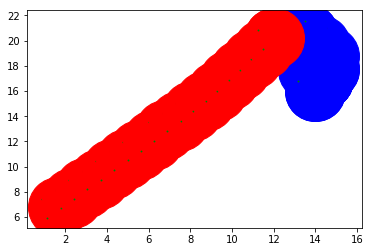

(0.19267804425149304, -0.19267804425149304)

In [99]:
eye_pair = (Evolve.random_eye_pair(), Evolve.random_eye_pair())
print(eye_pair[0][0].eye_arclength)
simulation_control(Grid, Animal, eye_pair[0], eye_pair[1]).start_sim()

In [100]:
class Evolve():
    def random_eye_pair():
        return((Eye(random.uniform(-6.24, 6.24)), Eye(random.uniform(-6.24, 6.24))))
    
    def breed_eye(eye_pair1, eye_pair2):
        return((Eye((eye_pair1[0].eye_arclength + eye_pair2[0].eye_arclength)/2), Eye((eye_pair1[1].eye_arclength + eye_pair2[1].eye_arclength)/2)))
    
    
    def mutate(eye_pair):
        chance_of_mutation = .01
        if random.random() < chance_of_mutation:
            eye_pair[0].eye_arclength += random.uniform(-6.24, 6.24)
            eye_pair[1].eye_arclength += random.uniform(-6.24, 6.24)
        return(eye_pair)

In [101]:
# So we are going to have a predator population that will one on one with a prey population at random
# The eye_placement for 1 and 2 will be random initally, but will undergo both breeding and mutation
init_pop = 50
prey_population = [Evolve.random_eye_pair() for item in range(init_pop)]
pred_population = [Evolve.random_eye_pair() for item in range(init_pop)]


PREY :  0 :  [19.036482090370058, 15.732356136213905]
(18.390827857612898, 16.495986028061235)
(18.314117024268832, 15.040844233730242)
PRED :  0 :  [18.77083117743483, 5.637039477500755]
(19.59668647755675, 5.073157377004092)
(19.259588156068457, 6.50945945425331)
PREY :  0 :  [18.078737154440386, 15.444737225672418]
(17.433082921683226, 16.208367117519746)
(17.35637208833916, 14.753225323188754)
PRED :  0 :  [19.531153291403104, 6.286585690645602]
(20.357008591525027, 5.722703590148939)
(20.019910270036732, 7.159005667398157)
PREY :  0 :  [17.12683241293171, 15.138343095354461]
(16.48117818017455, 15.90197298720179)
(16.404467346830483, 14.446831192870798)
PRED :  0 :  [20.280417188222177, 6.948857245918433]
(21.1062724883441, 6.38497514542177)
(20.769174166855805, 7.821277222670988)
PREY :  0 :  [16.180823107496664, 14.814203628411136]
(15.535168874739504, 15.577833520258464)
(15.45845804139544, 14.122691725927472)
PRED :  0 :  [21.01798482728728, 7.624130507497724]
(21.843840127409

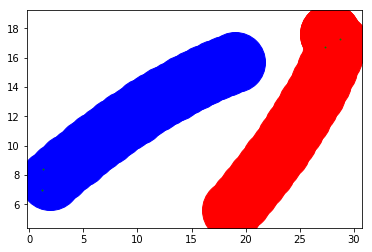

PREY :  0 :  [4, 4]
(3.8402536687008095, 4.987158097589464)
(4.90328558991016, 4.429039791931535)
PRED :  0 :  [3.7071067811865475, 12.707106781186548]
(2.709168224136298, 12.642930178343567)
(3.7469828892080437, 13.706311412885709)
PREY :  0 :  [4, 4]
(4.643986342338218, 3.234963013389651)
(3.004588602068439, 3.9043122324017556)
PRED :  0 :  [4.414213562373095, 13.414213562373096]
(3.4162750053228454, 13.350036959530115)
(4.454089670394591, 14.413418194072257)
PREY :  0 :  [3.9729866837207526, 4.999635073786228]
(4.616973026058971, 4.234598087175879)
(2.9775752857891917, 4.903947306187984)
PRED :  0 :  [5.036353830528954, 14.197119359221578]
(4.038415273478704, 14.132942756378597)
(5.07622993855045, 15.196323990920739)
PREY :  0 :  [3.4592152550373196, 5.857562179704082]
(4.103201597375538, 5.092525193093733)
(2.4638038571057588, 5.761874412105838)
PRED :  0 :  [5.5448574254951986, 15.058179225843176]
(4.546918868444949, 14.994002623000195)
(5.584733533516695, 16.057383857542337)
PREY

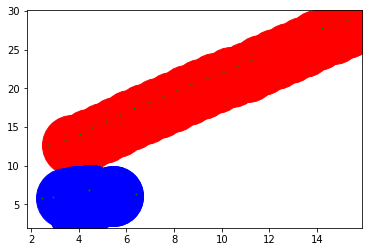

PREY :  0 :  [9.122104427085615, 8.521147869319426]
(9.939289993672515, 9.097522530249318)
(10.121725809968424, 8.548663153862014)
PRED :  0 :  [11.827115777336653, 5.43796842537026]
(11.496142005320683, 6.381608379080106)
(11.550698471830493, 4.47693071892128)
PREY :  0 :  [8.213540932667103, 8.103401084041524]
(9.030726499254003, 8.679775744971415)
(9.213162315549912, 8.130916368584112)
PRED :  0 :  [11.827115777336653, 5.43796842537026]
(12.666408204656193, 5.9816486819954875)
(10.828022322322537, 5.480539168233836)
PREY :  0 :  [7.30497743824859, 7.685654298763622]
(8.12216300483549, 8.262028959693513)
(8.3045988211314, 7.713169583306211)
PRED :  0 :  [11.827115777336653, 5.43796842537026]
(12.725365023636542, 5.877454820519965)
(10.84026928154419, 5.5996285433404545)
PREY :  0 :  [6.396413943830078, 7.267907513485721]
(7.213599510416978, 7.8442821744156115)
(7.396035326712887, 7.2954227980283095)
PRED :  0 :  [11.827115777336653, 5.43796842537026]
(12.750546276104899, 5.8217341272

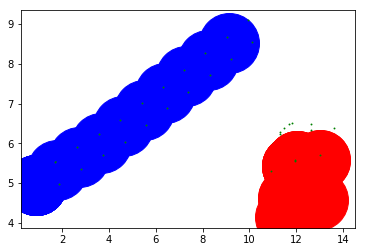

PREY :  0 :  [0.683772233983162, 18.051316701949485]
(0.626111982225232, 19.04965296562381)
(1.6623421360839403, 17.84540180034576)
PRED :  0 :  [3.2069666760737974, 8.021652007210642]
(4.13832826305148, 8.385747591230022)
(3.4837311913630646, 8.982589779949699)
PREY :  0 :  [0.31255061828529945, 17.1227724046547]
(0.25489036652736946, 18.121108668329025)
(1.2911205203860778, 16.916857503050974)
PRED :  0 :  [3.2069666760737974, 8.021652007210642]
(3.305412145629771, 9.016794454061294)
(2.4764323181691483, 8.704527949033784)
PREY :  0 :  [0.31255061828529945, 17.1227724046547]
(0.25489036652736946, 18.121108668329025)
(1.2911205203860778, 16.916857503050974)
PRED :  0 :  [3.2069666760737974, 8.021652007210642]
(2.2121626063617925, 8.123459977843755)
(2.683339989507857, 8.873599830211543)
PREY :  0 :  [0.31255061828529945, 17.1227724046547]
(0.25489036652736946, 18.121108668329025)
(1.2911205203860778, 16.916857503050974)
PRED :  0 :  [3.1678988140842232, 9.020888566869846]
(2.173094744

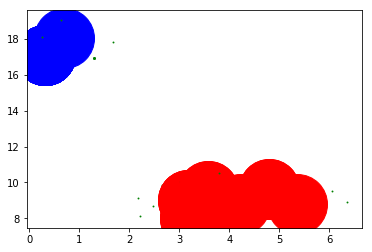

PREY :  0 :  [6, 7]
(5.000000056754184, 6.999663089976763)
(5.883948695850105, 7.9932432203670505)
PRED :  0 :  [7.730034375126718, 9.683410426561771]
(7.417735454393792, 8.733426540325247)
(6.759181578525026, 9.44373387925129)
PREY :  0 :  [5.024346641204133, 6.780681684598975]
(4.0243466979583165, 6.780344774575738)
(4.908295337054238, 7.773924904966026)
PRED :  0 :  [8.670474374494688, 10.023370141217452]
(8.358175453761762, 9.073386254980928)
(7.699621577892996, 9.783693593906971)
PREY :  0 :  [4.370125053409092, 6.0243787597977185]
(3.3701251101632757, 6.024041849774481)
(4.254073749259197, 7.017621980164769)
PRED :  0 :  [7.7014325385417495, 10.27026671910576]
(7.389133617808824, 9.320282832869236)
(6.7305797419400575, 10.030590171795279)
PREY :  0 :  [3.770188247295791, 5.224331368282334]
(2.7701883040499746, 5.223994458259097)
(3.654136943145896, 6.217574588649384)
PRED :  0 :  [7.7014325385417495, 10.27026671910576]
(6.848146260207557, 9.748823982837832)
(6.806542128142095, 10

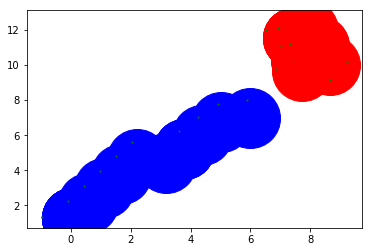

PREY :  0 :  [19.231778720402623, 15.359815600335521]
(20.120123550374775, 14.90063865942739)
(18.352500724239082, 15.836124539431387)
PRED :  0 :  [12.781376070233756, 10.624060443279376]
(13.752940188215023, 10.860837056675384)
(12.767235036743136, 11.623960453866344)
PREY :  0 :  [18.462756545580387, 14.720593499159666]
(19.35110137555254, 14.261416558251534)
(17.583478549416846, 15.196902438255531)
PRED :  0 :  [13.563268727973645, 11.247473526052312]
(14.534832845954911, 11.48425013944832)
(13.549127694483024, 12.24737353663928)
PREY :  0 :  [17.692995373355824, 14.082261502675493]
(18.581340203327976, 13.623084561767362)
(16.813717377192283, 14.558570441771359)
PRED :  0 :  [14.34569119117625, 11.87022154016072]
(15.317255309157517, 12.106998153556729)
(14.33155015768563, 12.870121550747688)
PREY :  0 :  [16.92254632827795, 13.444759919196212]
(17.8108911582501, 12.98558297828808)
(16.04326833211441, 13.921068858292077)
PRED :  0 :  [15.128660801375615, 12.492281496679588]
(16.10

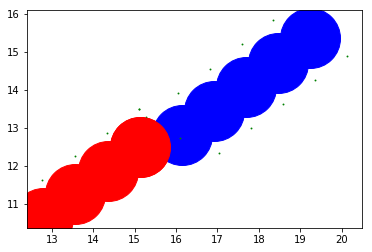

PREY :  0 :  [12.414509446155641, 0.1893207716001193]
(12.937015199846865, 1.0419565305028087)
(13.365384800428162, -0.12025322704496738)
PRED :  0 :  [13.999883739638923, 18.015248186963802]
(13.644701818807714, 17.080450988040607)
(13.508222863296782, 17.14446142622701)
PREY :  0 :  [12.414509446155641, 0.1893207716001193]
(12.937015199846865, 1.0419565305028087)
(13.365384800428162, -0.12025322704496738)
PRED :  0 :  [14.999767479277846, 18.030496373927605]
(14.644585558446636, 17.09569917500441)
(14.508106602935705, 17.159709613190813)
PREY :  0 :  [12.414509446155641, 0.1893207716001193]
(12.937015199846865, 1.0419565305028087)
(13.365384800428162, -0.12025322704496738)
PRED :  0 :  [15.99965121891677, 18.045744560891407]
(15.64446929808556, 17.11094736196821)
(15.507990342574628, 17.174957800154615)
PREY :  0 :  [12.414509446155641, 0.1893207716001193]
(12.937015199846865, 1.0419565305028087)
(13.365384800428162, -0.12025322704496738)
PRED :  0 :  [16.999534958555692, 18.06099274

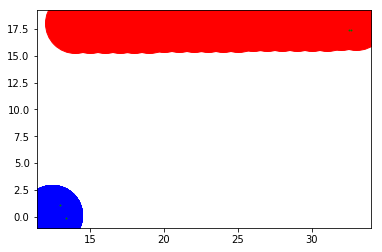

PREY :  0 :  [9.03648209037006, 19.732356136213905]
(8.947277766182692, 20.72836948378826)
(8.065885447084804, 19.97306790585427)
PRED :  0 :  [18.416368557667838, 5.909195921782322]
(19.00685372029253, 6.716244416434342)
(19.157255035916073, 6.580826196821297)
PREY :  0 :  [8.084297737409848, 19.426832065185543]
(7.995093413222482, 20.422845412759898)
(7.113701094124593, 19.667543834825906)
PRED :  0 :  [18.80057023025743, 6.832445116084358]
(19.391055392882123, 7.639493610736378)
(19.541456708505667, 7.504075391123333)
PREY :  0 :  [7.144438088523918, 19.085271176915214]
(7.055233764336552, 20.08128452448957)
(6.173841445238663, 19.325982946555577)
PRED :  0 :  [19.1511541896287, 7.768976422251732]
(19.74163935225339, 8.576024916903751)
(19.892040667876934, 8.440606697290706)
PREY :  0 :  [6.217782995229543, 18.70935850345023]
(6.128578671042177, 19.705371851024584)
(5.247186351944288, 18.950070273090592)
PRED :  0 :  [19.46652956176245, 8.717943426236328]
(20.05701472438714, 9.52499

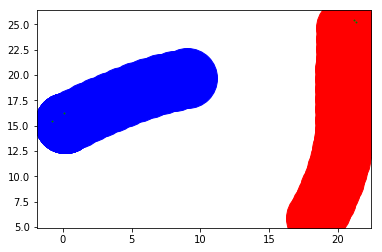

PREY :  0 :  [17.521147869319428, 8.122104427085615]
(18.094881555980812, 8.941146341025274)
(18.107025786596452, 7.311705102032134)
PRED :  0 :  [6.907260265379149, 11.420569626654324]
(5.992800431619784, 11.82524630307736)
(7.618501763167863, 12.12351737138594)
PREY :  0 :  [17.003629800981933, 7.266432148146869]
(17.577363487643318, 8.085474062086528)
(17.589507718258957, 6.456032823093388)
PRED :  0 :  [7.826812818521037, 11.81353667617659]
(6.9123529847616725, 12.218213352599626)
(8.53805431630975, 12.516484420908206)
PREY :  0 :  [16.451319773050034, 6.432793357635136]
(17.02505345971142, 7.251835271574794)
(17.03719769032706, 5.622394032581655)
PRED :  0 :  [8.758145468513419, 12.177706272735893]
(7.8436856347540544, 12.58238294915893)
(9.469386966302134, 12.88065401746751)
PREY :  0 :  [15.867445539116984, 5.620949235312942]
(16.441179225778367, 6.4399911492526)
(16.453323456394006, 4.810549910259461)
PRED :  0 :  [9.700749717222779, 12.511618282575409]
(8.786289883463414, 12.9

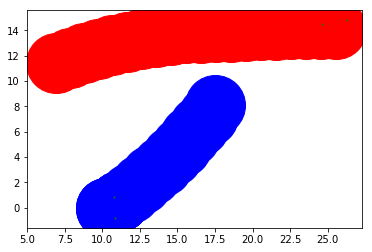

PREY :  0 :  [9.198188166689867, 5.597576592550147]
(9.9372688489444, 6.271193505281837)
(8.775006755800506, 6.503621565759364)
PRED :  0 :  [13.854253020972196, 12.519857457539926]
(14.64781012896462, 13.128353239246506)
(13.430559700664343, 13.425663159843962)
PREY :  0 :  [8.244752642948553, 5.2959796726916615]
(8.983833325203086, 5.969596585423352)
(7.821571232059193, 6.202024645900878)
PRED :  0 :  [14.695627260620364, 13.060310405405387]
(15.489184368612788, 13.668806187111967)
(14.271933940312511, 13.966116107709423)
PREY :  0 :  [7.978331220149135, 4.332123031134664]
(8.717411902403668, 5.005739943866354)
(7.555149809259775, 5.238168004343881)
PRED :  0 :  [15.574433166496311, 13.537489805419215]
(16.367990274488733, 14.145985587125795)
(15.150739846188458, 14.443295507723251)
PREY :  0 :  [7.978331220149135, 4.332123031134664]
(7.193204817146954, 3.712787474825439)
(7.153426228885889, 4.897394430896746)
PRED :  0 :  [16.45323907237226, 14.014669205433043]
(17.246796180364683, 

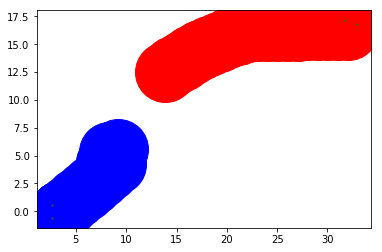

PREY :  0 :  [18.732356136213905, 3.0364820903700593]
(17.75032068494278, 3.2251785992055715)
(17.73236306906775, 3.032758428245141)
PRED :  0 :  [5.98711544477447, 18.160009683106054]
(5.48969798168263, 17.292498376314448)
(5.349868320819328, 17.389350158406007)
PREY :  0 :  [18.419246936254492, 2.0867649593774806]
(17.437211484983365, 2.2754614682129928)
(17.419253869108335, 2.0830412972525623)
PRED :  0 :  [6.980758959708155, 18.27258217188653]
(6.483341496616315, 17.405070865094924)
(6.343511835753014, 17.501922647186483)
PREY :  0 :  [18.062368917568175, 1.1526139652772072]
(17.08033346629705, 1.3413104741127193)
(17.06237585042202, 1.1488903031522886)
PRED :  0 :  [7.978729107382133, 18.33626564188918]
(7.481311644290292, 17.468754335097575)
(7.341481983426991, 17.565606117189134)
PREY :  0 :  [17.663371987566006, 0.23566170378872375]
(16.68133653629488, 0.424358212624236)
(16.66337892041985, 0.23193804166380527)
PRED :  0 :  [8.978640117050473, 18.349606284453998]
(8.48122265395

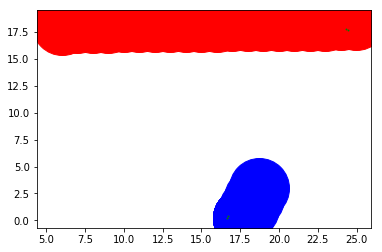

PREY :  0 :  [3.01941932430908, 1.8038838648618158]
(2.5793224595645947, 2.7018341695235346)
(4.0034836445352635, 1.9816967262014238)
PRED :  0 :  [10, 2]
(9.006655801347963, 2.11518377925881)
(10.91978323595589, 1.6075731929970736)
PREY :  0 :  [2.03883864861816, 1.6077677297236317]
(1.5987417838736746, 2.5057180343853505)
(3.022902968844344, 1.7855805910632396)
PRED :  0 :  [10, 2]
(10.45490490264961, 2.8905400213046852)
(9.311010434625803, 1.275228740356327)
PREY :  0 :  [1.05825797292724, 1.4116515945854475]
(0.6181611081827545, 2.3096018992471663)
(2.0423222931534237, 1.5894644559250555)
PRED :  0 :  [10, 2]
(10.976698669487735, 2.2146152581269236)
(9.002557227540102, 2.071469683555419)
PREY :  0 :  [0.07767729723632, 1.2155354594472634]
(-0.3624195675081656, 2.113485764108982)
(1.0617416174625038, 1.3933483207868713)
PRED :  0 :  [10, 2]
(9.168876142570854, 2.5560873435100793)
(10.639076586880941, 1.2308568949144731)
PREY :  0 :  [0.07767729723632, 1.2155354594472634]
(-0.3624195

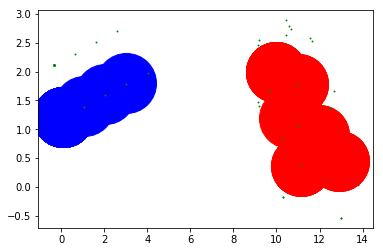

PREY :  0 :  [9.205642167022804, 18.3925498924292]
(9.780128426343362, 19.2110641182383)
(8.903711428170269, 19.34587975608394)
PRED :  0 :  [17.447577905476898, 13.894244943250401]
(17.32035134154817, 12.90237126105549)
(16.924652961554447, 14.74662367540161)
PREY :  0 :  [8.423379573001878, 17.76960107109983]
(8.997865832322436, 18.58811529690893)
(8.121448834149342, 18.72293093475457)
PRED :  0 :  [17.875921741034055, 14.797860767890597]
(17.74869517710533, 13.805987085695687)
(17.352996797111604, 15.650239500041806)
PREY :  0 :  [7.653069805750742, 17.131931201592497]
(8.2275560650713, 17.950445427401597)
(7.351139066898207, 18.085261065247234)
PRED :  0 :  [18.283789705400267, 15.710901689012845]
(18.15656314147154, 14.719028006817934)
(17.760864761477816, 16.563280421164055)
PREY :  0 :  [6.894614847851446, 16.48020574034522]
(7.469101107172004, 17.29871996615432)
(6.5926841089989106, 17.433535603999957)
PRED :  0 :  [18.66973364372735, 16.633423925313185]
(18.542507079798625, 15

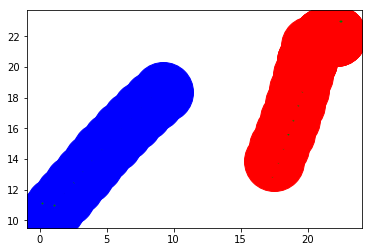

PREY :  0 :  [13, 16]
(12.841388451281372, 16.987341063975908)
(13.934213503576233, 15.643285646860376)
PRED :  0 :  [10.630592625094465, 18.776114000116266]
(10.36628918813766, 19.740553574798277)
(9.849070077010223, 18.152237003556916)
PREY :  0 :  [13, 16]
(12.562235587629061, 16.899089717025795)
(13.790865166999145, 15.38800956900666)
PRED :  0 :  [11.26118525018893, 19.55222800023253]
(10.996881813232125, 20.516667574914543)
(10.479662702104688, 18.928351003673182)
PREY :  0 :  [13, 16]
(13.105182696841371, 16.99445291506696)
(13.994995511339603, 15.900080370226656)
PRED :  0 :  [11.891777875283395, 20.328342000348798]
(11.62747443832659, 21.29278157503081)
(11.110255327199154, 19.704465003789448)
PREY :  0 :  [13, 16]
(13.878231912147118, 15.521765007045264)
(12.71100237332933, 16.95732981348056)
PRED :  0 :  [12.52237050037786, 21.104456000465063]
(12.258067063421056, 22.068895575147074)
(11.740847952293619, 20.480579003905714)
PREY :  0 :  [13, 16]
(12.119016913340856, 15.52685

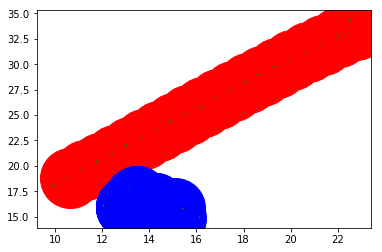

PREY :  0 :  [15.826214666090953, 0.015216441182063223]
(15.695686256985416, -0.9762281283307147)
(15.000172623553537, 0.5788249435670193)
PRED :  0 :  [3.999999537787398, 17.000961470223288]
(4.731531552177496, 17.682768563118607)
(3.2892374344516773, 17.704393934971527)
PREY :  0 :  [15.826214666090953, 0.015216441182063223]
(15.695686256985416, -0.9762281283307147)
(15.000172623553537, 0.5788249435670193)
PRED :  0 :  [4.999999075574796, 17.001922940446576]
(5.731531089964895, 17.683730033341895)
(4.289236972239076, 17.705355405194815)
PREY :  0 :  [15.826214666090953, 0.015216441182063223]
(15.695686256985416, -0.9762281283307147)
(15.000172623553537, 0.5788249435670193)
PRED :  0 :  [5.9999986133621945, 17.002884410669864]
(6.731530627752292, 17.684691503565183)
(5.289236510026474, 17.706316875418104)
PREY :  0 :  [15.826214666090953, 0.015216441182063223]
(15.695686256985416, -0.9762281283307147)
(15.000172623553537, 0.5788249435670193)
PRED :  0 :  [6.999998151149592, 17.0038458

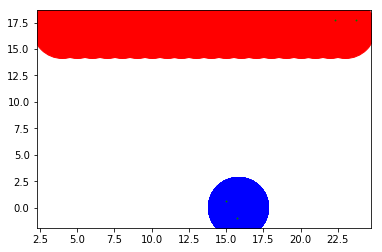

PREY :  0 :  [8.25259068131634, 0.33563616117008044]
(9.029701149991268, 0.965000379628543)
(7.844320909033849, -0.5772251607405388)
PRED :  0 :  [18.99917398387839, 16.0406368052458]
(18.18579891986053, 16.62237644222608)
(19.955351648587925, 16.333423884043036)
PREY :  0 :  [8.25259068131634, 0.33563616117008044]
(9.029701149991268, 0.965000379628543)
(7.844320909033849, -0.5772251607405388)
PRED :  0 :  [19.99834796775678, 16.0812736104916]
(19.18497290373892, 16.66301324747188)
(20.954525632466314, 16.374060689288836)
PREY :  0 :  [8.25259068131634, 0.33563616117008044]
(9.029701149991268, 0.965000379628543)
(7.844320909033849, -0.5772251607405388)
PRED :  0 :  [20.997521951635168, 16.1219104157374]
(20.18414688761731, 16.70365005271768)
(21.953699616344704, 16.414697494534636)
PREY :  0 :  [8.25259068131634, 0.33563616117008044]
(9.029701149991268, 0.965000379628543)
(7.844320909033849, -0.5772251607405388)
PRED :  0 :  [21.996695935513557, 16.1625472209832]
(21.1833208714957, 16.

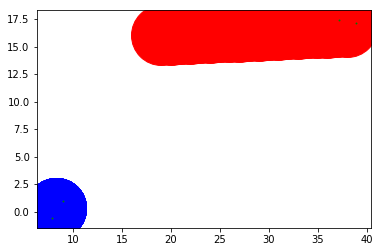

PREY :  0 :  [3.9376217138448193, 1.0019474215171114]
(3.34903364041147, 0.19351431988654466)
(4.624058738012115, 1.7291366760116669)
PRED :  0 :  [1.9691181329330956, 16.246596927029252]
(2.5493990328752636, 15.432180524221506)
(1.788736861846269, 17.23019369249826)
PREY :  0 :  [3.8173003634139975, 0.0092124253421485]
(3.228712289980648, -0.7992206762884182)
(4.503737387581293, 0.736401679836704)
PRED :  0 :  [2.9691152208524185, 16.249010255203036]
(3.5493961207945866, 15.43459385239529)
(2.7887339497655916, 17.232607020672045)
PREY :  0 :  [3.8173003634139975, 0.0092124253421485]
(3.228712289980648, -0.7992206762884182)
(4.503737387581293, 0.736401679836704)
PRED :  0 :  [3.9691123087717415, 16.25142358337682]
(4.5493932087139095, 15.437007180569074)
(3.7887310376849146, 17.23502034884583)
PREY :  0 :  [3.8173003634139975, 0.0092124253421485]
(3.228712289980648, -0.7992206762884182)
(4.503737387581293, 0.736401679836704)
PRED :  0 :  [4.969109396691064, 16.253836911550604]
(5.54939

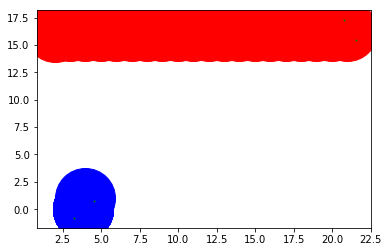

PREY :  0 :  [13.68368497330028, 6.270222734470719]
(14.372176865793584, 6.99546677199946)
(14.359276079021598, 7.007499248317626)
PRED :  0 :  [12.909101715154325, 13.41657420887936]
(13.909021263997015, 13.403889736394143)
(13.251836847928915, 14.356006286659326)
PREY :  0 :  [12.990337695511325, 5.549619131660793]
(13.678829588004628, 6.274863169189534)
(13.665928801232642, 6.2868956455077)
PRED :  0 :  [13.828699000988433, 13.80943656631074]
(14.828618549831123, 13.796752093825523)
(14.171434133763023, 14.748868644090706)
PREY :  0 :  [12.282738267185232, 4.843005341084508]
(12.971230159678536, 5.568249378613249)
(12.95832937290655, 5.580281854931415)
PRED :  0 :  [14.758994972689413, 14.176246333133992]
(15.758914521532105, 14.163561860648775)
(15.101730105464004, 15.115678410913958)
PREY :  0 :  [11.561536777756569, 4.150279990280975]
(12.250028670249872, 4.875524027809716)
(12.237127883477886, 4.887556504127882)
PRED :  0 :  [15.700190038575093, 14.51410998603624]
(16.7001095874

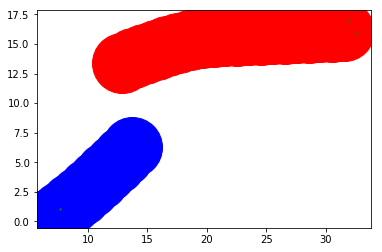

PREY :  0 :  [3.25259068131634, 9.33563616117008]
(2.2538905898291244, 9.386607989305112)
(2.3247918929155826, 8.962555193762084)
PRED :  0 :  [18, 16]
(17.127903767439587, 15.510665593735805)
(17.20022907742725, 15.399694684841846)
PREY :  0 :  [2.5051813626326798, 8.671272322340162]
(1.5064812711454643, 8.722244150475193)
(1.5773825742319225, 8.298191354932165)
PRED :  0 :  [18.640545876630167, 15.232080095366651]
(17.768449644069754, 14.742745689102456)
(17.840774954057416, 14.631774780208497)
PREY :  0 :  [1.7308317744030393, 8.038514299705453]
(0.7321316829158236, 8.089486127840484)
(0.8030329860022821, 7.6654333322974555)
PRED :  0 :  [19.04722228169826, 16.145652370318608]
(18.175126049137848, 15.656317964054413)
(18.24745135912551, 15.545347055160454)
PREY :  0 :  [0.9680139787438935, 7.391900805703261]
(-0.030686112743322114, 7.442872633838292)
(0.040215190343136364, 7.018819838295264)
PRED :  0 :  [18.357050720151136, 15.422006589821269]
(17.484954487590723, 14.93267218355707

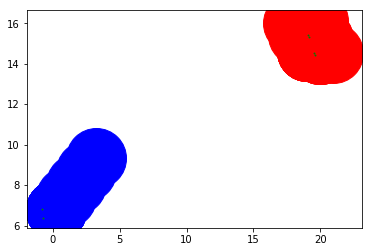

PREY :  0 :  [3.6114656406959273, 0.07856576380070734]
(3.066218774477856, -0.7597097606418071)
(2.611947664563668, 0.047520387519016424)
PRED :  0 :  [7, 1]
(6.067684711247898, 1.36164651575687)
(6.944254051044668, 1.998444985552569)
PREY :  0 :  [3.6114656406959273, 0.07856576380070734]
(3.066218774477856, -0.7597097606418071)
(2.611947664563668, 0.047520387519016424)
PRED :  0 :  [7.072747704637414, 1.9973503754799453]
(6.140432415885312, 2.3589968912368153)
(7.017001755682082, 2.9957953610325143)
PREY :  0 :  [3.6114656406959273, 0.07856576380070734]
(3.0460982601990954, 0.9034049754475292)
(3.965782843597352, 1.0136910600728757)
PRED :  0 :  [6.124047177905298, 2.313526450757954]
(5.191731889153195, 2.675172966514824)
(6.068301228949966, 3.311971436310523)
PREY :  0 :  [3.6114656406959273, 0.07856576380070734]
(3.0460982601990954, 0.9034049754475292)
(3.965782843597352, 1.0136910600728757)
PRED :  0 :  [7.123810631917344, 2.3352758420575355]
(6.191495343165242, 2.6969223578144055)

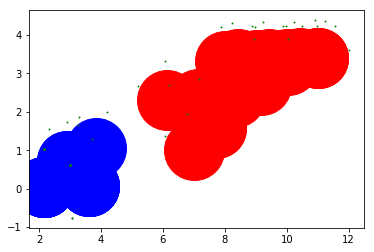

PREY :  0 :  [3.134573714518874, 2.4989637294582954]
(3.9738184266279095, 3.0427176381311636)
(3.0756753458640635, 3.497227713667784)
PRED :  0 :  [19, 11]
(18.885530265167294, 11.993426736003883)
(19.421094014396687, 11.907016996003538)
PREY :  0 :  [2.269147429037748, 1.9979274589165907]
(3.1083921411467834, 2.541681367589459)
(2.2102490603829374, 2.9961914431260794)
PRED :  0 :  [19.52191604379805, 10.14700313996698]
(19.407446308965344, 11.140429875970863)
(19.943010058194737, 11.054020135970518)
PREY :  0 :  [1.3818489098572213, 1.5367319061842983]
(2.221093621966257, 2.080485814857166)
(1.322950541202411, 2.534995890393787)
PRED :  0 :  [19.52191604379805, 10.14700313996698]
(19.47036855005318, 11.145673684184953)
(19.256765943138742, 9.182795992036434)
PREY :  0 :  [0.4945503906766947, 1.075536353452006]
(1.3337951027857304, 1.619290262124874)
(0.4356520220218844, 2.0738003376614946)
PRED :  0 :  [19.52191604379805, 10.14700313996698]
(18.536714345336566, 10.318402128728886)
(20

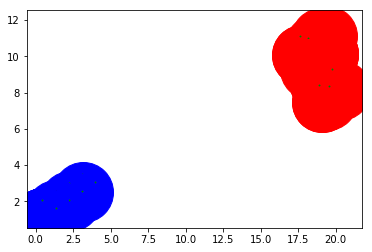

PREY :  0 :  [19.783069542181345, 0.023812939816047263]
(19.492661474155287, -0.9330899570472512)
(20.611376865037602, 0.5840869610794809)
PRED :  0 :  [4.999999275550352, 18.001203702110736]
(4.197479075672257, 17.40457875393339)
(4.4163496070034665, 18.813209283621795)
PREY :  0 :  [19.783069542181345, 0.023812939816047263]
(19.492661474155287, -0.9330899570472512)
(20.611376865037602, 0.5840869610794809)
PRED :  0 :  [5.999998551100704, 18.002407404221472]
(5.1974783512226095, 17.405782456044125)
(5.416348882553819, 18.81441298573253)
PREY :  0 :  [19.783069542181345, 0.023812939816047263]
(19.492661474155287, -0.9330899570472512)
(20.611376865037602, 0.5840869610794809)
PRED :  0 :  [6.9999978266510565, 18.003611106332208]
(6.197477626772962, 17.40698615815486)
(6.416348158104171, 18.815616687843267)
PREY :  0 :  [19.783069542181345, 0.023812939816047263]
(19.492661474155287, -0.9330899570472512)
(20.611376865037602, 0.5840869610794809)
PRED :  0 :  [7.999997102201409, 18.004814808

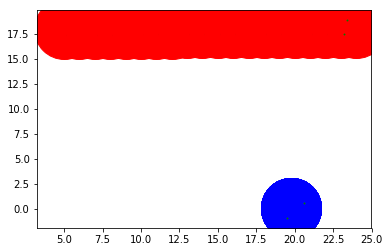

PREY :  0 :  [20, 19]
(19.609414574749476, 19.92056668719972)
(19.031150373882035, 18.752350243345404)
PRED :  0 :  [3.7249994335944137, 8.688749461914693]
(2.8664644227846647, 8.17599451536234)
(2.9868044171152306, 9.363336830344682)
PREY :  0 :  [19.036738143430963, 18.73143604918163]
(18.64615271818044, 19.652002736381352)
(18.067888517312998, 18.483786292527036)
PRED :  0 :  [4.437798881399118, 9.390117373362964]
(3.5792638705893696, 8.877362426810611)
(3.699603864919935, 10.064704741792953)
PREY :  0 :  [19.036738143430963, 18.73143604918163]
(18.94853457857191, 19.727538519385455)
(18.191188659946242, 18.197538988898735)
PRED :  0 :  [5.150598329203822, 10.091485284811235]
(4.2920633183940735, 9.578730338258882)
(4.4124033127246385, 10.766072653241224)
PREY :  0 :  [19.219128434571182, 17.748209838334002]
(19.13092486971213, 18.744312308537825)
(18.37357895108646, 17.214312778051106)
PRED :  0 :  [5.8852593291094095, 10.7699196701557]
(5.026724318299661, 10.257164723603347)
(5.14

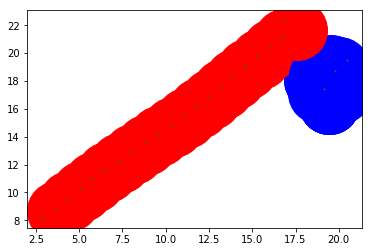

PREY :  0 :  [7.770960666274453, 8.026582831666424]
(7.161691882780447, 8.819546607295383)
(6.832325292792039, 7.681671776976191)
PRED :  0 :  [4.6955739369477705, 17.718454520647605]
(5.625331427437999, 17.350281994680074)
(3.8856307007224604, 18.304962793473205)
PREY :  0 :  [7.5147930743797575, 7.059950448149881]
(6.905524290885752, 7.852914223778841)
(6.576157700897344, 6.715039393459648)
PRED :  0 :  [5.424392999874439, 18.40316086172726]
(6.354150490364668, 18.03498833575973)
(4.614449763649129, 18.989669134552862)
PREY :  0 :  [7.232065595608611, 6.100750170445735]
(6.622796812114605, 6.893713946074695)
(6.293430222126197, 5.755839115755502)
PRED :  0 :  [6.188752467742409, 19.04795121826231]
(7.118509958232638, 18.67977869229478)
(5.378809231517099, 19.63445949108791)
PREY :  0 :  [6.923062242702779, 5.149689221876742]
(6.313793459208773, 5.942652997505702)
(5.984426869220364, 4.804778167186509)
PRED :  0 :  [6.991116507697338, 19.64478615975552]
(7.920873998187567, 19.27661363

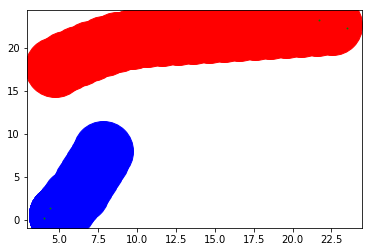

PREY :  0 :  [6.036482090370059, 1.7323561362139055]
(6.955090801108177, 1.3371877713919575)
(5.050652378618511, 1.5646069799481923)
PRED :  0 :  [18, 5]
(18.97396838652991, 5.226683881297996)
(18.4981877180918, 5.867069199973385)
PREY :  0 :  [6.443557481624572, 2.6457506981831482]
(7.36216619236269, 2.2505823333612005)
(5.457727769873024, 2.4780015419174353)
PRED :  0 :  [18, 5]
(18.975038232980346, 5.22203703345741)
(18.49404752161984, 5.869434900599977)
PREY :  0 :  [5.480039571994632, 2.378106834397054]
(6.39864828273275, 1.982938469575106)
(4.4942098602430836, 2.210357678131341)
PRED :  0 :  [17.633352825123534, 4.069639935747936]
(18.60839105810388, 4.291676969205346)
(18.127400346743375, 4.9390748363479124)
PREY :  0 :  [4.505653275900638, 2.1532260971512236]
(5.424261986638756, 1.7580577323292756)
(3.5198235641490894, 1.9854769408855104)
PRED :  0 :  [17.633352825123534, 4.069639935747936]
(18.633304630760573, 4.079457593473834)
(17.91260767795475, 5.029856956618851)
PREY :  0

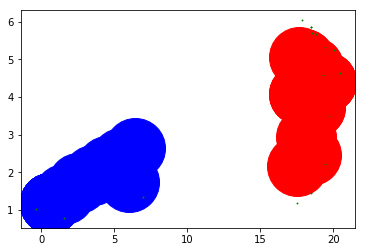

PREY :  0 :  [10.311250538085307, 4.275000566405586]
(9.389372851432324, 4.662481573490246)
(10.757080973782955, 5.170118001497566)
PRED :  0 :  [19.923754664847333, 20.38298475057473]
(19.192931022739195, 21.065551087377095)
(19.201874528420287, 21.07500286351114)
PREY :  0 :  [9.61224546184139, 3.5598838602762757]
(8.690367775188406, 3.947364867360936)
(10.058075897539037, 4.455001295368255)
PRED :  0 :  [20.861510004288533, 20.730281343344547]
(20.130686362180395, 21.41284768014691)
(20.139629867861487, 21.422299456280957)
PREY :  0 :  [8.90291117795553, 2.8550116209987344]
(7.981033491302547, 3.2424926280833946)
(9.348741613653178, 3.7501290560907146)
PRED :  0 :  [21.81374520023322, 21.03564691377478]
(21.082921558125083, 21.718213250577143)
(21.091865063806175, 21.72766502671119)
PREY :  0 :  [8.183082778348941, 2.1608595662442904]
(7.261205091695958, 2.5483405733289506)
(8.62891321404659, 3.0559770013362706)
PRED :  0 :  [22.78060371774077, 21.290959677112426]
(22.04978007563263

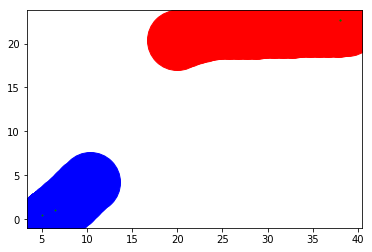

PREY :  0 :  [11.498963729458294, 4.134573714518874]
(10.505181803969078, 4.023229722445001)
(11.821356446543415, 5.08117972335807)
PRED :  0 :  [11.941019131865701, 19.338353355920585]
(11.177186605111757, 19.98376785147572)
(11.70968666979924, 20.311228112502473)
PREY :  0 :  [10.973574614038442, 3.2837116355669758]
(9.979792688549226, 3.172367643493103)
(11.295967331123563, 4.230317644406172)
PRED :  0 :  [12.899046078183346, 19.62503152064418]
(12.135213551429402, 20.270446016199312)
(12.667713616116885, 20.597906277226066)
PREY :  0 :  [10.424319504285327, 2.448056907578141]
(9.43053757879611, 2.3367129155042683)
(10.746712221370448, 3.3946629164173374)
PRED :  0 :  [13.87256151891966, 19.853652794037497]
(13.108728992165716, 20.49906728959263)
(13.641229056853199, 20.826527550619385)
PREY :  0 :  [9.851549989137085, 1.6283404428680268]
(8.85776806364787, 1.5169964507941545)
(10.173942706222206, 2.5749464517072234)
PRED :  0 :  [14.859175170834357, 20.01672793578371]
(14.095342644

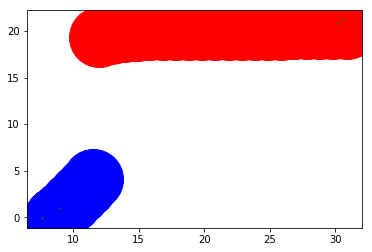

PREY :  0 :  [6.146718166348041, 14.478549990546025]
(6.903550258335062, 15.132159342176301)
(5.268329246964117, 14.956496542268644)
PRED :  0 :  [18.39078167474919, 11.920483396200181]
(18.955129381590375, 12.746020594503863)
(19.188292258224024, 12.523788351629545)
PREY :  0 :  [5.307576265509609, 13.934637432999077]
(6.06440835749663, 14.588246784629353)
(4.429187346125685, 14.412583984721696)
PRED :  0 :  [18.746726809621368, 12.854990250621713]
(19.311074516462554, 13.680527448925394)
(19.544237393096203, 13.458295206051076)
PREY :  0 :  [4.482849298659257, 13.369106328505417]
(5.239681390646278, 14.022715680135693)
(3.6044603792753334, 13.847052880228036)
PRED :  0 :  [19.064644239375934, 13.80310865454511]
(19.62899194621712, 14.628645852848791)
(19.86215482285077, 14.406413609974473)
PREY :  0 :  [3.6728602875601024, 12.782661274047104]
(4.429692379547123, 13.43627062567738)
(2.794471368176178, 13.260607825769723)
PRED :  0 :  [19.340802011488307, 14.76422097103155]
(19.9051497

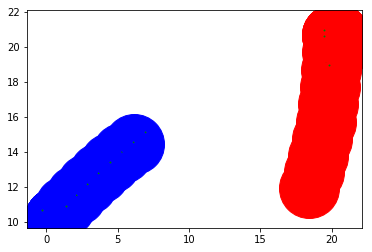

PREY :  0 :  [18.125842723878463, 9.514357068821369]
(19.07781850198795, 9.82053041497162)
(18.685727342817163, 8.68578648433513)
Prey slaughtered
[18, 10]
PRED :  1 :  [18, 10]
(17.790846913631963, 9.022117089594708)
(18.999800763336, 10.0199608024075)


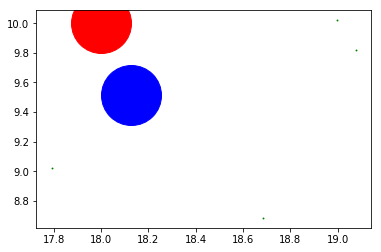

PREY :  0 :  [3.4785499905460253, 10.146718166348041]
(2.533983737897035, 9.818397295313858)
(3.3001317710858804, 11.130672910716232)
PRED :  0 :  [11, 18]
(10.870288248031134, 18.991551744187447)
(10.858479237428174, 17.010064712336664)
PREY :  0 :  [2.9570999810920506, 9.293436332696082]
(2.0125337284430604, 8.965115461661899)
(2.7786817616319057, 10.277391077064273)
PRED :  0 :  [10.640735359886062, 17.066764275028113]
(10.511023607917195, 18.05831601921556)
(10.499214597314236, 16.076828987364777)
PREY :  0 :  [2.4280307018304055, 8.444857698896266]
(1.4834644491814153, 8.116536827862083)
(2.2496124823702606, 9.428812443264457)
PRED :  0 :  [10.165396011402422, 17.94656681184143]
(10.035684259433555, 18.938118556028876)
(10.023875248830596, 16.956631524178093)
PREY :  0 :  [1.9351768680035168, 7.574745580556257]
(0.9906106153545268, 7.246424709522075)
(1.7567586485433717, 8.558700324924448)
PRED :  0 :  [10.392317535003826, 16.972653765349897]
(10.26260578303496, 17.964205509537344

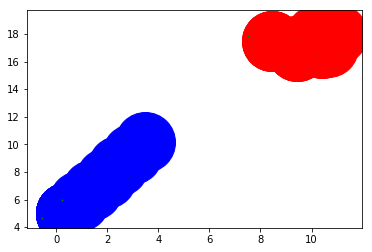

PREY :  0 :  [16.156338512267894, 12.46312450780684]
(15.192522877721132, 12.729694240903493)
(17.03787773294796, 12.935235302433258)
PRED :  0 :  [11, 7]
(11.799330082769057, 7.600892185654308)
(10.136234838324716, 7.503894577740296)
PREY :  0 :  [15.312677024535786, 11.926249015613681]
(14.348861389989022, 12.192818748710334)
(16.19421624521585, 12.398359810240098)
PRED :  0 :  [11.012085241793812, 6.000073029201239]
(11.81141532456287, 6.600965214855547)
(10.148320080118529, 6.5039676069415355)
PREY :  0 :  [14.43456301793299, 11.447797564149706]
(13.470747383386225, 11.714367297246358)
(15.316102238613052, 11.919908358776123)
PRED :  0 :  [10.189776634623671, 6.5691148155174135]
(10.98910671739273, 7.170007001171721)
(9.326011472948387, 7.07300939325771)
PREY :  0 :  [13.594081000988188, 10.90595812373179]
(12.630265366441424, 11.172527856828442)
(14.475620221668251, 11.378068918358206)
PRED :  0 :  [9.495747923776635, 7.289062138951566]
(10.295078006545694, 7.889954324605874)
(8.6

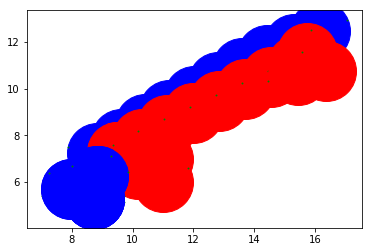

PREY :  0 :  [19.844037426526988, 2.012237034670931]
(20.619845984830864, 1.3812686671100352)
(20.6590063130523, 2.5917417490570136)
PRED :  0 :  [3.9948980679991695, 19.100885253092414]
(3.0035546358300698, 19.23217957701843)
(3.1225420954555263, 18.612014045955572)
PREY :  0 :  [19.639319673559683, 1.033415987890664]
(20.41512823186356, 0.4024476203297682)
(20.454288560084994, 1.6129207022767467)
PRED :  0 :  [4.993516517536975, 19.153432300989614]
(4.002173085367875, 19.28472662491563)
(4.121160544993332, 18.66456109385277)
PREY :  0 :  [19.387041153898338, 0.06576132401646984]
(20.162849712202213, -0.5652070435444259)
(20.202010040423648, 0.6452660384025526)
PRED :  0 :  [5.993510764670562, 19.156824306256347]
(5.002167332501463, 19.288118630182364)
(5.121154792126919, 18.667953099119504)
PREY :  0 :  [19.387041153898338, 0.06576132401646984]
(20.162849712202213, -0.5652070435444259)
(20.202010040423648, 0.6452660384025526)
PRED :  0 :  [6.9935050118041495, 19.16021631152308]
(6.00

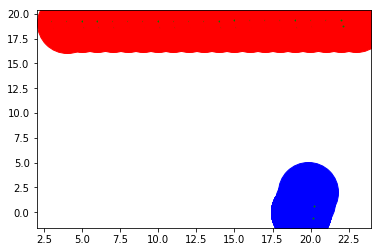

PREY :  0 :  [12, 6]
(11.981868604960649, 5.000164387254621)
(12.703904108267242, 6.710295013613709)
PRED :  0 :  [12.894427190999917, 11.447213595499958]
(13.894249654068286, 11.466056162838278)
(12.681027172540379, 12.424178503836727)
PREY :  0 :  [12, 6]
(12.030315611505404, 6.999540376222519)
(11.287491403724532, 5.298336619001987)
PRED :  0 :  [13.788854381999833, 11.894427190999917]
(14.788676845068203, 11.913269758338236)
(13.575454363540295, 12.871392099336685)
PREY :  0 :  [12, 6]
(11.086557163638629, 6.406967056037823)
(12.379187780652625, 5.074680256882122)
PRED :  0 :  [14.68328157299975, 12.341640786499875]
(15.68310403606812, 12.360483353838195)
(14.469881554540212, 13.318605694836643)
PREY :  0 :  [12, 6]
(11.880249320431, 5.007196003864427)
(12.772510644313193, 6.6350018145035605)
PRED :  0 :  [15.577708763999667, 12.788854381999833]
(16.577531227068036, 12.807696949338153)
(15.364308745540129, 13.765819290336601)
PREY :  0 :  [11.019162147545893, 6.194825838104744]
(10

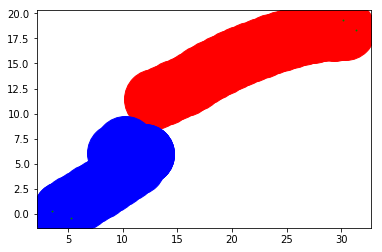

PREY :  0 :  [12.029857499854668, 11.757464374963668]
(11.710711107605054, 12.705169804047017)
(12.036981917516654, 12.75743899597811)
PRED :  0 :  [12.715157107124194, 3.698963741641692]
(12.936506450924487, 4.674158321199628)
(12.175861384106899, 2.856847287025555)
PREY :  0 :  [11.069662384462049, 11.478134211221628]
(10.750515992212435, 12.425839640304977)
(11.076786802124035, 12.47810883223607)
PRED :  0 :  [13.40934016889782, 4.418762238963403]
(13.630689512698114, 5.393956818521339)
(12.870044445880525, 3.576645784347266)
PREY :  0 :  [10.119900608018026, 11.165160461514255]
(9.80075421576841, 12.112865890597604)
(10.127025025680013, 12.165135082528696)
PRED :  0 :  [14.080913297268651, 5.159700517938255]
(14.302262641068944, 6.134895097496191)
(13.541617574251356, 4.317584063322117)
PREY :  0 :  [9.18095316668891, 10.821099852868764]
(8.861806774439295, 11.768805281952114)
(9.188077584350896, 11.821074473883206)
PRED :  0 :  [14.727866732007957, 5.922230027714116]
(14.949216075

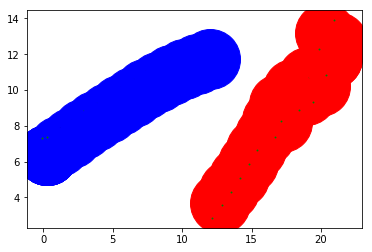

PREY :  0 :  [14.167949705662156, 10.445299803774772]
(14.359993117840707, 9.4639133723224)
(14.272784283950289, 9.450810130024887)
PRED :  0 :  [18.8048995931109, 12.593411025352502]
(18.35136453094501, 11.702172590708786)
(18.600093013993565, 11.614608560526092)
PREY :  0 :  [13.337059776928331, 9.888862991253621]
(13.529103189106882, 8.90747655980125)
(13.441894355216464, 8.894373317503737)
PRED :  0 :  [19.60818131522849, 13.189010282329708]
(19.154646253062598, 12.297771847685992)
(19.403374736111154, 12.210207817503298)
PREY :  0 :  [12.507299489950126, 9.330743052392943]
(12.699342902128677, 8.349356620940572)
(12.612134068238259, 8.33625337864306)
PRED :  0 :  [20.40970849177182, 13.78696862976076]
(19.95617342960593, 12.895730195117045)
(20.204901912654485, 12.80816616493435)
PREY :  0 :  [11.678646961455442, 8.770979721136449]
(11.870690373633993, 7.789593289684078)
(11.783481539743574, 7.776490047386566)
PRED :  0 :  [21.209314128120145, 14.387494088271882]
(20.7557790659542

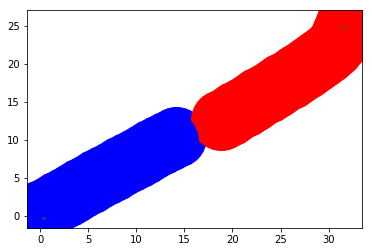

PREY :  0 :  [12.002541300169264, 15.92875295001209]
(11.500232329450935, 15.064064741502287)
(11.015674270326446, 16.090287668909347)
PRED :  0 :  [14.601794715992302, 1.79865081218499]
(13.696081792173434, 1.3747591991192452)
(13.970125588542192, 1.0234127110661027)
PREY :  0 :  [11.010042712054949, 15.806496855721905]
(10.507733741336619, 14.941808647212103)
(10.02317568221213, 15.968031574619161)
PRED :  0 :  [15.173356519687234, 2.6192098317301995]
(14.267643595868368, 2.195318218664455)
(14.541687392237126, 1.8439717306113121)
PREY :  0 :  [10.024616476464296, 15.636393551198937]
(9.522307505745966, 14.771705342689135)
(9.037749446621477, 15.797928270096193)
PRED :  0 :  [15.713071754625933, 3.461057481352782]
(14.807358830807065, 3.037165868287037)
(15.081402627175823, 2.6858193802338945)
PREY :  0 :  [9.048026579219057, 15.421283875455295]
(8.545717608500727, 14.556595666945492)
(8.061159549376239, 15.58281859435255)
PRED :  0 :  [16.21912270540484, 4.323561066977655]
(15.31340

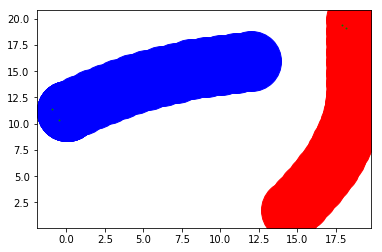

PREY :  0 :  [2.2704627958599146, 11.31605887111867]
(2.7918426418536697, 10.462734163758379)
(1.3511503553632824, 10.922530426469333)
PRED :  0 :  [16.495156473506725, 14.131196186274265]
(16.464828901232718, 15.130736199660404)
(16.97678401460574, 15.00757219670296)
PREY :  0 :  [1.5110353900000417, 10.665466821344816]
(2.0324152359937973, 9.812142113984525)
(0.5917229495034096, 10.271938376695479)
PRED :  0 :  [16.710966017144536, 15.107631663341152]
(16.680638444870528, 16.107171676727294)
(17.19259355824355, 15.984007673769849)
PREY :  0 :  [0.7692387689566187, 9.994841909036483]
(1.290618614950374, 9.14151720167619)
(-0.1500736715400134, 9.601313464387145)
PRED :  0 :  [17.28410831942348, 15.927087520198855]
(17.253780747149474, 16.926627533584995)
(17.765735860522497, 16.80346353062755)
PREY :  0 :  [0.03385299538193154, 9.317193206518755]
(0.5552328413756868, 8.463868499158464)
(-0.8854594451147005, 8.923664761869418)
PRED :  0 :  [17.060000107412165, 14.952523253816647]
(17.02

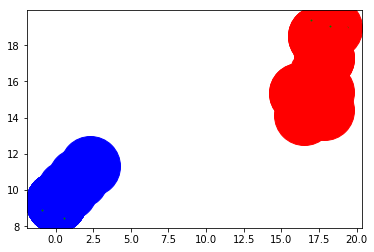

PREY :  0 :  [3.051316701949486, 7.683772233983162]
(2.1463368866614307, 7.258317731220297)
(3.1523355937243083, 8.678656741604316)
PRED :  0 :  [15.369075486853564, 5.929399421671762]
(14.528384849673536, 6.470915120943573)
(14.618940814360961, 6.590684513840348)
PREY :  0 :  [2.118342102634199, 7.32383002052039]
(1.2133622873461438, 6.8983755177575246)
(2.2193609944090213, 8.318714528141545)
PRED :  0 :  [15.64692612870577, 6.890023708696776]
(14.806235491525742, 7.431539407968588)
(14.896791456213167, 7.551308800865362)
PREY :  0 :  [1.2031430277058561, 6.920827969346571]
(0.29816321241780075, 6.495373466583706)
(1.3041619194806784, 7.915712476967725)
PRED :  0 :  [15.818201084803231, 7.875246977511421]
(14.977510447623203, 8.416762676783232)
(15.068066412310628, 8.536532069680007)
PREY :  0 :  [0.3079508061833034, 6.475147717904445]
(-0.597029009104752, 6.04969321514158)
(0.40896969795812577, 7.4700322255256)
PRED :  0 :  [15.865706275477335, 8.87411796861038]
(15.025015638297306, 

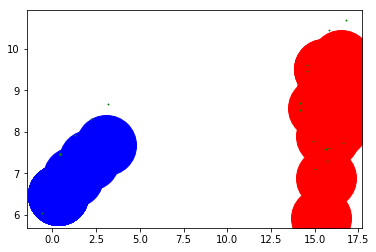

PREY :  0 :  [12.142507074287456, 12.485504244572473]
(13.035836935420111, 12.934905801321793)
(12.765730334521, 11.703460276560525)
PRED :  0 :  [20.93467562294742, 12.355501729767731]
(20.23491268858972, 11.64112659323294)
(21.78960109775206, 12.874252568350244)
PREY :  0 :  [11.28131061720635, 11.97723201209174]
(12.174640478339004, 12.42663356884106)
(11.904533877439894, 11.195188044079792)
PRED :  0 :  [21.834711272375227, 11.919685449944382]
(21.134948338017526, 11.20531031340959)
(22.68963674717987, 12.438436288526894)
PREY :  0 :  [10.4035814316671, 11.498074963878313]
(11.296911292799754, 11.947476520627633)
(11.026804691900644, 10.716030995866365)
PRED :  0 :  [22.109046981089456, 10.958051466079283]
(21.409284046731756, 10.243676329544492)
(22.963972455894098, 11.476802304661796)
PREY :  0 :  [9.507595869003362, 11.053991783046]
(10.400925730136017, 11.50339333979532)
(10.130819129236906, 10.271947815034052)
PRED :  0 :  [22.109046981089456, 10.958051466079283]
(21.991182977

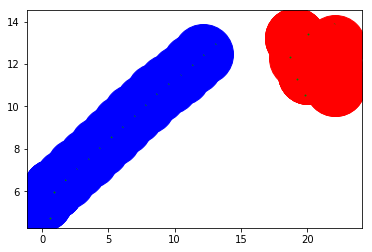

PREY :  0 :  [20, 1]
(19.15598246120461, 1.536315573338841)
(20.998456501145252, 1.0555393132905075)
PRED :  0 :  [15.138090421954791, 1.009580374101791]
(15.255859940566923, 2.0026213301987017)
(14.233917944013331, 1.4367479409104145)
PREY :  0 :  [20, 1]
(19.352485905117447, 0.23794652620145595)
(20.192608773000863, 1.9812756292515892)
PRED :  0 :  [15.908825403746768, 0.37242451574206425]
(16.0265949223589, 1.365465471838975)
(15.004652925805308, 0.7995920825506876)
PREY :  0 :  [20, 1]
(20.43169674214129, 0.09798119596951038)
(19.18260712343348, 1.5760806239913898)
PRED :  0 :  [15.908825403746768, 0.37242451574206425]
(16.0265949223589, 1.365465471838975)
(15.004652925805308, 0.7995920825506876)
PREY :  0 :  [20, 1]
(19.484571541695964, 0.1430673863305687)
(20.031004820626656, 1.9995192349814528)
PRED :  0 :  [15.908825403746768, 0.37242451574206425]
(16.0265949223589, 1.365465471838975)
(15.004652925805308, 0.7995920825506876)
PREY :  0 :  [20, 1]
(20.89448596441217, 1.4470960293

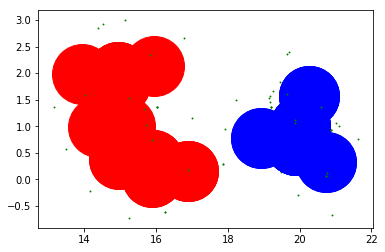

PREY :  0 :  [3.1055728090000843, 1.5527864045000421]
(2.1066539069449335, 1.5062995556400434)
(2.4065934065050447, 2.2679282050456946)
PRED :  0 :  [15.971719921821746, 8.999600038604557]
(14.978413354527042, 8.884092188788143)
(16.109762984726284, 8.009173810769322)
PREY :  0 :  [2.234358960040076, 1.061882718039767]
(1.2354400579849254, 1.0153958691797682)
(1.5353795575450369, 1.7770245185854194)
PRED :  0 :  [15.971719921821746, 8.999600038604557]
(15.526990194333763, 8.103935218770449)
(16.877256560387668, 8.575331967434066)
PREY :  0 :  [1.772700678093333, 0.17482486721492863]
(0.7737817760381823, 0.12833801835492992)
(1.0737212755982937, 0.8899666677605811)
PRED :  0 :  [16.966892095243566, 9.097744550661488]
(16.522162367755584, 8.20207973082738)
(17.87242873380949, 8.673476479490997)
PREY :  0 :  [1.772700678093333, 0.17482486721492863]
(0.7737817760381823, 0.12833801835492992)
(1.0737212755982937, 0.8899666677605811)
PRED :  0 :  [17.962064268665383, 9.19588906271842]
(17.517

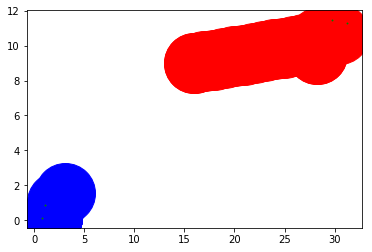

PREY :  0 :  [12.82261057858615, 3.4313948329480657]
(12.312140060963682, 2.571499577327796)
(13.741352642962498, 3.0365366063078114)
PRED :  0 :  [14.96600889728316, 5.258508820680787]
(15.807006148862646, 5.799548211886041)
(14.088927646254765, 5.738850864535441)
PREY :  0 :  [12.82261057858615, 3.4313948329480657]
(13.590410288669121, 4.072084777614366)
(12.087917006977728, 4.109793945445466)
PRED :  0 :  [15.93201779456632, 5.517017641361575]
(16.773015046145805, 6.058057032566828)
(15.054936543537925, 5.997359685216228)
PREY :  0 :  [11.849330139687538, 3.201775175128171]
(12.617129849770508, 3.842465119794472)
(11.114636568079115, 3.8801742876255707)
PRED :  0 :  [16.89739650401643, 5.7778699891379315]
(17.738393755595915, 6.318909380343185)
(16.020315252988034, 6.258212032992585)
PREY :  0 :  [11.554868332049827, 4.157438423266725]
(12.322668042132797, 4.7981283679330256)
(10.820174760441404, 4.835837535764124)
PRED :  0 :  [15.90557374716084, 5.905492945471721]
(16.746570998740

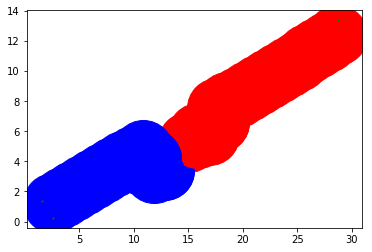

PREY :  0 :  [17, 20]
(17.891368019372177, 19.546719673887644)
(16.361588131437582, 20.769694930526793)
PRED :  0 :  [6.647648420095541, 8.76193931775946]
(6.226267091619074, 7.855055766242834)
(7.20308137797116, 9.593500637991191)
PREY :  0 :  [17, 20]
(16.608492137996162, 19.079825237256973)
(17.7244187420216, 20.689360200626524)
PRED :  0 :  [7.295296840191082, 9.523878635518919]
(6.873915511714615, 8.616995084002294)
(7.850729798066701, 10.35543995575065)
PREY :  0 :  [17, 20]
(16.49564542886114, 19.13650334883606)
(17.805521780767037, 20.592566165681014)
PRED :  0 :  [7.942945260286622, 10.285817953278379]
(7.521563931810156, 9.378934401761754)
(8.498378218162241, 11.11737927351011)
PREY :  0 :  [17, 20]
(17.469807837534617, 20.882768710246943)
(16.2185450441334, 19.376038340960335)
PRED :  0 :  [8.590593680382163, 11.047757271037838]
(8.169212351905697, 10.140873719521213)
(9.146026638257782, 11.87931859126957)
PREY :  0 :  [16.149723273257308, 19.473664092085922]
(16.61953111079

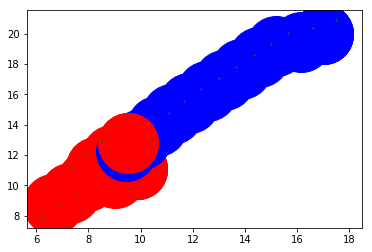

PREY :  0 :  [12.589635322671201, 2.088078494824894]
(12.425623571924064, 1.1016201096829463)
(13.565851365622033, 1.8712785006242008)
PRED :  0 :  [9.986523153727777, 20.163621719704327]
(10.126836224029471, 19.173514532424832)
(10.512491593402917, 19.3131176336085)
PREY :  0 :  [12.145812767601422, 1.191963803721499]
(11.981801016854284, 0.2055054185795515)
(13.122028810552253, 0.975163809520806)
PRED :  0 :  [10.981742143097646, 20.26129035949017]
(11.12205521339934, 19.271183172210677)
(11.507710582772786, 19.410786273394343)
PREY :  0 :  [11.669298939526561, 0.3127968277417128]
(11.505287188779423, -0.6736615574002347)
(12.645514982477392, 0.09599683354101979)
PRED :  0 :  [11.981383079651112, 20.288085843559532]
(12.121696149952806, 19.297978656280037)
(12.507351519326251, 19.437581757463704)
PREY :  0 :  [11.669298939526561, 0.3127968277417128]
(11.505287188779423, -0.6736615574002347)
(12.645514982477392, 0.09599683354101979)
PRED :  0 :  [12.981024016204577, 20.314881327628893

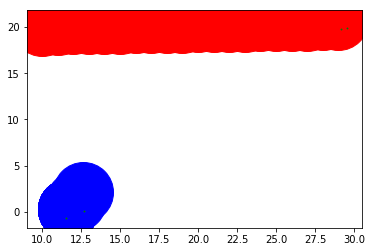

PREY :  0 :  [7.105572809000084, 3.552786404500042]
(6.165259461430354, 3.212476533379313)
(8.078777398832298, 3.7827273237152017)
PRED :  0 :  [10.894427190999917, 5.447213595499958]
(11.704948790534154, 6.032922342821068)
(11.187722199430645, 4.491191609335614)
PREY :  0 :  [6.2111456180001685, 3.1055728090000843]
(5.2708322704304384, 2.765262937879355)
(7.184350207832383, 3.335513728215244)
PRED :  0 :  [11.788854381999833, 5.894427190999917]
(12.59937598153407, 6.480135938321026)
(12.082149390430562, 4.938405204835572)
PREY :  0 :  [5.316718427000253, 2.6583592135001264]
(4.376405079430523, 2.318049342379397)
(6.289923016832466, 2.888300132715286)
PRED :  0 :  [12.68328157299975, 6.341640786499875]
(13.493803172533987, 6.927349533820984)
(12.976576581430479, 5.38561880033553)
PREY :  0 :  [4.422291236000337, 2.2111456180001685]
(3.481977888430607, 1.870835746879439)
(5.395495825832551, 2.441086537215328)
PRED :  0 :  [13.577708763999667, 6.788854381999833]
(14.388230363533903, 7.37

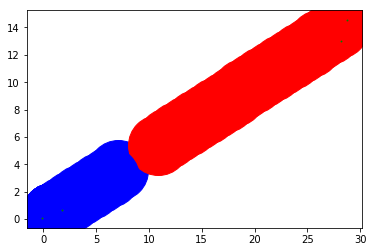

PREY :  0 :  [3, 4]
(3.2905685209426343, 4.956854186716665)
(2.193068618912827, 4.59064519486469)
PRED :  0 :  [1.6, 8.8]
(0.6024502332080907, 8.869960437201373)
(0.6353587864002113, 8.536433444791024)
PREY :  0 :  [3, 4]
(2.4009909570907784, 4.800742259727173)
(2.9981457747132287, 4.999998280922815)
PRED :  0 :  [2.2, 9.600000000000001]
(1.2024502332080909, 9.669960437201373)
(1.2353587864002114, 9.336433444791025)
PREY :  0 :  [3, 4]
(2.0365745342224137, 4.2679764390599315)
(3.609466169782301, 4.792812076024887)
PRED :  0 :  [2.8000000000000003, 10.400000000000002]
(1.802450233208091, 10.469960437201374)
(1.8353587864002114, 10.136433444791026)
PREY :  0 :  [3, 4]
(3.508476384987304, 4.861075935043038)
(2.076337060796042, 4.383205916892088)
PRED :  0 :  [3.4000000000000004, 11.200000000000003]
(2.402450233208091, 11.269960437201375)
(2.4353587864002115, 10.936433444791026)
PREY :  0 :  [3, 4]
(2.0122329464755198, 4.155936679365589)
(3.6962095037238987, 4.7178386496452545)
PRED :  0 :

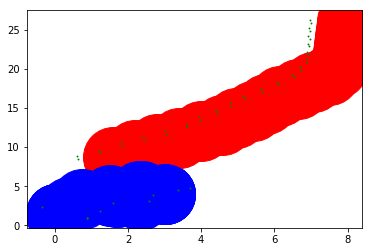

PREY :  0 :  [1.2928932188134523, 6.292893218813452]
(1.1009652057206165, 7.274302225186553)
(1.7532670527489524, 7.180618363792194)
PRED :  0 :  [18.772757622635496, 17.36529876582857]
(17.836218013742908, 17.715860544942203)
(17.840820419891216, 17.72791847039682)
PREY :  0 :  [0.5588034859955913, 5.613840743542651]
(0.3668754729027556, 6.595249749915752)
(1.0191773199310914, 6.501565888521393)
PRED :  0 :  [18.772757622635496, 17.36529876582857]
(19.62504616620287, 16.842226841038297)
(19.618224334901107, 16.83127064067899)
PREY :  0 :  [0.5588034859955913, 5.613840743542651]
(0.3668754729027556, 6.595249749915752)
(1.0191773199310914, 6.501565888521393)
PRED :  0 :  [19.1937763921439, 16.458246840235756]
(20.046064935711275, 15.935174915445483)
(20.03924310440951, 15.924218715086175)
PREY :  0 :  [0.5588034859955913, 5.613840743542651]
(0.3668754729027556, 6.595249749915752)
(1.0191773199310914, 6.501565888521393)
PRED :  0 :  [20.030406775801367, 15.91047900516221]
(20.88269531936

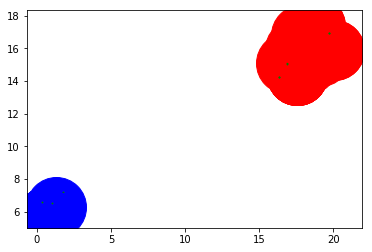

PREY :  0 :  [1.035236178762268, 6.736882594207891]
(1.6982916658684735, 7.485452845432419)
(0.8118395151977911, 5.762154975481378)
PRED :  0 :  [11.151884149364145, 3.988398302898143]
(10.168081210754133, 4.167651693332759)
(12.017143733251714, 4.489722402150026)
PREY :  0 :  [0.09364365726180279, 6.400128197867775]
(0.7566991443680084, 7.1486984490923025)
(-0.1297530063026741, 5.425400579141261)
PRED :  0 :  [11.16651411180913, 4.988291279270544]
(10.182711173199118, 5.16754466970516)
(12.0317736956967, 5.489615378522426)
PREY :  0 :  [0.09364365726180279, 6.400128197867775]
(0.7566991443680084, 7.1486984490923025)
(-0.1297530063026741, 5.425400579141261)
PRED :  0 :  [11.181144074254115, 5.9881842556429445]
(10.197341135644104, 6.167437646077561)
(12.046403658141685, 6.489508354894827)
PREY :  0 :  [0.09364365726180279, 6.400128197867775]
(0.7566991443680084, 7.1486984490923025)
(-0.1297530063026741, 5.425400579141261)
PRED :  0 :  [11.181144074254115, 5.9881842556429445]
(11.386258

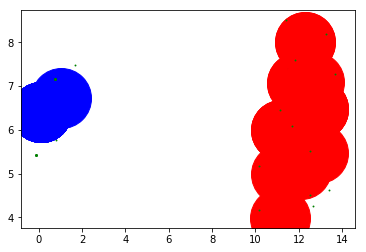

PREY :  0 :  [1.9334809894762264, 15.002214842143392]
(0.961622924376744, 15.237782032772923)
(0.9864522772364088, 15.323363745603132)
PRED :  0 :  [1.387748310692877, 15.921765288755669]
(2.3869919859879025, 15.960650727969977)
(1.729076563393607, 14.981821128760902)
PREY :  0 :  [1.8466497363183128, 14.005991808141957]
(0.8747916712188304, 14.241558998771488)
(0.8996210240784952, 14.327140711601697)
PRED :  0 :  [1.3211437643919446, 16.919544740544513]
(2.32038743968697, 16.95843017975882)
(1.6624720170926746, 15.979600580549747)
PREY :  0 :  [1.768802811905171, 13.00902648459283]
(0.7969447468056887, 13.244593675222362)
(0.8217740996653535, 13.33017538805257)
PRED :  0 :  [1.3211437643919446, 16.919544740544513]
(1.24939357199096, 17.91696737408078)
(0.349243399823553, 16.684152129462884)
PREY :  0 :  [1.768802811905171, 13.00902648459283]
(1.1847892818740515, 12.197282561461533)
(1.1148447501293508, 12.252495683211675)
PRED :  0 :  [1.45587145070302, 17.91042740289221]
(1.384121258

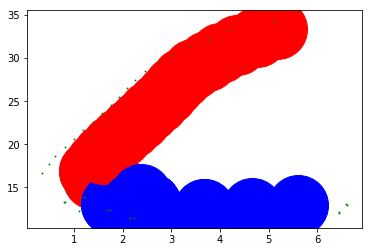

PREY :  0 :  [0.23806068224054056, 3.3523515799044596]
(-0.4449886860836776, 4.082723786681173)
(0.21942016355300847, 4.352177830341534)
PRED :  0 :  [20, 17]
(19.33685386471808, 17.748489948670425)
(19.131014996555315, 16.505161578100243)
PREY :  0 :  [0.23806068224054056, 3.3523515799044596]
(-0.4449886860836776, 4.082723786681173)
(0.21942016355300847, 4.352177830341534)
PRED :  0 :  [20, 17]
(20.615325664173362, 16.211726997157957)
(20.89807037810486, 17.4398517886409)
PREY :  0 :  [0.23806068224054056, 3.3523515799044596]
(-0.4449886860836776, 4.082723786681173)
(0.21942016355300847, 4.352177830341534)
PRED :  0 :  [19.05663062569419, 16.668255785850203]
(19.671956289867552, 15.87998278300816)
(19.954701003799048, 17.108107574491104)
PREY :  0 :  [0.23806068224054056, 3.3523515799044596]
(-0.4449886860836776, 4.082723786681173)
(0.21942016355300847, 4.352177830341534)
PRED :  0 :  [19.66060720177297, 15.871253718382274]
(20.27593286594633, 15.08298071554023)
(20.558677579877827, 1

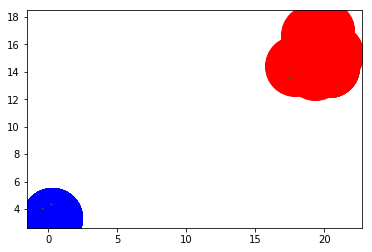

In [102]:
simulation = [(eye_pair_pair[0], eye_pair_pair[1], simulation_control(Grid, Animal, eye_pair_pair[0], eye_pair_pair[1]).start_sim())  for eye_pair_pair in zip(prey_population, pred_population)]

PREY :  0 :  [15.35981560033552, 2.231778720402624]
(14.393436414327397, 2.4888998374861475)
(15.78755385280167, 3.1356813630457374)
PRED :  0 :  [15.989608235581228, 18.143789916439957]
(16.453379712168573, 19.029744778441398)
(15.846039926363131, 17.154149506701017)
PREY :  0 :  [14.69865019116377, 1.4815385577115334]
(13.732271005155647, 1.738659674795057)
(15.12638844362992, 2.385441200354647)
PRED :  0 :  [16.984566881842117, 18.24407596846466]
(17.448338358429464, 19.1300308304661)
(16.84099857262402, 17.25443555872572)
PREY :  0 :  [14.017259535317427, 0.7496186344102951]
(13.050880349309304, 1.0067397514938186)
(14.444997787783578, 1.6535212770534082)
PRED :  0 :  [17.98313997965063, 18.297477919113575]
(18.446911456237977, 19.183432781115016)
(17.839571670432534, 17.307837509374636)
PREY :  0 :  [13.316305487716903, 0.036412196446893974]
(12.34992630170878, 0.29353331353041745)
(13.744043740183054, 0.9403148390900071)
PRED :  0 :  [18.983136241181285, 18.300212315703877]
(19.4

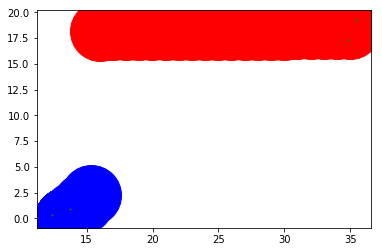

PREY :  0 :  [12.889568473925154, 17.00611626532638]
(13.471155360568153, 17.819600557298205)
(12.206727181480456, 17.73668301062242)
PRED :  0 :  [2.604040697910175, 18.796953471206564]
(2.085857359456461, 17.94168390682995)
(2.1168895648259816, 19.670271153115493)
PREY :  0 :  [12.75234377249168, 16.015576320994757]
(13.333930659134678, 16.829060612966583)
(12.069502480046982, 16.7461430662908)
PRED :  0 :  [3.2269435557783472, 19.57925266567097]
(2.7087602173246337, 18.72398310129436)
(2.739792422694154, 20.4525703475799)
PREY :  0 :  [12.589723229981962, 15.028887636984525]
(13.17131011662496, 15.842371928956352)
(11.906881937537264, 15.759454382280568)
PRED :  0 :  [3.8691020548287893, 20.3458245553834]
(3.3509187163750758, 19.490554991006785)
(3.381950921744596, 21.219142237292328)
PREY :  0 :  [12.402904353065242, 14.046493262393762]
(12.984491239708241, 14.859977554365589)
(11.720063060620543, 14.777060007689805)
PRED :  0 :  [4.530991887678795, 21.09542568209666]
(4.0128085492

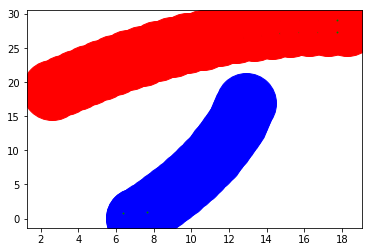

PREY :  0 :  [8.92875295001209, 2.002541300169265]
(9.927504741819462, 2.052489857321223)
(9.482129110318045, 1.1696098352785231)
PRED :  0 :  [1.9757599694663628, 14.21884351026933]
(2.4800791512225024, 13.355326189706032)
(2.9106619645383818, 14.573749497272027)
PREY :  0 :  [8.791121664209712, 1.0120577671570374]
(9.789873456017084, 1.0620063243089954)
(9.344497824515667, 0.17912630226629578)
PRED :  0 :  [2.9691984990539972, 14.333210847961341]
(3.473517680810137, 13.469693527398043)
(3.9041004941260162, 14.688116834964038)
PREY :  0 :  [8.588273235207103, 0.03284761869493458]
(9.587025027014475, 0.08279617584689264)
(9.14164939551306, -0.8000838461958071)
PRED :  0 :  [3.969191184946907, 14.337035525815008]
(4.473510366703047, 13.47351820525171)
(4.9040931800189265, 14.691941512817705)
PREY :  0 :  [8.588273235207103, 0.03284761869493458]
(9.587025027014475, 0.08279617584689264)
(9.14164939551306, -0.8000838461958071)
PRED :  0 :  [4.969183870839817, 14.340860203668674]
(5.4735030

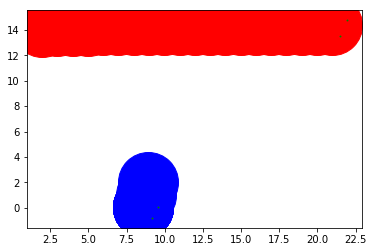

PREY :  0 :  [17.00611626532638, 12.889568473925154]
(17.789441361099353, 12.267956219917671)
(16.690853539623202, 11.940564040962798)
PRED :  0 :  [18.796953471206564, 2.604040697910175]
(17.95934015114949, 3.1503043028327147)
(18.93001548341949, 3.595148411988643)
PREY :  0 :  [16.015576320994757, 12.75234377249168]
(16.79890141676773, 12.130731518484197)
(15.700313595291577, 11.803339339529323)
PRED :  0 :  [19.57925266567097, 3.2269435557783472]
(18.741639345613898, 3.773207160700887)
(19.712314677883896, 4.218051269856816)
PREY :  0 :  [15.028887636984525, 12.589723229981962]
(15.812212732757498, 11.96811097597448)
(14.713624911281345, 11.640718797019606)
PRED :  0 :  [20.3458245553834, 3.8691020548287893]
(19.508211235326325, 4.415365659751329)
(20.478886567596323, 4.860209768907258)
PREY :  0 :  [14.046493262393762, 12.40290435306524]
(14.829818358166735, 11.781292099057758)
(13.731230536690582, 11.453899920102884)
PRED :  0 :  [21.09542568209666, 4.530991887678795]
(20.25781236

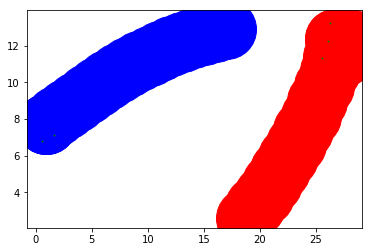

PREY :  0 :  [6.226042700796679, 1.3667622097427374]
(5.512678621975039, 0.6659685945842136)
(5.30281150671892, 0.9825172848813206)
PRED :  0 :  [11.97674204630691, 9.21441775807099]
(11.75854460918036, 8.238513111893196)
(12.223764089728562, 10.18342761873485)
PREY :  0 :  [5.43346794144387, 0.7569874555614602]
(4.72010386262223, 0.0561938404029364)
(4.510236747366111, 0.3727425307000433)
PRED :  0 :  [12.967176131625333, 9.35240443365765]
(12.748978694498783, 8.376499787479856)
(13.214198175046985, 10.32141429432151)
PREY :  0 :  [4.622409524818541, 0.17202229008473335]
(3.909045445996901, -0.5287713250737904)
(3.699178330740782, -0.21222263477668352)
PRED :  0 :  [13.966484377438967, 9.389593542935494]
(13.748286940312417, 8.4136888967577)
(14.213506420860618, 10.358603403599353)
PREY :  0 :  [4.622409524818541, 0.17202229008473335]
(3.909045445996901, -0.5287713250737904)
(3.699178330740782, -0.21222263477668352)
PRED :  0 :  [14.9657926232526, 9.426782652213337]
(14.74759518612605

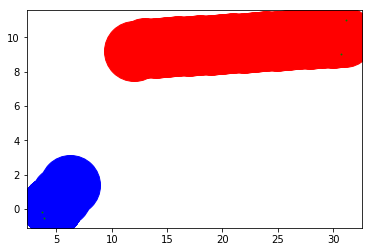

PREY :  0 :  [5.475902574335665, 11.148341683295456]
(4.487759894835571, 11.301880098522313)
(6.3761922147679115, 10.713050328763373)
PRED :  0 :  [7.608519143161392, 13.920186252195125]
(6.610299028188399, 13.979823506183742)
(6.99804604116588, 14.71222324106621)
PREY :  0 :  [5.475902574335665, 11.148341683295456]
(6.457752562866545, 10.9586825152547)
(4.592175250140426, 11.616343837639562)
PRED :  0 :  [8.049392162232113, 14.817755737558496]
(7.0511720472591195, 14.877392991547113)
(7.4389190602366, 15.609792726429582)
PREY :  0 :  [5.599860211468822, 12.140629194149223]
(6.581710199999701, 11.950970026108468)
(4.716132887273583, 12.60863134849333)
PRED :  0 :  [8.46823407834021, 15.725814903753573]
(7.470013963367216, 15.78545215774219)
(7.8577609763446965, 16.51785189262466)
PREY :  0 :  [5.125739225297314, 11.260169490090169]
(6.107589213828194, 11.070510322049413)
(4.242011901102075, 11.728171644434275)
PRED :  0 :  [8.882538052526234, 16.635953473957947]
(7.884317937553241, 16.

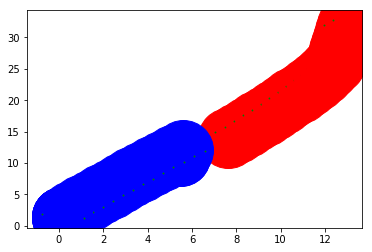

PREY :  0 :  [7.832220778726278, 0.44555561554270506]
(7.432816910529207, -0.47121946596268627)
(8.227645757689187, 1.3640538931742874)
PRED :  0 :  [17.99838582182435, 5.056795693323701]
(17.59445593348003, 5.971585639323408)
(17.510149698934228, 4.1840841210930915)
PREY :  0 :  [6.869496678283313, 0.1750702990719496]
(6.470092810086242, -0.7417047824334417)
(7.264921657246221, 1.093568576703532)
PRED :  0 :  [18.998061232953507, 5.082272592345215]
(18.59413134460919, 5.997062538344922)
(18.509825110063385, 4.209561020114606)
PREY :  0 :  [6.869496678283313, 0.1750702990719496]
(6.470092810086242, -0.7417047824334417)
(7.264921657246221, 1.093568576703532)
PRED :  0 :  [19.997736644082664, 5.10774949136673]
(19.593806755738346, 6.0225394373664365)
(19.509500521192543, 4.23503791913612)
PREY :  0 :  [6.869496678283313, 0.1750702990719496]
(6.470092810086242, -0.7417047824334417)
(7.264921657246221, 1.093568576703532)
PRED :  0 :  [20.99741205521182, 5.133226390388244]
(20.5934821668675

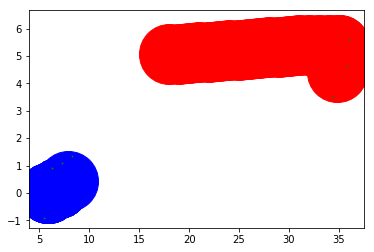

PREY :  0 :  [8.374470307746748, 6.219799638484093]
(7.411994270145374, 5.948432954745728)
(9.310046635842397, 6.572924169361035)
PRED :  0 :  [2.8028005378955565, 6.596247680376709]
(1.944635403087929, 7.109621424739046)
(3.748614030139599, 6.920958071169994)
PREY :  0 :  [9.036732822850183, 5.470527751190254]
(8.074256785248808, 5.199161067451889)
(9.972309150945833, 5.823652282067195)
PRED :  0 :  [3.658261770178571, 7.114114535910856]
(2.8000966353709433, 7.627488280273194)
(4.604075262422613, 7.438824926704141)
PREY :  0 :  [9.036732822850183, 5.470527751190254]
(8.186082101647784, 5.996259004320443)
(9.929440207732036, 5.9211645505946136)
PRED :  0 :  [4.513723002461586, 7.631981391445003]
(3.6555578676539584, 8.14535513580734)
(5.459536494705629, 7.9566917822382885)
PREY :  0 :  [9.872264820015545, 4.921085960176081]
(9.021614098813146, 5.44681721330627)
(10.764972204897397, 5.37172275958044)
PRED :  0 :  [5.408695143359003, 8.07810342297617]
(4.550530008551375, 8.59147716733850

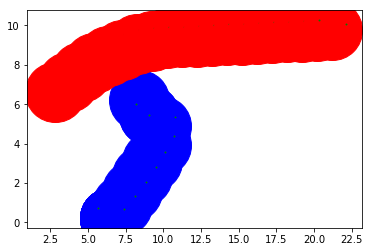

PREY :  0 :  [7.131756857875541, 19.503861061643168]
(6.341910485820134, 20.117165805266524)
(7.43348793652004, 20.457254137021852)
PRED :  0 :  [7.343420055487278, 4.939181912884354]
(6.343943195475417, 4.971523933551438)
(7.998287490075415, 5.694925681046522)
PREY :  0 :  [6.3019857143789215, 18.94575726357303]
(5.512139342323515, 19.559062007196385)
(6.603716793023421, 19.899150338951713)
PRED :  0 :  [7.659049751930626, 5.888064358039221]
(6.6595728919187644, 5.920406378706305)
(8.313917186518763, 6.643808126201389)
PREY :  0 :  [5.5091860546842835, 18.33627494259229]
(4.719339682628877, 18.949579686215646)
(5.810917133328783, 19.289668017970975)
PRED :  0 :  [7.946795499867605, 6.845771194468924]
(6.947318639855744, 6.878113215136008)
(8.601662934455742, 7.601514962631091)
PREY :  0 :  [4.751544421402183, 17.68360415611749]
(3.9616980493467766, 18.296908899740846)
(5.0532755000466825, 18.636997231496174)
PRED :  0 :  [8.206288959757265, 7.811516059469247]
(7.206812099745403, 7.843

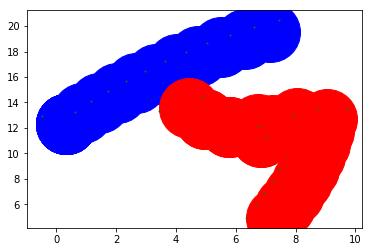

PREY :  0 :  [11.06165688318289, 6.654294641172644]
(10.068963445514726, 6.774958383906582)
(11.880808306498185, 6.080717317980273)
PRED :  0 :  [19.779377338656282, 6.373445162823673]
(20.208354433046427, 7.276760529951117)
(19.067773018079038, 5.670864711248341)
PREY :  0 :  [10.109849907028588, 6.34759693960968]
(9.117156469360424, 6.468260682343618)
(10.929001330343883, 5.774019616417309)
PRED :  0 :  [19.249021440458204, 5.525670062194673]
(19.67799853484835, 6.428985429322117)
(18.53741711988096, 4.823089610619341)
PREY :  0 :  [9.148668984607173, 6.071678048677724]
(8.15597554693901, 6.192341791411662)
(9.967820407922469, 5.498100725485354)
PRED :  0 :  [19.249021440458204, 5.525670062194673]
(18.296695185312533, 5.220588591501646)
(19.22339102527786, 6.525341549143103)
PREY :  0 :  [8.18748806218576, 5.795759157745769]
(7.194794624517597, 5.916422900479707)
(9.006639485501056, 5.222181834553398)
PRED :  0 :  [19.249021440458204, 5.525670062194673]
(18.987444111725175, 4.5604875

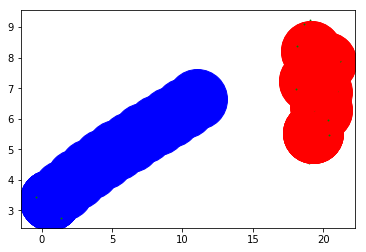

PREY :  0 :  [9.125842723878462, 16.51435706882137]
(9.6017213247578, 17.393868045003657)
(9.331587408297896, 17.49296277329746)
PRED :  0 :  [18.483665304035522, 10.875253034083416]
(17.69160882089464, 10.264805225082108)
(17.502676467345346, 11.069317204628252)
PREY :  0 :  [8.26395963592439, 16.007250036037604]
(8.73983823680373, 16.886761012219893)
(8.469704320343824, 16.985855740513696)
PRED :  0 :  [18.942402602556896, 11.763824973177439]
(18.150346119416014, 11.153377164176131)
(17.96141376586672, 11.957889143722275)
PREY :  0 :  [7.4144495400575465, 15.479677674156974]
(7.8903281409368855, 16.359188650339263)
(7.620194224476982, 16.458283378633066)
PRED :  0 :  [19.37438555591251, 12.665706743705128]
(18.58232907277163, 12.05525893470382)
(18.393396719222334, 12.859770914249964)
PREY :  0 :  [6.5774371723073575, 14.932493704880441]
(7.0533157731866964, 15.81200468106273)
(6.7831818567267925, 15.911099409356533)
PRED :  0 :  [19.77749074218044, 13.580860396816941]
(18.9854342590

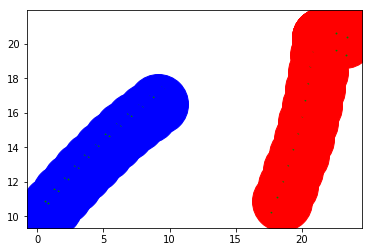

PREY :  0 :  [1.0171278130656782, 10.815711464949814]
(1.806798110472794, 11.429242899672564)
(1.9252764419172905, 11.234359369417204)
PRED :  0 :  [16.093628585859037, 3.995607195589725]
(16.96084111392105, 3.4976690155188495)
(16.857750545464814, 4.640678998452188)
PREY :  0 :  [0.04659212730174278, 10.574754035807802]
(0.8362624247088585, 11.188285470530552)
(0.9547407561533551, 10.993401940275191)
PRED :  0 :  [16.09803452049473, 4.995597489412613]
(16.96524704855674, 4.497659309341738)
(16.862156480100506, 5.640669292275076)
PREY :  0 :  [0.04659212730174278, 10.574754035807802]
(0.8362624247088585, 11.188285470530552)
(0.9547407561533551, 10.993401940275191)
PRED :  0 :  [16.10244045513042, 5.995587783235501]
(16.969652983192432, 5.497649603164626)
(16.866562414736197, 6.640659586097964)
PREY :  0 :  [0.04659212730174278, 10.574754035807802]
(0.8362624247088585, 11.188285470530552)
(0.9547407561533551, 10.993401940275191)
PRED :  0 :  [16.106846389766112, 6.995578077058389]
(16.9

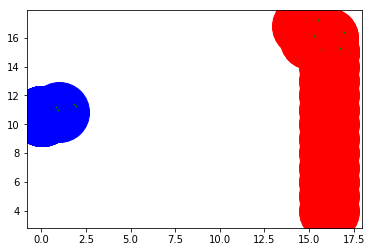

PREY :  0 :  [3.240743397634703, 6.349208626544032]
(4.049025607695381, 6.938003895631197)
(4.239458406059834, 6.399887339495251)
PRED :  0 :  [7, 6]
(6.0995602713323525, 5.565019201530764)
(7.804248289724573, 5.405706563661435)
PREY :  0 :  [2.481486795269406, 5.6984172530880635]
(3.289769005330083, 6.287212522175229)
(3.4802018036945364, 5.749095966039283)
PRED :  0 :  [7, 6]
(6.005131324288339, 6.101174690944549)
(7.373746019519525, 5.072468915403203)
PREY :  0 :  [1.7222301929041095, 5.047625879632095]
(2.5305124029647867, 5.63642114871926)
(2.72094520132924, 5.098304592583315)
PRED :  0 :  [7, 6]
(7.939151748149449, 6.343502538488195)
(6.258679066676027, 6.671150708720234)
PREY :  0 :  [0.9629735905388128, 4.396834506176127]
(1.7712558005994898, 4.985629775263292)
(1.961688598963943, 4.447513219127346)
PRED :  0 :  [7.02154026411701, 6.999767981594615]
(7.960692012266459, 7.34327052008281)
(6.280219330793036, 7.670918690314849)
PREY :  0 :  [0.25476966799607914, 3.690826571309184]

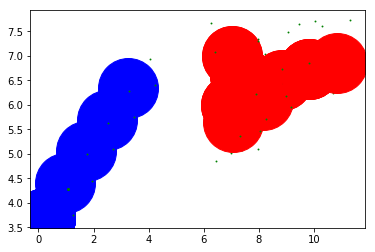

PREY :  0 :  [14, 4]
(13.017905977846018, 3.811608568004241)
(14.199583095233484, 4.979880905057866)
PRED :  0 :  [18.961523947640824, 10.274721127897378]
(18.037096190734246, 9.893363917056053)
(19.757193193289044, 10.88045246399416)
PREY :  0 :  [13.005132943253608, 3.8988093907480934]
(12.023038921099626, 3.7104179587523345)
(13.204716038487092, 4.878690295805959)
PRED :  0 :  [19.919405567018245, 10.561884501709024]
(18.994977810111667, 10.1805272908677)
(20.715074812666465, 11.167615837805807)
PREY :  0 :  [13.005132943253608, 3.8988093907480934]
(12.009568523490406, 3.804727053927851)
(13.29705397575558, 4.855251814934193)
PRED :  0 :  [20.877287186395666, 10.84904787552067]
(19.952859429489088, 10.467690664679346)
(21.672956432043886, 11.454779211617453)
PREY :  0 :  [13.005132943253608, 3.8988093907480934]
(13.693492874284463, 4.624178679697659)
(13.413910588291802, 2.9861753803600144)
PRED :  0 :  [21.835168805773087, 11.136211249332316]
(20.91074104886651, 10.754854038490992)

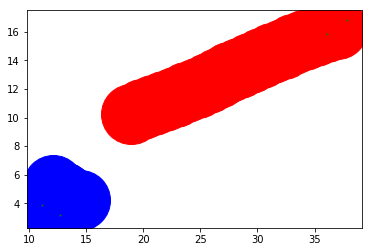

PREY :  0 :  [18.77096066627445, 10.026582831666424]
(17.786649974449706, 9.850138897343104)
(19.037708759514455, 10.990349118041301)
PRED :  0 :  [4.882052209415344, 17.4711516739496]
(5.656027433911012, 18.10436755488349)
(4.883654905341604, 16.47115295826754)
PREY :  0 :  [18.501835323870118, 9.063477671221444]
(17.517524632045372, 8.887033736898124)
(18.768583417110122, 10.02724395759632)
PRED :  0 :  [5.780088949795861, 17.911072135995564]
(6.554064174291529, 18.544288016929453)
(5.7816916457221215, 16.911073420313503)
PREY :  0 :  [18.194720715028396, 8.111805134559805]
(17.21041002320365, 7.9353612002364855)
(18.4614688082684, 9.075571420934683)
PRED :  0 :  [6.693429237138477, 18.31826928666942]
(7.467404461634145, 18.95148516760331)
(6.695031933064738, 17.31827057098736)
PREY :  0 :  [17.851518015739614, 7.1725437719983]
(16.86720732391487, 6.99609983767498)
(18.11826610897962, 8.136310058373176)
PRED :  0 :  [7.621332401331566, 18.691090581501747]
(8.395307625827234, 19.32430

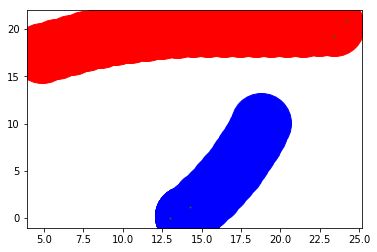

PREY :  0 :  [11.946817263018913, 3.3217717676387664]
(12.7428338983149, 3.9270465121408424)
(12.753625366397808, 2.7309581893231103)
PRED :  0 :  [14.963451092743151, 5.267884288251531]
(15.584312164850834, 4.483963674195937)
(15.728311387860243, 4.62368810000342)
PREY :  0 :  [11.946817263018913, 3.3217717676387664]
(11.169400701650105, 3.950757848652885)
(11.180876136570113, 2.6788610500314594)
PRED :  0 :  [15.926902185486302, 5.535768576503061]
(16.547763257593985, 4.751847962447468)
(16.691762480603394, 4.891572388254951)
PREY :  0 :  [12.60374397631968, 4.075726204824363]
(11.826327414950873, 4.7047122858384816)
(11.83780284987088, 3.432815487217056)
PRED :  0 :  [16.87838993407562, 5.843455209759095]
(17.499251006183304, 5.059534595703502)
(17.643250229192713, 5.199259021510985)
PREY :  0 :  [11.658774096209703, 3.748568863954664]
(10.881357534840895, 4.377554944968782)
(10.892832969760903, 3.105658146347357)
PRED :  0 :  [17.830392187284453, 6.149546225447741]
(18.451253259392

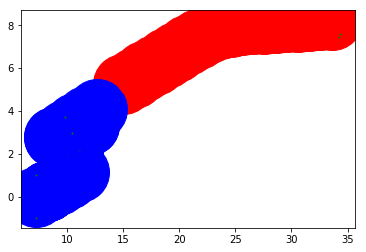

PREY :  0 :  [19.705595334945652, 11.044319146788931]
(18.708143501912122, 10.972976026741875)
(19.89866972013285, 12.02550326905375)
PRED :  0 :  [19.872332607584024, 17.488912897912968]
(20.833610799436926, 17.7644927191409)
(19.503639136071715, 16.55936186431438)
PREY :  0 :  [19.705595334945652, 11.044319146788931]
(18.747359380361637, 10.758340379495861)
(19.681268344139106, 12.04402320175635)
PRED :  0 :  [20.744665215168048, 17.977825795825936]
(21.70594340702095, 18.25340561705387)
(20.37597174365574, 17.048274762227347)
PREY :  0 :  [18.936286952769926, 10.40544152696322]
(17.97805099818591, 10.11946275967015)
(18.91195996196338, 11.405145581930638)
PRED :  0 :  [21.621067036521403, 18.459406368034283]
(22.582345228374304, 18.734986189262216)
(21.252373565009094, 17.529855334435695)
PREY :  0 :  [19.416979022258715, 9.52855206167664]
(18.4587430676747, 9.24257329438357)
(19.39265203145217, 10.528256116644059)
PRED :  0 :  [22.518797177434354, 18.899952159180238]
(23.4800753692

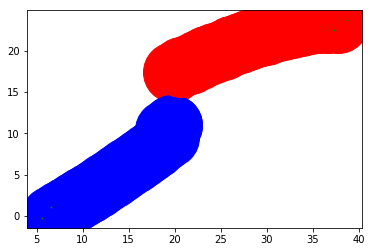

PREY :  0 :  [7.210647782623674, 10.38605938648508]
(6.249660096801575, 10.109468230266579)
(6.33751862612742, 9.898570436788638)
PRED :  0 :  [18.803636933089052, 14.595119886892734]
(18.641444149556545, 15.581878976524026)
(17.953384978785593, 15.12149581168712)
PREY :  0 :  [6.420686581062809, 9.772902554974157]
(5.45969889524071, 9.496311398755656)
(5.5475574245665555, 9.285413605277714)
PRED :  0 :  [17.976817988579214, 15.157588048658035]
(17.814625205046706, 16.144347138289326)
(17.126566034275754, 15.683963973452421)
PREY :  0 :  [5.656178155194896, 9.12828882041914]
(4.695190469372797, 8.851697664200639)
(4.783048998698642, 8.640799870722699)
PRED :  0 :  [17.976817988579214, 15.157588048658035]
(17.054695862698267, 15.544486982438942)
(17.07912244058611, 14.716971772161848)
PREY :  0 :  [4.891669729326982, 8.483675085864123]
(3.9306820435048833, 8.207083929645622)
(4.018540572830728, 7.9961861361676805)
PRED :  0 :  [17.976817988579214, 15.157588048658035]
(17.50152712986432,

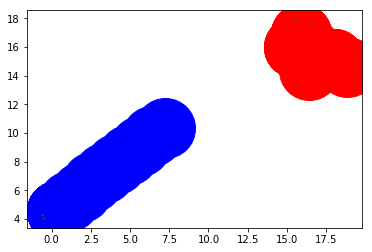

PREY :  0 :  [10.240743397634704, 17.34920862654403]
(10.231459644565437, 18.349165531579917)
(9.778977338323816, 18.236210377651936)
PRED :  0 :  [13.006025052204324, 11.890392504113171]
(12.631039186320752, 12.81742303240636)
(12.138788918622192, 11.39249543783389)
PREY :  0 :  [9.502691119010091, 16.67446509451351]
(9.493407365940824, 17.6744219995494)
(9.040925059699203, 17.561466845621418)
PRED :  0 :  [13.006025052204324, 11.890392504113171]
(12.781708047328983, 12.864908733492527)
(12.071200912044947, 11.535281497559891)
PREY :  0 :  [8.764638840385478, 15.999721562482994]
(8.755355087316211, 16.99967846751888)
(8.30287278107459, 16.886723313590903)
PRED :  0 :  [13.006025052204324, 11.890392504113171]
(13.230573806125719, 10.915929648426845)
(13.940764714908566, 12.245725816606608)
PREY :  0 :  [8.026586561760865, 15.324978030452478]
(8.017302808691598, 16.324934935488365)
(7.564820502449978, 16.211979781560384)
PRED :  0 :  [13.006025052204324, 11.890392504113171]
(12.06331926

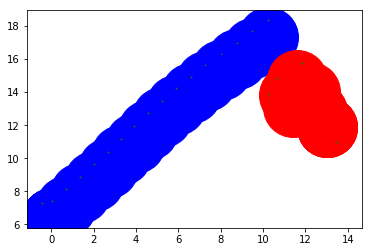

PREY :  0 :  [13.152001695994912, 7.47000105999682]
(13.954633985904787, 6.87352691370544)
(13.843662545181202, 8.19222351167144)
PRED :  0 :  [8.869533991290616, 5.493873099075267]
(8.781868927609631, 4.497723091993096)
(9.43349831065999, 6.319672255334365)
PREY :  0 :  [12.30187423998151, 6.943424086960415]
(13.104506529891385, 6.3469499406690355)
(12.9935350891678, 7.665646538635036)
PRED :  0 :  [9.740394128875572, 5.985403994101725]
(9.652729065194587, 4.989253987019555)
(10.304358448244946, 6.811203150360823)
PREY :  0 :  [11.449877027965323, 6.419877765498174]
(12.252509317875198, 5.823403619206794)
(12.141537877151613, 7.1421002171727945)
PRED :  0 :  [10.612641947520313, 6.474468144157208]
(10.524976883839328, 5.478318137075037)
(11.176606266889687, 7.300267300416306)
PREY :  0 :  [10.596200474715463, 5.8990742109486325]
(11.398832764625338, 5.302600064657253)
(11.287861323901753, 6.621296662623253)
Prey slaughtered
[10.612641947520313, 6.474468144157208]
PRED :  1 :  [10.6126

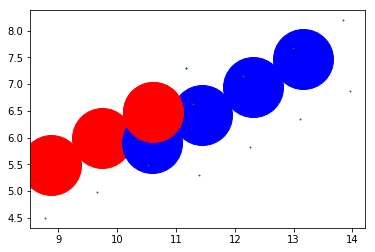

PREY :  0 :  [4.292893218813452, 5.292893218813452]
(4.9303016800454476, 6.063419307631903)
(3.556479883460402, 5.969425109794355)
PRED :  0 :  [12, 12]
(11.340597972986918, 11.248209492763417)
(11.700376158790315, 12.954057416395235)
PREY :  0 :  [3.585786437626904, 4.585786437626904]
(4.2231948988589, 5.356312526445355)
(2.849373102273854, 5.262318328607807)
PRED :  0 :  [12, 12]
(12.082591221766862, 11.003416491162403)
(11.105636263433922, 12.447340481865396)
PREY :  0 :  [2.8786796564403563, 3.8786796564403567]
(3.516088117672352, 4.649205745258808)
(2.1422663210873063, 4.55521154742126)
PRED :  0 :  [12, 12]
(11.96132909311333, 12.999252000728827)
(12.873819140047187, 11.513748922379403)
PREY :  0 :  [2.1715728752538084, 3.1715728752538093]
(2.8089813364858043, 3.94209896407226)
(1.4351595399007584, 3.8481047662347123)
PRED :  0 :  [11.11281097583582, 12.4614061501569]
(11.07414006894915, 13.460658150885727)
(11.986630115883008, 11.975155072536303)
PREY :  0 :  [1.5060052678209004

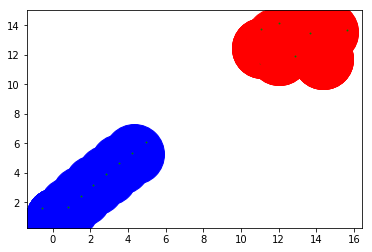

PREY :  0 :  [18.426537655636672, 1.1807680794809599]
(19.3607245983075, 0.8239841726923638)
(19.158425575707582, 1.8621931101734608)
PRED :  0 :  [7.997953193605862, 10.063948599451912]
(8.864659479874307, 9.56512978129971)
(7.670127425745747, 11.008686799127847)
PREY :  0 :  [17.804369601641213, 0.3978843636026038]
(18.73855654431204, 0.04110045681400776)
(18.536257521712123, 1.0793093942951049)
PRED :  0 :  [8.997703580195443, 10.086290589380777]
(9.86440986646389, 9.587471771228575)
(8.669877812335328, 11.031028789056712)
PREY :  0 :  [17.804369601641213, 0.3978843636026038]
(18.73855654431204, 0.04110045681400776)
(18.536257521712123, 1.0793093942951049)
PRED :  0 :  [9.997453966785026, 10.108632579309642]
(10.864160253053472, 9.60981376115744)
(9.66962819892491, 11.053370778985578)
PREY :  0 :  [17.804369601641213, 0.3978843636026038]
(18.73855654431204, 0.04110045681400776)
(18.536257521712123, 1.0793093942951049)
PRED :  0 :  [10.997204353374608, 10.130974569238507]
(11.8639106

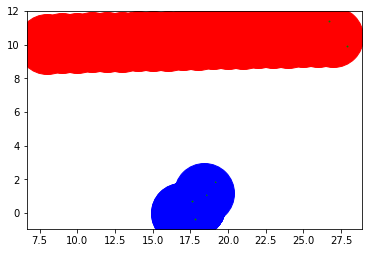

PREY :  0 :  [1.0122370346709308, 8.84403742652699]
(0.17261866236923096, 9.387214183111293)
(0.2869325103220155, 8.155609255285434)
PRED :  0 :  [19.113711802816674, 3.9935137774083365]
(19.000304112556698, 4.987062314617212)
(18.998625915951372, 4.986869322338966)
PREY :  0 :  [0.03337427306829133, 8.639519226975814]
(-0.8062440992334086, 9.182695983560118)
(-0.691930251280624, 7.951091055734258)
PRED :  0 :  [19.11757475203628, 4.993506316192165]
(19.004167061776304, 5.987054853401041)
(19.002488865170978, 5.986861861122794)
PREY :  0 :  [0.03337427306829133, 8.639519226975814]
(-0.8062440992334086, 9.182695983560118)
(-0.691930251280624, 7.951091055734258)
PRED :  0 :  [19.121437701255886, 5.993498854975994]
(19.00803001099591, 6.98704739218487)
(19.006351814390584, 6.986854399906623)
PREY :  0 :  [0.03337427306829133, 8.639519226975814]
(-0.8062440992334086, 9.182695983560118)
(-0.691930251280624, 7.951091055734258)
PRED :  0 :  [19.12530065047549, 6.993491393759823]
(19.011892960

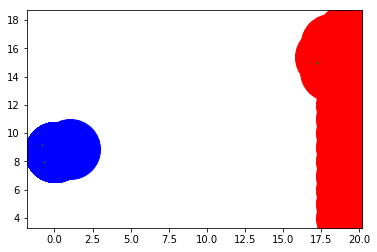

PREY :  0 :  [13.406103216809127, 13.086172785863061]
(14.312262339593705, 13.509109712832421)
(12.68349969520367, 12.394910064053624)
PRED :  0 :  [4.715593883026358, 6.698516567144444]
(5.398092764929692, 7.429403204182432)
(4.291867727543713, 5.792726224316757)
PREY :  0 :  [12.421510758104372, 12.911308008787392]
(13.32766988088895, 13.334244935756752)
(11.698907236498915, 12.220045286977955)
PRED :  0 :  [5.408899537303181, 7.4191602167714885]
(6.091398419206516, 8.150046853809476)
(4.985173381820537, 6.513369873943802)
PREY :  0 :  [12.421510758104372, 12.911308008787392]
(12.00758206450903, 13.821617316999966)
(13.105572582359867, 12.181883975322465)
PRED :  0 :  [6.102205191580005, 8.139803866398532]
(6.784704073483339, 8.870690503436519)
(5.67847903609736, 7.234013523570845)
PREY :  0 :  [13.311273441678455, 12.454884557462808]
(12.897344748083114, 13.365193865675382)
(13.995335265933951, 11.725460523997882)
PRED :  0 :  [6.832410839663681, 8.823031289374732]
(7.51490972156701

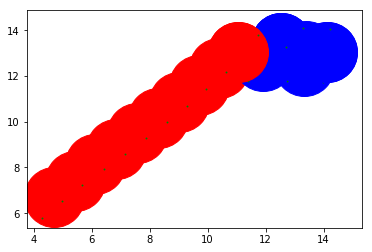

PREY :  0 :  [7.940353761211874, 2.99821957814823]
(8.934098620028234, 3.1098939063353956)
(6.957269417549183, 3.1813729926544725)
PRED :  0 :  [3.935529324191836, 3.3532490390321916]
(3.5523677620048764, 2.4295676993579245)
(4.8133579376298545, 3.8322239083411)
PREY :  0 :  [7.940353761211874, 2.99821957814823]
(8.399929214805075, 3.8863583074324577)
(7.241625645637104, 2.2828322561293604)
PRED :  0 :  [4.871058648383672, 3.7064980780643833]
(4.487897086196712, 2.782816738390116)
(5.74888726182169, 4.185472947373292)
PREY :  0 :  [7.940353761211874, 2.99821957814823]
(8.351150520636102, 2.086492633034424)
(7.813469853649287, 3.990137152345627)
PRED :  0 :  [5.806587972575508, 4.059747117096575]
(5.423426410388548, 3.1360657774223077)
(6.684416586013526, 4.538721986405483)
PREY :  0 :  [7.940353761211874, 2.99821957814823]
(7.171240857493927, 3.6373325113099266)
(8.489507297365124, 3.8339410591036858)
PRED :  0 :  [6.7421172967673435, 4.4129961561287665]
(6.358955734580384, 3.489314816

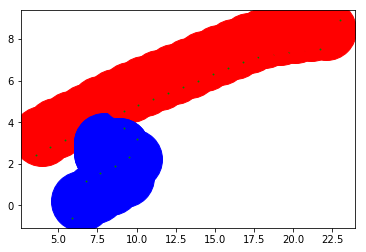

PREY :  0 :  [10.43531608440801, 6.174692738750168]
(11.278588051129583, 5.637205631796402)
(9.442424349973017, 6.055671716696615)
PRED :  0 :  [13.860624057280427, 19.509240838926118]
(12.920065598172856, 19.848872676363644)
(12.89664634181614, 19.24325782426493)
PREY :  0 :  [9.856142411176245, 5.359488558047428]
(10.699414377897819, 4.822001451093661)
(8.863250676741252, 5.240467535993875)
PRED :  0 :  [14.739140489914627, 19.986952967296]
(13.798582030807056, 20.326584804733525)
(13.77516277445034, 19.72096995263481)
PREY :  0 :  [9.262632537892362, 4.554661849796173]
(10.105904504613935, 4.017174742842407)
(8.269740803457369, 4.4356408277426205)
PRED :  0 :  [15.636518508123245, 20.42821557894123]
(14.695960049015675, 20.767847416378757)
(14.672540792658959, 20.162232564280043)
PREY :  0 :  [8.654815998063023, 3.760584363709399]
(9.498087964784597, 3.2230972567556324)
(7.6619242636280305, 3.641563341655847)
PRED :  0 :  [16.553680729204686, 20.826729644214918]
(15.613122270097115,

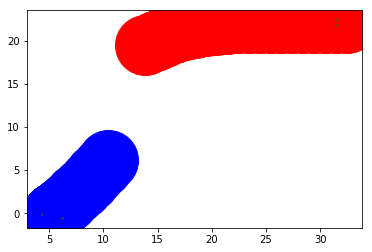

PREY :  0 :  [19.683772233983163, 1.0513167019494862]
(19.182975160860313, 0.18575197788109798)
(20.619925186322416, 1.4029097192670985)
PRED :  0 :  [5.9985767129070275, 15.053334308280833]
(5.940354191459032, 14.055030678118026)
(5.047967499997913, 15.36372458572572)
PREY :  0 :  [19.313592531704057, 0.122356537022835]
(18.812795458581206, -0.7432081870455532)
(20.24974548404331, 0.47394955434044717)
PRED :  0 :  [6.998556645782015, 15.059669436324882]
(6.9403341243340195, 14.061365806162074)
(6.047947432872901, 15.370059713769768)
PREY :  0 :  [19.313592531704057, 0.122356537022835]
(18.812795458581206, -0.7432081870455532)
(20.24974548404331, 0.47394955434044717)
PRED :  0 :  [7.998536578657003, 15.06600456436893]
(7.940314057209007, 14.067700934206123)
(7.0479273657478885, 15.376394841813816)
PREY :  0 :  [19.313592531704057, 0.122356537022835]
(18.812795458581206, -0.7432081870455532)
(20.24974548404331, 0.47394955434044717)
PRED :  0 :  [8.99851651153199, 15.072339692412978]
(8.

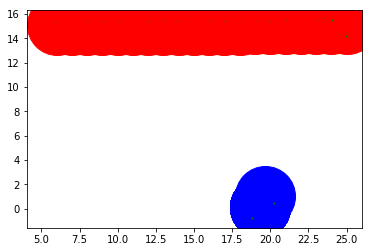

PREY :  0 :  [17.167949705662156, 13.445299803774772]
(17.49685742467917, 14.389661870130164)
(18.037127561859, 13.939799403670524)
PRED :  0 :  [9.423350577556867, 6.9059659422308695]
(10.417869443080068, 7.010523228530985)
(8.991519733618224, 7.807920554294713)
PREY :  0 :  [16.36136142774327, 12.854186151484585]
(16.690269146760283, 13.798548217839977)
(17.23053928394011, 13.348685751380337)
PRED :  0 :  [9.423350577556867, 6.9059659422308695]
(8.885488282705806, 7.7489986532080595)
(10.397892758950873, 7.130170172083506)
PREY :  0 :  [15.554773149824381, 12.263072499194399]
(15.883680868841395, 13.207434565549791)
(16.423951006021223, 12.75757209909015)
PRED :  0 :  [10.419133076366526, 6.8142205605248005]
(9.881270781515465, 7.6572532715019905)
(11.393675257760531, 7.038424790377437)
PREY :  0 :  [14.717866471192691, 11.715726894241117]
(15.046774190209705, 12.660088960596509)
(15.587044327389535, 12.210226494136869)
PRED :  0 :  [11.048710949132186, 7.591157946756064]
(10.5108486

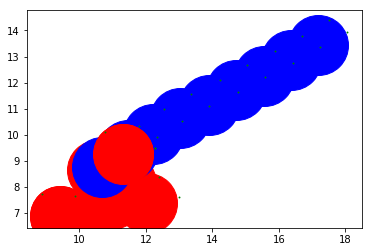

PREY :  0 :  [7.033765060398753, 11.742337349439667]
(7.3305369959650974, 10.787388964310814)
(6.098380998909065, 11.38870384210325)
PRED :  0 :  [15.513870473406625, 4.857867785011683]
(15.880270108497063, 3.9274102054275337)
(14.686096725522855, 5.418929833553961)
PREY :  0 :  [6.079456570837736, 11.443514146271358]
(6.37622850640408, 10.488565761142505)
(5.144072509348048, 11.08988063893494)
PRED :  0 :  [15.983031096835123, 5.740980637043734]
(16.349430731925562, 4.8105230574595845)
(15.155257348951354, 6.302042685586012)
PREY :  0 :  [5.138327122179387, 11.105467757638035]
(5.435099057745731, 10.150519372509182)
(4.202943060689699, 10.751834250301616)
PRED :  0 :  [16.40294649227506, 6.648543891408146]
(16.7693461273655, 5.718086311823996)
(15.57517274439129, 7.209605939950424)
PREY :  0 :  [4.211562296416988, 10.729825696987753]
(4.508334231983332, 9.7748773118589)
(3.2761782349273, 10.376192189651334)
PRED :  0 :  [16.76831879150347, 7.579405364967206]
(17.13471842659391, 6.6489

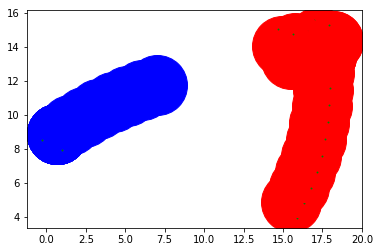

PREY :  0 :  [2.455011649404586, 19.161556383699363]
(2.0130220637932363, 20.058576565306836)
(3.2869488740680186, 19.716426146994593)
PRED :  0 :  [13.127082925920169, 20.991892095915464]
(13.556788091400922, 20.088922843526902)
(12.69892913840847, 20.08818620667971)
PREY :  0 :  [1.9248050450724647, 18.313687905265]
(1.482815459461115, 19.210708086872472)
(2.756742269735897, 18.86855766856023)
PRED :  0 :  [13.231609180725899, 21.986414223399958]
(13.661314346206652, 21.083444971011396)
(12.8034553932142, 21.082708334164202)
PREY :  0 :  [1.4091704284676279, 17.45687932561679]
(0.9671808428562781, 18.353899507224263)
(2.2411076531310603, 18.01174908891202)
PRED :  0 :  [13.312070384989383, 22.983171964583075]
(13.741775550470136, 22.080202712194513)
(12.883916597477684, 22.07946607534732)
PREY :  0 :  [0.9079643131706898, 16.59155139356504]
(0.4659747275593401, 17.488571575172514)
(1.7399015378341223, 17.14642115686027)
PRED :  0 :  [12.439629749566652, 22.49445186302884]
(12.8693349

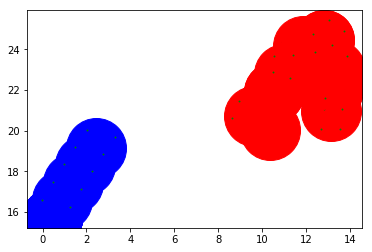

PREY :  0 :  [14.345069461582158, 7.244310917210183]
(14.750481980974532, 8.158444763602454)
(15.327954391428056, 7.428531477088349)
PRED :  0 :  [13.892633521672122, 15.450783091949136]
(12.94405720484771, 15.134234563031638)
(13.749817751724523, 14.46103380255597)
PREY :  0 :  [13.676452364712732, 6.500704046764582]
(14.081864884105107, 7.414837893156853)
(14.65933729455863, 6.684924606642748)
PRED :  0 :  [14.795798660748, 15.880076385115999]
(13.847222343923587, 15.563527856198501)
(14.6529828908004, 14.890327095722833)
PREY :  0 :  [12.994764873051004, 5.769060579143951]
(13.400177392443378, 6.683194425536222)
(13.977649802896902, 5.953281139022117)
PRED :  0 :  [15.709776945865535, 16.28583948636303]
(14.761200629041122, 15.969290957445534)
(15.566961175917935, 15.296090196969866)
PREY :  0 :  [12.300501656645476, 5.049339392609713]
(12.705914176037851, 5.963473239001984)
(13.283386586491375, 5.233559952487879)
PRED :  0 :  [16.63486685129343, 16.665587648801516]
(15.686290534469

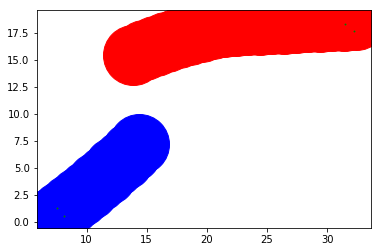

PREY :  0 :  [4.959465635073795, 9.281825646654877]
(4.131451860134539, 9.842533403432721)
(5.802546915568163, 9.819611807205682)
PRED :  0 :  [7.471265653470462, 18.881991317337683]
(6.52104875447257, 19.193580541892754)
(6.486748373019053, 18.706703769312835)
PREY :  0 :  [3.959761983895232, 9.306169225279426]
(3.1317482089559756, 9.86687698205727)
(4.802843264389599, 9.843955385830231)
PRED :  0 :  [7.862794862709975, 19.80215699715425]
(6.912577963712083, 20.11374622170932)
(6.8782775822585664, 19.6268694491294)
PREY :  0 :  [3.959761983895232, 9.306169225279426]
(3.0784739181659955, 8.833589766137134)
(3.8753939824335286, 10.302603889634977)
PRED :  0 :  [7.181606631438373, 19.0700486762228]
(6.231389732440482, 19.38163790077787)
(6.197089350986965, 18.894761128197953)
PREY :  0 :  [3.959761983895232, 9.306169225279426]
(3.7143733891753836, 10.275594022559451)
(4.947016898289972, 9.147022330859727)
PRED :  0 :  [7.573135840677886, 19.990214356039367]
(6.622918941679995, 20.3018035

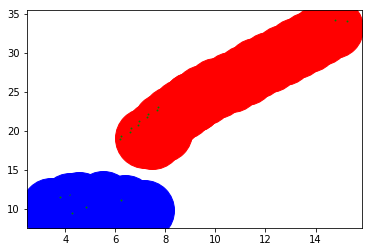

PREY :  0 :  [1.2380606822405404, 9.35235157990446]
(0.2927906356714155, 9.678640622103556)
(2.228973233697372, 9.486859257623287)
PRED :  0 :  [20.228104574657205, 17.973636638084482]
(20.772845138254937, 18.81224126385948)
(19.55910165861644, 18.71689641657983)
PREY :  0 :  [0.4905247466096141, 8.688130212482125]
(-0.45474529995951085, 9.014419254681222)
(1.4814372980664459, 8.822637890200953)
PRED :  0 :  [20.228104574657205, 17.973636638084482]
(19.382306624797177, 17.44013328475615)
(20.52447215730408, 18.928710591219026)
PREY :  0 :  [0.4905247466096141, 8.688130212482125]
(-0.45474529995951085, 9.014419254681222)
(1.4814372980664459, 8.822637890200953)
PRED :  0 :  [20.228104574657205, 17.973636638084482]
(19.24510965661521, 18.157269399604882)
(19.79626536963819, 18.87558724704738)
PREY :  0 :  [0.4905247466096141, 8.688130212482125]
(-0.45474529995951085, 9.014419254681222)
(1.4814372980664459, 8.822637890200953)
PRED :  0 :  [21.082786753153975, 17.45448504773729]
(20.0997918

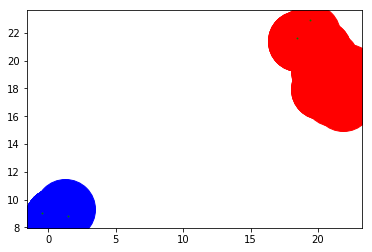

PREY :  0 :  [11, 11]
(11.573700469357796, 11.8190651814469)
(10.089213569156446, 11.41287779958634)
PRED :  0 :  [6.707106781186548, 16.707106781186546]
(5.768857011987675, 16.36114815562814)
(7.150269222699643, 17.60354810689178)
PREY :  0 :  [11.135133316336828, 11.990827425345005]
(11.708833785694624, 12.809892606791905)
(10.224346885493274, 12.403705224931347)
PRED :  0 :  [7.387583921469103, 17.439876091101254]
(6.4493341522702305, 17.093917465542848)
(7.8307463629821985, 18.336317416806487)
PREY :  0 :  [11.135133316336828, 11.990827425345005]
(12.075826724562047, 12.330085309146726)
(10.628277843234178, 12.852858474313596)
PRED :  0 :  [8.068061061751658, 18.172645401015963]
(7.129811292552786, 17.826686775457556)
(8.511223503264754, 19.069086726721196)
PREY :  0 :  [11.135133316336828, 11.990827425345005]
(12.018858994092753, 12.45883268864322)
(10.512238685936254, 12.77313317082955)
PRED :  0 :  [8.748538202034213, 18.90541471093067]
(7.810288432835341, 18.559456085372265)
(9

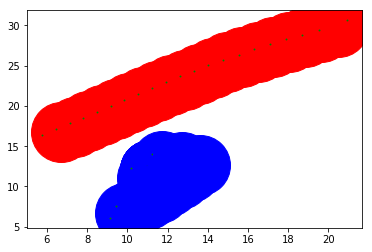

PREY :  0 :  [5.056141643633983, 8.669649575271894]
(4.112952759642572, 9.001906597944158)
(4.664412422941829, 9.58973012481955)
PRED :  0 :  [20.503785237250792, 7.863828938348422]
(21.023214510093542, 8.71834238500333)
(20.181978649863684, 8.81063436731166)
PREY :  0 :  [4.122457096882603, 8.311552986126351]
(3.179268212891192, 8.643810008798615)
(3.7307278761904494, 9.231633535674007)
PRED :  0 :  [20.94812346589041, 8.759688044776105]
(21.46755273873316, 9.614201491431015)
(20.626316878503303, 9.706493473739345)
PREY :  0 :  [3.199870380230424, 7.92576321143429]
(2.256681496239013, 8.258020234106555)
(2.80814115953827, 8.845843760981946)
PRED :  0 :  [21.322494110618635, 9.68696719388158]
(21.841923383461385, 10.54148064053649)
(21.000687523231527, 10.63377262284482)
PREY :  0 :  [2.28942227860247, 7.512139887331243]
(1.3462333946110594, 7.844396910003507)
(1.8976930579103162, 8.432220436878898)
PRED :  0 :  [21.61401917673317, 10.643530383549109]
(22.13344844957592, 11.49804383020

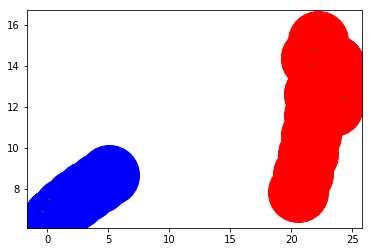

PREY :  0 :  [20, 15]
(19.793591923709528, 15.97846599636475)
(19.35033001239028, 14.239783644480609)
PRED :  0 :  [11.8, 11.6]
(12.315171201289168, 12.457087296231997)
(11.976227446750565, 12.58434947402423)
PREY :  0 :  [20, 15]
(19.588293523534247, 14.088683492283744)
(20.973342211156538, 15.229357668240898)
PRED :  0 :  [12.600000000000001, 12.2]
(13.115171201289169, 13.057087296231998)
(12.776227446750566, 13.184349474024229)
PREY :  0 :  [20, 15]
(20.889511730684983, 15.456912334013655)
(19.81976769371939, 15.983624072383739)
PRED :  0 :  [13.400000000000002, 12.799999999999999]
(13.91517120128917, 13.657087296231996)
(13.576227446750567, 13.784349474024228)
PREY :  0 :  [19.149422120105843, 15.525849094545917]
(20.038933850790826, 15.982761428559572)
(18.96918981382523, 16.509473166929656)
PRED :  0 :  [14.176769825354674, 13.42978459684123]
(14.69194102664384, 14.28687189307323)
(14.352997272105238, 14.41413407086546)
PREY :  0 :  [19.149422120105843, 15.525849094545917]
(19.71

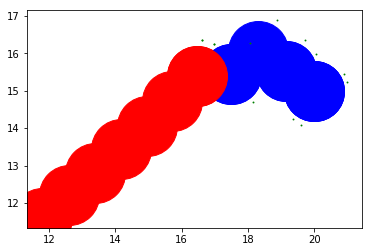

PREY :  0 :  [11.39218092153551, 9.205924457085738]
(12.322117811036383, 9.573643618328989)
(12.267425221123478, 9.689605566949218)
PRED :  0 :  [7.777789392050047, 11.628524988854396]
(6.879844931273233, 12.068633776951428)
(7.122697234662315, 10.872976006108019)
PREY :  0 :  [11.39218092153551, 9.205924457085738]
(11.932904092063223, 10.04712505911504)
(12.036090379425202, 9.971026156234423)
PRED :  0 :  [8.555578784100094, 12.257049977708792]
(7.65763432332328, 12.697158765805824)
(7.900486626712362, 11.501500994962415)
PREY :  0 :  [11.39218092153551, 9.205924457085738]
(11.09346983039736, 10.160268045124687)
(10.973817880858462, 10.11420435127885)
PRED :  0 :  [9.33336817615014, 12.885574966563189]
(8.435423715373327, 13.32568375466022)
(8.678276018762409, 12.130025983816811)
PREY :  0 :  [11.39218092153551, 9.205924457085738]
(10.53210098401537, 9.716083746989737)
(10.604444448363967, 9.821936834262738)
PRED :  0 :  [10.111157568200186, 13.514099955417585]
(9.213213107423373, 13.

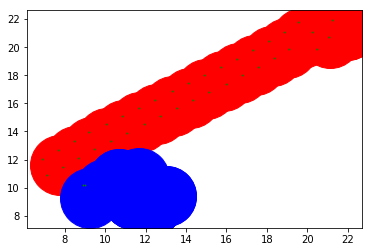

PREY :  0 :  [11.430790021169692, 0.17780780835622156]
(10.597511482996074, -0.37504558796077636)
(10.949131095350687, -0.6985509533269617)
PRED :  0 :  [9.999879040393749, 13.01555328200977]
(9.67266484787919, 12.070603086381956)
(9.24184139570826, 13.667764083238696)
PREY :  0 :  [11.430790021169692, 0.17780780835622156]
(10.597511482996074, -0.37504558796077636)
(10.949131095350687, -0.6985509533269617)
PRED :  0 :  [10.999758080787498, 13.031106564019542]
(10.672543888272939, 12.086156368391727)
(10.241720436102009, 13.683317365248467)
PREY :  0 :  [11.430790021169692, 0.17780780835622156]
(10.597511482996074, -0.37504558796077636)
(10.949131095350687, -0.6985509533269617)
PRED :  0 :  [11.999637121181246, 13.046659846029312]
(11.672422928666688, 12.101709650401498)
(11.241599476495757, 13.698870647258238)
PREY :  0 :  [11.430790021169692, 0.17780780835622156]
(10.597511482996074, -0.37504558796077636)
(10.949131095350687, -0.6985509533269617)
PRED :  0 :  [12.999516161574995, 13.0

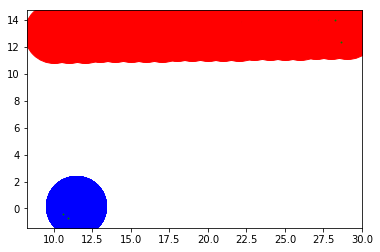

PREY :  0 :  [16.00611626532638, 12.889568473925154]
(15.022293903905418, 13.068715232668035)
(15.70339033877, 13.84264612731473)
PRED :  0 :  [9.778854868535301, 1.6272041882504118]
(10.646445169265967, 2.124483858132537)
(10.007969042190508, 0.6538046323483702)
PREY :  0 :  [15.019679762705728, 12.725425163682138]
(14.035857401284765, 12.904571922425019)
(14.716953836149347, 13.678502817071713)
PRED :  0 :  [10.541828560666223, 2.27363372433003]
(11.409418861396887, 2.7709133942121555)
(10.77094273432143, 1.3002341684279883)
PREY :  0 :  [14.042156922130529, 12.514595620795491]
(13.058334560709566, 12.693742379538373)
(13.739430995574148, 13.467673274185067)
PRED :  0 :  [11.28837457375241, 2.938967512999386]
(12.155964874483075, 3.4362471828815115)
(11.517488747407617, 1.9655679570973443)
PREY :  0 :  [13.074417774719713, 12.262641373820793]
(12.09059541329875, 12.441788132563675)
(12.771691848163332, 13.215719027210369)
PRED :  0 :  [12.017762151615, 3.623068208262696]
(12.88535245

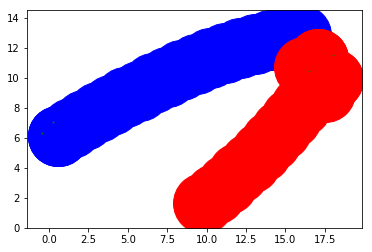

PREY :  0 :  [12.663663603001844, 5.058258088405163]
(12.91772231266651, 6.025446886956678)
(12.884953910884455, 6.033466066037226)
PRED :  0 :  [5.9286588320574225, 14.370934999213803]
(5.512124914135528, 13.461814822768117)
(6.798136897905739, 14.864906550022827)
PREY :  0 :  [12.282297050450447, 4.133834185320078]
(12.536355760115114, 5.1010229838715935)
(12.503587358333059, 5.109042162952141)
PRED :  0 :  [6.876418271232317, 14.689920963567863]
(6.459884353310422, 13.780800787122176)
(7.745896337080633, 15.183892514376886)
PREY :  0 :  [11.85834252848589, 3.228150706777047]
(12.112401238150557, 4.195339505328563)
(12.079632836368502, 4.20335868440911)
PRED :  0 :  [7.841304733491473, 14.952588272057156]
(7.424770815569579, 14.04346809561147)
(8.710782799339789, 15.44655982286618)
PREY :  0 :  [11.393917459121077, 2.3425382887602892]
(11.647976168785744, 3.3097270873118045)
(11.615207767003689, 3.3177462663923527)
PRED :  0 :  [8.820817233105512, 15.153971645501585]
(8.4042833151836

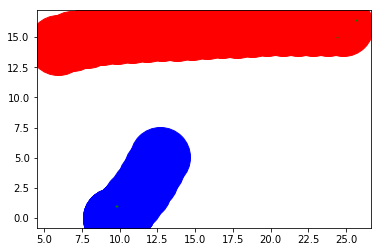

PREY :  0 :  [11.167949705662156, 9.445299803774772]
(10.533712225279729, 10.218438095723988)
(10.42801920720303, 10.117983130050984)
PRED :  0 :  [18.85059223216138, 12.525825878582182]
(18.285561622872134, 11.700755935749319)
(18.04664827373172, 13.120530941369148)
PREY :  0 :  [10.335059469841411, 8.891861591257365]
(9.700821989458984, 9.664999883206582)
(9.595128971382286, 9.564544917533578)
PRED :  0 :  [18.85059223216138, 12.525825878582182]
(19.217199705697304, 11.595450169340156)
(17.907481807322895, 12.193346215202642)
PREY :  0 :  [9.502169234020666, 8.338423378739959]
(8.867931753638238, 9.111561670689175)
(8.76223873556154, 9.011106705016172)
PRED :  0 :  [18.85059223216138, 12.525825878582182]
(19.30494507802752, 13.416647685372597)
(19.724275352508318, 12.039330446721989)
PREY :  0 :  [8.669278998199921, 7.784985166222552]
(8.035041517817493, 8.558123458171767)
(7.9293484997407955, 8.457668492498765)
PRED :  0 :  [18.85059223216138, 12.525825878582182]
(17.926760834438507

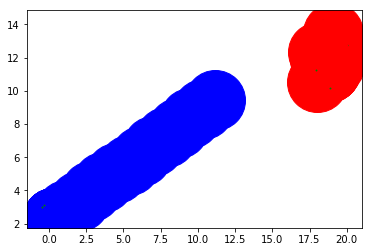

PREY :  0 :  [11.40680096195015, 2.194944162646632]
(12.35674682528287, 1.882529603547583)
(12.139785523703056, 1.5146988890637123)
PRED :  0 :  [14.981985229920568, 19.188957688961978]
(13.995611523985737, 19.024437440237424)
(14.712936227797636, 18.22583119962807)
PREY :  0 :  [10.791396413422069, 1.4067327432603434]
(11.74134227675479, 1.0943181841612941)
(11.524380975174974, 0.7264874696774235)
PRED :  0 :  [15.973595545884274, 19.318220913718125]
(14.987221839949443, 19.153700664993572)
(15.704546543761342, 18.35509442438422)
PREY :  0 :  [10.154157810729913, 0.6360661725315034]
(11.104103674062634, 0.32365161343245413)
(10.887142372482819, -0.044179101051416425)
PRED :  0 :  [16.971639356103065, 19.380739334075333]
(15.985265650168234, 19.21621908535078)
(16.70259035398013, 18.417612844741427)
PREY :  0 :  [10.154157810729913, 0.6360661725315034]
(11.104103674062634, 0.32365161343245413)
(10.887142372482819, -0.044179101051416425)
PRED :  0 :  [17.969683166321854, 19.443257754432

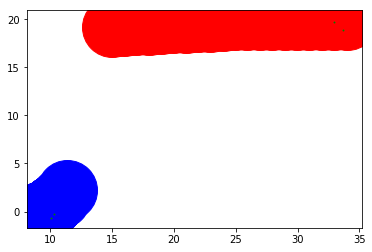

PREY :  0 :  [11.051316701949487, 17.683772233983163]
(11.98351975338469, 17.321836506408644)
(10.092164866426288, 17.966664009071227)
PRED :  0 :  [15.529963043283797, 5.848020738398169]
(14.836060710991644, 6.56808986927347)
(16.303632046235393, 5.214430749626344)
PREY :  0 :  [10.115469523805395, 17.331366134206583]
(11.047672575240597, 16.969430406632064)
(9.156317688282195, 17.614257909294647)
PRED :  0 :  [16.03403876832064, 6.71168019873458]
(15.340136436028489, 7.431749329609881)
(16.807707771272238, 6.078090209962755)
PREY :  0 :  [9.193023555947896, 16.945239941902248]
(10.125226607383098, 16.58330421432773)
(8.233871720424697, 17.228131716990312)
PRED :  0 :  [16.51089739722526, 7.590660203080075]
(15.816995064933108, 8.310729333955376)
(17.284566400176857, 6.95707021430825)
PREY :  0 :  [8.284442187816902, 16.527532032610107]
(9.216645239252106, 16.16559630503559)
(7.325290352293702, 16.81042380769817)
PRED :  0 :  [16.959005473461186, 8.484639594348206]
(16.265103141169032

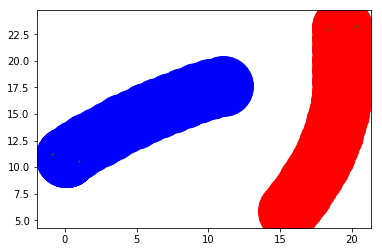

PREY :  0 :  [9, 16]
(8.86502306848453, 15.00915125878938)
(9.284815075102037, 16.958582481059725)
PRED :  0 :  [3.490261239632559, 15.87157553712455]
(4.099529334930588, 16.66453984152413)
(4.4895114606201645, 15.832858669273174)
PREY :  0 :  [8.277787357972903, 16.691671092135735]
(8.142810426457434, 15.700822350925115)
(8.56260243307494, 17.65025357319546)
PRED :  0 :  [3.9345505970145718, 16.767458881604778]
(4.5438186923126, 17.56042318600436)
(4.933800818002178, 16.7287420137534)
PREY :  0 :  [8.225677785648683, 17.690312465438577]
(8.090700854133214, 16.699463724227957)
(8.51049286075072, 18.648894946498302)
PRED :  0 :  [4.3561812786305225, 17.67422653007933]
(4.965449373928552, 18.467190834478913)
(5.3554314996181285, 17.635509662227953)
PREY :  0 :  [7.6402150762591425, 18.5010118029949]
(7.505238144743674, 17.51016306178428)
(7.925030151361179, 19.459594284054624)
PRED :  0 :  [4.737877108643496, 18.598514522725946]
(5.347145203941524, 19.39147882712553)
(5.737127329631102, 

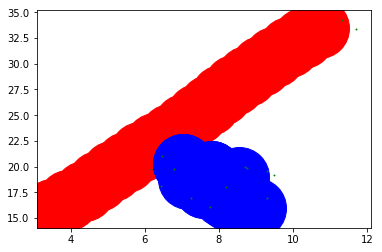

PREY :  0 :  [19.001090683088098, 18.953307638883867]
(19.494285728836406, 19.823226397647765)
(19.59484745756896, 18.148663063460607)
PRED :  0 :  [12.707996438792646, 19.706216002832655]
(11.760014883963759, 19.38789074196854)
(11.725266682557018, 19.521169451367722)
PREY :  0 :  [19.001090683088098, 18.953307638883867]
(18.051008452330713, 18.641308031834317)
(19.672874903442377, 19.694054533094697)
PRED :  0 :  [13.415992877585293, 20.41243200566531]
(12.468011322756405, 20.094106744801195)
(12.433263121349665, 20.227385454200377)
PREY :  0 :  [19.544615246338353, 19.792700901391747]
(18.594533015580968, 19.480701294342197)
(20.216399466692632, 20.533447795602576)
PRED :  0 :  [14.118626229345661, 21.12398409300255]
(13.170644674516774, 20.805658832138437)
(13.135896473110034, 20.93893754153762)
PREY :  0 :  [20.493188720927385, 20.10925794728725]
(19.54310649017, 19.7972583402377)
(21.164972941281665, 20.85000484149808)
PRED :  0 :  [14.832387399316474, 21.82437326499331]
(13.8844

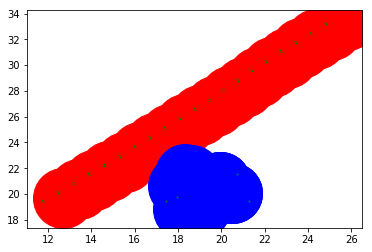

PREY :  0 :  [11.013606076167857, 18.835601012694642]
(10.016660943706125, 18.913706088463496)
(11.904230920594198, 19.29033982398147)
PRED :  0 :  [6.504765717760271, 1.8632563756926206]
(6.443380964682811, 0.8651421978103407)
(7.083098216731344, 2.679057528323501)
PREY :  0 :  [10.052267855736481, 18.560230669451517]
(9.055322723274749, 18.63833574522037)
(10.942892700162822, 19.014969480738344)
PRED :  0 :  [6.981005261435216, 2.7425719601333145]
(6.919620508357757, 1.7444577822510348)
(7.559337760406289, 3.5583731127641953)
PREY :  0 :  [9.121517913172031, 18.19457434936902]
(8.124572780710299, 18.272679425137873)
(10.012142757598372, 18.649313160655847)
PRED :  0 :  [7.429171022712253, 3.6365224343873273]
(7.367786269634793, 2.6384082565050475)
(8.007503521683326, 4.452323587018208)
PREY :  0 :  [8.223347527635008, 17.754926810374116]
(7.226402395173276, 17.83303188614297)
(9.113972372061347, 18.209665621660942)
PRED :  0 :  [7.84944079347764, 4.543921640790336]
(7.78805604040018,

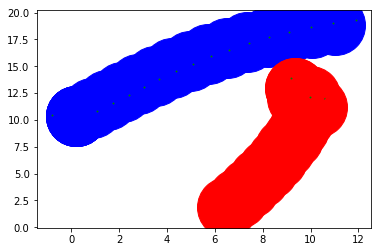

PREY :  0 :  [17.648876558411608, 7.0636708224309555]
(17.462899577537023, 8.046224924037974)
(18.508727015474516, 7.574216796353683)
PRED :  0 :  [3.928401934480957, 8.37157751284492]
(4.863088998403499, 8.727049160850578)
(3.078446271581921, 8.898431734718352)
PREY :  0 :  [17.22406814341007, 6.1583875460230235]
(17.038091162535483, 7.140941647630041)
(18.083918600472977, 6.668933519945751)
PRED :  0 :  [4.8700237061617235, 8.708250112111292]
(5.804710770084265, 9.06372176011695)
(4.020068043262687, 9.235104333984724)
PREY :  0 :  [16.73596814624809, 5.28559983256088]
(16.549991165373505, 6.268153934167898)
(17.595818603311, 5.796145806483608)
PRED :  0 :  [5.823597253362023, 9.009410351983421]
(6.758284317284565, 9.364881999989079)
(4.973641590462987, 9.536264573856853)
PREY :  0 :  [16.193112559774544, 4.445773771858747]
(16.00713557889996, 5.428327873465764)
(17.052963016837452, 4.9563197457814745)
PRED :  0 :  [6.787914194205179, 9.274160871535127]
(7.72260125812772, 9.6296325195

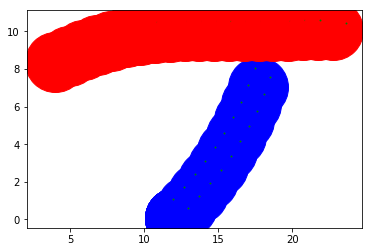

PREY :  0 :  [5.040634498428729, 17.71783367600845]
(4.232054532356224, 18.306219976381076)
(5.948369326492823, 18.137378050204376)
PRED :  0 :  [17.273636683450487, 5.961833127663119]
(16.80694953559273, 6.8462555979929895)
(18.27350729803321, 5.97791896285973)
PREY :  0 :  [4.095352737429684, 17.39157857287205]
(3.2867727713571777, 17.979964873244676)
(5.003087565493777, 17.811122947067975)
PRED :  0 :  [17.502846597347713, 6.935210143711488]
(17.036159449489954, 7.819632614041359)
(18.502717211930435, 6.951295978908099)
PREY :  0 :  [3.165673419480221, 17.023208696556107]
(2.3570934534077153, 17.611594996928734)
(4.0734082475443145, 17.442753070752033)
PRED :  0 :  [17.685674399922444, 7.91835509467533]
(17.218987252064686, 8.8027775650052)
(18.685545014505166, 7.934440929871941)
PREY :  0 :  [2.2529772263349677, 16.614569908604985]
(1.4443972602624617, 17.20295620897761)
(3.160712054399061, 17.03411428280091)
PRED :  0 :  [17.82004710298448, 8.909285958394793]
(17.35335995512672, 9

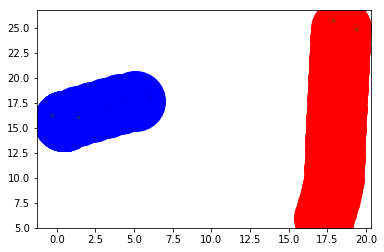

PREY :  0 :  [5.463124507806841, 1.1563385122678926]
(6.460384795165037, 1.2303109345497572)
(4.628970661012698, 0.6048066819275824)
PRED :  0 :  [7.97832512840632, 11.207074728368182]
(7.165371311577128, 10.624746563410614)
(8.887537090715496, 11.623408257637562)
PREY :  0 :  [4.88317355417962, 0.3416871197159145]
(5.880433841537816, 0.4156595419977791)
(4.049019707385476, -0.2098447106243958)
PRED :  0 :  [8.975886016667427, 11.276876406082348]
(8.162932199838234, 10.69454824112478)
(9.885097978976603, 11.693209935351728)
PREY :  0 :  [4.88317355417962, 0.3416871197159145]
(5.880433841537816, 0.4156595419977791)
(4.049019707385476, -0.2098447106243958)
PRED :  0 :  [9.973446904928533, 11.346678083796514]
(9.16049308809934, 10.764349918838946)
(10.882658867237708, 11.763011613065894)
PREY :  0 :  [4.88317355417962, 0.3416871197159145]
(5.880433841537816, 0.4156595419977791)
(4.049019707385476, -0.2098447106243958)
PRED :  0 :  [10.971007793189639, 11.41647976151068]
(10.15805397636044

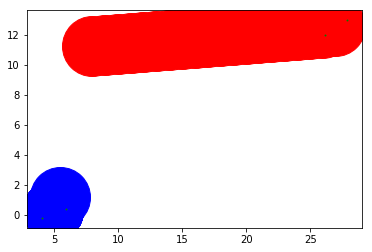

PREY :  0 :  [6.002541300169265, 10.92875295001209]
(6.321109485021244, 11.87665289810794)
(6.874547651391219, 10.439258390871158)
PRED :  0 :  [14.481409272650254, 1.8764959282314748]
(13.769819684311024, 1.1739005555117246)
(13.51724183446669, 2.1417903894374026)
PREY :  0 :  [5.010832475617082, 10.800247668776928]
(5.329400660469061, 11.748147616872778)
(5.882838826839036, 10.310753109635996)
PRED :  0 :  [14.9022740116287, 2.783619333003176]
(14.19068442328947, 2.0810239602834257)
(13.938106573445136, 3.0489137942091036)
PREY :  0 :  [4.027834383259265, 10.616631900333989]
(4.346402568111244, 11.564531848429839)
(4.899840734481218, 10.127137341193057)
PRED :  0 :  [15.256992614264671, 3.718592441142648]
(14.545403025925442, 3.0159970684228976)
(14.292825176081108, 3.9838869023485755)
PREY :  0 :  [3.056275572066185, 10.379833512685149]
(3.374843756918164, 11.327733460781)
(3.9282819232881385, 9.890338953544218)
PRED :  0 :  [15.53944671316989, 4.677873256134609]
(14.82785712483066,

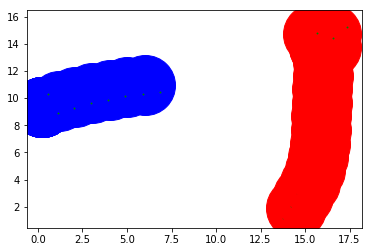

PREY :  0 :  [9.498963729458294, 0.134573714518874]
(9.989111031053127, 1.0062133319866118)
(9.017476588706586, -0.7418794406986445)
PRED :  0 :  [11.99989966033278, 19.01416577800164]
(12.689820820228695, 19.738050294432178)
(11.200249209153922, 19.614631560481747)
PREY :  0 :  [9.498963729458294, 0.134573714518874]
(9.989111031053127, 1.0062133319866118)
(9.017476588706586, -0.7418794406986445)
PRED :  0 :  [12.99979932066556, 19.02833155600328]
(13.689720480561475, 19.752216072433818)
(12.200148869486702, 19.628797338483388)
PREY :  0 :  [9.498963729458294, 0.134573714518874]
(9.989111031053127, 1.0062133319866118)
(9.017476588706586, -0.7418794406986445)
PRED :  0 :  [13.999698980998339, 19.04249733400492]
(14.689620140894254, 19.766381850435458)
(13.200048529819481, 19.642963116485028)
PREY :  0 :  [9.498963729458294, 0.134573714518874]
(9.989111031053127, 1.0062133319866118)
(9.017476588706586, -0.7418794406986445)
PRED :  0 :  [14.999598641331119, 19.05666311200656]
(15.68951980

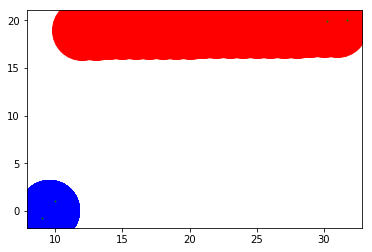

PREY :  0 :  [3.1425070742874555, 15.485504244572473]
(3.7076966954553066, 14.660543219963346)
(2.1500306200939603, 15.363068596693653)
PRED :  0 :  [20.19887843678159, 12.980024166734326]
(19.23390471307414, 12.717677616243995)
(19.263434213717986, 13.333498501781339)
PREY :  0 :  [2.3012344705659618, 14.944893103152266]
(2.866424091733813, 14.119932078543139)
(1.3087580163724664, 14.822457455273446)
PRED :  0 :  [20.351066129243197, 13.968375777378641]
(19.386092405535745, 13.70602922688831)
(19.41562190617959, 14.321850112425654)
PREY :  0 :  [1.4767581248820303, 14.378996685591886]
(2.0419477460498814, 13.554035660982759)
(0.4842816706885349, 14.256561037713066)
PRED :  0 :  [20.453231180335976, 14.963143238816343]
(19.488257456628524, 14.700796688326012)
(19.51778695727237, 15.316617573863356)
PREY :  0 :  [0.6696782384102509, 13.788554430284307]
(1.234867859578102, 12.96359340567518)
(-0.3227982157832445, 13.666118782405487)
PRED :  0 :  [20.50174169033598, 15.96196591097569]
(19

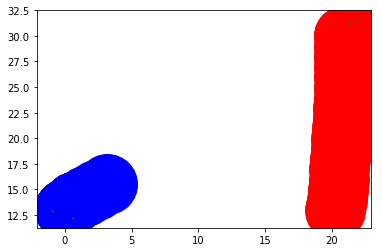

PREY :  0 :  [1.4631245078068404, 4.156338512267893]
(2.4537522353247265, 4.292928063379054)
(2.2966955541616487, 4.708750777409562)
PRED :  0 :  [7.992907534430624, 11.118889141938615]
(7.8632769370885125, 12.11045149914704)
(8.924284892634285, 11.482944380364833)
PREY :  0 :  [0.8794303922934459, 3.344364879989704]
(1.8700581198113322, 3.4809544311008644)
(1.7130014386482544, 3.8967771451313733)
PRED :  0 :  [7.992907534430624, 11.118889141938615]
(7.431583772112581, 11.9464854407807)
(8.661407545043627, 11.862601274292535)
PREY :  0 :  [0.2957362767800513, 2.532391247711515]
(1.2863640042979376, 2.6689807988226755)
(1.1293073231348596, 3.0848035128531843)
PRED :  0 :  [7.992907534430624, 11.118889141938615]
(7.22891513376273, 11.764114383014713)
(8.435687045670031, 12.01551967032062)
PREY :  0 :  [0.2957362767800513, 2.532391247711515]
(1.2863640042979376, 2.6689807988226755)
(1.1293073231348596, 3.0848035128531843)
PRED :  0 :  [7.992907534430624, 11.118889141938615]
(8.85406407801

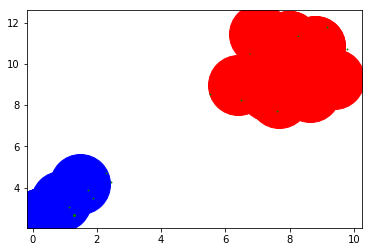

PREY :  0 :  [14.01941932430908, 13.803883864861817]
(13.157926717297523, 14.311653978263966)
(13.033403579543668, 13.970536050790201)
PRED :  0 :  [10.712563060868224, 2.7016080702829095]
(11.525932632343288, 3.2833553867343643)
(11.022818666072887, 3.6522612454414887)
PREY :  0 :  [13.049778678799386, 13.559349575700676]
(12.188286071787829, 14.067119689102825)
(12.063762934033974, 13.72600176162906)
PRED :  0 :  [11.406001444225513, 3.4221240024362727]
(12.219371015700577, 4.003871318887727)
(11.716257049430176, 4.372777177594852)
PREY :  0 :  [12.09195987235664, 13.271976762051592]
(11.230467265345082, 13.77974687545374)
(11.105944127591227, 13.438628947979977)
PRED :  0 :  [12.079482747955714, 4.161328259408505]
(12.892852319430778, 4.74307557585996)
(12.389738353160377, 5.111981434567084)
PREY :  0 :  [11.146490189466421, 12.94626664747811]
(10.284997582454864, 13.454036760880259)
(10.16047444470101, 13.112918833406495)
PRED :  0 :  [12.731949283426822, 4.919145796874041]
(13.545

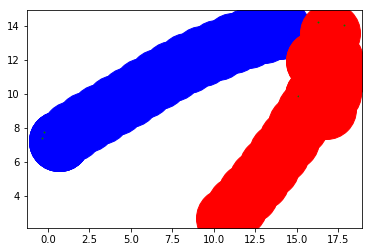

PREY :  0 :  [14.121041370019432, 14.992647463475235]
(13.344787230274939, 14.362227357094152)
(13.678745934568582, 14.095778048354314)
PRED :  0 :  [4.685630215620513, 10.727950003384963]
(5.625797216010902, 11.06866397635487)
(3.7343845897146686, 11.03638437111171)
PREY :  0 :  [14.121041370019432, 14.992647463475235]
(14.180871790243689, 15.990856019246918)
(13.758792585161078, 15.924728907271133)
PRED :  0 :  [5.371260431241026, 11.455900006769927]
(6.311427431631415, 11.796613979739833)
(4.420014805335182, 11.764334374496674)
PREY :  0 :  [14.121041370019432, 14.992647463475235]
(13.761521230496422, 14.059510137420085)
(14.183792104478313, 13.994618232778624)
PRED :  0 :  [6.0568906468615396, 12.18385001015489]
(6.997057647251928, 12.524563983124796)
(5.105645020955695, 12.492284377881637)
PREY :  0 :  [13.390576419800043, 15.675597649433907]
(13.031056280277033, 14.742460323378758)
(13.453327154258924, 14.677568418737295)
PRED :  0 :  [6.7064046368853205, 12.94419965128283]
(7.64

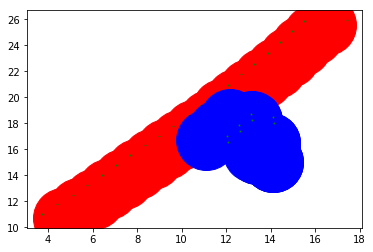

PREY :  0 :  [4.937621713844819, 2.0019474215171114]
(5.272374033572508, 2.944253573697458)
(4.029833355261311, 2.42137595657435)
PRED :  0 :  [1.9267256169615723, 16.375738780094885]
(2.301281213210262, 17.302943237223296)
(2.374636186445349, 17.269817144526503)
PREY :  0 :  [4.82077040979633, 1.0087980003612778]
(5.1555227295240185, 1.9511041525416246)
(3.9129820512128224, 1.4282265354185164)
PRED :  0 :  [2.905524402617563, 16.580562941751555]
(3.2800799988662526, 17.507767398879967)
(3.35343497210134, 17.474641306183173)
PREY :  0 :  [4.648163790107745, 0.02380716038372732]
(4.9829161098354335, 0.9661133125640743)
(3.7403754315242375, 0.44323569544096597)
PRED :  0 :  [3.9055112862430437, 16.585684716541582]
(4.280066882491733, 17.512889173669993)
(4.35342185572682, 17.4797630809732)
PREY :  0 :  [4.648163790107745, 0.02380716038372732]
(4.9829161098354335, 0.9661133125640743)
(3.7403754315242375, 0.44323569544096597)
PRED :  0 :  [4.905498169868524, 16.59080649133161]
(5.280053766

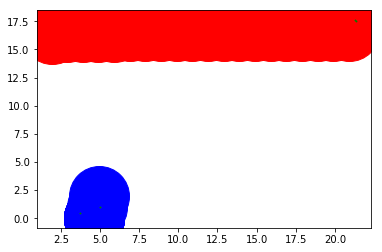

PREY :  0 :  [19.15200169599491, 18.47000105999682]
(18.22827973173826, 18.85306467449164)
(19.230823587975745, 19.466889774620757)
PRED :  0 :  [16, 10]
(15.738461317758897, 10.965192995048962)
(16.758187507494824, 10.652036581396153)
PREY :  0 :  [18.304003391989824, 17.940002119993643]
(17.380281427733173, 18.323065734488463)
(18.382825283970657, 18.93689083461758)
PRED :  0 :  [16, 10]
(15.537242484348754, 9.113515097867829)
(16.60043230048233, 9.200324407939382)
PREY :  0 :  [17.456005087984735, 17.410003179990465]
(16.532283123728085, 17.793066794485284)
(17.53482697996557, 18.4068918946144)
PRED :  0 :  [16, 10]
(16.34787099974104, 10.93754240839504)
(16.99592102326504, 10.090229238158798)
PREY :  0 :  [16.608006783979647, 16.880004239987286]
(15.684284819722997, 17.263067854482106)
(16.68682867596048, 17.876892954611222)
PRED :  0 :  [16, 10]
(16.067704524008192, 10.997705416156906)
(15.12892416184826, 10.491148535769215)
PREY :  0 :  [15.760008479974559, 16.350005299984108]
(1

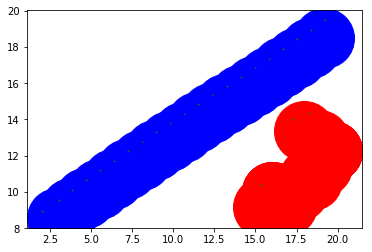

PREY :  0 :  [13, 11]
(13.878530110736673, 11.477686973371693)
(13.978560557856257, 11.205959303281137)
PRED :  0 :  [19.763386285369116, 20.645942241466173]
(20.65843371784432, 21.09191319749307)
(19.899716246984934, 19.655278755934468)
PREY :  0 :  [12.21501359642441, 11.619512991148257]
(13.093543707161082, 12.09719996451995)
(13.193574154280666, 11.825472294429394)
PRED :  0 :  [20.4879338695295, 21.335167022134534]
(21.382981302004705, 21.781137978161432)
(20.624263831145317, 20.34450353660283)
PREY :  0 :  [12.21501359642441, 11.619512991148257]
(11.926072449626178, 12.576859852890083)
(11.374308232658231, 12.161005827051724)
PRED :  0 :  [20.4879338695295, 21.335167022134534]
(20.632880686623892, 22.324606469606792)
(21.379065993940372, 20.881423111053667)
PREY :  0 :  [12.631309109651205, 12.528742360266545]
(12.342367962852974, 13.48608922200837)
(11.790603745885027, 13.070235196170012)
PRED :  0 :  [19.738703220823133, 21.997476190906216]
(19.883650037917526, 22.9869156383784

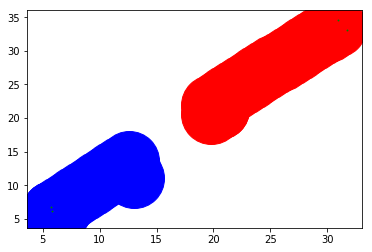

PREY :  0 :  [19, 4]
(18.139622446321695, 3.4903427964537954)
(18.021174537852286, 3.7953033594527925)
PRED :  0 :  [3.978549784986749, 4.206010481049842]
(4.112623648624268, 3.2150391398450076)
(4.954787577169708, 4.422712518681568)
PREY :  0 :  [19.939478211733825, 4.342608653827385]
(19.07910065805552, 3.832951450281181)
(18.96065274958611, 4.137912013280178)
PRED :  0 :  [4.95564531700442, 4.418811611946991]
(5.089719180641939, 3.4278402707421565)
(5.931883109187378, 4.635513649578717)
PREY :  0 :  [19.939478211733825, 4.342608653827385]
(20.639871898934185, 3.628851914503766)
(20.372025720735056, 3.440997511229409)
PRED :  0 :  [5.93274084902209, 4.631612742844139]
(6.0668147126596095, 3.6406414016393045)
(6.9089786412050485, 4.848314780475865)
PREY :  0 :  [20.444646339476698, 5.205629605318575]
(21.14504002667706, 4.491872865994956)
(20.87719384847793, 4.304018462720598)
PRED :  0 :  [6.901820595135673, 4.878360479758652]
(7.035894458773193, 3.887389138553818)
(7.878058387318632

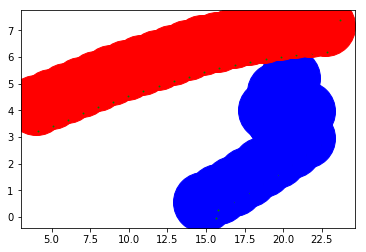

PREY :  0 :  [19.883158752432603, 8.006849395677124]
(19.354056977085328, 7.1582910233040975)
(19.268250824066083, 7.218250486451405)
PRED :  0 :  [2.9276121375618382, 17.373544806211996]
(1.9999265150170258, 17.000182534786983)
(3.8584190312404707, 17.739056128444748)
PREY :  0 :  [19.71699166517363, 7.020751784326265]
(19.187889889826355, 6.172193411953239)
(19.10208373680711, 6.232152875100546)
PRED :  0 :  [3.8696719024996495, 17.708989882618425]
(2.941986279954837, 17.335627611193413)
(4.800478796178282, 18.074501204851178)
PREY :  0 :  [19.503514312660112, 6.043803771398341]
(18.974412537312837, 5.195245399025315)
(18.888606384293592, 5.255204862172622)
PRED :  0 :  [4.824860882464483, 18.004986525426652]
(3.8971752599196705, 17.63162425400164)
(5.755667776143115, 18.370497847659404)
PREY :  0 :  [19.244673279888257, 5.07788383695574]
(18.715571504540982, 4.229325464582714)
(18.629765351521737, 4.289284927730021)
PRED :  0 :  [5.791768325772276, 18.26011393688216]
(4.864082703227

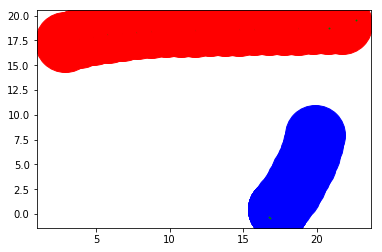

PREY :  0 :  [14, 2]
(14.63818612509576, 2.7698821141806445)
(14.882442087557457, 1.529578952312678)
PRED :  0 :  [20, 3]
(20.957818908309697, 3.2873724741244725)
(19.02155719811277, 3.2065179978478087)
PREY :  0 :  [14.948078299348204, 1.6819629922398667]
(15.586264424443964, 2.451845106420511)
(15.830520386905661, 1.2115419445525446)
PRED :  0 :  [20.497563237874697, 2.1325722944731087]
(21.455382146184395, 2.4199447685975812)
(19.519120435987467, 2.3390902923209174)
PREY :  0 :  [15.925826590239542, 1.8917444968084713]
(16.564012715335302, 2.6616266109891162)
(16.808268677797, 1.4213234491211493)
PRED :  0 :  [21.398350460760227, 2.566833021555555]
(22.356169369069924, 2.8542054956800276)
(20.419907658872997, 2.7733510194033637)
PREY :  0 :  [16.84920564586397, 2.275633959589276]
(17.487391770959732, 3.045516073769921)
(17.73164773342143, 1.805212911901954)
PRED :  0 :  [20.61203806714829, 3.184662140044047]
(21.569856975457988, 3.4720346141685194)
(19.63359526526106, 3.391180137891

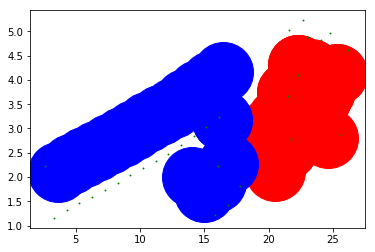

PREY :  0 :  [19.051316701949485, 8.683772233983163]
(18.120579841973306, 9.049461853034185)
(18.085954086721756, 8.42286033099543)
PRED :  0 :  [8.010276581562216, 2.857005052551397]
(7.576151964806804, 1.956152224878105)
(9.010266417351493, 2.86151374616869)
PREY :  0 :  [18.109433048733646, 8.3478329778597]
(17.178696188757467, 8.713522596910721)
(17.144070433505917, 8.086921074871967)
PRED :  0 :  [8.010276581562216, 2.857005052551397]
(8.896791823084248, 2.394305661424573)
(8.037735832553885, 3.8566279762256075)
PREY :  0 :  [17.167549395517806, 8.011893721736236]
(16.236812535541628, 8.377583340787258)
(16.202186780290077, 7.750981818748502)
PRED :  0 :  [8.334216908372376, 1.9109275374047117]
(9.220732149894408, 1.4482281462778879)
(8.361676159364045, 2.9105504610789223)
PREY :  0 :  [16.192842619681294, 7.788406135641635]
(15.262105759705113, 8.154095754692657)
(15.227480004453565, 7.527494232653901)
PRED :  0 :  [8.334216908372376, 1.9109275374047117]
(8.684590553129494, 2.847

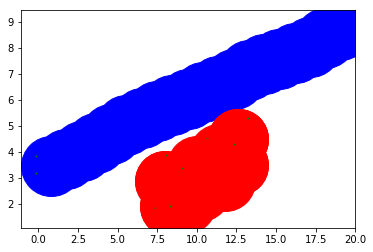

PREY :  0 :  [16, 13]
(16.612124579520444, 13.79076134145956)
(15.43612887206242, 13.825862791920304)
PRED :  0 :  [6.776114000116266, 7.630592625094466]
(5.8513892560274146, 8.011229128427775)
(7.747105947526203, 7.8697048122892195)
PREY :  0 :  [16.227209339181037, 13.973845940685136]
(16.83933391870148, 14.764607282144695)
(15.663338211243458, 14.799708732605442)
PRED :  0 :  [7.533873204506387, 8.283126906310443]
(6.6091484604175355, 8.663763409643751)
(8.504865151916324, 8.522239093505197)
PREY :  0 :  [16.88036826597891, 14.731066791127231]
(17.492492845499353, 15.52182813258679)
(16.316497138041328, 15.556929583047538)
PRED :  0 :  [8.287317562767903, 8.940638578453145]
(7.362592818679052, 9.321275081786453)
(9.25830951017784, 9.1797507656479)
PREY :  0 :  [16.88036826597891, 14.731066791127231]
(17.329760585367897, 15.624401299177931)
(16.378494449462845, 13.866125942111761)
PRED :  0 :  [9.04076192102942, 9.598150250595847]
(8.116037176940567, 9.978786753929155)
(10.0117538684

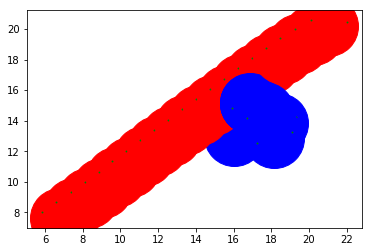

PREY :  0 :  [18.078576732845583, 13.388560372074254]
(18.07022236085532, 14.38852547369963)
(18.40294904252738, 14.33448986453746)
PRED :  0 :  [4.803620503386028, 10.595142072565523]
(5.801505693764761, 10.530140943169174)
(5.049818786904555, 11.564361555031972)
PREY :  0 :  [18.078576732845583, 13.388560372074254]
(17.128721816892995, 13.701251335552097)
(17.078790511134397, 13.409236708221417)
PRED :  0 :  [5.607241006772057, 11.190284145131045]
(6.605126197150789, 11.125283015734697)
(5.853439290290583, 12.159503627597495)
PREY :  0 :  [18.078576732845583, 13.388560372074254]
(17.546717389751468, 14.235393082332601)
(17.85830586754842, 14.363999117409522)
PRED :  0 :  [6.410861510158085, 11.785426217696568]
(7.408746700536818, 11.72042508830022)
(6.657059793676612, 12.754645700163017)
PREY :  0 :  [18.078576732845583, 13.388560372074254]
(18.739947619677682, 14.138619403118426)
(18.951590201817428, 13.876256469038077)
PRED :  0 :  [7.214482013544114, 12.38056829026209]
(8.21236720

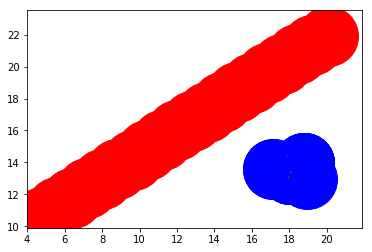

PREY :  0 :  [2.5143570688213677, 11.125842723878462]
(2.06337754124159, 12.0183770177316)
(3.507029403874787, 11.005005497745156)
PRED :  0 :  [10.384669325061097, 18.923054446041533]
(9.7050703144621, 19.656638241386595)
(9.713346571684779, 18.181889308707593)
PREY :  0 :  [2.033256981554986, 10.249177048702183]
(1.582277453975208, 11.141711342555322)
(3.0259293166084054, 10.128339822568877)
PRED :  0 :  [11.28417012763023, 19.35997355317406]
(10.604571117031233, 20.093557348519123)
(10.612847374253912, 18.61880841584012)
PREY :  0 :  [1.529690571959518, 9.385220527153136]
(1.07871104437974, 10.277754821006274)
(2.5223629070129374, 9.26438330101983)
PRED :  0 :  [12.186952953167424, 19.79007025150489]
(11.507353942568427, 20.523654046849952)
(11.515630199791106, 19.04890511417095)
PREY :  0 :  [1.0053295204300272, 8.533724498014488]
(0.5543499928502494, 9.426258791867626)
(1.9980018554834467, 8.412887271881182)
PRED :  0 :  [12.186952953167424, 19.79007025150489]
(12.678062734624046,

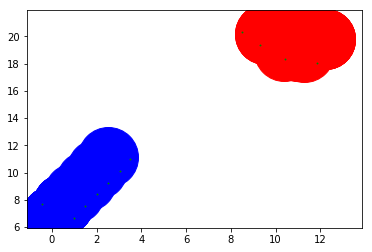

PREY :  0 :  [16.534253567167376, 10.115081777618018]
(17.312610091045524, 10.742904301693352)
(17.281477618860134, 9.450509571930887)
PRED :  0 :  [10.853033456988417, 19.521856226616478]
(10.126132030063035, 18.835114415210004)
(11.589993227205474, 20.19779283391159)
PREY :  0 :  [16.04835209194677, 9.241068187118167]
(16.82670861582492, 9.868890711193501)
(16.79557614363953, 8.576495981431036)
PRED :  0 :  [11.719630043473995, 20.02086560157004]
(10.992728616548613, 19.334123790163567)
(12.456589813691052, 20.69680220886515)
PREY :  0 :  [15.543169713298703, 8.378055577532722]
(16.32152623717685, 9.005878101608056)
(16.29039376499146, 7.71348337184559)
PRED :  0 :  [12.599896416053193, 20.495345436026952]
(11.872994989127811, 19.808603624620478)
(13.33685618627025, 21.171282043322062)
PREY :  0 :  [15.019452925438635, 7.526163139420062]
(15.797809449316784, 8.153985663495396)
(15.766676977131393, 6.86159093373293)
PRED :  0 :  [13.493931906183196, 20.943341577068374]
(12.76703047925

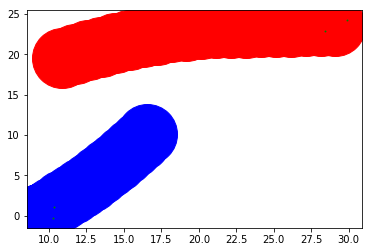

PREY :  0 :  [19, 6]
(18.675809649829404, 5.054008130660592)
(18.240104663026198, 6.6500454421388335)
PRED :  0 :  [14.953582665134142, 5.3011313679370975]
(14.48030609700973, 4.420217473129904)
(15.448822841187235, 6.169887471813727)
PREY :  0 :  [19, 6]
(18.557739491720916, 6.896886638777012)
(19.996751242842535, 6.080541665564237)
PRED :  0 :  [15.907165330268285, 5.602262735874195]
(15.433888762143873, 4.721348841067002)
(16.402405506321376, 6.471018839750824)
PREY :  0 :  [19, 6]
(19.53694447968155, 5.156382417359911)
(18.017868035335603, 5.811806471991065)
PRED :  0 :  [16.860747995402427, 5.9033941038112925]
(16.387471427278015, 5.022480209004099)
(17.355988171455518, 6.772150207687922)
PREY :  0 :  [19.981110931162437, 6.193445963394366]
(20.51805541084399, 5.349828380754277)
(18.99897896649804, 6.00525243538543)
PRED :  0 :  [17.815914763678986, 6.199462414814196]
(17.342638195554574, 5.318548520007003)
(18.311154939732077, 7.068218518690825)
PREY :  0 :  [19.981110931162437, 

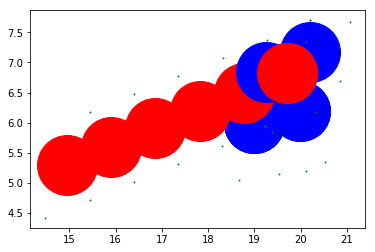

PREY :  0 :  [17.74233734943967, 6.033765060398753]
(16.803467451084238, 5.689492909387285)
(18.21707447006842, 6.913892702446837)
PRED :  0 :  [4.946750456645534, 15.321968279247312]
(4.011046241643017, 14.969182760799454)
(5.686320191127196, 15.99504822088777)
PREY :  0 :  [17.435099429599543, 5.0821323262978755]
(16.49622953124411, 4.737860175286407)
(17.909836550228295, 5.962259968345959)
PRED :  0 :  [5.906796401540966, 15.60181070578381]
(4.971092186538449, 15.249025187335953)
(6.646366136022628, 16.274890647424268)
PREY :  0 :  [17.081028607981626, 4.1469137137377885]
(16.142158709626194, 3.80264156272632)
(17.55576572861038, 5.027041355785872)
PRED :  0 :  [6.878567534918667, 15.837736254069318]
(5.94286331991615, 15.48495073562146)
(7.6181372694003295, 16.510816195709776)
PREY :  0 :  [16.68266318826838, 3.2296869193315807]
(15.743793289912947, 2.8854147683201123)
(17.15740030889713, 4.109814561379665)
PRED :  0 :  [7.860338772939575, 16.027802653506182]
(6.924634557937058, 15

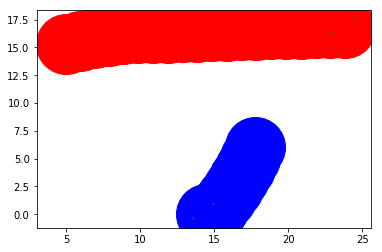

PREY :  0 :  [9.641020920691131, 6.066654393796941]
(8.935534091643662, 5.357931363240895)
(9.563399691769266, 5.0696714727693735)
PRED :  0 :  [5.846376021164676, 13.532585796653885]
(4.892878722176698, 13.833987357404041)
(6.743550081908152, 13.974262946537213)
PREY :  0 :  [9.244427140964596, 5.148660181461035]
(8.538940311917127, 4.439937150904989)
(9.166805912042731, 4.151677260433468)
PRED :  0 :  [6.720016568093217, 14.019157677019365]
(5.766519269105239, 14.32055923776952)
(7.617190628836694, 14.460834826902694)
PREY :  0 :  [8.812176001124648, 4.246906915812906]
(8.106689172077179, 3.53818388525686)
(8.734554772202783, 3.249923994785339)
PRED :  0 :  [7.620858053253906, 14.453305829858328]
(6.667360754265928, 14.754707390608484)
(8.518032113997384, 14.894982979741656)
PREY :  0 :  [8.345765686372506, 3.3623384231042808]
(7.640278857325035, 2.653615392548235)
(8.26814445745064, 2.365355502076714)
PRED :  0 :  [8.548410873322005, 14.826997903608516]
(7.5949135743340275, 15.12839

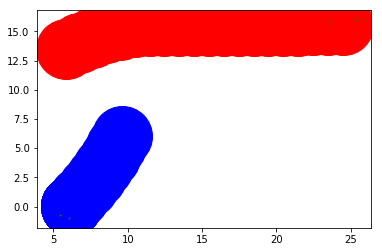

PREY :  0 :  [0.3356361611700802, 11.25259068131634]
(0.5426739744803294, 12.230923622527925)
(-0.18300826381970314, 10.39760064603697)
PRED :  0 :  [8, 9]
(7.0324617399820335, 9.252724584085929)
(7.105151901147859, 8.553629212446973)
PREY :  0 :  [0.3356361611700802, 11.25259068131634]
(0.5426739744803294, 12.230923622527925)
(-0.18300826381970314, 10.39760064603697)
PRED :  0 :  [7.019339866369359, 9.19571842608077]
(6.051801606351392, 9.448443010166699)
(6.124491767517218, 8.749347638527743)
PREY :  0 :  [0.3356361611700802, 11.25259068131634]
(0.5426739744803294, 12.230923622527925)
(-0.18300826381970314, 10.39760064603697)
PRED :  0 :  [7.019339866369359, 9.19571842608077]
(6.253716194632576, 8.55242969364697)
(6.137749680825089, 9.667734045263037)
PREY :  0 :  [0.3356361611700802, 11.25259068131634]
(0.5426739744803294, 12.230923622527925)
(-0.18300826381970314, 10.39760064603697)
PRED :  0 :  [7.019339866369359, 9.19571842608077]
(6.116782796560182, 9.626288670916004)
(6.2246712

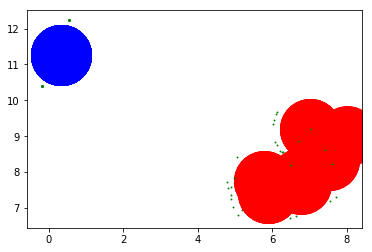

PREY :  0 :  [5.148341683295456, 13.475902574335665]
(4.297148414756805, 12.951050195476153)
(6.136810573914118, 13.627326655244588)
PRED :  0 :  [13.35688288120225, 8.934149136436352]
(13.793979828362868, 9.833563534132356)
(13.779302758707608, 9.840549405130243)
PREY :  0 :  [4.317141389547372, 12.919929488950142]
(3.4659481210087204, 12.39507711009063)
(5.305610280166033, 13.071353569859065)
PRED :  0 :  [13.673804169897998, 9.882600978530311]
(14.110901117058617, 10.782015376226315)
(14.096224047403357, 10.789001247224203)
PREY :  0 :  [3.506661272634627, 12.334163340995941]
(2.655468004095976, 11.80931096213643)
(4.495130163253289, 12.485587421904864)
PRED :  0 :  [13.947271586763353, 10.844482245586173]
(14.384368533923972, 11.743896643282177)
(14.369691464268712, 11.750882514280065)
PREY :  0 :  [2.7172159206181155, 11.720342490763949]
(1.8660226520794645, 11.195490111904437)
(3.705684811236777, 11.871766571672872)
PRED :  0 :  [14.173119108162748, 11.81864491017446]
(14.6102160

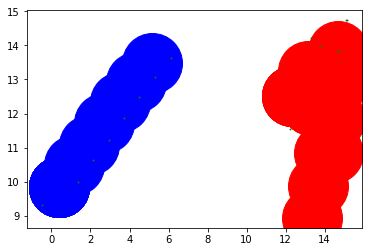

PREY :  0 :  [3.223885999883734, 7.369407374905534]
(4.070793743687, 7.901147229990764)
(4.1640301797320625, 7.710184312354819)
PRED :  0 :  [16, 13]
(16.554427621787685, 13.832231946153746)
(16.928978495283523, 13.37013369922335)
PREY :  0 :  [2.4477719997674683, 6.738814749811068]
(3.2946797435707342, 7.270554604896298)
(3.3879161796157966, 7.079591687260353)
PRED :  0 :  [15.88849458614486, 12.006236173590025]
(16.442922207932547, 12.838468119743771)
(16.817473081428382, 12.376369872813376)
PREY :  0 :  [1.6499432198541477, 6.135930649886363]
(2.4968509636574137, 6.667670504971593)
(2.590087399702476, 6.476707587335648)
PRED :  0 :  [16.88615377430712, 12.074618512504536]
(17.440581396094807, 12.906850458658282)
(17.815132269590645, 12.444752211727886)
PREY :  0 :  [0.8365078717345353, 5.554275309990368]
(1.6834156155378015, 6.086015165075598)
(1.7766520515828637, 5.895052247439653)
PRED :  0 :  [17.57821692144004, 11.352781550039685]
(18.132644543227723, 12.18501349619343)
(18.5071

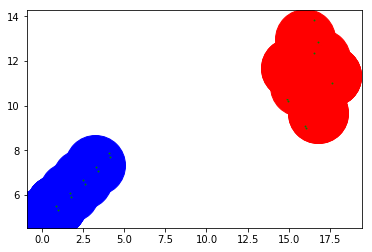

PREY :  0 :  [7.552786404500042, 18.105572809000083]
(8.453703791082734, 18.5395634339599)
(7.009212216589576, 17.26621168157192)
PRED :  0 :  [2.496046666632081, 3.1317041376793266]
(3.176478027720511, 3.8645159572123813)
(2.651577823325069, 4.1195351248920895)
PREY :  0 :  [6.929510932235907, 17.32357045243463]
(7.8304283188185995, 17.757561077394445)
(6.385936744325441, 16.484209325006468)
PRED :  0 :  [2.862635280602745, 2.2013209971898466]
(3.5430666416911754, 2.9341328167229013)
(3.0181664372957333, 3.189151984402609)
PREY :  0 :  [6.136792451758006, 16.713982550070412]
(7.037709838340699, 17.147973175030227)
(5.5932182638475405, 15.874621422642248)
PRED :  0 :  [3.207302406090259, 3.1400459689511044]
(3.8877337671786893, 3.872857788484159)
(3.3628335627832473, 4.127876956163867)
PREY :  0 :  [5.422233286934974, 16.01440753624601]
(6.323150673517667, 16.448398161205827)
(4.8786590990245084, 15.175046408817847)
PRED :  0 :  [3.207302406090259, 3.1400459689511044]
(3.11175907780394

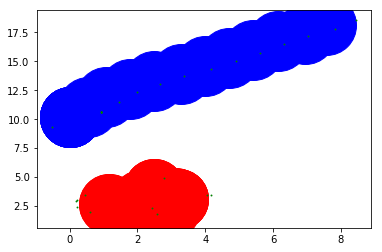

PREY :  0 :  [14.426537655636672, 6.18076807948096]
(14.18925172367374, 7.1522079317067595)
(13.719364965389266, 6.887808945462727)
PRED :  0 :  [7.919191941322262, 10.393809820863082]
(8.163318492539322, 11.363553202893021)
(6.979563200554216, 10.73600542212449)
PREY :  0 :  [13.820489659098312, 5.385340002347747]
(13.58320372713538, 6.3567798545735466)
(13.113316968850906, 6.092380868329514)
PRED :  0 :  [8.850952601399218, 10.756882915890726]
(9.095079152616277, 11.726626297920665)
(7.911323860631173, 11.099078517152135)
PREY :  0 :  [13.185109992669569, 4.613140106278796]
(12.947824060706637, 5.584579958504595)
(12.477937302422163, 5.320180972260563)
PRED :  0 :  [9.79484774633106, 11.08712821165449]
(10.038974297548119, 12.056871593684429)
(8.855219005563015, 11.429323812915898)
PREY :  0 :  [12.523029084263907, 3.8637077406014564]
(12.285743152300975, 4.835147592827256)
(11.815856394016501, 4.570748606583224)
PRED :  0 :  [10.750401963162199, 11.381943643231988]
(10.9945285143792

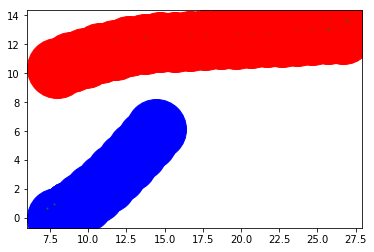

PREY :  0 :  [16.936636376539383, 12.350303151774535]
(15.977623717407274, 12.066939922642097)
(17.63611502747565, 13.064956646052973)
PRED :  0 :  [14.807992257644113, 18.589193102121172]
(14.057345965800941, 19.249897381312778)
(15.786915162394362, 18.793423233481207)
PREY :  0 :  [16.313568328298377, 11.56813551804047]
(15.354555669166269, 11.284772288908034)
(17.013046979234645, 12.282789012318908)
PRED :  0 :  [15.623717303289892, 19.167632943337345]
(14.87307101144672, 19.82833722252895)
(16.60264020804014, 19.37186307469738)
PREY :  0 :  [15.681758169034543, 10.793012351923622]
(14.722745509902435, 10.509649122791185)
(16.38123681997081, 11.507665846202059)
PRED :  0 :  [16.44746966022522, 19.734582724573293]
(15.696823368382049, 20.3952870037649)
(17.42639256497547, 19.938812855933328)
PREY :  0 :  [15.041528191622646, 10.024829056073497]
(14.082515532490538, 9.74146582694106)
(15.741006842558912, 10.739482550351934)
PRED :  0 :  [17.279592880250966, 20.289173516684002]
(16.528

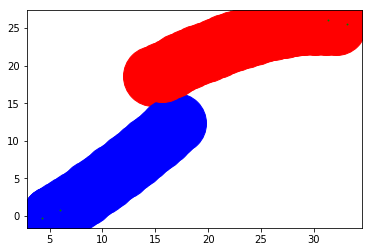

PREY :  0 :  [9, 2]
(8.807254349164168, 2.981248752398632)
(8.721830648405193, 1.0394679537707632)
PRED :  0 :  [10.976187060183953, 6.216930457818656]
(11.938190008264204, 6.489969517084734)
(10.669050470306109, 5.2652650149458955)
PREY :  0 :  [9, 2]
(9.75057524280806, 2.660784991418255)
(9.68964881991082, 1.275856019015822)
PRED :  0 :  [11.952374120367907, 6.433860915637313]
(12.914377068448157, 6.70689997490339)
(11.645237530490062, 5.482195472764552)
PREY :  0 :  [9, 2]
(8.000015774917598, 2.005616901845933)
(8.003385661277179, 2.0822183668779206)
PRED :  0 :  [12.92856118055186, 6.650791373455969]
(13.89056412863211, 6.923830432722046)
(12.621424590674016, 5.699125930583208)
PREY :  0 :  [8.307709553851653, 1.2783810297866864]
(7.3077253287692505, 1.283997931632619)
(7.311095215128832, 1.3605993966646068)
PRED :  0 :  [13.916928016741926, 6.802880153843082]
(14.878930964822178, 7.0759192131091595)
(13.609791426864081, 5.851214710970321)
PREY :  0 :  [7.409300962139296, 0.8392204

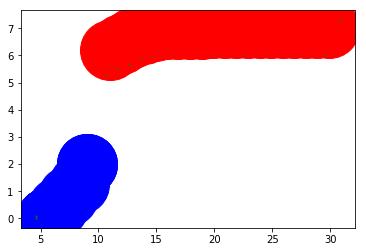

PREY :  0 :  [1.268944731757131, 3.317681749639989]
(0.7029210190308844, 2.493292790087767)
(1.8347297922222854, 4.14223451651088)
PRED :  0 :  [15.556018647980883, 13.168830183959072]
(16.42230377570249, 13.668380058834805)
(14.79441509439543, 12.520786954563063)
PREY :  0 :  [0.505704720554109, 2.6715666783881176]
(-0.06031899217213754, 1.8471777188358953)
(1.0714897810192632, 3.4961194452590085)
PRED :  0 :  [15.556018647980883, 13.168830183959072]
(14.58031178381814, 12.949750026880194)
(16.555260645156753, 13.129901645841448)
PREY :  0 :  [0.505704720554109, 2.6715666783881176]
(-0.06031899217213754, 1.8471777188358953)
(1.0714897810192632, 3.4961194452590085)
PRED :  0 :  [16.114663787740803, 12.33942340328832]
(15.138956923578059, 12.120343246209442)
(17.113905784916675, 12.300494865170696)
PREY :  0 :  [0.505704720554109, 2.6715666783881176]
(-0.06031899217213754, 1.8471777188358953)
(1.0714897810192632, 3.4961194452590085)
PRED :  0 :  [16.114663787740803, 12.33942340328832]
(

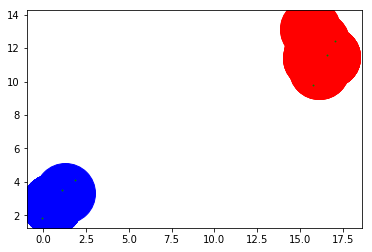

PREY :  0 :  [17.9764492704666, 16.78425287439865]
(18.828694883199287, 16.261111004942684)
(18.50156389604598, 17.635284383805104)
PRED :  0 :  [18.730928827423988, 19.68245369750672]
(18.289080853348477, 20.579543641606733)
(19.134056570704313, 20.59759741441555)
PREY :  0 :  [17.76963287066046, 17.76263264563844]
(18.621878483393147, 17.239490776182475)
(18.29474749623984, 18.613664155044894)
PRED :  0 :  [19.438174902258815, 20.38942115759999]
(18.996326928183304, 21.286511101700004)
(19.84130264553914, 21.30456487450882)
PREY :  0 :  [18.059138025103433, 16.805456190876335]
(18.91138363783612, 16.28231432142037)
(18.584252650682814, 17.65648770028279)
PRED :  0 :  [20.170235118465623, 21.070661085853793]
(19.728387144390112, 21.967751029953806)
(20.57336286174595, 21.985804802762623)
PREY :  0 :  [18.059138025103433, 16.805456190876335]
(17.6043526914933, 15.9148551015366)
(18.948683250730273, 16.348609070315753)
PRED :  0 :  [20.90229533467243, 21.751901014107595]
(20.46044736059

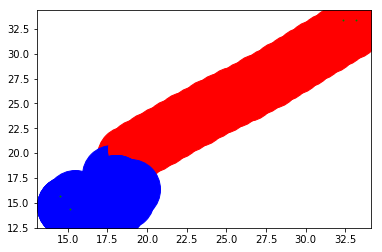

PREY :  0 :  [4.754803402450765, 3.655951083274316]
(5.69694534967074, 3.991165270457009)
(4.470925509430235, 2.6970906440787963)
PRED :  0 :  [15.792752084195214, 17.60954420102577]
(15.406421661108123, 16.687183748600933)
(16.720091083427455, 17.983766568747082)
PREY :  0 :  [5.49714832861261, 4.325969001394245]
(6.439290275832585, 4.661183188576938)
(5.21327043559208, 3.367108562198726)
PRED :  0 :  [16.57859926313208, 18.227964940779028]
(16.19226884004499, 17.30560448835419)
(17.50593826236432, 18.60218730850034)
PREY :  0 :  [6.483536869000211, 4.161537716682309]
(7.425678816220186, 4.496751903865002)
(6.199658975979681, 3.2026772774867895)
PRED :  0 :  [17.420158368835583, 18.7681299818614]
(17.03382794574849, 17.845769529436563)
(18.347497368067824, 19.142352349582712)
PREY :  0 :  [6.483536869000211, 4.161537716682309]
(7.092197061149593, 3.3681067048780826)
(5.483841956122543, 4.136837895498506)
PRED :  0 :  [18.261717474539086, 19.30829502294377]
(17.875387051451995, 18.3859

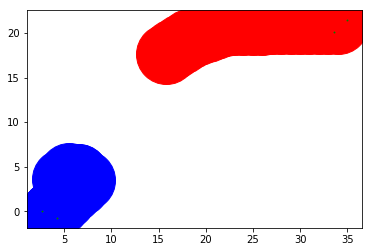

PREY :  0 :  [10.950062383056109, 5.0012476611221555]
(10.319529604383247, 4.225085039618724)
(10.901207922344577, 4.002441753215827)
PRED :  0 :  [1.9096156176312724, 20.41545087334278]
(1.0466347406358811, 20.92068745746973)
(2.3532705002437457, 19.519253157917156)
PREY :  0 :  [10.856931149342865, 4.005593819012836]
(10.226398370670003, 3.2294311975094048)
(10.808076688631333, 3.0067879111065077)
PRED :  0 :  [2.847799644808921, 20.76158774099592]
(1.9848187678135298, 21.26682432512287)
(3.2914545274213944, 19.865390025570296)
PREY :  0 :  [10.721036842400865, 3.0148704785485303]
(10.090504063728003, 2.2387078570450987)
(10.672182381689334, 2.0160645706422016)
PRED :  0 :  [3.8104604399999094, 21.032298275335194]
(2.947479563004518, 21.53753485946214)
(4.254115322612383, 20.13610055990957)
PREY :  0 :  [10.542767064209858, 2.03088882923604]
(9.912234285536996, 1.2547262077326082)
(10.493912603498327, 1.0320829213297111)
PRED :  0 :  [4.792407530780282, 21.221454060094644]
(3.9294266

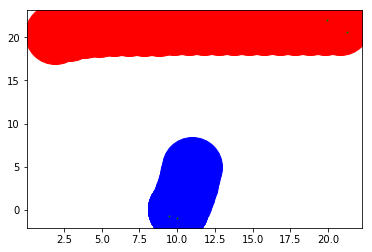

PREY :  0 :  [14.93762171384482, 11.001947421517112]
(13.93798109992085, 10.97513990403208)
(14.037240797904499, 10.566844897724765)
PRED :  0 :  [1.8051773522294665, 16.59303408962449]
(1.0449301927423937, 17.242668030003095)
(1.6496077222187917, 15.60520916069308)
PREY :  0 :  [14.829468580614362, 10.007813175163816]
(13.829827966690393, 9.981005657678784)
(13.929087664674041, 9.57271065137147)
PRED :  0 :  [2.634079886896302, 17.152427142873183]
(1.8738327274092292, 17.802061083251793)
(2.478510256885627, 16.164602213941773)
PREY :  0 :  [14.677679077811854, 9.019400332856025]
(13.678038463887885, 8.992592815370992)
(13.777298161871533, 8.584297809063678)
PRED :  0 :  [3.4860753043949444, 17.675976384646404]
(2.7258281449078714, 18.32561032502501)
(3.3305056743842694, 16.688151455714994)
PREY :  0 :  [14.484185176312801, 8.038298854882072]
(13.484544562388832, 8.01149133739704)
(13.58380426037248, 7.603196331089726)
PRED :  0 :  [4.360449577580654, 18.161228515389755]
(3.60020241809

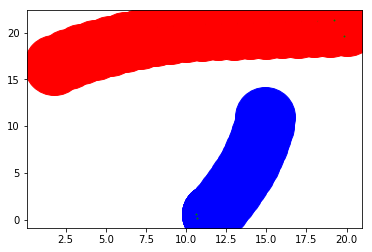

PREY :  0 :  [18.292893218813454, 18.292893218813454]
(17.293688009230948, 18.332754843757552)
(18.1380693433402, 19.280835305974154)
PRED :  0 :  [16, 16]
(15.710755782112457, 15.04274466184898)
(16.05595016261884, 16.998433562788694)
PREY :  0 :  [17.585786437626908, 17.585786437626908]
(16.586581228044402, 17.625648062571006)
(17.430962562153653, 18.573728524787608)
PRED :  0 :  [16, 16]
(16.392819722054256, 15.080384501019466)
(15.4018796529609, 16.801406295494257)
PREY :  0 :  [16.87867965644036, 16.87867965644036]
(15.879474446857857, 16.91854128138446)
(16.723855780967106, 17.866621743601062)
PRED :  0 :  [16.65978705349511, 15.248547377381485]
(17.052606775549364, 14.328931878400951)
(16.06166670645601, 16.04995367287574)
PREY :  0 :  [16.14102012307907, 16.2035067801774]
(15.141814913496566, 16.243368405121497)
(15.986196247605816, 17.1914488673381)
PRED :  0 :  [16.65978705349511, 15.248547377381485]
(17.55438342692116, 15.695422447902272)
(15.895413401935652, 14.603773835119

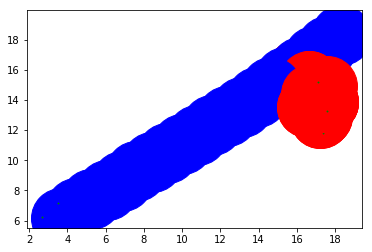

PREY :  0 :  [9.122104427085615, 14.521147869319426]
(10.106756602810481, 14.695676070021454)
(8.538321025271687, 13.70923842870024)
PRED :  0 :  [11.531942709368266, 6.846780345750861]
(11.104522690939689, 7.750833512244134)
(12.527744617646587, 6.938314817231597)
PREY :  0 :  [8.262239515403426, 14.010626240338066]
(9.246891691128292, 14.185154441040094)
(7.678456113589498, 13.19871679971888)
PRED :  0 :  [12.039907772527354, 7.708158018209222]
(11.612487754098776, 8.612211184702495)
(13.035709680805674, 7.799692489689958)
PREY :  0 :  [7.420051240078176, 13.471442682628188]
(8.404703415803041, 13.645970883330216)
(6.8362678382642486, 12.659533242009003)
PRED :  0 :  [12.522363457189606, 8.584078398344927]
(12.094943438761028, 9.4881315648382)
(13.518165365467926, 8.675612869825663)
PREY :  0 :  [6.5952399078602975, 12.906034629762853]
(7.579892083585164, 13.080562830464881)
(6.01145650604637, 12.094125189143668)
PRED :  0 :  [12.984650036421387, 9.470808976740742]
(12.55723001799281

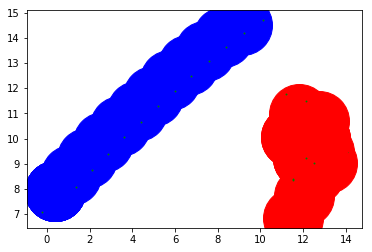

PREY :  0 :  [7, 7]
(6.194995020690861, 7.593268053486359)
(6.636122079956417, 6.0685533513374175)
PRED :  0 :  [14.707106781186548, 15.707106781186548]
(15.670916953574675, 15.973696262601644)
(14.439003702317759, 14.743716549192744)
PREY :  0 :  [7.96902463775386, 6.753035930900869]
(7.164019658444721, 7.3463039843872275)
(7.6051467177102765, 5.821589282238286)
PRED :  0 :  [15.470020078225895, 16.353607594179504]
(16.433830250614022, 16.6201970755946)
(15.201916999357106, 15.3902173621857)
PREY :  0 :  [6.973952894852562, 6.653878346826962]
(6.1689479155434235, 7.247146400313321)
(6.610074974808979, 5.72243169816438)
PRED :  0 :  [16.19353502659755, 17.043916307352646]
(17.157345198985677, 17.310505788767742)
(15.925431947728763, 16.080526075358843)
PREY :  0 :  [6.973952894852562, 6.653878346826962]
(7.942892350712974, 6.901176407629974)
(6.483529676906989, 7.525362751334529)
PRED :  0 :  [16.917049974969206, 17.734225020525788]
(17.880860147357332, 18.000814501940884)
(16.64894689

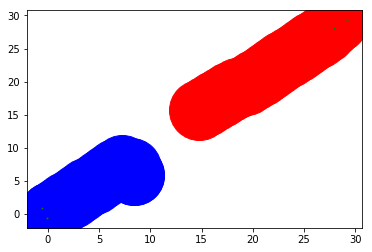

PREY :  0 :  [1.4700010599968203, 10.152001695994912]
(1.5836878470533853, 11.14551833624245)
(1.6667944021884518, 11.132446687041858)
PRED :  0 :  [5.2455996035023285, 7.0306286393958715]
(5.5511869109247876, 7.982792699598887)
(6.194368201916509, 7.346600389182447)
PREY :  0 :  [0.8719999906350816, 9.350506392800803]
(0.9856867776916465, 10.344023033048341)
(1.068793332826713, 10.330951383847749)
PRED :  0 :  [5.2455996035023285, 7.0306286393958715]
(4.439624699460293, 6.438678933716047)
(4.291838177210781, 7.331193344107375)
PREY :  0 :  [0.2739989212733429, 8.549011089606694]
(0.38768570832990784, 9.542527729854232)
(0.4707922634649743, 9.52945608065364)
PRED :  0 :  [5.2235390226503355, 8.030385275169035]
(4.417564118608299, 7.438435569489211)
(4.2697775963587885, 8.33094997988054)
PREY :  0 :  [0.2739989212733429, 8.549011089606694]
(0.38768570832990784, 9.542527729854232)
(0.4707922634649743, 9.52945608065364)
PRED :  0 :  [5.369958421088973, 7.041162671423615]
(4.56398351704693

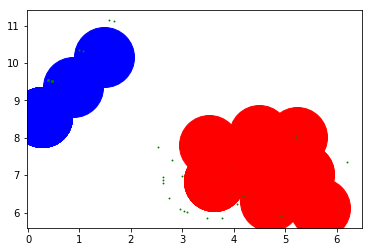

PREY :  0 :  [13.051316701949487, 7.683772233983162]
(13.987609700699293, 8.034992137308835)
(12.108670955030629, 8.017567074889648)
PRED :  0 :  [15, 5]
(15.960478891028773, 5.278352833447297)
(14.812641571797357, 5.982291616263437)
PREY :  0 :  [12.102633403898974, 7.367544467966324]
(13.03892640264878, 7.718764371291998)
(11.159987656980116, 7.701339308872811)
PRED :  0 :  [15.141366407064682, 5.989957341986827]
(16.101845298093455, 6.268310175434124)
(14.95400797886204, 6.972248958250264)
PREY :  0 :  [11.172753247714438, 6.99968186435701]
(12.109046246464244, 7.350901767682684)
(10.23010750079558, 7.333476705263497)
PRED :  0 :  [15.141366407064682, 5.989957341986827]
(14.192466420649838, 5.674380384998663)
(15.366868274103828, 5.01571460633936)
PREY :  0 :  [10.242873091529901, 6.631819260747696]
(11.179166090279708, 6.98303916407337)
(9.300227344611043, 6.965614101654182)
PRED :  0 :  [15.141366407064682, 5.989957341986827]
(16.13407679894917, 6.110481521488475)
(15.114158349782

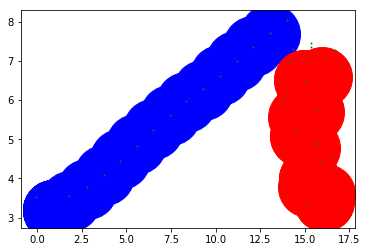

PREY :  0 :  [13.226042700796679, 1.3667622097427374]
(12.303187696523606, 0.9816146521908995)
(13.852841606169829, 2.1459432748508562)
PRED :  0 :  [11.99470294282337, 9.102791320346258]
(10.999821008520307, 9.001747088460439)
(12.307938993738516, 8.153116019831876)
PREY :  0 :  [12.429458935470146, 0.7622340426419779]
(11.506603931197073, 0.3770864850901399)
(13.056257840843294, 1.5414151077500966)
PRED :  0 :  [12.992827864570478, 9.164001128280365]
(11.997945930267415, 9.062956896394546)
(13.306063915485623, 8.214325827765983)
PREY :  0 :  [11.612271654176475, 0.1858618128357038]
(10.689416649903402, -0.1992857447161342)
(12.239070559549624, 0.9650428779438226)
PRED :  0 :  [13.992699798956975, 9.180004716196928]
(12.997817864653912, 9.078960484311109)
(14.305935849872121, 8.230329415682546)
PREY :  0 :  [11.612271654176475, 0.1858618128357038]
(10.689416649903402, -0.1992857447161342)
(12.239070559549624, 0.9650428779438226)
PRED :  0 :  [14.992571733343473, 9.19600830411349]
(13.

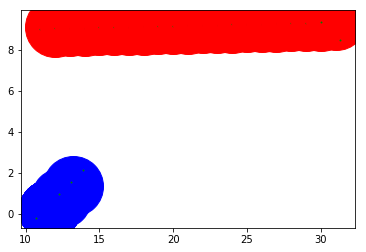

PREY :  0 :  [10, 11]
(9.728894353979834, 11.962549598044687)
(9.053371234331225, 10.677674109000826)
PRED :  0 :  [12.672672793996313, 20.739940073395942]
(13.621989095491104, 20.425617691570768)
(11.677852091938567, 20.638294754972843)
PREY :  0 :  [10.859075952038868, 10.488151869566263]
(10.587970306018702, 11.45070146761095)
(9.912447186370093, 10.165825978567089)
PRED :  0 :  [13.391957511631375, 21.434655479138932]
(14.341273813126167, 21.120333097313758)
(12.39713680957363, 21.333010160715833)
PREY :  0 :  [10.859075952038868, 10.488151869566263]
(11.58028213827501, 11.180872330455589)
(10.697263184737592, 9.501330392125533)
PRED :  0 :  [14.111242229266438, 22.129370884881922]
(15.060558530761229, 21.815048503056747)
(13.116421527208692, 22.027725566458823)
PREY :  0 :  [10.859075952038868, 10.488151869566263]
(10.941904368211718, 9.491588046485022)
(11.726992711956195, 10.984861541159852)
PRED :  0 :  [14.8305269469015, 22.824086290624912]
(15.779843248396292, 22.509763908799

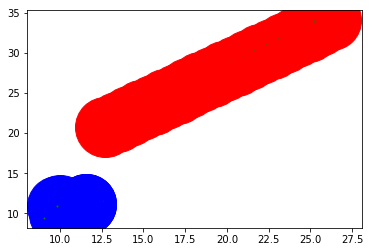

PREY :  0 :  [17.015216441182062, 14.826214666090952]
(16.016462155989327, 14.876113341515758)
(18.00520905820977, 14.967333829320582)
PRED :  0 :  [17.753938715004104, 3.656944757204104]
(18.602173917882027, 4.186564470393341)
(17.702982115954256, 4.65564562583959)
PREY :  0 :  [16.03577816617919, 14.62447060679949]
(15.037023880986453, 14.674369282224296)
(17.025770783206895, 14.76558977002912)
PRED :  0 :  [18.492811646008434, 4.330789540391651]
(19.341046848886357, 4.860409253580888)
(18.441855046958587, 5.329490409027136)
PREY :  0 :  [15.062121360590682, 14.396452131821727]
(14.063367075397947, 14.446350807246533)
(16.05211397761839, 14.537571295051357)
PRED :  0 :  [19.215712232979175, 5.021741594703206]
(20.0639474358571, 5.551361307892443)
(19.164755633929328, 6.020442463338692)
PREY :  0 :  [14.094614209986732, 14.143608477501068]
(13.095859924793997, 14.193507152925875)
(15.08460682701444, 14.284727640730699)
PRED :  0 :  [19.921591097615245, 5.730074163811881]
(20.769826300

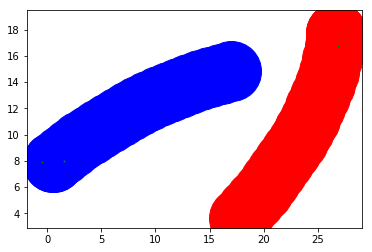

PREY :  0 :  [16, 9]
(15.810415713736539, 9.981864450116193)
(16.577378668676733, 9.816476498716945)
PRED :  0 :  [12.87157553712455, 9.49026123963256]
(11.898948060000714, 9.722631183351027)
(13.82614276152869, 9.788256900831469)
PREY :  0 :  [16, 9]
(16.59307378170347, 8.194851883529532)
(15.127817187211974, 9.489180070196207)
PRED :  0 :  [13.743151074249099, 9.980522479265119]
(12.770523597125264, 10.212892422983586)
(14.697718298653239, 10.278518140464028)
PREY :  0 :  [16, 9]
(16.998776291431465, 8.950543760005333)
(15.069602056489055, 9.366551042435571)
PRED :  0 :  [14.614726611373648, 10.470783718897678]
(13.642099134249813, 10.703153662616145)
(15.569293835777788, 10.768779380096587)
PREY :  0 :  [16.507964282875246, 8.138621867399086]
(17.50674057430671, 8.08916562740442)
(15.577566339364301, 8.505172909834657)
PRED :  0 :  [15.511646875480826, 10.912976029814445]
(14.539019398356992, 11.145345973532912)
(16.46621409988497, 11.210971691013354)
PREY :  0 :  [16.45178558251754

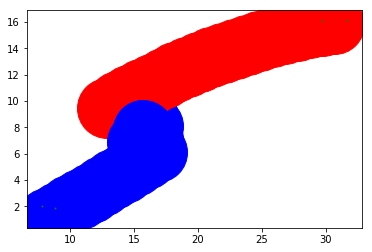

PREY :  0 :  [14.092040615499549, 15.580941822538254]
(13.483390548915844, 14.787503043269398)
(14.57354616528896, 16.457384864339602)
PRED :  0 :  [13.670782390964986, 6.741654221299452]
(13.759010972574199, 7.7377544759863115)
(12.670792438514203, 6.737171476885475)
PREY :  0 :  [13.195167104045474, 15.138654693568803]
(12.58651703746177, 14.345215914299947)
(13.676672653834885, 16.015097735370148)
PRED :  0 :  [14.32784305373715, 7.49549192627142]
(14.416071635346363, 8.49159218095828)
(13.327853101286367, 7.491009181857443)
PREY :  0 :  [12.309092459403065, 14.675112112869005]
(11.70044239281936, 13.88167333360015)
(12.790598009192475, 15.551555154670352)
PRED :  0 :  [14.970483938815864, 8.2616594620136]
(15.058712520425077, 9.25775971670046)
(13.970493986365081, 8.257176717599624)
PREY :  0 :  [11.433566285385247, 14.191941419832144]
(10.824916218801542, 13.398502640563288)
(11.915071835174658, 15.06838446163349)
PRED :  0 :  [15.59785237748948, 9.040382032738393]
(15.68608095909

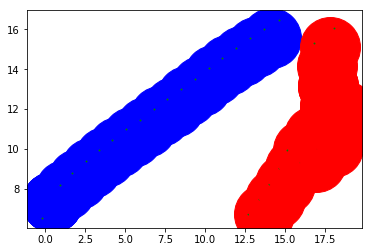

PREY :  0 :  [1.33103526837755, 12.256705853752834]
(0.3438738574125506, 12.41643170858414)
(1.1941523711490198, 11.26611861759121)
PRED :  0 :  [9.107961751502712, 10.994155048376493]
(8.963345234945074, 11.98364282654191)
(8.127081793761914, 10.799541306563611)
PREY :  0 :  [0.6930789136392476, 11.486633331551829]
(-0.29408249732575176, 11.646359186383135)
(0.5561960164107174, 10.496046095390206)
PRED :  0 :  [8.52488052524555, 11.806568910632944]
(8.380264008687911, 12.79605668879836)
(7.544000567504752, 11.611955168820062)
PREY :  0 :  [0.10768249968092014, 10.67588612155063]
(-0.8794789112840792, 10.835611976381935)
(-0.029200397547610002, 9.685298885389006)
PRED :  0 :  [8.52488052524555, 11.806568910632944]
(7.729589430088479, 12.412796651637814)
(7.959767305914275, 10.981555547506598)
PREY :  0 :  [0.10768249968092014, 10.67588612155063]
(-0.8794789112840792, 10.835611976381935)
(-0.029200397547610002, 9.685298885389006)
PRED :  0 :  [8.52488052524555, 11.806568910632944]
(7.67

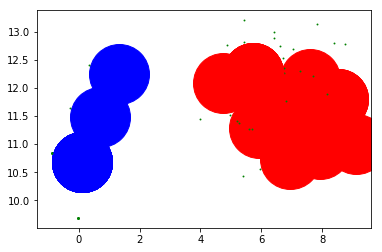

PREY :  0 :  [1, 2]
(0.5573275321377891, 1.1033166187573342)
(0.15064185280518783, 2.5278169548184257)
PRED :  0 :  [7.447213595499958, 20.894427190999917]
(7.557237189009315, 21.88835616676795)
(6.783061090378658, 20.146830073602384)
PREY :  0 :  [1, 2]
(1.9268802422690683, 2.3753571852132755)
(1.2833933788668614, 2.9590037501566004)
PRED :  0 :  [7.894427190999917, 21.788854381999833]
(8.004450784509272, 22.782783357767865)
(7.230274685878617, 21.0412572646023)
PREY :  0 :  [0.8175977391116412, 1.0167760096382845]
(1.7444779813807094, 1.39213319485156)
(1.1009911179785026, 1.975779759794885)
PRED :  0 :  [8.52107235712008, 22.568159095047452]
(8.631095950629435, 23.562088070815484)
(7.8569198519987795, 21.82056197764992)
PREY :  0 :  [0.8175977391116412, 1.0167760096382845]
(1.7444779813807094, 1.39213319485156)
(1.1009911179785026, 1.975779759794885)
PRED :  0 :  [9.147717523240242, 23.34746380809507]
(9.257741116749598, 24.341392783863103)
(8.483565018118943, 22.59986669069754)
PRE

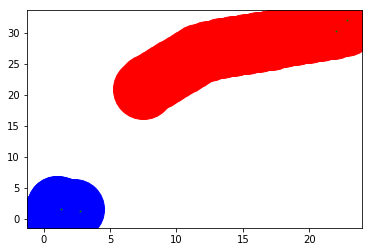

PREY :  0 :  [11.52320394610252, 18.85220750453323]
(12.275005360853047, 19.511597095578693)
(10.956947982763433, 18.027978055906864)
PRED :  0 :  [6.521529438648098, 13.853233288511062]
(6.053198002330625, 12.969680423224093)
(6.206771854542596, 14.802405382100032)
PREY :  0 :  [11.52320394610252, 18.85220750453323]
(11.371484821733734, 19.840631152217142)
(10.5237906603483, 18.88645782216613)
PRED :  0 :  [7.043058877296197, 14.706466577022123]
(6.574727440978723, 13.822913711735154)
(6.728301293190694, 15.655638670611093)
PREY :  0 :  [12.523181631620677, 18.85888795854094]
(12.371462507251891, 19.847311606224853)
(11.523768345866458, 18.89313827617384)
PRED :  0 :  [7.596247121227648, 15.539522857699508]
(7.127915684910175, 14.655969992412539)
(7.2814895371221455, 16.488694951288476)
PREY :  0 :  [12.523181631620677, 18.85888795854094]
(11.590208053076232, 19.21883281784299)
(12.055859771422195, 19.742975216101318)
PRED :  0 :  [8.1494353651591, 16.372579138376892]
(7.6811039288416

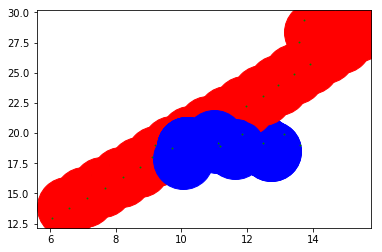

PREY :  0 :  [3.5097387603674406, 14.12842446287545]
(3.709082173715831, 15.108354156044616)
(2.6270980755984397, 14.598472781232733)
PRED :  0 :  [8.014390444250367, 15.830962123726634]
(7.1371238576857285, 15.350958648637935)
(7.348243937145991, 16.576783034584356)
PREY :  0 :  [3.058071330184715, 13.236238085198604]
(3.2574147435331056, 14.216167778367769)
(2.175430645415714, 13.706286403555886)
PRED :  0 :  [8.589632744102103, 15.012979057605284]
(7.712366157537464, 14.532975582516585)
(7.923486236997727, 15.758799968463006)
PREY :  0 :  [2.561462303899965, 12.368263733611812]
(2.7608057172483553, 13.348193426780977)
(1.6788216191309637, 12.838312051969094)
PRED :  0 :  [8.589632744102103, 15.012979057605284]
(9.581985901258951, 15.136410056470378)
(8.934519293898417, 15.951623435295575)
PREY :  0 :  [2.0648532776152146, 11.50028938202502]
(2.264196690963605, 12.480219075194185)
(1.1822125928462135, 11.970337700382302)
PRED :  0 :  [7.776423155672327, 15.594949989255547]
(8.7687763

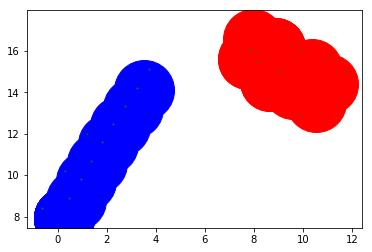

PREY :  0 :  [9.029857499854668, 10.757464374963668]
(9.570871144500455, 11.598478189539316)
(8.495195263591127, 9.91239852361617)
PRED :  0 :  [12.642924355815756, 3.7659296786904752]
(12.939097572030397, 4.721063923703749)
(12.82273009535592, 4.749631816549499)
PREY :  0 :  [8.071470825141082, 10.471991115740606]
(8.61248446978687, 11.313004930316254)
(7.536808588877541, 9.626925264393108)
PRED :  0 :  [13.253399527372874, 4.557965072414966]
(13.549572743587515, 5.513099317428239)
(13.433205266913038, 5.54166721027399)
PREY :  0 :  [7.125830495806789, 10.146776774825987]
(7.666844140452576, 10.987790589401635)
(6.591168259543248, 9.30171092347849)
PRED :  0 :  [13.828110861684776, 5.376321279829216]
(14.124284077899416, 6.3314555248424895)
(14.00791660122494, 6.3600234176882395)
PREY :  0 :  [6.1937967433061365, 9.784405302163536]
(6.734810387951923, 10.625419116739184)
(5.659134507042595, 8.939339450816039)
PRED :  0 :  [14.362978443736946, 6.221257176610543]
(14.659151659951586, 7.

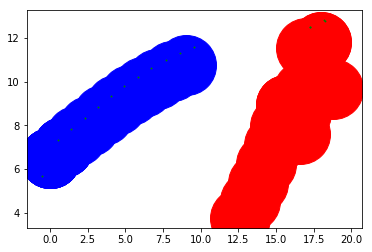

PREY :  0 :  [4.292893218813452, 11.292893218813452]
(3.467155439784297, 11.856947400859822)
(3.7170866449349864, 12.110479171162405)
PRED :  0 :  [17.693944948027877, 17.047986184363726]
(18.012254038968127, 17.995973168781124)
(17.531254253479354, 16.06130906498408)
PREY :  0 :  [3.572763624065802, 10.59905363593526]
(2.7470258450366467, 11.16310781798163)
(2.996957050187336, 11.416639588284212)
PRED :  0 :  [18.651424795600395, 17.336486342929547]
(18.969733886540645, 18.284473327346944)
(18.48873410105187, 16.349809223549897)
PREY :  0 :  [2.840309105142549, 9.918237671295104]
(2.014571326113394, 10.482291853341474)
(2.264502531264083, 10.735823623644057)
PRED :  0 :  [17.667746021987462, 17.156552826475945]
(17.986055112927712, 18.104539810893343)
(17.50505532743894, 16.169875707096296)
PREY :  0 :  [2.122899844256003, 9.221585711996761]
(1.2971620652268483, 9.78563989404313)
(1.5470932703775375, 10.039171664345714)
PRED :  0 :  [16.766456977468714, 17.589771083513295]
(17.0847660

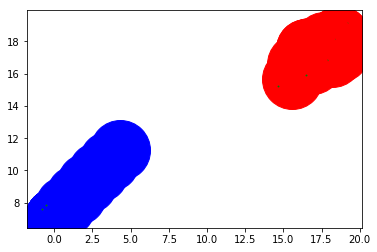

PREY :  0 :  [6.004106793532296, 1.9094642539574818]
(5.454502134428967, 1.074039380798971)
(5.2173971406727215, 1.292141062997052)
PRED :  0 :  [11, 1]
(11.11757721613259, 0.006936256705285748)
(10.638585796115681, 1.9324053695848518)
PREY :  0 :  [5.008213587064592, 1.8189285079149635]
(4.458608927961263, 0.9835036347564526)
(4.221503934205018, 1.2016053169545338)
PRED :  0 :  [11.836287165768052, 1.548291689132379]
(11.953864381900642, 0.5552279458376648)
(11.474872961883733, 2.480697058717231)
PREY :  0 :  [4.016660819087764, 1.6892245823094116]
(3.467056159984435, 0.8537997091509008)
(3.229951166228189, 1.0719013913489819)
PRED :  0 :  [11.836287165768052, 1.548291689132379]
(12.025233403016829, 2.5302791225700627)
(11.898093158397762, 0.550203507018666)
PREY :  0 :  [3.0251080511109354, 1.5595206567038598]
(2.4755033920076066, 0.7240957835453489)
(2.2383983982513604, 0.94219746574343)
PRED :  0 :  [11.836287165768052, 1.548291689132379]
(11.596614204331317, 0.5774380072852405)
(1

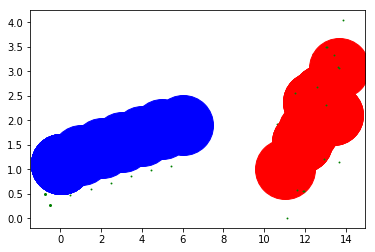

PREY :  0 :  [10.186266528793265, 14.418761806280903]
(10.342300561728074, 15.406513485887725)
(10.064294227651803, 15.411295310881256)
PRED :  0 :  [7.101851851392507, 5.994799577989415]
(7.954960135754828, 6.5165334710348795)
(6.205626794907134, 6.438399226465146)
PREY :  0 :  [9.42211358745704, 13.773726704718829]
(9.57814762039185, 14.761478384325653)
(9.30014128631558, 14.766260209319181)
PRED :  0 :  [8.093353663122048, 6.12489245764482]
(8.94646194748437, 6.646626350690285)
(7.197128606636676, 6.568492106120551)
PREY :  0 :  [8.62471632290483, 13.170271981906378]
(8.780750355839638, 14.158023661513202)
(8.502744021763368, 14.16280548650673)
PRED :  0 :  [9.064622766587018, 6.362876340826757]
(9.917731050949339, 6.8846102338722215)
(8.168397710101646, 6.806475989302488)
PREY :  0 :  [7.806233407513181, 12.595741114840049]
(7.96226744044799, 13.583492794446872)
(7.684261106371719, 13.588274619440401)
PRED :  0 :  [8.202288176689116, 5.8565374670814965]
(9.055396461051437, 6.378271

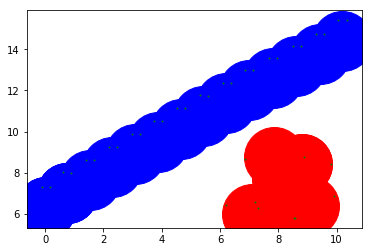

PREY :  0 :  [7.485504244572473, 17.142507074287455]
(8.261860702345567, 17.772801172684396)
(8.46015872776187, 16.918791544207824)
PRED :  0 :  [12, 20]
(12.952440486099421, 20.304724663325267)
(11.596576391759868, 19.08498667096347)
PREY :  0 :  [6.971008489144946, 16.28501414857491]
(7.74736494691804, 16.91530824697185)
(7.945662972334342, 16.06129861849528)
PRED :  0 :  [12, 20]
(11.038616624577386, 20.275212654979786)
(12.843472713666163, 20.53717202207546)
PREY :  0 :  [6.456512733717419, 15.427521222862365]
(7.232869191490513, 16.05781532125931)
(7.4311672169068155, 15.203805692782733)
PRED :  0 :  [12, 20]
(12.911738265593257, 19.589228366299476)
(11.087970792880391, 19.589874744302698)
PREY :  0 :  [5.942016978289892, 14.570028297149822]
(6.718373436062986, 15.200322395546763)
(6.916671461479289, 14.34631276707019)
PRED :  0 :  [12, 20]
(11.007361142062901, 20.121111922259264)
(12.748843054522256, 20.662747372453317)
PREY :  0 :  [5.4275212228623655, 13.712535371437278]
(6.203

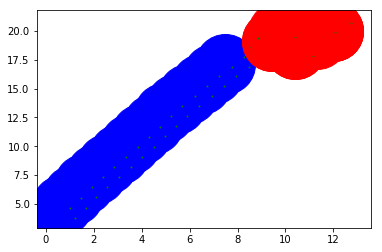

PREY :  0 :  [1.683772233983162, 10.051316701949487]
(2.174945430127962, 9.180254768796107)
(2.5699367013500307, 10.514687543475358)
PRED :  0 :  [4, 12]
(3.3582549488572, 12.766918046034728)
(4.796084722636696, 11.394814809843751)
PREY :  0 :  [1.367544467966324, 9.102633403898974]
(1.858717664111124, 8.231571470745594)
(2.2537089353331927, 9.566004245424844)
PRED :  0 :  [4, 12]
(3.031988593107341, 11.749093810108848)
(4.8880810470820535, 12.459686908464493)
PREY :  0 :  [1.051316701949486, 8.15395010584846]
(1.542489898094286, 7.282888172695081)
(1.937481169316355, 8.617320947374331)
PRED :  0 :  [4.999277505620566, 12.038006141092465]
(4.031266098727907, 11.787099951201313)
(5.8873585527026195, 12.497693049556958)
PREY :  0 :  [0.6677839847278575, 7.2304228161484785]
(1.1589571808726575, 6.3593608829951)
(1.5539484520947264, 7.693793657674349)
PRED :  0 :  [5.662562354020961, 12.786373169950942]
(4.6945509471283025, 12.53546698005979)
(6.550643401103015, 13.246060078415434)
PREY : 

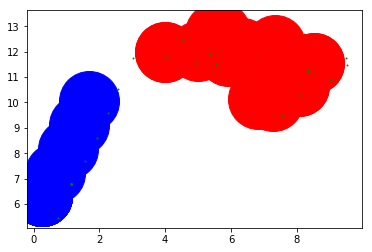

PREY :  0 :  [14, 5]
(14.536211462012087, 5.844083685428678)
(14.944215458353643, 4.6706716407504185)
PRED :  0 :  [11.941741911594837, 8.336336396998156]
(11.146811295337129, 7.729636046465755)
(10.942053972043496, 8.361316859675863)
PREY :  0 :  [14, 5]
(13.001065142711257, 5.046142723083052)
(13.245182802078785, 4.344064791521017)
PRED :  0 :  [12.883483823189675, 8.672672793996313]
(12.088553206931966, 8.065972443463911)
(11.883795883638333, 8.69765325667402)
PREY :  0 :  [13.455145417772915, 5.838530550562202]
(12.456210560484172, 5.884673273645253)
(12.7003282198517, 5.182595342083219)
PRED :  0 :  [13.800841153946783, 9.070737522032086]
(13.005910537689074, 8.464037171499685)
(12.801153214395441, 9.095717984709793)
PREY :  0 :  [12.480131137298438, 5.616388359903069]
(11.481196280009694, 5.662531082986121)
(11.725313939377223, 4.960453151424086)
PRED :  0 :  [14.712753653219714, 9.481122211890025]
(13.917823036962005, 8.874421861357623)
(13.713065713668373, 9.506102674567732)
PR

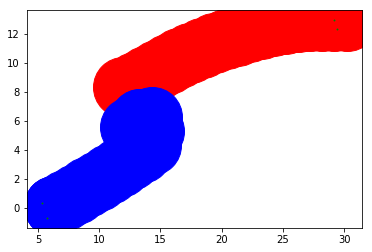

PREY :  0 :  [15.552786404500042, 7.105572809000084]
(16.11568510195182, 6.279046913212726)
(15.986890970824176, 8.006435298782257)
PRED :  0 :  [8.909568930549266, 16.41555307793285]
(9.140039403795347, 15.442473758986171)
(8.009272407852041, 15.980275957905521)
PREY :  0 :  [15.07576613910675, 6.226680513889861]
(15.638664836558526, 5.400154618102503)
(15.509870705430885, 7.127543003672034)
PRED :  0 :  [9.83383611913386, 16.79729928172004]
(10.06430659237994, 15.824219962773363)
(8.933539596436635, 16.36202216169271)
PREY :  0 :  [14.570538315684622, 5.363694507954574]
(15.133437013136398, 4.537168612167216)
(15.004642882008756, 6.264556997736747)
PRED :  0 :  [10.77227110088471, 17.142755190666872]
(11.002741574130791, 16.169675871720194)
(9.871974578187485, 16.707478070639542)
PREY :  0 :  [14.038479182058527, 4.516987310438781]
(14.601377879510302, 3.6904614146514225)
(14.472583748382661, 5.417849800220954)
PRED :  0 :  [11.72420837237259, 17.449048238502126]
(11.954678845618671,

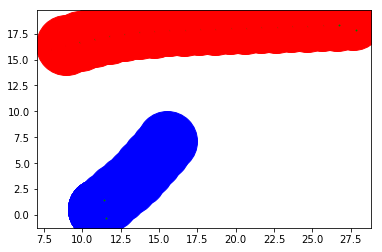

PREY :  0 :  [3.5527864045000417, 10.105572809000083]
(4.228166833597776, 9.368103300483453)
(4.085034338267039, 9.258984280256183)
PRED :  0 :  [2.114453177593866, 3.0065713562924277]
(2.9984910414967576, 2.539156064302518)
(2.6879302649721906, 3.8257929565033066)
PREY :  0 :  [2.977526330034571, 9.287602243071223]
(3.6529067591323052, 8.550132734554593)
(3.5097742638015683, 8.441013714327323)
PRED :  0 :  [3.054484788260854, 3.347658692537602]
(3.9385226521637455, 2.8802434005476925)
(3.6279618756391785, 4.1668802927484805)
PREY :  0 :  [2.3035064921356576, 8.548888998219933]
(2.978886921233392, 7.811419489703303)
(2.835754425902655, 7.702300469476032)
PRED :  0 :  [3.88733540225358, 3.901156528822387]
(4.771373266156472, 3.4337412368324776)
(4.460812489631905, 4.720378129033266)
PREY :  0 :  [1.5976556239531572, 7.840528530741679]
(2.2730360530508915, 7.1030590222250485)
(2.129903557720154, 6.993940001997778)
PRED :  0 :  [3.8468512042876886, 2.9019763500182543]
(4.730889068190581, 

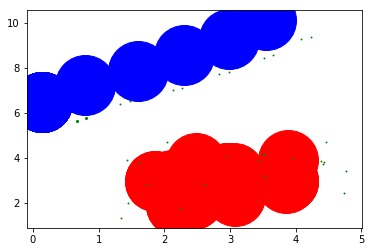

PREY :  0 :  [17.859318607151206, 12.009945079449567]
(18.616751711001996, 11.35703230335236)
(18.747604116172685, 11.55065339167104)
PRED :  0 :  [11.829819054294466, 13.558032559202271]
(12.152275871654272, 12.611448383897093)
(11.908862537065806, 12.561161390077906)
PREY :  0 :  [17.859318607151206, 12.009945079449567]
(17.32743250223956, 12.856760981167241)
(17.145418348776325, 12.710192479367823)
PRED :  0 :  [12.659638108588933, 14.116065118404542]
(12.982094925948738, 13.169480943099364)
(12.738681591360272, 13.119193949280177)
PREY :  0 :  [17.859318607151206, 12.009945079449567]
(18.748982179207886, 12.466561689479635)
(18.618713004415053, 12.66057565773826)
PRED :  0 :  [13.489457162883399, 14.674097677606813]
(13.811913980243204, 13.727513502301635)
(13.568500645654739, 13.677226508482448)
PREY :  0 :  [18.84181169697858, 12.196244109080574]
(19.73147526903526, 12.652860719110642)
(19.60120609424243, 12.846874687369267)
PRED :  0 :  [14.328936197034459, 15.217489756331563]
(

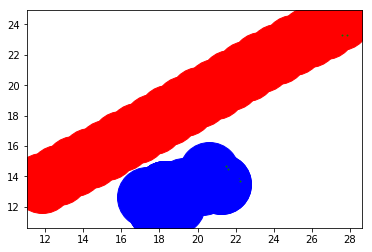

PREY :  0 :  [17, 2]
(16.094433893375484, 2.4242051703278937)
(16.345907105804823, 1.2435857710464606)
PRED :  0 :  [6.993150604322876, 3.116841247567397]
(7.901716019152899, 3.534583856089377)
(7.771257646097084, 3.7449729467686006)
PREY :  0 :  [17.942039066738236, 1.6644968007023562]
(17.03647296011372, 2.08870197103025)
(17.28794617254306, 0.9080825717488168)
PRED :  0 :  [7.988874975005026, 3.209215365314935]
(8.89744038983505, 3.626957973836915)
(8.766982016779234, 3.8373470645161385)
PREY :  0 :  [17.942039066738236, 1.6644968007023562]
(18.438173796081912, 2.532742347963657)
(18.748930678380493, 1.073797277203849)
PRED :  0 :  [8.984599345687176, 3.301589483062473]
(9.893164760517198, 3.719332091584453)
(9.762706387461384, 3.9297211822636764)
PREY :  0 :  [17.942039066738236, 1.6644968007023562]
(18.92145170721425, 1.866365271930035)
(18.75417376185767, 2.2479667973459447)
PRED :  0 :  [9.980323716369327, 3.393963600810011]
(10.888889131199349, 3.811706209331991)
(10.7584307581

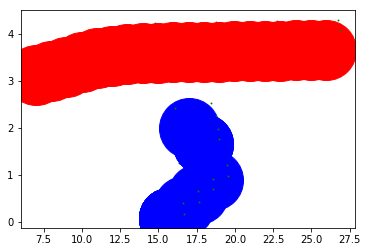

PREY :  0 :  [2.116212083652938, 13.532112279580968]
(2.7521401564188346, 12.760363948667157)
(1.2751634914064247, 12.991152701164836)
PRED :  0 :  [17.154506559181993, 9.987991762703384]
(17.648010018438924, 10.857735596082755)
(17.759681064505866, 10.78408460785777)
PREY :  0 :  [1.2520211869939466, 13.02894819686865]
(1.8879492597598433, 12.257199865954838)
(0.4109725947474334, 12.487988618452517)
PRED :  0 :  [17.250161259795544, 10.983406338772337]
(17.743664719052475, 11.853150172151707)
(17.855335765119417, 11.779499183926722)
PREY :  0 :  [0.408493303952439, 12.491862812100536]
(1.0444213767183355, 11.720114481186725)
(-0.4325552882940742, 11.950903233684404)
PRED :  0 :  [17.282844541397264, 11.982872097617403]
(17.776348000654195, 12.852615930996773)
(17.888019046721137, 12.778964942771788)
PREY :  0 :  [0.408493303952439, 12.491862812100536]
(1.0444213767183355, 11.720114481186725)
(-0.4325552882940742, 11.950903233684404)
PRED :  0 :  [17.315527822998984, 12.982337856462468

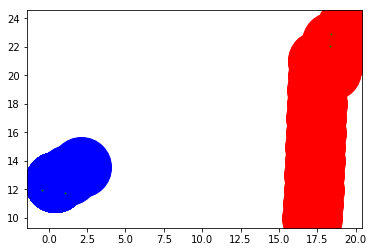

PREY :  0 :  [13.475671185305025, 15.851515880110618]
(12.880191072565033, 16.654885928924468)
(14.472775739056404, 15.927558689686945)
PRED :  0 :  [13.647700952870967, 19.761894661780776]
(14.505025269074295, 20.27667132874082)
(13.45026325594639, 18.78157922487635)
PREY :  0 :  [13.887550136353866, 14.940277311083326]
(13.292070023613874, 15.743647359897176)
(14.884654690105245, 15.016320120659653)
PRED :  0 :  [14.328531982484114, 20.494335177533355]
(15.185856298687442, 21.0091118444934)
(14.131094285559538, 19.514019740628928)
PREY :  0 :  [14.339760691679341, 14.048366097087097]
(13.74428057893935, 14.851736145900947)
(15.33686524543072, 14.124408906663424)
PRED :  0 :  [15.04285934651291, 21.194146878635635]
(15.90018366271624, 21.70892354559568)
(14.845421649588335, 20.21383144173121)
PREY :  0 :  [14.339760691679341, 14.048366097087097]
(14.696640857759471, 13.114215923368429)
(13.35906746902526, 14.243918655342814)
PRED :  0 :  [15.757186710541708, 21.893958579737916]
(16.61

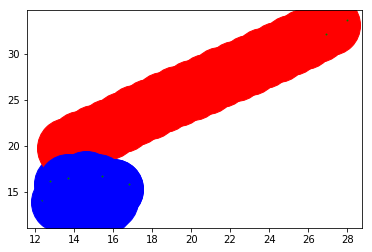

PREY :  0 :  [11.056141643633982, 18.669649575271894]
(10.359156441138577, 17.952564066073418)
(12.049086508821336, 18.551072618412363)
PRED :  0 :  [20.509551513430537, 7.860440151992368]
(21.273518801502497, 8.505695126987503)
(21.466659336815006, 8.150172121951227)
PREY :  0 :  [10.122371872711248, 18.3117752748382]
(9.425386670215843, 17.594689765639725)
(11.115316737898603, 18.19319831797867)
PRED :  0 :  [20.99333671627706, 8.735626919206513]
(21.75730400434902, 9.380881894201648)
(21.95044453966153, 9.025358889165373)
PREY :  0 :  [9.199113984221164, 17.927594495333512]
(8.502128781725759, 17.210508986135036)
(10.192058849408518, 17.80901753847398)
PRED :  0 :  [21.449868516208433, 9.625334014632543]
(22.213835804280393, 10.270588989627678)
(22.4069763395929, 9.915065984591402)
PREY :  0 :  [8.2867615196816, 17.51818885242103]
(7.589776317186193, 16.801103343222554)
(9.279706384868954, 17.3996118955615)
PRED :  0 :  [21.87747738451094, 10.529297872178324]
(22.6414446725829, 11.1

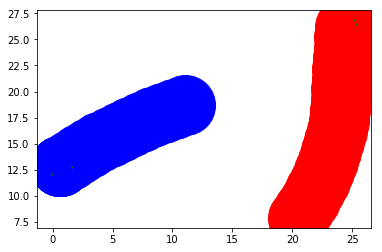

PREY :  0 :  [3.096262161106461, 14.571913655260955]
(4.065771766923698, 14.816966964212511)
(2.818094924137754, 15.532446313881783)
PRED :  0 :  [19.20784144738879, 9.978162528799448]
(18.65621148579572, 10.81225148417101)
(18.576309909330273, 9.202812339248014)
PREY :  0 :  [2.208857933885363, 14.110921532215317]
(3.178367539702599, 14.355974841166873)
(1.9306906969166562, 15.071454190836144)
PRED :  0 :  [19.36249351260846, 10.966131525642613]
(18.810863551015387, 11.800220481014176)
(18.730961974549942, 10.19078133609118)
PREY :  0 :  [1.3387211159981114, 13.618111306918552]
(2.308230721815348, 13.863164615870108)
(1.060553879029405, 14.57864396553938)
PRED :  0 :  [19.460326394843445, 11.961334382930309]
(18.908696433250373, 12.795423338301871)
(18.828794856784928, 11.185984193378875)
PREY :  0 :  [0.4867844467546544, 13.094466473469042]
(1.4562940525718908, 13.339519782420599)
(0.20861720978594778, 14.05499913208987)
PRED :  0 :  [19.49747555520604, 12.960644114637327]
(18.945845

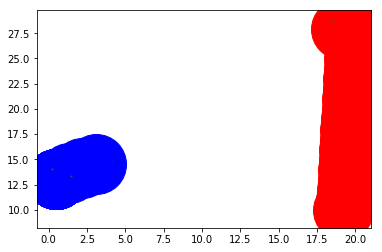

PREY :  0 :  [7.012237034670931, 18.844037426526988]
(7.551578338762338, 19.686124689048505)
(7.529633243671851, 19.69978339520664)
PRED :  0 :  [19.34875565045001, 3.9372136876290225]
(18.349066815358345, 3.9122690891541194)
(20.22996461326133, 3.464486743335601)
PREY :  0 :  [6.0323189088988025, 18.644637158765786]
(6.57166021299021, 19.486724421287303)
(6.549715117899723, 19.50038312744544)
PRED :  0 :  [19.6565865799272, 4.888654762450374]
(18.656897744835536, 4.863710163975471)
(20.53779554273852, 4.415927818156952)
PREY :  0 :  [5.0618810085260515, 18.40328620782478]
(5.601222312617459, 19.245373470346298)
(5.579277217526972, 19.259032176504434)
PRED :  0 :  [19.921790665797985, 5.852847063206525]
(18.92210183070632, 5.827902464731622)
(20.802999628609307, 5.380120118913103)
PREY :  0 :  [4.10243076780967, 18.121408156906874]
(4.6417720719010775, 18.96349541942839)
(4.61982697681059, 18.977154125586527)
PRED :  0 :  [20.142589206015636, 6.828166500436069]
(19.14290037092397, 6.80

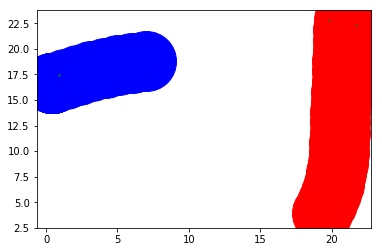

PREY :  0 :  [1.1162120836529381, 5.532112279580968]
(1.767302121878404, 4.773111777523452)
(1.9482431483526113, 4.977383239981698)
PRED :  0 :  [17, 9]
(17.95909155879762, 9.283096064690325)
(16.062311515040914, 8.652522942951434)
PREY :  0 :  [0.23242416730587623, 5.064224559161936]
(0.8835142055313421, 4.30522405710442)
(1.0644552320055496, 4.509495519562666)
PRED :  0 :  [17, 9]
(16.084083847301812, 8.598630343415765)
(17.886592741567725, 9.462550873525739)
PREY :  0 :  [0.23242416730587623, 5.064224559161936]
(0.8835142055313421, 4.30522405710442)
(1.0644552320055496, 4.509495519562666)
PRED :  0 :  [17.8101628444824, 9.586204883483742]
(16.89424669178421, 9.184835226899507)
(18.696755586050124, 10.04875575700948)
PREY :  0 :  [0.23242416730587623, 5.064224559161936]
(0.8835142055313421, 4.30522405710442)
(1.0644552320055496, 4.509495519562666)
PRED :  0 :  [18.544054783202448, 8.906938645340164]
(17.62813863050426, 8.505568988755929)
(19.430647524770173, 9.369489518865903)
PREY :

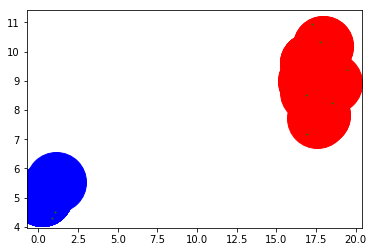

PREY :  0 :  [6.4, 18.2]
(5.9002776587667265, 19.066185650811843)
(6.911137250567158, 17.340500895240346)
PRED :  0 :  [6.162295932869692, 8.986742129522176]
(7.158036471205705, 8.894542453197861)
(5.1846660254806665, 8.776409620911346)
PREY :  0 :  [5.834474236640425, 17.37526937065696]
(5.334751895407151, 18.241455021468802)
(6.345611487207583, 16.515770265897306)
PRED :  0 :  [6.728038780654009, 8.16216039907886]
(7.723779318990021, 8.069960722754546)
(5.750408873264983, 7.9518278904680315)
PREY :  0 :  [5.198414424269017, 16.60362961333101]
(4.698692083035743, 17.469815264142852)
(5.709551674836175, 15.744130508571356)
PRED :  0 :  [6.728038780654009, 8.16216039907886]
(6.170823952806295, 8.992528772529248)
(7.508419062822622, 7.536855181443156)
PREY :  0 :  [4.562354611897609, 15.831989856005059]
(4.062632270664335, 16.698175506816902)
(5.073491862464767, 14.972490751245406)
PRED :  0 :  [6.728038780654009, 8.16216039907886]
(6.576349271987552, 7.173732205955795)
(6.57665451004364

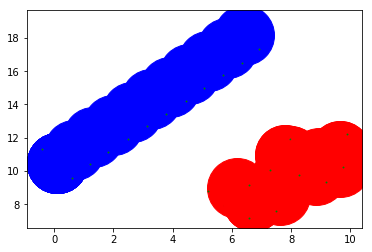

PREY :  0 :  [0.3598156003355202, 6.231778720402624]
(-0.6032970154773059, 6.500877381235739)
(-0.6240611602664489, 6.052930964063956)
PRED :  0 :  [15.542148376385645, 18.84028277263217]
(16.1882753222153, 19.603512731342416)
(15.48322867223428, 19.83854549780161)
PREY :  0 :  [0.3598156003355202, 6.231778720402624]
(-0.6032970154773059, 6.500877381235739)
(-0.6240611602664489, 6.052930964063956)
PRED :  0 :  [15.542148376385645, 18.84028277263217]
(14.630629897988499, 19.251541892337194)
(14.598601947896395, 19.171523074052725)
PREY :  0 :  [0.3598156003355202, 6.231778720402624]
(-0.6032970154773059, 6.500877381235739)
(-0.6240611602664489, 6.052930964063956)
PRED :  0 :  [15.542148376385645, 18.84028277263217]
(15.99259872798807, 17.947481293723644)
(16.484209406644112, 19.175724295506658)
PREY :  0 :  [0.3598156003355202, 6.231778720402624]
(-0.6032970154773059, 6.500877381235739)
(-0.6240611602664489, 6.052930964063956)
PRED :  0 :  [15.311480991240598, 17.867250112630284]
(15.76

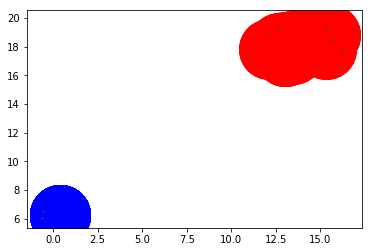

PREY :  0 :  [18.34920862654403, 9.240743397634704]
(19.292384051601957, 8.908448171116483)
(19.004556024423888, 9.996071000792499)
PRED :  0 :  [12.893135772414293, 14.44978716303817]
(13.187923950796092, 15.405349787823349)
(12.067353226184926, 15.013775803298719)
PREY :  0 :  [17.68343596639901, 8.494588745432212]
(18.62661139145694, 8.162293518913991)
(18.338783364278868, 9.249916348590007)
PRED :  0 :  [13.79452874654289, 14.882789133231844]
(14.089316924924688, 15.838351758017023)
(12.968746200313522, 15.446777773492393)
PREY :  0 :  [17.003652104593257, 7.761176241292517]
(17.946827529651188, 7.428881014774296)
(17.658999502473115, 8.516503844450312)
PRED :  0 :  [14.70424424866889, 15.298021243251817]
(14.999032427050688, 16.253583868036998)
(13.878461702439521, 15.862009883512366)
PREY :  0 :  [16.310675426107256, 7.040216240269915]
(17.253850851165183, 6.707921013751694)
(16.966022823987114, 7.795543843427711)
PRED :  0 :  [15.622368665374195, 15.694313503395191]
(15.91715684

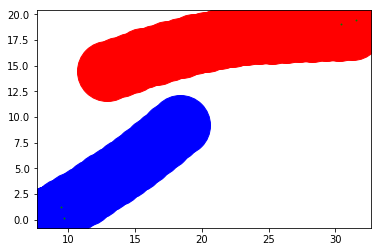

PREY :  0 :  [18, 16]
(17.81691951153659, 15.01690207265807)
(17.12073802990366, 16.476338522421084)
PRED :  0 :  [15.74740931868366, 15.66436383882992]
(16.677585013717216, 16.03147850261882)
(14.979051563341313, 15.024343245563367)
PREY :  0 :  [18, 16]
(17.641717914820582, 16.933613382208872)
(18.998539090571246, 16.0540341059068)
PRED :  0 :  [16.49481863736732, 16.32872767765984]
(17.42499433240088, 16.695842341448742)
(15.726460882024973, 15.688707084393286)
PREY :  0 :  [17.269032064617484, 15.3175881907216]
(16.910749979438066, 16.25120157293047)
(18.26757115518873, 15.3716222966284)
PRED :  0 :  [17.242930145452917, 16.992300711673348]
(18.173105840486475, 17.35941537546225)
(16.47457239011057, 16.352280118406796)
PREY :  0 :  [16.37268544989468, 15.760942164736681]
(16.01440336471526, 16.69455554694555)
(17.371224540465924, 15.814976270643482)
PRED :  0 :  [17.963367916938903, 17.68582029857505]
(18.89354361197246, 18.052934962363953)
(17.195010161596556, 17.045799705308497)


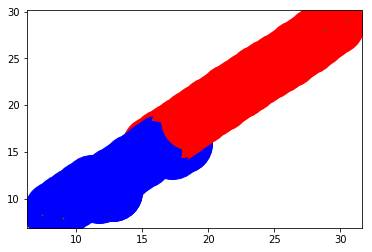

PREY :  0 :  [11.013606076167857, 18.835601012694642]
(10.8557392015033, 17.8481406084841)
(11.502771156059408, 19.707792232906524)
PRED :  0 :  [12.504765717760272, 2.863256375692621]
(12.159089750005315, 1.9249024311084493)
(13.288376081003591, 2.2420037711768135)
PREY :  0 :  [10.0388327154878, 18.6124040250167]
(9.880965840823242, 17.62494362080616)
(10.52799779537935, 19.484595245228583)
PRED :  0 :  [12.979480158702717, 3.7433962506901697]
(12.63380419094776, 2.805042306105998)
(13.763090521946037, 3.1221436461743624)
PREY :  0 :  [9.077995630164349, 18.33529015768572]
(8.92012875549979, 17.347829753475178)
(9.5671607100559, 19.2074813778976)
PRED :  0 :  [13.423184886361053, 4.63956928903357]
(13.077508918606096, 3.7012153444493987)
(14.206795249604372, 4.018316684517763)
PREY :  0 :  [8.13285909109562, 18.008614596130855]
(7.974992216431062, 17.021154191920314)
(8.62202417098717, 18.880805816342736)
PRED :  0 :  [13.834768934145087, 5.550941096590568]
(13.48909296639013, 4.6125

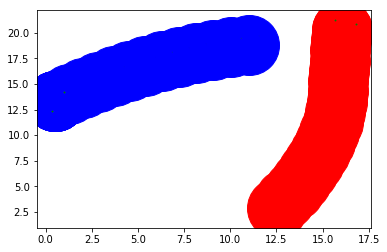

PREY :  0 :  [9, 8]
(8.655094826145515, 7.0613624655659635)
(8.463092238185656, 8.843640951651537)
PRED :  0 :  [16.74740931868366, 19.66436383882992]
(16.858873738286068, 18.670595413510068)
(16.47963080840215, 18.700883341138653)
PREY :  0 :  [9.804671142443615, 8.593720769822387]
(9.45976596858913, 7.65508323538835)
(9.26776338062927, 9.437361721473923)
PRED :  0 :  [17.499429514323303, 20.32350390387688]
(17.610893933925713, 19.329735478557026)
(17.231651004041794, 19.36002340618561)
PREY :  0 :  [9.921276224689265, 7.600542409811212]
(9.57637105083478, 6.661904875377176)
(9.38436846287492, 8.44418336146275)
PRED :  0 :  [18.293258719356967, 20.93164467149209]
(18.404723138959376, 19.937876246172237)
(18.025480209075457, 19.968164173800822)
PREY :  0 :  [9.779041497201696, 8.590375366575401]
(9.43413632334721, 7.6517378321413645)
(9.242133735387352, 9.434016318226938)
PRED :  0 :  [19.04455037493825, 21.591615010411903]
(19.15601479454066, 20.59784658509205)
(18.77677186465674, 20.

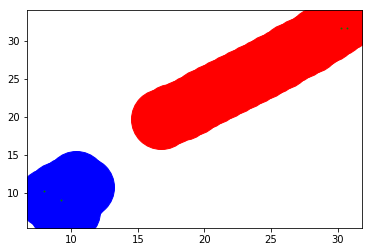

PREY :  0 :  [0.5938615339465522, 18.086188451379744]
(1.044529644025022, 18.978880030010515)
(0.8949700817285065, 17.132598580181103)
PRED :  0 :  [4.4737065279617845, 9.880682760911323]
(3.9505983854014035, 9.028416446202694)
(5.200147512419923, 9.19345390812683)
PREY :  0 :  [0.1813972018191024, 17.17521470053801]
(0.6320653118975723, 18.06790627916878)
(0.48250574960105663, 16.22162482933937)
PRED :  0 :  [4.4737065279617845, 9.880682760911323]
(3.48225306518328, 10.011143602333236)
(4.142098607132805, 8.937265468911923)
PREY :  0 :  [0.1813972018191024, 17.17521470053801]
(0.6320653118975723, 18.06790627916878)
(0.48250574960105663, 16.22162482933937)
PRED :  0 :  [3.7147913017404655, 10.53187219526161]
(2.723337838961961, 10.662333036683522)
(3.3831833809114857, 9.588454903262209)
PREY :  0 :  [0.1813972018191024, 17.17521470053801]
(0.6320653118975723, 18.06790627916878)
(0.48250574960105663, 16.22162482933937)
PRED :  0 :  [3.7147913017404655, 10.53187219526161]
(2.937085969207

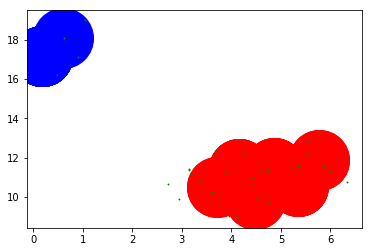

PREY :  0 :  [4.247423305293122, 12.341495392131481]
(4.813626144822996, 13.165761334960802)
(3.853395298971254, 13.260593825507371)
PRED :  0 :  [16, 14]
(16.795249848169618, 14.606281847811891)
(15.220985385809229, 14.627005766223249)
PREY :  0 :  [3.4948466105862437, 11.682990784262962]
(4.061049450116117, 12.507256727092283)
(3.1008186042643757, 12.602089217638852)
PRED :  0 :  [16, 14]
(16.583546691756727, 14.812079588796431)
(15.438032563163507, 14.827159355828986)
PREY :  0 :  [2.7422699158793655, 11.024486176394444]
(3.308472755409239, 11.848752119223764)
(2.3482419095574976, 11.943584609770333)
PRED :  0 :  [16, 14]
(16.441144108676074, 14.897436279286943)
(15.582632713429273, 14.908737887457427)
PREY :  0 :  [1.9896932211724876, 10.365981568525925]
(2.555896060702361, 11.190247511355246)
(1.5956652148506196, 11.285080001901814)
PRED :  0 :  [16, 14]
(16.725870234063024, 13.312168332147108)
(15.25627494561604, 14.668485634461636)
PREY :  0 :  [1.2371165264656097, 9.70747696065

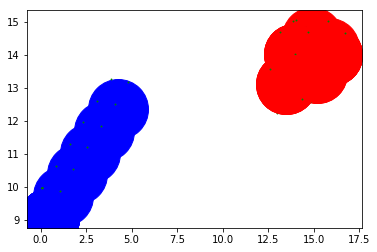

PREY :  0 :  [10.98508342767002, 13.999888741745762]
(11.60961694940733, 14.780886744448965)
(11.62998286506159, 13.235621304488335)
PRED :  0 :  [2.6173061782175684, 5.786723002291416]
(3.6153953829086474, 5.848512479382012)
(1.7915364261222257, 5.22271562953429)
PREY :  0 :  [10.98508342767002, 13.999888741745762]
(11.384718769662992, 14.916562944191844)
(11.806737423860184, 13.429902153706418)
PRED :  0 :  [3.234612356435137, 6.5734460045828325]
(4.232701561126216, 6.635235481673428)
(2.408842604339794, 6.009438631825706)
PREY :  0 :  [11.931812107217109, 14.32192104963276]
(12.331447449210081, 15.238595252078841)
(12.753466103407273, 13.751934461593416)
PRED :  0 :  [3.874697906597225, 7.34174964799063]
(4.8727871112883046, 7.403539125081226)
(3.0489281545018825, 6.7777422752335035)
PREY :  0 :  [12.758185392349665, 14.885043765938208]
(13.157820734342637, 15.80171796838429)
(13.57983938853983, 14.315057177898865)
PRED :  0 :  [4.525476825465898, 8.10101692553927]
(5.52356603015697

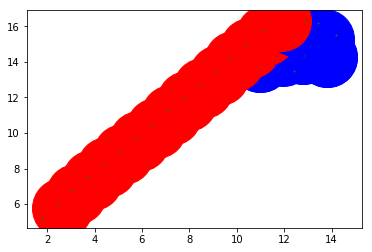

PREY :  0 :  [18.532112279580968, 0.11621208365293834]
(17.63804193593569, 0.5641386631433889)
(19.315813519090593, -0.504925877826695)
PRED :  0 :  [9.999980338804274, 17.00627072602579]
(10.06481726555592, 18.00416659881483)
(9.600599650177482, 16.08948554641609)
PREY :  0 :  [18.532112279580968, 0.11621208365293834]
(17.63804193593569, 0.5641386631433889)
(19.315813519090593, -0.504925877826695)
PRED :  0 :  [10.999960677608549, 17.01254145205158]
(11.064797604360194, 18.01043732484062)
(10.600579988981757, 16.09575627244188)
PREY :  0 :  [18.532112279580968, 0.11621208365293834]
(17.63804193593569, 0.5641386631433889)
(19.315813519090593, -0.504925877826695)
PRED :  0 :  [11.999941016412823, 17.01881217807737]
(12.064777943164469, 18.01670805086641)
(11.600560327786031, 16.102026998467668)
PREY :  0 :  [18.532112279580968, 0.11621208365293834]
(17.63804193593569, 0.5641386631433889)
(19.315813519090593, -0.504925877826695)
PRED :  0 :  [12.999921355217097, 17.025082904103158]
(13.0

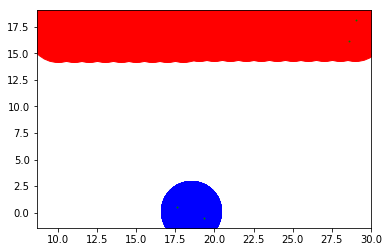

PREY :  0 :  [17.33103526837755, 5.256705853752834]
(18.14155515569415, 5.842416970485551)
(18.307965753779044, 5.043148304850424)
PRED :  0 :  [18.95694963352204, 20.290254024781802]
(18.80608814381821, 19.301699114357326)
(19.94166904414125, 20.464402473955932)
PREY :  0 :  [16.6483441210087, 4.525998800752657]
(17.4588640083253, 5.111709917485373)
(17.625274606410194, 4.312441251850247)
PRED :  0 :  [19.921925877389928, 20.552591305339902]
(19.7710643876861, 19.564036394915426)
(20.906645288009138, 20.726739754514032)
PREY :  0 :  [15.952339816282576, 3.8079611918471743]
(16.762859703599176, 4.393672308579891)
(16.929270301684067, 3.5944036429447648)
PRED :  0 :  [20.894597494547504, 20.784776415060715]
(20.743736004843676, 19.79622150463624)
(21.879316905166714, 20.958924864234845)
PREY :  0 :  [15.243372338863344, 3.102720016105279]
(16.053892226179943, 3.688431132837996)
(16.220302824264834, 2.88916246720287)
PRED :  0 :  [21.87450435076319, 20.98423205710048]
(21.72364286105936,

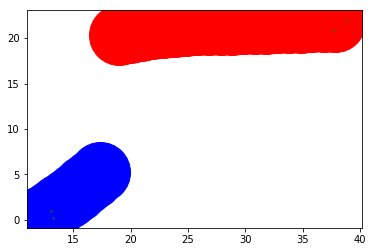

PREY :  0 :  [5.514357068821368, 16.125842723878463]
(6.509876546010499, 16.031286018473303)
(6.264687461304554, 15.464779714690966)
PRED :  0 :  [5, 9]
(4.088193458315653, 8.589379943814684)
(5.593597758348609, 9.80476189104822)
PREY :  0 :  [5.028714137642735, 15.251685447756925]
(6.024233614831867, 15.157128742351766)
(5.779044530125921, 14.590622438569428)
PRED :  0 :  [4.896359793887517, 8.005385146060565]
(3.9845532522031704, 7.594765089875249)
(5.489957552236126, 8.810147037108784)
PREY :  0 :  [4.506939849533028, 14.398601869045198]
(5.5024593267221595, 14.304045163640039)
(5.257270242016213, 13.7375388598577)
PRED :  0 :  [4.896359793887517, 8.005385146060565]
(3.9492391881431432, 7.684507352851981)
(5.564718398959797, 8.749224359214749)
PREY :  0 :  [3.9851655614233206, 13.54551829033347]
(4.980685038612452, 13.450961584928312)
(4.735495953906506, 12.884455281145973)
PRED :  0 :  [4.896359793887517, 8.005385146060565]
(3.9574460934641285, 8.34953782025802)
(5.883458656796533,

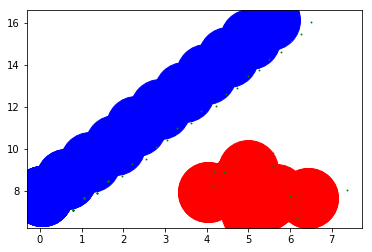

PREY :  0 :  [14, 4]
(13.31897804810153, 4.732262999906725)
(13.617148287898143, 4.923809810805599)
PRED :  0 :  [19.961523947640824, 10.274721127897378]
(20.71627286964309, 10.93073489660686)
(19.492118487467327, 9.391738390829826)
PREY :  0 :  [14, 4]
(13.962688543946832, 4.999303685196443)
(13.616487870627667, 3.076464160617305)
PRED :  0 :  [20.92304789528165, 10.549442255794755]
(21.677796817283912, 11.205456024504237)
(20.45364243510815, 9.666459518727201)
PREY :  0 :  [14.165269033209485, 4.986248521754026]
(14.127957577156318, 5.985552206950469)
(13.781756903837152, 4.062712682371331)
PRED :  0 :  [21.866314985841104, 10.88147718749246]
(22.621063907843368, 11.53749095620194)
(21.396909525667606, 9.998494450424907)
PREY :  0 :  [13.21294559100776, 5.291338773045436]
(13.175634134954592, 6.29064245824188)
(12.829433461635427, 4.367802933662741)
PRED :  0 :  [22.79464234909968, 11.25324096548244]
(23.549391271101943, 11.909254734191922)
(22.32523688892618, 10.370258228414887)
PRE

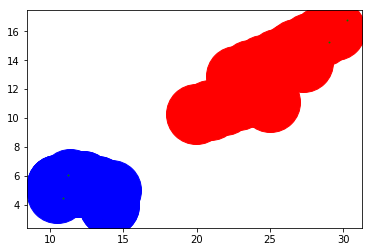

PREY :  0 :  [4.00345424175512, 12.91695452014626]
(4.587620602012021, 12.10532057337949)
(3.428241775936559, 12.09895047421071)
PRED :  0 :  [12.296044687466393, 1.9551740904269366]
(12.142208818716123, 0.9670776753510345)
(11.42481524663438, 2.446050104739652)
PREY :  0 :  [3.0158612912824134, 12.759918969468671]
(3.600027651539314, 11.948285022701901)
(2.440648825463852, 11.94191492353312)
PRED :  0 :  [12.52606150543389, 2.9283607443901456]
(12.37222563668362, 1.9402643293142434)
(11.654832064601877, 3.419236758702861)
PREY :  0 :  [2.042116726349442, 12.532275559145644]
(2.6262830866063425, 11.720641612378873)
(1.4669042605308804, 11.714271513210093)
PRED :  0 :  [12.686888926645345, 3.915343287592645]
(12.533053057895074, 2.9272468725167426)
(11.815659485813331, 4.40621930190536)
PREY :  0 :  [1.0865854308273684, 12.237385845391659]
(1.6707517910842686, 11.425751898624888)
(0.5113729650088067, 11.419381799456108)
PRED :  0 :  [12.775333243870167, 4.911424410167827]
(12.6214973751

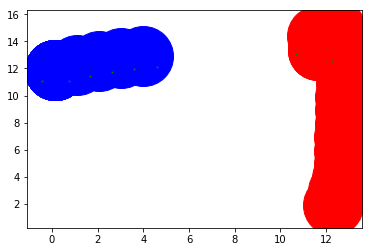

PREY :  0 :  [3.0087720993173654, 13.867836279908982]
(3.1024937100192327, 12.872237836917307)
(2.1086986908031635, 13.43209798771328)
PRED :  0 :  [15.212027575565134, 2.9772636835572945]
(15.161863651043067, 3.9760046813522907)
(16.05647526666826, 3.5129017115114296)
PREY :  0 :  [2.0273915718722626, 13.675762699342648]
(2.12111318257413, 12.680164256350974)
(1.127318163358061, 13.240024407146947)
PRED :  0 :  [15.358671974253081, 3.9664529578286296]
(15.308508049731014, 4.965193955623626)
(16.20311966535621, 4.502090985782765)
PREY :  0 :  [1.059158873999246, 13.425711818981192]
(1.1528804847011132, 12.430113375989517)
(0.1590854654850442, 12.98997352678549)
PRED :  0 :  [15.437317952814878, 4.963355565938397]
(15.38715402829281, 5.962096563733393)
(16.281765643918007, 5.498993593892533)
PREY :  0 :  [0.1071547586687367, 13.119626594911532]
(0.20087636937060394, 12.124028151919857)
(-0.792918649845465, 12.68388830271583)
PRED :  0 :  [15.445485196296667, 5.963322213449158]
(15.39532

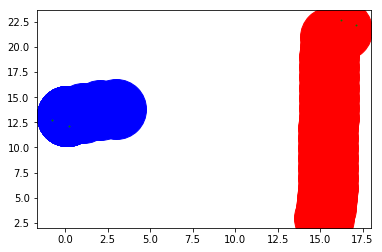

PREY :  0 :  [10.115081777618018, 0.5342535671673776]
(10.468855486752975, 1.4695846116243094)
(11.113733622786324, 0.5861620649489289)
PRED :  0 :  [19.998608066240283, 10.052744004776264]
(20.10023003264885, 9.057920917014798)
(19.449150008042228, 9.217222705059003)
PREY :  0 :  [9.221611632849132, 0.08513097765904853]
(9.57538534198409, 1.0204620221159804)
(10.220263478017438, 0.13703947544059983)
PRED :  0 :  [20.99856545699596, 10.061975292503583]
(21.100187423404524, 9.067152204742117)
(20.449107398797903, 9.226453992786322)
PREY :  0 :  [9.221611632849132, 0.08513097765904853]
(9.57538534198409, 1.0204620221159804)
(10.220263478017438, 0.13703947544059983)
PRED :  0 :  [21.998522847751634, 10.071206580230902]
(22.1001448141602, 9.076383492469436)
(21.449064789553578, 9.235685280513641)
PREY :  0 :  [9.221611632849132, 0.08513097765904853]
(9.57538534198409, 1.0204620221159804)
(10.220263478017438, 0.13703947544059983)
PRED :  0 :  [22.99848023850731, 10.08043786795822]
(23.10010

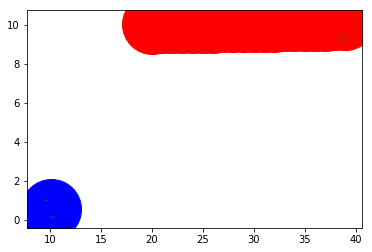

PREY :  0 :  [3.0769230769230766, 15.615384615384615]
(3.41215423398817, 16.55752052454677)
(3.8321138672887685, 16.270889665057645)
PRED :  0 :  [12.193326972443565, 5.981134385151089]
(12.566782482925865, 6.90878247666554)
(11.784508721982915, 6.893750206891153)
PREY :  0 :  [2.179119176677742, 15.174989160475889]
(2.514350333742835, 16.117125069638043)
(2.9343099670434336, 15.830494210148919)
PRED :  0 :  [12.335468307062957, 6.970980757570879]
(12.708923817545257, 7.8986288490853305)
(11.926650056602307, 7.883596579310943)
PREY :  0 :  [1.3085188378727106, 14.682998256014674]
(1.6437499949378038, 15.625134165176828)
(2.0637096282384024, 15.338503305687704)
PRED :  0 :  [12.42423447234319, 7.967033250114039]
(12.79768998282549, 8.894681341628491)
(12.01541622188254, 8.879649071854104)
PREY :  0 :  [0.4667252980147527, 14.14319862999275]
(0.8019564550798459, 15.085334539154903)
(1.2219160883804445, 14.79870367966578)
PRED :  0 :  [12.457216500379904, 8.966489195029364]
(12.8306720108

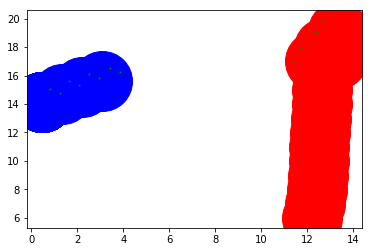

PREY :  0 :  [17, 16]
(16.232139979714315, 16.640617662296993)
(17.56619893065829, 15.175731372111368)
PRED :  0 :  [14.728199992692803, 19.685364699004992]
(13.743513839720634, 19.51102829963621)
(14.858906825149909, 18.693943636111417)
PREY :  0 :  [17.401436951797734, 16.91588665987192]
(16.63357693151205, 17.556504322168912)
(17.967635882456026, 16.091618031983288)
PRED :  0 :  [15.445239745613284, 20.382396974248927]
(14.460553592641116, 20.208060574880143)
(15.57594657807039, 19.39097591135535)
PREY :  0 :  [16.66845711739415, 16.235636292464672]
(15.900597097108465, 16.876253954761665)
(17.234656048052443, 15.41136766457604)
PRED :  0 :  [16.16158584627724, 21.08014210254689]
(15.176899693305073, 20.905805703178107)
(16.29229267873435, 20.088721039653315)
PREY :  0 :  [16.66845711739415, 16.235636292464672]
(17.660494355078086, 16.361581197277975)
(15.747352176577163, 16.62495067442677)
PRED :  0 :  [16.8779319469412, 21.777887230844854]
(15.893245793969031, 21.60355083147607)
(

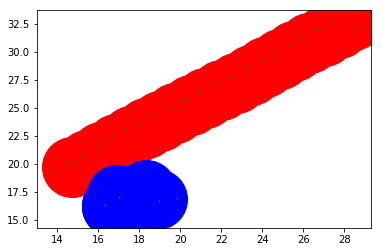

PREY :  0 :  [4.667179882264863, 16.05700966641711]
(5.158353078409663, 15.18594773326373)
(5.553344349631732, 16.52038050794298)
PRED :  0 :  [6, 17]
(5.300131436276379, 17.714271652462447)
(6.841060007288144, 16.459058169356013)
PREY :  0 :  [4.334359764529726, 15.11401933283422]
(4.825532960674526, 14.24295739968084)
(5.2205242318965945, 15.57739017436009)
PRED :  0 :  [6, 17]
(5.006464531756445, 17.113522127103312)
(6.993927636792817, 17.110035688844334)
PREY :  0 :  [4.001539646794589, 14.17102899925133]
(4.4927128429393886, 13.29996706609795)
(4.8877041141614574, 14.634399840777201)
PRED :  0 :  [6.654177502031038, 17.75634105788092]
(5.660642033787483, 17.869863184984233)
(7.648105138823855, 17.866376746725255)
PREY :  0 :  [3.6506219763120002, 13.23462268330559]
(4.1417951724568, 12.36356075015221)
(4.536786443678869, 13.69799352483146)
PRED :  0 :  [6.8687990837452855, 18.733038337831303]
(5.875263615501731, 18.846560464934615)
(7.862726720538102, 18.843074026675637)
PREY :  0

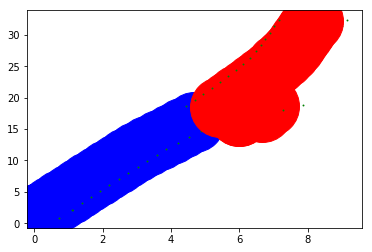

PREY :  0 :  [9.029857499854668, 4.757464374963667]
(9.719691292551923, 5.481432149421149)
(10.020035077392347, 4.617648907501679)
PRED :  0 :  [12, 3]
(11.646740341413638, 2.064474685743113)
(11.138640766316783, 2.4920036707330833)
PREY :  0 :  [8.059714999709335, 4.514928749927334]
(8.749548792406591, 5.238896524384815)
(9.049892577247014, 4.375113282465346)
PRED :  0 :  [11.262693219600182, 3.67555807417013]
(10.90943356101382, 2.7400327599132432)
(10.401333985916965, 3.1675617449032134)
PREY :  0 :  [7.109058348231814, 4.2046837967023905]
(7.798892140929071, 4.928651571159872)
(8.099235925769493, 4.064868329240403)
PRED :  0 :  [11.262693219600182, 3.67555807417013]
(10.374056362970713, 4.134169605904445)
(10.857236826020593, 4.589672461380743)
PREY :  0 :  [6.158401696754293, 3.8944388434774475]
(6.848235489451549, 4.618406617934929)
(7.148579274291972, 3.7546233760154597)
PRED :  0 :  [12.027086945157277, 4.320307818124282]
(11.138450088527808, 4.7789193498585965)
(11.62163055157

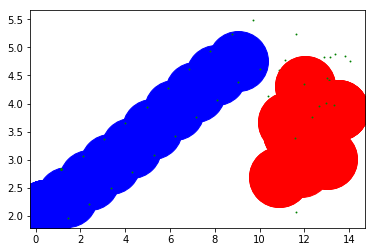

PREY :  0 :  [19.94127797804853, 11.001725626825005]
(20.504176675500304, 10.175199731037647)
(20.375382544372663, 11.902588116607177)
PRED :  0 :  [1.875584347074546, 17.483065265940372]
(2.1060548203206264, 16.509985946993694)
(0.9752878243773208, 17.047788145913042)
PREY :  0 :  [19.83460998042579, 10.007430932942373]
(20.397508677877564, 9.180905037155016)
(20.268714546749923, 10.908293422724546)
PRED :  0 :  [2.7683829448340043, 17.93352132799165]
(2.9988534180800848, 16.96044200904497)
(1.8680864221367792, 17.49824420796432)
PREY :  0 :  [19.68204786599035, 9.019137048898266]
(20.244946563442124, 8.192611153110908)
(20.116152432314482, 9.919999538680438)
PRED :  0 :  [3.6774792831253595, 18.350107270751664]
(3.90794975637144, 17.377027951804987)
(2.7771827604281345, 17.914830150724335)
PREY :  0 :  [19.485548577298783, 8.038633081775384]
(20.048447274750558, 7.2121071859880255)
(19.919653143622917, 8.939495571557556)
PRED :  0 :  [4.601903763663742, 18.731472423566316]
(4.8323742

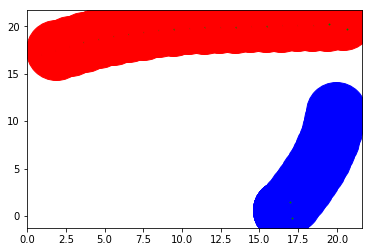

PREY :  0 :  [9, 13]
(8.518202227816277, 13.876282435473176)
(8.68308186944831, 13.948452897368986)
PRED :  0 :  [3.569209978830308, 10.82219219164378]
(4.4532478427332, 10.35477689965387)
(4.142687066208633, 11.641413791854658)
PREY :  0 :  [9, 13]
(8.001541296991592, 13.055499715195376)
(8.027661742492194, 13.233577209904317)
PRED :  0 :  [4.138419957660616, 11.644384383287559]
(5.022457821563508, 11.17696909129765)
(4.711897045038941, 12.463605983498438)
PREY :  0 :  [9.868205672727115, 12.50379549594501]
(8.869746969718706, 12.559295211140386)
(8.895867415219309, 12.737372705849326)
PRED :  0 :  [4.75794002219976, 12.429365204475832]
(5.6419778861026515, 11.961949912485924)
(5.3314171095780845, 13.248586804686711)
PREY :  0 :  [9.868205672727115, 12.50379549594501]
(8.8683213280549, 12.519003956728998)
(8.8872425483745, 12.697989596422746)
PRED :  0 :  [5.377460086738903, 13.214346025664106]
(6.261497950641795, 12.746930733674198)
(5.950937174117228, 14.033567625874985)
PREY :  0 :

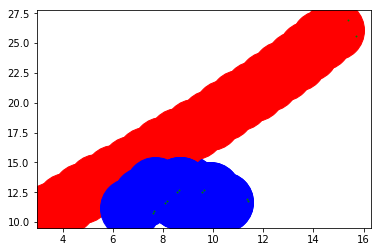

PREY :  0 :  [3.5809418225382528, 13.092040615499549]
(4.338374926389042, 12.439127839402342)
(4.4692273315597335, 12.632748927721021)
PRED :  0 :  [6, 13]
(6.154987171672025, 12.012083517387676)
(5.9065532305407835, 12.004375722836352)
PREY :  0 :  [3.1618836450765055, 12.184081230999098]
(3.9193167489272946, 11.531168454901891)
(4.050169154097986, 11.72478954322057)
PRED :  0 :  [6.998914744269587, 12.953423893670418]
(7.153901915941613, 11.965507411058095)
(6.905467974810371, 11.95779961650677)
PREY :  0 :  [2.686520939873892, 11.304291313744727]
(3.4439540437246805, 10.65137853764752)
(3.5748064488953726, 10.8449996259662)
PRED :  0 :  [6.998914744269587, 12.953423893670418]
(7.53486117563669, 13.797675883721295)
(7.726521096299938, 13.639418789048719)
PREY :  0 :  [2.211158234671278, 10.424501396490356]
(2.9685913385220672, 9.77158862039315)
(3.099443743692759, 9.965209708711829)
PRED :  0 :  [6.998914744269587, 12.953423893670418]
(7.979974754608237, 12.759719851083977)
(7.901897

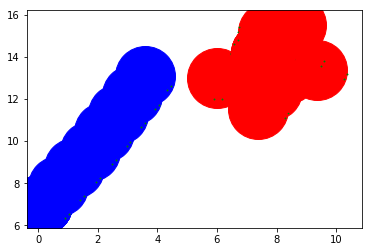

PREY :  0 :  [2.8038838648618163, 15.01941932430908]
(3.7837686852970442, 15.218983195489765)
(3.7800388534896077, 15.236494053785076)
PRED :  0 :  [4.1835134889989884, 20.983017191790367]
(5.0920789038290115, 21.400759800312347)
(4.961620530773196, 21.611148890991572)
PREY :  0 :  [2.6083560287108147, 14.038721172332588]
(3.5882408491460427, 14.238285043513272)
(3.584511017338606, 14.255795901808584)
PRED :  0 :  [4.366184547449863, 21.96619127831037]
(5.274749962279886, 22.38393388683235)
(5.14429158922407, 22.594322977511574)
PREY :  0 :  [2.4134015455621594, 13.057908881677418]
(3.3932863659973873, 13.257472752858103)
(3.3895565341899507, 13.274983611153415)
PRED :  0 :  [4.547929426694921, 22.949536995171027]
(5.456494841524944, 23.367279603693007)
(5.326036468469129, 23.577668694372232)
PREY :  0 :  [2.2190109544509244, 12.076984675590412]
(3.1988957748861524, 12.276548546771096)
(3.195165943078716, 12.294059405066408)
PRED :  0 :  [4.728643126953433, 23.933072738567716]
(5.63720

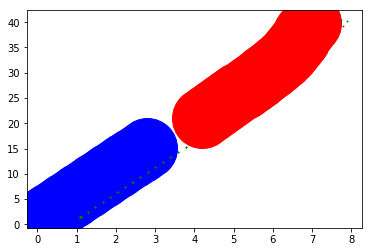

PREY :  0 :  [13.013606076167857, 16.835601012694642]
(13.649534148933753, 16.06385268178083)
(12.172557483921343, 16.29464143427851)
PRED :  0 :  [6.611573374193313, 1.791187719809785]
(7.105076833450245, 2.660931553189155)
(7.216747879517187, 2.5872805649641704)
PREY :  0 :  [12.048400087374839, 16.574110287814975]
(12.684328160140735, 15.802361956901164)
(11.207351495128325, 16.033150709398843)
PRED :  0 :  [7.199569553826424, 2.6000514244824977]
(7.693073013083357, 3.469795257861868)
(7.804744059150298, 3.396144269636883)
PREY :  0 :  [11.107854821052, 16.234441917197838]
(11.743782893817896, 15.462693586284027)
(10.266806228805486, 15.693482338781706)
PRED :  0 :  [7.764256197029683, 3.42535681946537]
(8.257759656286614, 4.29510065284474)
(8.369430702353556, 4.2214496646197555)
PREY :  0 :  [10.192934829439595, 15.830806674747482]
(10.828862902205492, 15.059058343833671)
(9.351886237193082, 15.28984709633135)
PRED :  0 :  [8.305614474470572, 4.2661488362247075]
(8.799117933727503,

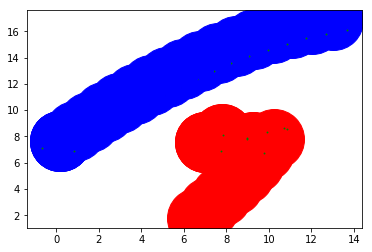

PREY :  0 :  [16, 10]
(16.37711406299723, 10.926166822710533)
(16.582963364112473, 9.187501559322932)
PRED :  0 :  [9.847998304005088, 11.52999894000318]
(10.705322620208417, 12.044775606963226)
(9.650560607080513, 10.549683503098752)
PREY :  0 :  [16, 10]
(15.154210314653358, 10.533516455379988)
(16.902051717147266, 10.431627964330014)
PRED :  0 :  [10.695996608010176, 12.05999788000636]
(11.553320924213505, 12.574774546966406)
(10.4985589110856, 11.079682443101932)
PREY :  0 :  [16.9843746595417, 9.823913289393666]
(16.13858497419506, 10.357429744773654)
(17.886426376688966, 10.25554125372368)
PRED :  0 :  [11.56162493840029, 12.560685001496445]
(12.418949254603618, 13.07546166845649)
(11.364187241475713, 11.580369564592017)
PREY :  0 :  [16.9843746595417, 9.823913289393666]
(15.986673798572474, 9.891684906028235)
(17.573172279580966, 10.632193786891962)
PRED :  0 :  [12.427253268790402, 13.06137212298653]
(13.28457758499373, 13.576148789946576)
(12.229815571865826, 12.08105668608210

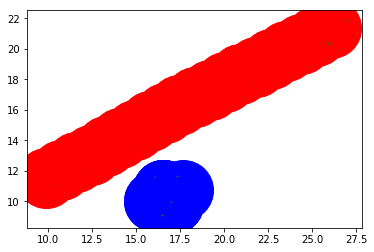

PREY :  0 :  [19.867836279908982, 11.008772099317365]
(19.170851077413577, 10.29168659011889)
(20.860781145096336, 10.890195142457834)
PRED :  0 :  [2.874697156636394, 15.48466987132708]
(3.6386644447083554, 16.129924846322215)
(3.831804980020864, 15.77440184128594)
PREY :  0 :  [19.68530713704177, 10.02557165586539]
(18.988321934546367, 9.308486146666914)
(20.678252002229126, 9.906994699005859)
PRED :  0 :  [3.76578777274466, 15.938495293580825]
(4.529755060816621, 16.58375026857596)
(4.72289559612913, 16.228227263539686)
PREY :  0 :  [19.455368019199813, 9.052366640421027]
(18.758382816704408, 8.335281131222551)
(20.448312884387168, 8.933789683561496)
PRED :  0 :  [4.672449030370167, 16.360354706088042]
(5.436416318442128, 17.00560968108318)
(5.629556853754638, 16.650086676046904)
PREY :  0 :  [19.18075220094639, 8.09081261054803]
(18.483766998450985, 7.373727101349553)
(20.173697066133744, 7.9722356536884975)
PRED :  0 :  [5.5938315504593215, 16.749011690682632]
(6.3577988385312825,

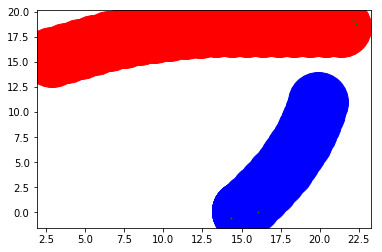

PREY :  0 :  [13.07152330911474, 11.628609323645897]
(13.089961338821901, 12.62843932872702)
(13.579186576492361, 10.767053749724239)
PRED :  0 :  [15.747140268792055, 6.6646663965850355]
(15.3403545390991, 5.7511427952926715)
(16.732716399693036, 6.8338990476848)
PREY :  0 :  [12.15060674126842, 11.238849557807816]
(12.169044770975582, 12.238679562888938)
(12.658270008646042, 10.377293983886158)
PRED :  0 :  [16.481253612735703, 7.343693346156165]
(16.074467883042747, 6.430169744863801)
(17.466829743636684, 7.5129259972559295)
PREY :  0 :  [11.23718007342798, 10.831846213254101]
(11.255618103135141, 11.831676218335224)
(11.744843340805602, 9.970290639332443)
PRED :  0 :  [17.20122614441417, 8.037695906402522]
(16.794440414721215, 7.124172305110158)
(18.186802275315152, 8.206928557502286)
PREY :  0 :  [10.33120810478073, 10.408508532406499]
(10.349646134487891, 11.408338537487621)
(10.838871372158351, 9.546952958484841)
PRED :  0 :  [17.20122614441417, 8.037695906402522]
(17.6228673089

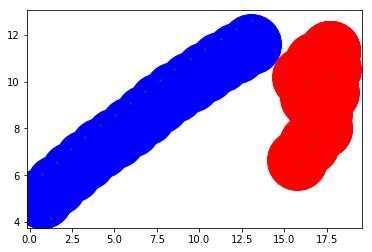

PREY :  0 :  [1.105572809000084, 16.552786404500043]
(1.4507773949774605, 15.614258944155814)
(2.018439138340895, 16.14452782864911)
PRED :  0 :  [14.066642257108201, 7.997776933772036]
(14.976867242999173, 7.583662849177244)
(14.686373940257292, 8.78259069569342)
PREY :  0 :  [0.2362587387199111, 16.0585263037303]
(0.5814633246972877, 15.119998843386071)
(1.1491250680607223, 15.650267727879365)
PRED :  0 :  [14.081353020032509, 8.997668724644521]
(14.991578005923479, 8.58355464004973)
(14.7010847031816, 9.782482486565906)
PREY :  0 :  [0.2362587387199111, 16.0585263037303]
(0.5814633246972877, 15.119998843386071)
(1.1491250680607223, 15.650267727879365)
PRED :  0 :  [14.096063782956817, 9.997560515517007]
(15.006288768847789, 9.583446430922216)
(14.715795466105908, 10.782374277438391)
PREY :  0 :  [0.2362587387199111, 16.0585263037303]
(0.5814633246972877, 15.119998843386071)
(1.1491250680607223, 15.650267727879365)
PRED :  0 :  [14.110774545881124, 10.997452306389492]
(15.02099953177

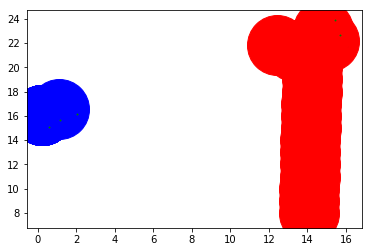

PREY :  0 :  [5.406800961950149, 2.194944162646632]
(4.804100961081702, 1.3969763005411624)
(6.074361855226413, 1.4503889573272433)
PRED :  0 :  [14.926560290313644, 19.376146285923305]
(14.806221379354618, 18.383413418275016)
(15.236077023058954, 18.42525228964892)
PREY :  0 :  [4.7965295656607205, 1.4027517473389932]
(4.193829564792273, 0.6047838852335234)
(5.464090458936984, 0.6581965420196043)
PRED :  0 :  [15.886357585372396, 19.65684034071945]
(15.76601867441337, 18.664107473071162)
(16.195874318117706, 18.705946344445067)
PREY :  0 :  [4.167960722585772, 0.6249977955551265]
(3.5652607217173253, -0.1729700665503433)
(4.835521615862036, -0.11955740976426243)
PRED :  0 :  [16.875300770395, 19.805135238802112]
(16.754961859435973, 18.812402371153823)
(17.184817503140312, 18.854241242527728)
PREY :  0 :  [4.167960722585772, 0.6249977955551265]
(3.5652607217173253, -0.1729700665503433)
(4.835521615862036, -0.11955740976426243)
PRED :  0 :  [17.864243955417606, 19.953430136884773]
(17.

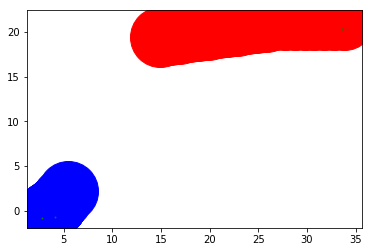

PREY :  0 :  [17.313376467036285, 9.272986847450182]
(17.913415258824784, 8.473015942761146)
(18.062451616233204, 8.610501813011206)
PRED :  0 :  [17.881523122554615, 18.47214085229046]
(18.76977772008513, 18.931492318997496)
(16.914699970377843, 18.727587505067458)
PREY :  0 :  [16.617849440916256, 8.554486912908342]
(17.217888232704755, 7.754516008219304)
(17.366924590113175, 7.892001878469364)
PRED :  0 :  [18.770633197185802, 18.929834281552154]
(19.658887794716318, 19.389185748259187)
(17.80381004500903, 19.18528093432915)
PREY :  0 :  [15.913734899646537, 7.8444005007213935]
(16.513773691435038, 7.044429596032356)
(16.662810048843458, 7.181915466282416)
PRED :  0 :  [19.6675816089545, 19.371969494609893]
(20.555836206485015, 19.831320961316926)
(18.700758456777727, 19.62741614738689)
PREY :  0 :  [15.201294246295724, 7.14266813332406]
(15.801333038084223, 6.342697228635022)
(15.950369395492643, 6.480183098885083)
PRED :  0 :  [20.572649774678407, 19.79723601738492]
(21.4609043722

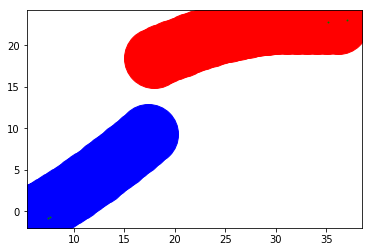

PREY :  0 :  [6.247423305293122, 16.34149539213148]
(7.08626214486308, 16.88587522389321)
(7.208766793625673, 16.616847344077716)
PRED :  0 :  [8.357097794327803, 7.93406700256792]
(9.347248546005991, 7.7940616849863416)
(7.360318370489001, 8.014259148140818)
PREY :  0 :  [5.5221996244928135, 15.652982056889197]
(6.361038464062772, 16.197361888650924)
(6.483543112825365, 15.928334008835433)
PRED :  0 :  [8.936740379417305, 8.748937835001355]
(9.926891131095493, 8.608932517419776)
(7.939960955578503, 8.829129980574253)
PREY :  0 :  [4.807624430293829, 14.953423416148134]
(5.646463269863787, 15.49780324790986)
(5.76896791862638, 15.22877536809437)
PRED :  0 :  [8.936740379417305, 8.748937835001355]
(8.072446016767351, 8.24595149851545)
(9.769214009632593, 9.303002501801341)
PREY :  0 :  [4.093049236094844, 14.25386477540707]
(4.931888075664802, 14.798244607168797)
(5.054392724427395, 14.529216727353306)
PRED :  0 :  [8.234902391344544, 9.46127443977327]
(7.370608028694591, 8.958288103287

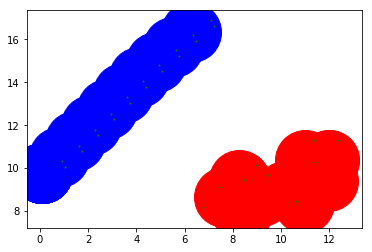

PREY :  0 :  [19.930415004816552, 17.3665077336322]
(18.936552404018947, 17.255886168212893)
(19.590636028812234, 16.42600241867356)
PRED :  0 :  [13.753936208048621, 17.656947634285462]
(14.456620557979315, 16.945445909507175)
(12.939569771301842, 18.237298654531273)
PREY :  0 :  [19.01648454505588, 17.77237854401606]
(18.022621944258276, 17.661756978596753)
(18.676705569051563, 16.83187322905742)
PRED :  0 :  [14.484537900087414, 18.339751535555845]
(15.187222250018108, 17.628249810777557)
(13.670171463340635, 18.920102555801655)
PREY :  0 :  [19.01648454505588, 17.77237854401606]
(18.195431891940967, 18.343231012533945)
(18.141659737971533, 17.28793911858721)
PRED :  0 :  [15.215139592126206, 19.022555436826227]
(15.9178239420569, 18.31105371204794)
(14.400773155379428, 19.602906457072038)
PREY :  0 :  [19.31387036437463, 18.7271359343871]
(18.492817711259715, 19.297988402904984)
(18.43904555729028, 18.24269650895825)
PRED :  0 :  [15.933067212068408, 19.718673194482303]
(16.6357515

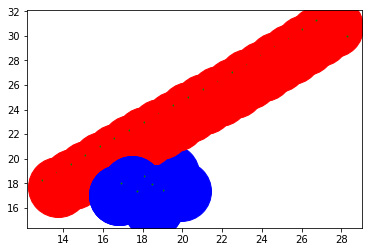

PREY :  0 :  [6.0087720993173654, 3.867836279908982]
(6.031958272654861, 4.867567444455713)
(5.008778756913416, 3.871485272616243)
PRED :  0 :  [14.899330803827866, 2.994919953032432]
(14.282553805879054, 2.207782014167043)
(13.973067511244652, 2.618042900384086)
PREY :  0 :  [5.0283823772388185, 3.6707677820643263]
(5.051568550576314, 4.670498946611057)
(4.028389034834869, 3.6744167747715877)
PRED :  0 :  [14.796849914023447, 3.9896549263921175]
(14.180072916074636, 3.2025169875267285)
(13.870586621440234, 3.6127778737437715)
PREY :  0 :  [4.062863127211089, 3.410436113176558]
(4.086049300548584, 4.410167277723289)
(3.0628697848071393, 3.4140851058838195)
PRED :  0 :  [14.796849914023447, 3.9896549263921175]
(14.445872121179589, 4.926038709320065)
(14.957271017267137, 4.976703592686783)
PREY :  0 :  [3.0973438771833592, 3.15010444428879]
(3.120530050520854, 4.149835608835521)
(2.0973505347794097, 3.1537534369960514)
PRED :  0 :  [15.547482182654315, 3.3289347153420277]
(15.19650438981

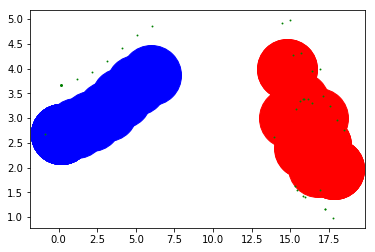

PREY :  0 :  [7.092040615499548, 7.580941822538253]
(6.1126967973516715, 7.378739730918163)
(8.081893166432728, 7.723040124467151)
PRED :  0 :  [13, 6]
(13.035719044166878, 6.999361871337808)
(13.546245079762631, 6.837625401259487)
PREY :  0 :  [6.184081230999096, 7.1618836450765055]
(5.20473741285122, 6.959681553456416)
(7.173933781932276, 7.303981947005404)
PRED :  0 :  [13, 6]
(13.95544804794701, 6.295159325914407)
(13.970734458513068, 5.759844610605257)
PREY :  0 :  [5.276121846498644, 6.742825467614758]
(4.296778028350768, 6.540623375994668)
(6.265974397431824, 6.884923769543657)
PRED :  0 :  [13, 6]
(12.845959888186309, 5.011935404969682)
(12.358229967004359, 5.233102859081628)
PREY :  0 :  [4.3681624619981925, 6.323767290153011]
(3.388818643850316, 6.121565198532921)
(5.358015012931372, 6.46586559208191)
PRED :  0 :  [13.948895285479304, 6.31559109175506]
(13.794855173665614, 5.327526496724742)
(13.307125252483663, 5.548693950836688)
PREY :  0 :  [3.457186446494849, 5.9113079598

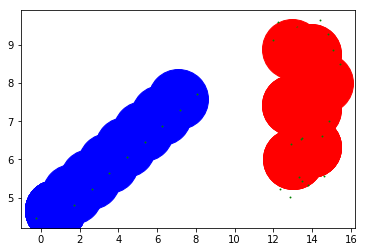

PREY :  0 :  [17.889568473925152, 9.006116265326382]
(18.889296320137927, 9.029445078128791)
(17.37968696958458, 8.145871619001051)
PRED :  0 :  [1.8931989501541189, 9.449661689988796]
(1.602186706001408, 8.492942361369789)
(1.2054913500041162, 8.723673909998027)
PREY :  0 :  [17.693126436074095, 8.025600826506103]
(18.69285428228687, 8.048929639308513)
(17.183244931733523, 7.165356180180773)
PRED :  0 :  [2.80388952914336, 9.862750868423962]
(2.512877284990649, 8.906031539804955)
(2.1161819289933574, 9.136763088433193)
PREY :  0 :  [17.419671419917538, 7.063716033956176]
(18.419399266130313, 7.087044846758585)
(16.909789915576965, 6.203471387630845)
PRED :  0 :  [3.730597544645678, 10.23853305800159]
(3.4395853004929666, 9.281813729382582)
(3.042889944495675, 9.51254527801082)
PREY :  0 :  [17.077320983743814, 6.124143695681117]
(18.07704882995659, 6.147472508483526)
(16.56743947940324, 5.2638990493557865)
PRED :  0 :  [4.671900431446729, 10.576096200687529]
(4.380888187294018, 9.6193

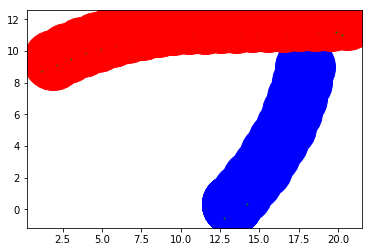

PREY :  0 :  [17.083842665097812, 7.599181165980292]
(17.657423526171872, 6.780032219933519)
(17.946167083009943, 7.092824968948493)
PRED :  0 :  [16.913685220141474, 7.406422586103459]
(16.952731269180987, 6.4071851738462895)
(15.914177357777941, 7.4377918875537485)
PREY :  0 :  [16.16781833661636, 7.198058454543871]
(16.74139919769042, 6.378909508497097)
(17.03014275452849, 6.6917022575120715)
Prey slaughtered
[16.913685220141474, 7.406422586103459]
PRED :  1 :  [16.913685220141474, 7.406422586103459]
(16.952731269180987, 6.4071851738462895)
(15.914177357777941, 7.4377918875537485)


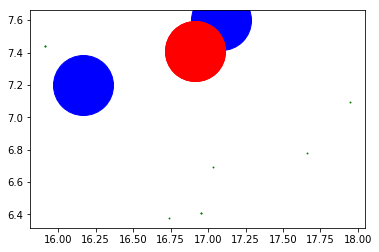

PREY :  0 :  [0.4452998037747704, 7.167949705662156]
(1.1207776961059617, 6.4305694665915585)
(0.6833592954333202, 6.196699131180333)
PRED :  0 :  [12, 18]
(12.082156560296532, 17.003380564307395)
(11.014676223914485, 17.8293041995813)
PREY :  0 :  [0.4452998037747704, 7.167949705662156]
(1.1207776961059617, 6.4305694665915585)
(0.6833592954333202, 6.196699131180333)
PRED :  0 :  [11.00014759753585, 17.982819392133354]
(11.082304157832382, 16.98619995644075)
(10.014823821450335, 17.812123591714656)
PREY :  0 :  [0.4452998037747704, 7.167949705662156]
(1.1207776961059617, 6.4305694665915585)
(0.6833592954333202, 6.196699131180333)
PRED :  0 :  [10.42174565457417, 17.167067473730366]
(10.503902214870703, 16.17044803803776)
(9.436421878488655, 16.996371673311668)
PREY :  0 :  [0.4452998037747704, 7.167949705662156]
(1.1207776961059617, 6.4305694665915585)
(0.6833592954333202, 6.196699131180333)
PRED :  0 :  [10.42174565457417, 17.167067473730366]
(10.515112555455824, 16.171435703536307)
(

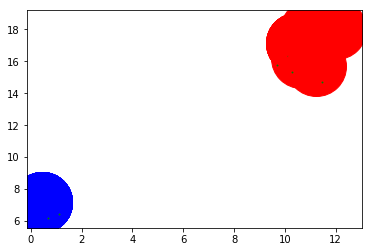

PREY :  0 :  [0.24074339763470332, 2.3492086265440317]
(1.2330761638798484, 2.2256138004538677)
(1.1927606702671643, 2.655252924987003)
PRED :  0 :  [14, 12]
(14.966132602960414, 11.741953892691761)
(13.315310212890932, 11.271165385407267)
PREY :  0 :  [0.24074339763470332, 2.3492086265440317]
(1.2330761638798484, 2.2256138004538677)
(1.1927606702671643, 2.655252924987003)
PRED :  0 :  [14.547098343702805, 12.83706833790178]
(15.513230946663219, 12.57902223059354)
(13.862408556593737, 12.108233723309047)
PREY :  0 :  [0.24074339763470332, 2.3492086265440317]
(1.2330761638798484, 2.2256138004538677)
(1.1927606702671643, 2.655252924987003)
PRED :  0 :  [15.546316133913543, 12.876613346769805]
(16.512448736873957, 12.618567239461566)
(14.861626346804474, 12.147778732177072)
PREY :  0 :  [0.24074339763470332, 2.3492086265440317]
(1.2330761638798484, 2.2256138004538677)
(1.1927606702671643, 2.655252924987003)
PRED :  0 :  [15.546316133913543, 12.876613346769805]
(16.13648216362734, 12.06933

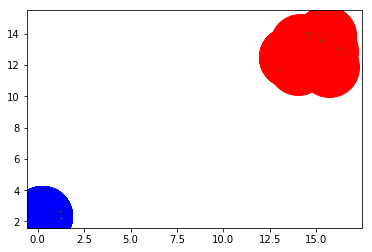

PREY :  0 :  [14, 10]
(14.885904402987787, 9.536132142990214)
(13.712515234829937, 9.042214789321157)
PRED :  0 :  [10.813733471206735, 15.581238193719097]
(10.241880624002786, 14.760881977710017)
(11.36072797018984, 14.744101993282023)
PREY :  0 :  [14, 10]
(14.867882720946973, 10.49676914425282)
(14.652310373164095, 9.242048037760625)
PRED :  0 :  [11.62746694241347, 16.162476387438193]
(11.05561409520952, 15.342120171429112)
(12.174461441396575, 15.32534018700112)
PREY :  0 :  [14.26778158395532, 10.963479643425007]
(15.135664304902294, 11.460248787677827)
(14.920091957119416, 10.205527681185632)
PRED :  0 :  [12.42040605741699, 16.77177726541018]
(11.84855321021304, 15.951421049401098)
(12.967400556400095, 15.934641064973105)
PREY :  0 :  [14.26778158395532, 10.963479643425007]
(13.29312979331954, 10.739752383104618)
(13.863316806194698, 11.87803321952159)
PRED :  0 :  [13.21334517242051, 17.381078143382165]
(12.64149232521656, 16.560721927373084)
(13.760339671403615, 16.5439419429

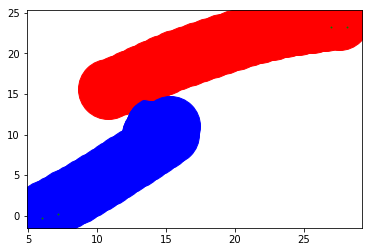

PREY :  0 :  [2.8585786437626903, 12.010050506338834]
(3.411422530617488, 12.843335353655332)
(2.789236650325546, 11.012457559317774)
PRED :  0 :  [1.2315471529140363, 7.972823681854735]
(0.9141271883631314, 7.024538616009816)
(2.1931725330638496, 7.6984578161722)
PREY :  0 :  [2.7059210153682036, 11.02177137143161]
(3.2587649022230014, 11.855056218748109)
(2.6365790219310594, 10.02417842441055)
PRED :  0 :  [1.4699737689517893, 8.943984198332204]
(1.1525538044008845, 7.995699132487285)
(2.431599149101603, 8.66961833264967)
PREY :  0 :  [2.543743442067276, 10.035009781827403]
(3.096587328922074, 10.868294629143902)
(2.474401448630132, 9.037416834806344)
PRED :  0 :  [1.7156892580393759, 9.913326190831471]
(1.398269293488471, 8.965041124986552)
(2.6773146381891895, 9.638960325148936)
PREY :  0 :  [2.373209606898173, 9.049657960870789]
(2.926053493752971, 9.882942808187288)
(2.303867613461029, 8.05206501384973)
Prey slaughtered
[1.7156892580393759, 9.913326190831471]
PRED :  1 :  [1.7156

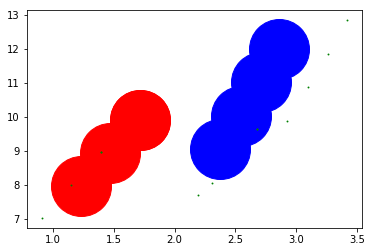

PREY :  0 :  [4.260059926604056, 6.327327206003687]
(4.784072208481066, 7.179037913017547)
(5.170038839117785, 6.7419817354379274)
PRED :  0 :  [11, 10]
(10.921363499542725, 10.99690335579525)
(11.691144560980998, 9.2772834609431)
PREY :  0 :  [3.520119853208112, 5.654654412007375]
(4.044132135085122, 6.506365119021234)
(4.430098765721841, 6.069308941441615)
PRED :  0 :  [11, 10]
(10.586459701089463, 9.089514183978144)
(10.744838458889985, 10.966898437240625)
PREY :  0 :  [2.780179779812168, 4.981981618011062]
(3.3041920616891787, 5.833692325024922)
(3.690158692325897, 5.396636147445302)
PRED :  0 :  [11, 10]
(10.055397188259086, 10.328215673073602)
(11.939393355391896, 10.342841251668398)
PREY :  0 :  [2.0402397064162243, 4.3093088240147495]
(2.5642519882932344, 5.161019531028609)
(2.950218618929953, 4.7239633534489895)
PRED :  0 :  [11, 10]
(10.627214864895475, 9.07208230804392)
(10.702240276307636, 10.954640847097298)
PREY :  0 :  [1.3002996330202805, 3.636636030018437]
(1.824311914

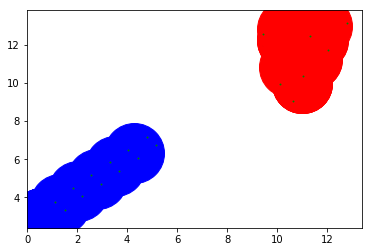

PREY :  0 :  [6.051316701949486, 16.683772233983163]
(6.672055422217911, 15.899754733439)
(7.049743241132539, 16.739847592697593)
PRED :  0 :  [18.340971099255395, 6.94007377873897]
(18.952899391977, 6.149160531557698)
(17.692785558229243, 7.701556217410167)
PREY :  0 :  [5.11603461147783, 16.329869124018064]
(5.736773331746255, 15.5458516234739)
(6.114461150660883, 16.385944482732494)
PRED :  0 :  [18.63993547046447, 7.89433805279913]
(19.251863763186073, 7.103424805617857)
(17.991749929438317, 8.655820491470328)
PREY :  0 :  [4.195212991271517, 15.939885093882701]
(4.815951711539942, 15.155867593338538)
(5.19363953045457, 15.995960452597132)
PRED :  0 :  [18.894457502193077, 8.861405028434604]
(19.50638579491468, 8.070491781253331)
(18.246271961166926, 9.622887467105802)
PREY :  0 :  [3.289839299656722, 15.515269410550353]
(3.910578019925147, 14.73125191000619)
(4.2882658388397745, 15.571344769264783)
PRED :  0 :  [19.101884573122764, 9.839655512843137]
(19.713812865844368, 9.0487422

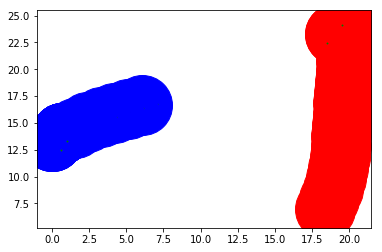

PREY :  0 :  [11.013006765667397, 8.83923820297824]
(10.029590872699782, 8.657873428397544)
(12.012926279168502, 8.851925461141953)
PRED :  0 :  [12.779871838064933, 17.625939227236337]
(12.682633664252487, 16.63067808685477)
(12.622174590985278, 16.638451719333833)
PREY :  0 :  [11.013006765667397, 8.83923820297824]
(12.012811251968744, 8.859011649104323)
(10.030900915980428, 9.027567966984455)
PRED :  0 :  [13.559743676129866, 18.251878454472674]
(13.46250550231742, 17.256617314091105)
(13.40204642905021, 17.26439094657017)
PREY :  0 :  [10.358442691401866, 8.083231673455574]
(11.358247177703213, 8.103005119581656)
(9.376336841714897, 8.271561437461788)
PRED :  0 :  [14.348111378434485, 18.867082783100923]
(14.250873204622039, 17.871821642719354)
(14.19041413135483, 17.87959527519842)
PREY :  0 :  [10.358442691401866, 8.083231673455574]
(10.801792155892805, 8.979580518680242)
(10.07283012761523, 9.041576842696399)
PRED :  0 :  [15.136479080739104, 19.48228711172917]
(15.0392409069266

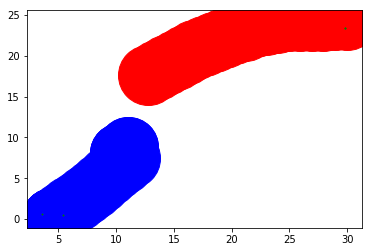

PREY :  0 :  [13.167949705662156, 15.445299803774772]
(12.344197591246836, 16.01224993738115)
(12.67675044731879, 14.574252567051683)
PRED :  0 :  [3, 2]
(2.2046068826770027, 2.6060938779720555)
(2.5098640559496106, 2.8716460040347993)
PREY :  0 :  [12.335899411324313, 14.890599607549543]
(11.512147296908992, 15.457549741155919)
(11.844700152980947, 14.019552370826455)
PRED :  0 :  [3, 2]
(2.8274101538228846, 1.0150062208335733)
(2.4512497419848662, 1.1640136637908942)
PREY :  0 :  [11.50384911698647, 14.335899411324315]
(10.680097002571149, 14.902849544930692)
(11.012649858643103, 13.464852174601226)
PRED :  0 :  [3.75878331417481, 1.348656862990104]
(3.5861934679976946, 0.36366308382367707)
(3.210033056159676, 0.5126705267809981)
PREY :  0 :  [10.562602700137202, 13.998178842261053]
(9.738850585721881, 14.565128975867431)
(10.071403441793835, 13.127131605537965)
PRED :  0 :  [4.361115354731619, 2.1469025099676933]
(4.188525508554504, 1.1619087308012666)
(3.8123650967164853, 1.3109161

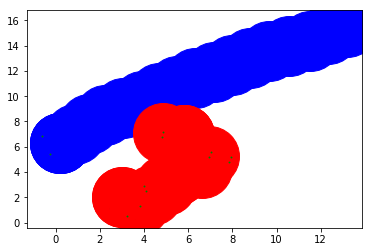

PREY :  0 :  [4.2, 15.4]
(4.4717825490924685, 14.437641311148074)
(5.172324621762486, 15.633633965669462)
PRED :  0 :  [12.263117405792109, 9.964763821237732]
(11.633043458452242, 10.741298959453356)
(11.300997036650424, 9.692138812695468)
PREY :  0 :  [3.4239163830128314, 14.76936998212572]
(3.6956989321052998, 13.807011293273794)
(4.396241004775317, 15.003003947795182)
PRED :  0 :  [12.48895374075544, 10.938929079194681]
(11.858879793415573, 11.715464217410306)
(11.526833371613755, 10.666304070652417)
PREY :  0 :  [2.6716709550207947, 14.110486975769449]
(2.943453504113263, 13.148128286917522)
(3.64399557678328, 14.344120941438911)
PRED :  0 :  [12.674987883218042, 11.921472359584]
(12.044913935878176, 12.698007497799624)
(11.712867514076358, 11.648847351041736)
PREY :  0 :  [1.9432436106125648, 13.425363918269284]
(2.215026159705033, 12.463005229417357)
(2.9155682323750503, 13.658997883938746)
PRED :  0 :  [12.818239244186337, 12.911158697562215]
(12.18816529684647, 13.6876938357778

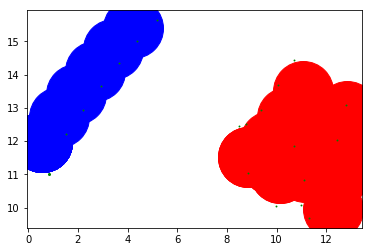

PREY :  0 :  [15.007722123286332, 3.875965265410792]
(14.182446020267447, 3.311235813561533)
(14.898274054448388, 2.8819727502339196)
PRED :  0 :  [8, 1]
(8.999682085690127, 0.9747863618206482)
(7.220966997718113, 1.6269829195087133)
PREY :  0 :  [14.015444246572663, 3.751930530821584]
(13.190168143553779, 3.187201078972325)
(13.90599617773472, 2.7579380156447115)
PRED :  0 :  [8, 1]
(8.271137733890193, 0.03745944019958758)
(8.36895378407763, 1.9294477420569685)
PREY :  0 :  [13.023166369858995, 3.6278957962323757]
(12.19789026684011, 3.063166344383117)
(12.913718301021051, 2.6339032810555034)
PRED :  0 :  [8, 1]
(7.0846199271415795, 1.4025907627029128)
(8.482925889034885, 1.8756612277015963)
PREY :  0 :  [12.027730002778483, 3.723323460426533]
(11.202453899759599, 3.1585940085772743)
(11.91828193394054, 2.729330945249661)
PRED :  0 :  [8.862904015659112, 0.49463215401118077]
(7.947523942800691, 0.8972229167140935)
(9.345829904693996, 1.3702933817127771)
PREY :  0 :  [11.02928371124681

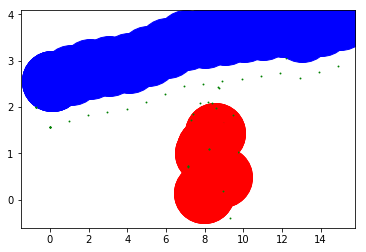

PREY :  0 :  [10.152001695994912, 19.47000105999682]
(10.170439725702073, 20.469831065077944)
(10.659664963372533, 18.608445486075162)
PRED :  0 :  [16.46234190961964, 10.88670173035202]
(16.055556179926683, 9.973178129059656)
(17.44791804052062, 11.055934381451783)
PREY :  0 :  [9.317894759268505, 18.918398287972522]
(9.336332788975666, 19.918228293053645)
(9.825558026646126, 18.056842714050862)
PRED :  0 :  [16.904187064730166, 11.783793062884753]
(16.49740133503721, 10.87026946159239)
(17.889763195631147, 11.953025713984516)
PREY :  0 :  [8.497544104312572, 18.346537463196622]
(8.515982134019733, 19.346367468277744)
(9.005207371690194, 17.484981889274962)
PRED :  0 :  [17.32446445062933, 12.691188742234047]
(16.917678720936372, 11.777665140941684)
(18.31004058153031, 12.86042139333381)
PREY :  0 :  [7.690841245108232, 17.75558019151656]
(7.709279274815392, 18.755410196597683)
(8.198504512485853, 16.8940246175949)
PRED :  0 :  [17.721930757964717, 13.608805511115898]
(17.315145028271

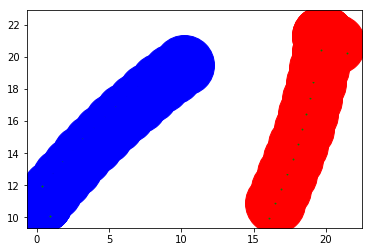

PREY :  0 :  [12.85857864376269, 11.010050506338834]
(13.203783229740067, 10.071523045994605)
(13.771444973103502, 10.601791930487899)
PRED :  0 :  [2.7595947517167922, 14.650396658328058]
(3.6698197376077633, 14.236282573733266)
(3.3793264348658827, 15.435210420249442)
PREY :  0 :  [12.67347075469131, 10.027332301865375]
(13.018675340668686, 9.088804841521146)
(13.586337084032122, 9.61907372601444)
PRED :  0 :  [3.5438161709898734, 15.27087773423071]
(4.4540411568808445, 14.85676364963592)
(4.163547854138964, 16.055691496152093)
PREY :  0 :  [12.447414226541593, 9.05321811652523]
(12.792618812518969, 8.114690656181)
(13.360280555882404, 8.644959540674295)
PRED :  0 :  [4.352535157521081, 15.859072940623907]
(5.262760143412052, 15.444958856029116)
(4.972266840670172, 16.64388670254529)
PREY :  0 :  [12.182750163334644, 8.088877443502057]
(12.52795474931202, 7.150349983157827)
(13.095616492675456, 7.680618867651122)
PRED :  0 :  [5.185624120980838, 16.412211963801216]
(6.095849106871809

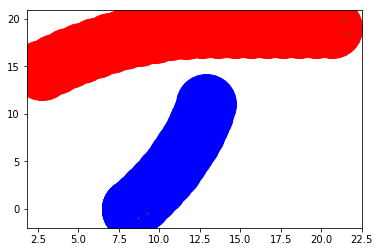

PREY :  0 :  [4.067995328458704, 11.637553738845051]
(3.4652953275902565, 10.839585876739582)
(4.735556221734967, 10.892998533525663)
PRED :  0 :  [18.329978352159195, 7.94398849945659]
(18.209639441200167, 6.9512556318083005)
(18.639495084904507, 6.993094503182206)
PREY :  0 :  [3.150457927416738, 11.239904247849331]
(2.547757926548291, 10.441936385743862)
(3.818018820693001, 10.495349042529943)
PRED :  0 :  [18.599869204584245, 8.906879421512292]
(18.479530293625217, 7.914146553864002)
(18.909385937329557, 7.955985425237908)
PREY :  0 :  [2.2485369004237477, 10.808003262590082]
(1.6458368995553005, 10.010035400484613)
(2.9160977937000108, 10.063448057270694)
PRED :  0 :  [18.80355167686644, 9.885916423103657]
(18.683212765907413, 8.893183555455368)
(19.113068409611753, 8.935022426829272)
PREY :  0 :  [1.363411377548955, 10.342650913551608]
(0.7607113766805079, 9.544683051446139)
(2.030972270825218, 9.59809570823222)
PRED :  0 :  [18.93424516796116, 10.87733924480259]
(18.813906257002

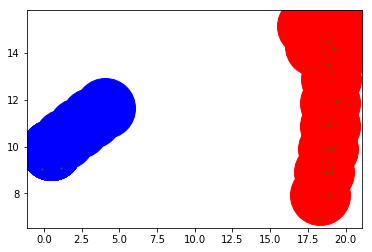

PREY :  0 :  [9.864791139398518, 13.502131740898555]
(10.464829931187017, 12.702160836209519)
(10.613866288595437, 12.839646706459579)
PRED :  0 :  [1.5899327211478536, 5.807452403872259]
(2.478187318678368, 6.2668038705792934)
(0.6231095689710817, 6.062899056649254)
PREY :  0 :  [10.79012874754744, 13.88127592316334]
(11.39016753933594, 13.081305018474303)
(11.53920389674436, 13.218790888724364)
PRED :  0 :  [2.2036458199342213, 6.59698152453725]
(3.0919004174647355, 7.056332991244284)
(1.2368226677574494, 6.852428177314245)
PREY :  0 :  [11.656910415046442, 14.379963742232194]
(12.25694920683494, 13.579992837543157)
(12.40598556424336, 13.717478707793218)
PRED :  0 :  [2.833365650393689, 7.373803856300504]
(3.721620247924203, 7.833155323007539)
(1.866542498216917, 7.629250509077499)
PREY :  0 :  [11.656910415046442, 14.379963742232194]
(10.657260212375627, 14.353516203590576)
(10.683145161677684, 14.152408844830095)
PRED :  0 :  [3.463085480853156, 8.15062618806376]
(4.35134007838367

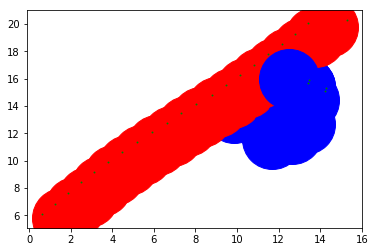

PREY :  0 :  [12.663663603001844, 4.058258088405163]
(13.502502442571801, 4.602637920166889)
(13.625007091334394, 4.333610040351398)
PRED :  0 :  [5.952295586011406, 14.305177189290406]
(6.942446337689594, 14.165171871708827)
(4.955516162172604, 14.385369334863304)
PREY :  0 :  [12.27949892824672, 3.134993498663798]
(13.118337767816678, 3.6793733304255243)
(13.240842416579271, 3.4103454506100332)
PRED :  0 :  [6.921217035988194, 14.552545788297795]
(7.911367787666382, 14.412540470716216)
(5.924437612149392, 14.632737933870693)
PREY :  0 :  [11.849998742972696, 2.2319267287903966]
(12.688837582542654, 2.776306560552123)
(12.811342231305247, 2.507278680736632)
PRED :  0 :  [7.9039378995438, 14.737639560025869]
(8.894088651221988, 14.59763424244429)
(6.907158475704998, 14.817831705598767)
PREY :  0 :  [11.37736972673766, 1.3506652392126997]
(12.216208566307618, 1.8950450709744262)
(12.33871321507021, 1.6260171911589352)
PRED :  0 :  [8.896964884139406, 14.855526827637597]
(9.8871156358175

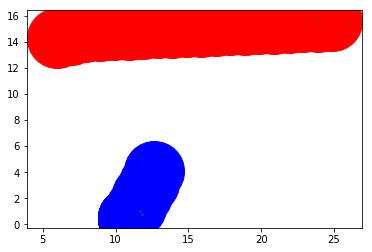

PREY :  0 :  [9.161556383699363, 2.455011649404586]
(8.167693782901758, 2.3443900839852776)
(8.821777407695047, 1.5145063344459422)
PRED :  0 :  [20.96592108129255, 13.258836753021342]
(21.668605431223245, 12.547335028243054)
(20.151554644545772, 13.839187773267154)
PREY :  0 :  [8.316380713107327, 1.9205230285347845]
(7.32251811230972, 1.809901463115476)
(7.976601737103009, 0.9800177135761408)
PRED :  0 :  [21.94027739885728, 13.483847344820264]
(22.642961748787975, 12.772345620041976)
(21.125910962110503, 14.064198365066076)
PREY :  0 :  [7.4644129568876725, 1.3969287749738348]
(6.470550356090066, 1.2863072095545263)
(7.124633980883355, 0.4564234600151911)
PRED :  0 :  [22.923212703721504, 13.6677989320694]
(23.6258970536522, 12.956297207291113)
(22.108846266974727, 14.248149952315213)
PREY :  0 :  [6.605499563331194, 0.8848079080202478]
(5.611636962533588, 0.7741863426009393)
(6.265720587326877, -0.05569740693839598)
PRED :  0 :  [23.914360327096006, 13.80056334250787]
(24.617044677

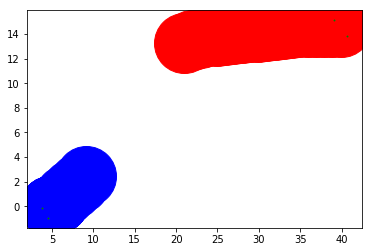

PREY :  0 :  [2.051316701949486, 10.683772233983163]
(2.074502875286981, 11.683503398529894)
(1.0513233595455365, 10.687421226690423)
PRED :  0 :  [6.188558864054476, 2.982061889488888]
(5.571781866105666, 2.194923950623499)
(5.262295571471263, 2.605184836840542)
PREY :  0 :  [1.150450802117217, 10.249674744334355]
(1.173636975454712, 11.249405908881085)
(0.15045745971326763, 10.253323737041615)
PRED :  0 :  [6.300101099853701, 3.9758215835965283]
(5.683324101904891, 3.1886836447311393)
(5.373837807270488, 3.5989445309481822)
PREY :  0 :  [0.30476864888882393, 9.715987855127782]
(0.3279548222263189, 10.715719019674513)
(-0.6952246935151255, 9.719636847835043)
PRED :  0 :  [6.331453426311049, 4.975329978571634]
(5.714676428362239, 4.188192039706244)
(5.405190133727836, 4.598452925923288)
PREY :  0 :  [0.30476864888882393, 9.715987855127782]
(0.3279548222263189, 10.715719019674513)
(-0.6952246935151255, 9.719636847835043)
PRED :  0 :  [6.362805752768398, 5.974838373546739]
(5.74602875481

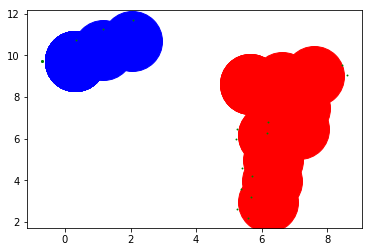

PREY :  0 :  [2.455011649404586, 5.161556383699363]
(1.4756678312567095, 4.959354292079273)
(3.444864200337766, 5.303654685628262)
PRED :  0 :  [12.713509569162486, 20.958083103409372]
(13.339678648726684, 20.178395804681397)
(12.847586437880048, 19.967112168782684)
PREY :  0 :  [1.936362653998376, 4.306569120891238]
(0.9570188358504996, 4.104367029271148)
(2.926215204931556, 4.448667422820137)
PRED :  0 :  [13.123593593491806, 21.8701308505092]
(13.749762673056004, 21.090443551781224)
(13.257670462209369, 20.87915991588251)
PREY :  0 :  [1.4218232211661985, 3.449102403134367]
(0.4424794030183221, 3.2469003115142776)
(2.4116757720993784, 3.591200705063266)
PRED :  0 :  [13.504711122357055, 22.79465744785059]
(14.130880201921252, 22.014970149122615)
(13.638787991074617, 21.8036865132239)
PREY :  0 :  [0.912111172659154, 2.5887573400307584]
(-0.06723264548872243, 2.386555248410669)
(1.901963723592334, 2.7308556419596575)
PRED :  0 :  [13.837023233509496, 23.737826924021974]
(14.463192313

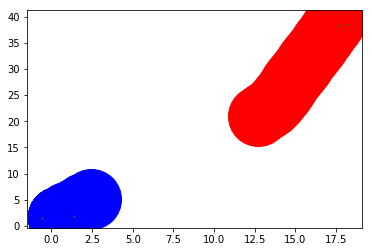

PREY :  0 :  [4.375304952445576, 13.21913119055697]
(5.375032798658348, 13.24246000335938)
(3.865423448105002, 12.35888654423164)
PRED :  0 :  [12.317973542143257, 15.94809958680345]
(12.026961297990546, 14.991380258184442)
(11.630265941993255, 15.22211180681268)
PREY :  0 :  [3.7640301603299995, 12.427712762338333]
(4.763758006542773, 12.451041575140742)
(3.254148655989426, 11.567468116013002)
PRED :  0 :  [12.317973542143257, 15.94809958680345]
(11.344210885313228, 16.175665595168766)
(11.548397487006845, 16.586654749150977)
PREY :  0 :  [3.1527553682144234, 11.636294334119695]
(4.152483214427196, 11.659623146922105)
(2.6428738638738496, 10.776049687794364)
PRED :  0 :  [12.317973542143257, 15.94809958680345]
(11.84685012607138, 15.066032283912811)
(11.50246581571385, 15.369353400523195)
PREY :  0 :  [2.5414805760988473, 10.844875905901057]
(3.5412084223116205, 10.868204718703467)
(2.031599071758274, 9.984631259575727)
PRED :  0 :  [12.977300847009541, 16.699955626918683]
(12.5061774

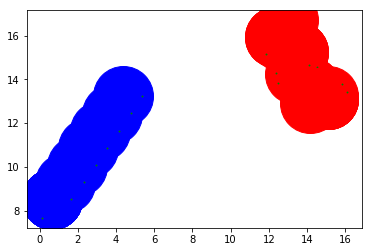

PREY :  0 :  [9.736882594207891, 4.0352361787622675]
(8.780434635392545, 3.743333280390295)
(10.444525310412283, 3.3286657391011736)
PRED :  0 :  [3.9238094984508765, 11.382852465803657]
(4.052301920488944, 10.391141975046)
(4.7299880146443, 10.79118009022054)
PREY :  0 :  [9.410989304205348, 3.089829618846737]
(8.454541345390002, 2.797926720474764)
(10.11863202040974, 2.383259179185643)
PRED :  0 :  [4.873911657843579, 11.694791380845245]
(5.0024040798816465, 10.70308089008759)
(5.6800901740370024, 11.103119005262128)
PREY :  0 :  [9.026301159491526, 2.166783015843055]
(8.06985320067618, 1.8748801174710825)
(9.733943875695918, 1.460212576181961)
PRED :  0 :  [5.846287450824138, 11.928212282277464]
(5.9747798728622055, 10.936501791519808)
(6.652465967017561, 11.336539906694346)
PREY :  0 :  [8.586197077416179, 1.2688362485229558]
(7.629749118600833, 0.9769333501509834)
(9.29383979362057, 0.5622658088618621)
PRED :  0 :  [6.835544177179409, 12.074400959543704]
(6.964036599217477, 11.082

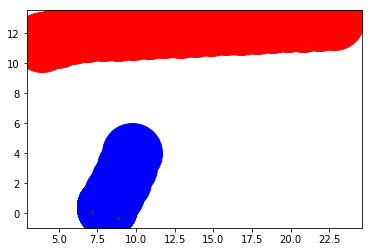

PREY :  0 :  [7.611942999941867, 1.0783646248619347]
(7.091016704279144, 1.9319662851737651)
(7.405400652364418, 0.09992696274073654)
PRED :  0 :  [8.990113729707224, 19.140266896469736]
(9.810161888981208, 18.56797237747506)
(8.84896868016463, 20.13025582317024)
PREY :  0 :  [7.186806979075137, 0.17323515138225443]
(6.665880683412414, 1.0268368116940847)
(6.980264631497688, -0.8052025107389438)
PRED :  0 :  [9.989823340227556, 19.16436450285057]
(10.80987149950154, 18.592069983855893)
(9.848678290684962, 20.154353429551076)
PREY :  0 :  [7.186806979075137, 0.17323515138225443]
(6.665880683412414, 1.0268368116940847)
(6.980264631497688, -0.8052025107389438)
PRED :  0 :  [10.989532950747888, 19.188462109231406]
(11.809581110021872, 18.616167590236728)
(10.848387901205294, 20.17845103593191)
PREY :  0 :  [7.186806979075137, 0.17323515138225443]
(6.665880683412414, 1.0268368116940847)
(6.980264631497688, -0.8052025107389438)
PRED :  0 :  [11.98924256126822, 19.21255971561224]
(12.80929072

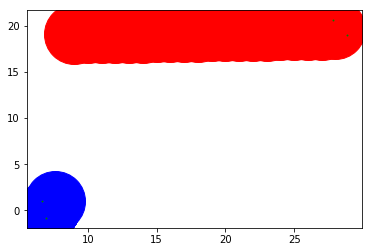

PREY :  0 :  [15.017127813065677, 8.815711464949814]
(14.064849374901739, 8.510480771525891)
(14.661215435574972, 7.881192134197949)
PRED :  0 :  [16.862382931478596, 3.506256535260911]
(16.65592061784414, 2.5278019818713804)
(16.64237660298364, 2.5307580906582716)
PREY :  0 :  [14.038069329294997, 8.612132278006124]
(13.085790891131058, 8.306901584582201)
(13.682156951804291, 7.677612947254259)
PRED :  0 :  [17.714763512346888, 4.029178465723416]
(17.50830119871243, 3.0507239123338854)
(17.49475718385193, 3.053680021120777)
PREY :  0 :  [13.062973313999958, 8.390349138530333]
(12.11069487583602, 8.08511844510641)
(12.707060936509253, 7.455829807778468)
PRED :  0 :  [18.556155115488902, 4.569604381240162]
(18.349692801854445, 3.5911498278506313)
(18.336148786993945, 3.594105936637523)
PREY :  0 :  [12.091981944918697, 8.151234602858205]
(11.139703506754758, 7.846003909434282)
(11.736069567427991, 7.21671527210634)
PRED :  0 :  [19.385348752512915, 5.128565839946296]
(19.178886438878457

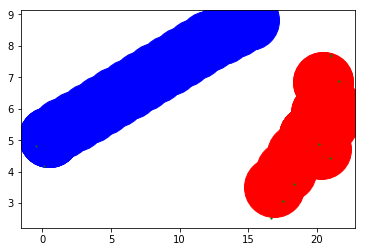

PREY :  0 :  [5.2151172344665735, 16.38035571142098]
(4.859704876235439, 15.445646101105249)
(4.5830773376932505, 17.15529155966054)
PRED :  0 :  [19.303371942341922, 15.952872218400604]
(20.281724656856962, 15.745927863558402)
(18.55386824408481, 15.290872062585732)
PREY :  0 :  [4.444285072544695, 15.743317425172151]
(4.088872714313561, 14.80860781485642)
(3.8122451757713725, 16.518253273411712)
PRED :  0 :  [19.57505079883762, 16.91526018535218]
(20.55340351335266, 16.70831583050998)
(18.825547100580508, 16.25326002953731)
PREY :  0 :  [3.687644401520105, 15.089486487580897]
(3.33223204328897, 14.154776877265167)
(3.055604504746782, 15.864422335820457)
PRED :  0 :  [19.81244941473066, 17.886672506239695]
(20.7908021292457, 17.679728151397494)
(19.06294571647355, 17.22467235042482)
PREY :  0 :  [2.9453844375312914, 14.419374447799992]
(2.5899720793001566, 13.484664837484262)
(2.313344540757968, 15.194310296039552)
PRED :  0 :  [20.01258260982093, 18.86644120558815]
(20.99093532433597

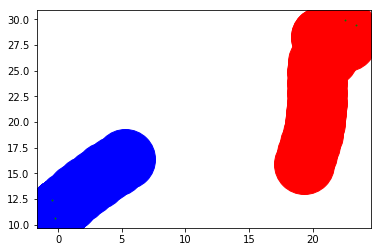

PREY :  0 :  [6.637553738845051, 1.067995328458704]
(5.876464267776727, 1.7166422409071789)
(6.642073022338266, 0.06800554047249263)
PRED :  0 :  [7.987301327441407, 18.15885870713447]
(8.872713778874628, 17.69405252080837)
(8.740684839362203, 17.501277317521073)
PREY :  0 :  [6.234924784143416, 0.1526320536678325]
(5.473835313075092, 0.8012789661163072)
(6.239444067636631, -0.8473577343183789)
PRED :  0 :  [8.987001822550836, 18.183331550818064]
(9.872414273984058, 17.718525364491963)
(9.740385334471632, 17.525750161204666)
PREY :  0 :  [6.234924784143416, 0.1526320536678325]
(5.473835313075092, 0.8012789661163072)
(6.239444067636631, -0.8473577343183789)
PRED :  0 :  [9.986702317660265, 18.207804394501657]
(10.872114769093487, 17.742998208175557)
(10.740085829581062, 17.55022300488826)
PREY :  0 :  [6.234924784143416, 0.1526320536678325]
(5.473835313075092, 0.8012789661163072)
(6.239444067636631, -0.8473577343183789)
PRED :  0 :  [10.986402812769695, 18.23227723818525]
(11.8718152642

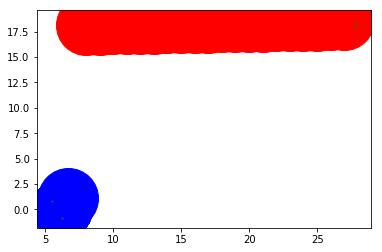

PREY :  0 :  [2.414509446155641, 1.1893207716001193]
(2.1102917557473826, 0.23671823284501758)
(2.911642514103182, 0.3216464589959799)
PRED :  0 :  [13.897076548479417, 18.44187517034594]
(13.61605983788137, 17.48217229530354)
(13.407415913231265, 17.569962065565207)
PREY :  0 :  [1.8126909200490586, 0.3906879012304477]
(1.5084732296408003, -0.561914637524654)
(2.3098239879965994, -0.4769864113736917)
PRED :  0 :  [14.874629219086296, 18.652566357132095]
(14.593612508488249, 17.69286348208969)
(14.384968583838145, 17.780653252351364)
PREY :  0 :  [1.8126909200490586, 0.3906879012304477]
(1.5084732296408003, -0.561914637524654)
(2.3098239879965994, -0.4769864113736917)
PRED :  0 :  [15.852181889693176, 18.863257543918248]
(15.571165179095129, 17.903554668875845)
(15.362521254445024, 17.991344439137514)
PREY :  0 :  [1.8126909200490586, 0.3906879012304477]
(1.5084732296408003, -0.561914637524654)
(2.3098239879965994, -0.4769864113736917)
PRED :  0 :  [16.829734560300054, 19.0739487307044

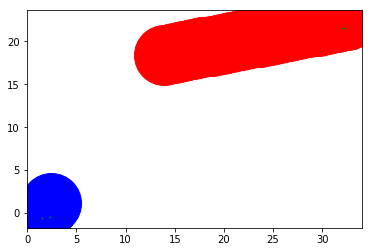

PREY :  0 :  [5.292893218813452, 10.292893218813452]
(4.30082427715391, 10.167198290536625)
(5.408714898444642, 9.299623195845172)
PRED :  0 :  [17, 17]
(17.581813006819715, 16.186677416337524)
(17.57400362881741, 17.81885275483718)
PREY :  0 :  [4.585786437626904, 9.585786437626904]
(3.593717495967362, 9.460091509350077)
(4.701608117258094, 8.592516414658624)
PRED :  0 :  [17, 17]
(16.08035089785167, 16.607258954376082)
(17.675810430316986, 17.737075479360676)
PREY :  0 :  [3.8786796564403563, 8.878679656440356]
(2.886610714780814, 8.75298472816353)
(3.9945013360715462, 7.885409633472075)
PRED :  0 :  [17, 17]
(16.360326002407497, 17.768646327516127)
(16.487349619238753, 17.858597453470104)
PREY :  0 :  [3.1715728752538084, 8.171572875253808]
(2.1795039335942663, 8.045877946976981)
(3.2873945548849983, 7.178302852285527)
PRED :  0 :  [17, 17]
(16.949820763831863, 17.99874022861682)
(16.074579950406918, 17.378942913657372)
PREY :  0 :  [2.4644660940672605, 7.4644660940672605]
(1.472397

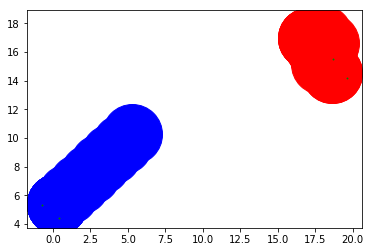

PREY :  0 :  [4.250162144634907, 17.338378362913154]
(5.224762010410064, 17.562331709909902)
(3.2933586875793206, 17.047642839513486)
PRED :  0 :  [17.238081628850182, 15.971245148252512]
(16.72241361716908, 15.114456666928877)
(17.512742247303738, 15.009703914258509)
PREY :  0 :  [3.516614887706611, 16.658739913549837]
(4.491214753481768, 16.882693260546585)
(2.5598114306510245, 16.36800439015017)
PRED :  0 :  [17.444627033701963, 16.949682164996368]
(16.928959022020862, 16.092893683672735)
(17.71928765215552, 15.988140931002365)
PREY :  0 :  [2.7994068750085743, 15.96188076958907]
(3.774006740783731, 16.18583411658582)
(1.8426034179529878, 15.671145246189404)
PRED :  0 :  [17.617371251098717, 17.934648882888897]
(17.101703239417617, 17.07786040156526)
(17.892031869552273, 16.973107648894896)
PREY :  0 :  [2.098638446827813, 15.248491948492843]
(3.07323831260297, 15.472445295489592)
(1.1418349897722266, 14.957756425093176)
PRED :  0 :  [17.753715253533482, 18.925310436094666]
(17.2380

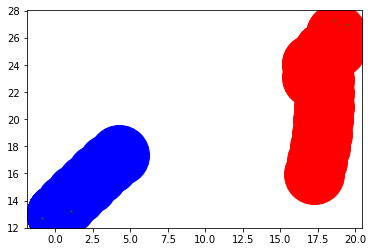

PREY :  0 :  [6.046845439802045, 10.998902149747288]
(5.9325565533635745, 10.005454591777239)
(6.112148758910873, 10.001036689620838)
PRED :  0 :  [2.481762717482141, 18.876301708342638]
(2.6487215781869593, 17.890337845499708)
(1.940646685012586, 18.035353767382908)
PREY :  0 :  [6.046845439802045, 10.998902149747288]
(5.253878992361512, 11.608167455860759)
(5.157664682180319, 11.45645824496978)
PRED :  0 :  [2.963525434964282, 19.752603416685275]
(3.1304842956691004, 18.766639553842346)
(2.4224094024947274, 18.911655475725546)
PREY :  0 :  [5.784934728167228, 10.033810040603843]
(4.991968280726695, 10.643075346717314)
(4.895753970545502, 10.491366135826334)
PRED :  0 :  [3.46300158702246, 20.618931053047614]
(3.6299604477272784, 19.632967190204685)
(2.9218855545529054, 19.777983112087885)
PREY :  0 :  [5.784934728167228, 10.033810040603843]
(4.813772961002525, 10.272231562278234)
(4.7867855903585, 10.094623679630732)
PRED :  0 :  [3.9624777390806383, 21.485258689409953]
(4.1294365997

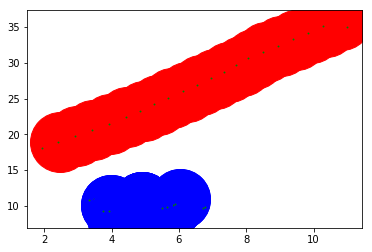

PREY :  0 :  [9.44529980377477, 3.1679497056621564]
(8.9891859643132, 4.057871143459688)
(9.543083795889277, 2.1727420434699134)
PRED :  0 :  [10.948093957339003, 15.317990326986955]
(11.922684425246116, 15.09399608629181)
(10.006341334970436, 14.981683921662986)
PREY :  0 :  [8.86382697884033, 2.3543838792763867]
(8.40771313937876, 3.2443053170739184)
(8.961610970954837, 1.3591762170841435)
PRED :  0 :  [11.914580982412469, 15.574705792755271]
(12.889171450319582, 15.350711552060126)
(10.972828360043902, 15.238399387431302)
PREY :  0 :  [8.256231696222219, 1.5601370835382995]
(7.80011785676065, 2.4500585213358312)
(8.354015688336727, 0.5649294213460563)
PRED :  0 :  [12.897191479295028, 15.760384578339973]
(13.871781947202141, 15.536390337644828)
(11.955438856926461, 15.424078173016005)
PREY :  0 :  [7.6229253337593885, 0.7862358939384269]
(7.16681149429782, 1.6761573317359586)
(7.720709325873895, -0.20897176825381636)
PRED :  0 :  [13.891914515075218, 15.862981274623246]
(14.86650498

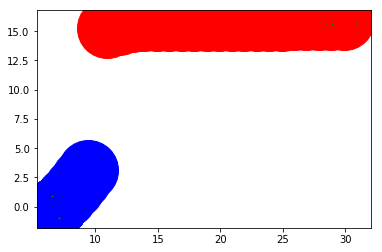

PREY :  0 :  [10, 8]
(9.109025125120397, 7.545947390346368)
(10.535637339715871, 8.844448127656225)
PRED :  0 :  [17.78086880944303, 20.624695047554425]
(17.514347471338965, 19.6608660293488)
(18.637015588860148, 20.107962338996412)
PREY :  0 :  [10, 8]
(10.79983837951321, 7.399784566461605)
(9.005994057524404, 8.109326055097592)
PRED :  0 :  [18.561737618886063, 21.24939009510885]
(18.295216280781997, 20.285561076903225)
(19.41788439830318, 20.732657386550837)
PREY :  0 :  [9.05683109196382, 7.66768627636849]
(9.85666947147703, 7.067470842830095)
(8.062825149488225, 7.77701233146608)
PRED :  0 :  [19.324948777944773, 21.89553924715369]
(19.058427439840706, 20.931710228948063)
(20.18109555736189, 21.378806538595676)
PREY :  0 :  [9.05683109196382, 7.66768627636849]
(8.66603740248904, 8.588164571749044)
(9.861856979749518, 8.260925958111754)
PRED :  0 :  [20.088159937003482, 22.541688399198527]
(19.821638598899415, 21.5778593809929)
(20.9443067164206, 22.024955690640514)
PREY :  0 :  [8

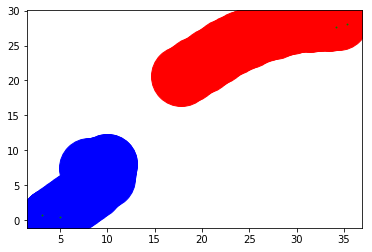

PREY :  0 :  [10.683772233983161, 1.0513167019494862]
(9.838520866257294, 0.5169477981409357)
(11.623609156933348, 0.7096932860958228)
PRED :  0 :  [3.995193291447898, 9.097930141718978]
(4.927823276005698, 8.737095952784896)
(3.2543472772819353, 9.769605050655143)
PREY :  0 :  [10.281699479933025, 0.13570898002347553]
(9.436448112207158, -0.398659923785075)
(11.221536402883212, -0.20591443583018787)
PRED :  0 :  [4.995106194963723, 9.111128072714072]
(5.927736179521524, 8.75029388377999)
(4.25426018079776, 9.782802981650237)
PREY :  0 :  [10.281699479933025, 0.13570898002347553]
(9.436448112207158, -0.398659923785075)
(11.221536402883212, -0.20591443583018787)
PRED :  0 :  [5.995019098479549, 9.124326003709166]
(6.92764908303735, 8.763491814775085)
(5.254173084313586, 9.796000912645331)
PREY :  0 :  [10.281699479933025, 0.13570898002347553]
(9.436448112207158, -0.398659923785075)
(11.221536402883212, -0.20591443583018787)
PRED :  0 :  [6.994932001995375, 9.13752393470426]
(7.927561986

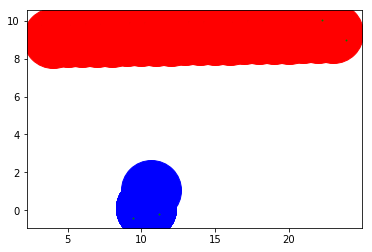

PREY :  0 :  [10.014455084083849, 5.830585659662986]
(9.05896808490115, 5.535552450696876)
(10.62547831543351, 5.0389729950655715)
PRED :  0 :  [11.864198497639224, 9.503151027702526]
(11.921428101005771, 8.504789984543034)
(10.870961688242282, 9.619257187999832)
PREY :  0 :  [10.014455084083849, 5.830585659662986]
(10.18427632985704, 6.8160605423890965)
(9.03192849723833, 5.644463371525069)
PRED :  0 :  [12.728396995278448, 10.006302055405051]
(12.785626598644996, 9.00794101224556)
(11.735160185881506, 10.122408215702357)
PREY :  0 :  [10.704563346213764, 5.106879513122811]
(10.874384591986955, 6.092354395848922)
(9.722036759368244, 4.920757224984895)
PRED :  0 :  [13.63094739429967, 10.436886283201002]
(13.688176997666217, 9.43852524004151)
(12.637710584902727, 10.552992443498308)
PREY :  0 :  [11.06341274511808, 6.040274986063413]
(11.233233990891272, 7.025749868789524)
(10.08088615827256, 5.854152697925497)
PRED :  0 :  [14.50865325942916, 10.916086047722326]
(14.565882862795707, 9

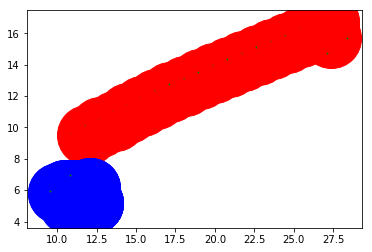

PREY :  0 :  [17.45549494742083, 6.109761631430046]
(17.185944962919294, 5.14677523180894)
(16.533449587153562, 6.496843474984614)
PRED :  0 :  [10.943852650854563, 7.33036672573795]
(11.122995632889072, 6.34654367661388)
(10.721180766222892, 6.355473279357999)
PREY :  0 :  [18.36414874213002, 5.692211297505391]
(18.094598757628482, 4.7292248978842855)
(17.44210338186275, 6.079293141059959)
PRED :  0 :  [11.89901990315559, 7.6264334751910186]
(12.0781628851901, 6.642610426066948)
(11.67634801852392, 6.651540028811067)
PREY :  0 :  [19.080885232024304, 4.994867190156645]
(18.811335247522766, 4.031880790535539)
(18.158839871757035, 5.381949033711213)
PRED :  0 :  [12.866423278181621, 7.87967389453249]
(13.04556626021613, 6.89585084540842)
(12.64375139354995, 6.904780448152539)
PREY :  0 :  [19.080885232024304, 4.994867190156645]
(18.99533615379614, 5.991201147830633)
(20.08012929996475, 4.955991842108974)
PRED :  0 :  [13.833826653207652, 8.132914313873961]
(14.012969635242161, 7.1490912

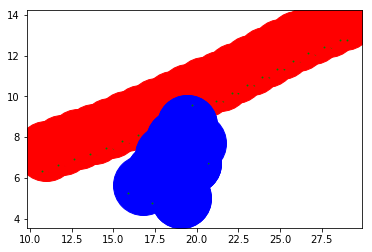

PREY :  0 :  [11, 18]
(11.612004851451028, 18.79085400789299)
(11.40982533869272, 18.912164015824676)
PRED :  0 :  [8.521450009453975, 18.85328183365196]
(8.649942431492041, 17.8615713428943)
(9.327628525647398, 18.26160945806884)
PREY :  0 :  [11.75405112240875, 18.65681573123221]
(12.366055973859778, 19.447669739125203)
(12.16387646110147, 19.568979747056886)
PRED :  0 :  [9.054496016102107, 19.699368090954653]
(9.182988438140173, 18.707657600196995)
(9.86067453229553, 19.107695715371534)
PREY :  0 :  [11.75405112240875, 18.65681573123221]
(11.510452892122965, 19.62669196158412)
(11.012901206748506, 17.985476172948317)
PRED :  0 :  [9.587542022750238, 20.545454348257348]
(9.716034444788304, 19.55374385749969)
(10.393720538943661, 19.95378197267423)
PREY :  0 :  [11.75405112240875, 18.65681573123221]
(12.031042238644291, 19.61768821055847)
(10.775870227433002, 18.449060739223736)
PRED :  0 :  [10.12058802939837, 21.391540605560042]
(10.249080451436436, 20.399830114802384)
(10.92676654

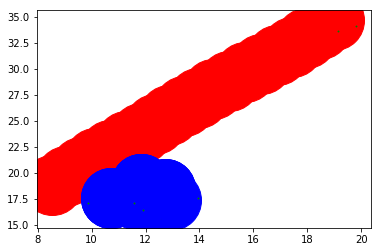

PREY :  0 :  [9.105572809000083, 16.552786404500043]
(8.584646513337361, 17.406388064811875)
(8.899030461422633, 15.574348742378845)
PRED :  0 :  [2.481981344565434, 1.8761814786280842]
(3.3020295038394174, 1.3038869596334048)
(2.3408362950228407, 2.8661704053285897)
PREY :  0 :  [8.307845671787897, 15.949767818919756]
(7.786919376125174, 16.803369479231588)
(8.101303324210447, 14.971330156798558)
PRED :  0 :  [2.9439452849763548, 2.763080186350683]
(3.763993444250338, 2.1907856673560033)
(2.8028002354337613, 3.7530691130511884)
PREY :  0 :  [7.578695577552109, 15.265414006863491]
(7.057769281889386, 16.119015667175322)
(7.37215322997466, 14.286976344742293)
PRED :  0 :  [2.9439452849763548, 2.763080186350683]
(2.2412051380594065, 3.4745268012917805)
(2.90332097251961, 3.7622546782375688)
PREY :  0 :  [6.849545483316321, 14.581060194807225]
(6.328619187653598, 15.434661855119057)
(6.643003135738872, 13.602622532686027)
PRED :  0 :  [3.9083344432003617, 2.498592849224703]
(3.20559429628

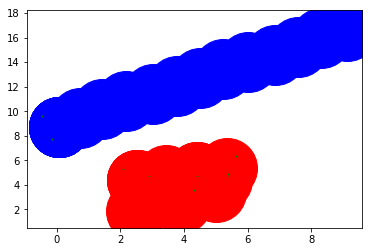

PREY :  0 :  [13.105572809000083, 11.552786404500042]
(12.153294370836145, 11.247555711076119)
(12.749660431509378, 10.618267073748177)
PRED :  0 :  [5.289883089195527, 2.2959162173508667]
(5.083420775561068, 1.317461663961336)
(5.069876760700569, 1.3204177727482274)
PREY :  0 :  [12.188247213725294, 11.154648548658937]
(11.235968775561355, 10.849417855235014)
(11.832334836234589, 10.220129217907072)
PRED :  0 :  [4.884827705511311, 3.210208367677245]
(4.678365391876852, 2.231753814287714)
(4.664821377016353, 2.2347099230746057)
PREY :  0 :  [11.352555767823937, 10.605449306810135]
(10.400277329659998, 10.300218613386212)
(10.996643390333231, 9.67092997605827)
PRED :  0 :  [4.884827705511311, 3.210208367677245]
(4.218066462708118, 3.9554797579073684)
(4.228461877002646, 3.9646511416277503)
PREY :  0 :  [11.76139673805411, 11.518054950591308]
(10.809118299890171, 11.212824257167386)
(11.405484360563404, 10.583535619839443)
PRED :  0 :  [3.8896774959073888, 3.308575335330364]
(3.22291625

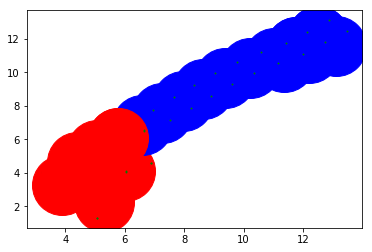

PREY :  0 :  [16.654294641172644, 8.06165688318289]
(16.29888228294151, 7.1269472728671595)
(16.02225474439932, 8.83659273142245)
PRED :  0 :  [7.900092975485085, 19.435697871790083]
(8.878445690000124, 19.228753516947883)
(7.150589277227974, 18.77369771597521)
PREY :  0 :  [16.277740011919086, 7.135262468698586]
(15.922327653687951, 6.2005528583828555)
(15.645700115145763, 7.910198316938146)
PRED :  0 :  [8.815965961172326, 19.837166020076268]
(9.794318675687364, 19.630221665234068)
(8.066462262915215, 19.175165864261395)
PREY :  0 :  [15.87162279046086, 6.221441478331736]
(15.516210432229725, 5.286731868016006)
(15.239582893687537, 6.996377326571297)
PRED :  0 :  [9.746993466104906, 20.202115037144424]
(10.725346180619944, 19.995170682302223)
(8.997489767847794, 19.54011488132955)
PREY :  0 :  [15.437081694146713, 5.32078947249702]
(15.081669335915578, 4.3860798621812895)
(14.80504179737339, 6.09572532073658)
PRED :  0 :  [10.692410644981903, 20.527977520232398]
(11.670763359496942, 

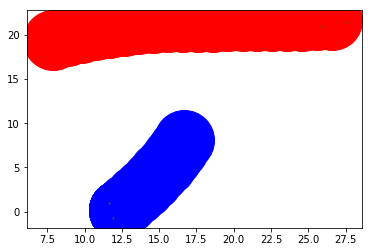

PREY :  0 :  [4, 20]
(4.448653757236915, 20.89370565966497)
(4.3850051130998775, 20.92291443963509)
PRED :  0 :  [1.196116135138184, 17.98058067569092]
(2.0815285865714053, 17.51577448936482)
(1.9494996470589805, 17.322999286077522)
PREY :  0 :  [3.727880887303475, 20.96226357538112]
(4.17653464454039, 21.85596923504609)
(4.112886000403353, 21.88517801501621)
PRED :  0 :  [1.3712066653253951, 18.96513301367949]
(2.2566191167586167, 18.50032682735339)
(2.1245901772461915, 18.307551624066093)
PREY :  0 :  [3.727880887303475, 20.96226357538112]
(4.260742651356001, 21.80846588004049)
(2.7388639449680214, 20.814461384012283)
PRED :  0 :  [1.5462971955126064, 19.949685351668062]
(2.431709646945828, 19.48487916534196)
(2.299680707433403, 19.292103962054664)
PREY :  0 :  [3.727880887303475, 20.96226357538112]
(4.7039466323900045, 21.179739232107746)
(3.2562872954742024, 21.84407959028761)
PRED :  0 :  [1.7213877256998176, 20.934237689656634]
(2.606800177133039, 20.469431503330533)
(2.474771237

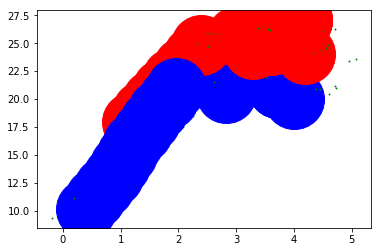

PREY :  0 :  [18.22806976438295, 4.364292747138901]
(17.923852073974693, 3.411690208383799)
(18.725202832330492, 3.4966184345347613)
PRED :  0 :  [17.972513607114017, 14.232846052098992]
(17.691496896515968, 13.273143177056589)
(17.482852971865867, 13.36093294731826)
PREY :  0 :  [17.444121727009467, 3.743466302229971]
(17.13990403660121, 2.7908637634748694)
(17.941254794957008, 2.8757919896258315)
PRED :  0 :  [18.95025350565207, 14.44266666788017]
(18.669236795054022, 13.482963792837767)
(18.46059287040392, 13.570753563099437)
PREY :  0 :  [16.64877859835494, 3.13730682840973]
(16.344560907946683, 2.1847042896546283)
(17.14591166630248, 2.2696325158055903)
PRED :  0 :  [19.932957850104284, 14.62784812320101]
(19.651941139506235, 13.668145248158607)
(19.443297214856134, 13.755935018420278)
PREY :  0 :  [15.842573193786828, 2.54567109111425]
(15.53835550337857, 1.5930685523591483)
(16.33970626173437, 1.6779967785101104)
PRED :  0 :  [20.920292680537422, 14.786498470233623]
(20.63927596

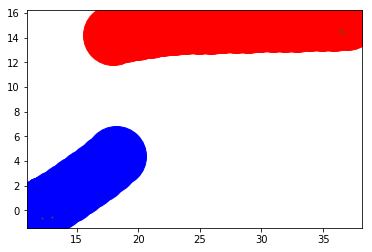

PREY :  0 :  [4, 5]
(4.500116227509738, 5.865958289400493)
(3.1390586550409427, 5.508704236801788)
PRED :  0 :  [5.624695047554424, 18.78086880944303]
(6.617639812484866, 18.66229101305083)
(5.406859721556119, 19.75685434762852)
PREY :  0 :  [4, 5]
(4.313433171095423, 5.9496102607159775)
(4.952680670368804, 5.3039729269287745)
PRED :  0 :  [6.249390095108849, 19.561737618886063]
(7.24233486003929, 19.44315982249386)
(6.031554769110543, 20.53772315707155)
PREY :  0 :  [4, 5]
(4.847634812500585, 5.530580083151541)
(3.477876662543289, 5.852869990375476)
PRED :  0 :  [6.874085142663273, 20.342606428329095]
(7.8670299075937145, 20.224028631936893)
(6.6562498166649675, 21.31859196651458)
PREY :  0 :  [4.49579807859278, 4.131562169603542]
(5.343432891093366, 4.662142252755084)
(3.973674741136069, 4.9844321599790185)
PRED :  0 :  [7.610389142107219, 21.01925731350021]
(8.60333390703766, 20.900679517108006)
(7.392553816108913, 21.995242851685695)
PREY :  0 :  [4.155358245103778, 3.1912958670200

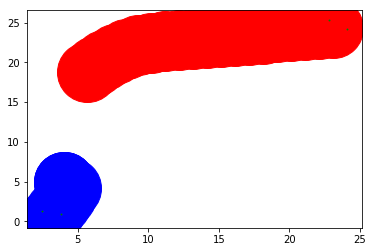

PREY :  0 :  [14.130412981365259, 16.5062202747966]
(15.105012847140415, 16.730173621793348)
(13.173609524309672, 16.215484751396932)
PRED :  0 :  [4.6503196423146, 15.759660689268445]
(4.1346516306335, 14.90287220794481)
(4.924980260768156, 14.798119455274442)
PREY :  0 :  [13.923843930896881, 15.527788249876835]
(14.898443796672037, 15.751741596873584)
(12.967040473841294, 15.237052726477168)
PRED :  0 :  [5.3179278815562725, 16.50417344194407]
(4.802259869875172, 15.647384960620434)
(5.592588500009828, 15.542632207950065)
PREY :  0 :  [13.923843930896881, 15.527788249876835]
(14.80110710004164, 15.047778529077252)
(13.01552094191902, 15.946057717677586)
PRED :  0 :  [5.985536120797946, 17.24868619461969]
(5.469868109116845, 16.391897713296053)
(6.260196739251501, 16.28714496062569)
PREY :  0 :  [13.923843930896881, 15.527788249876835]
(14.72026900101969, 16.13252547188312)
(13.17109103745941, 14.869485066365229)
PRED :  0 :  [6.653144360039619, 17.993198947295312]
(6.137476348358518

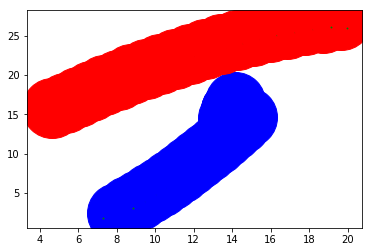

PREY :  0 :  [0.4452998037747704, 3.1679497056621564]
(0.33101091733630017, 2.174502147692107)
(0.5106031228835985, 2.170084245535707)
PRED :  0 :  [6.580857173818059, 8.185994506391943]
(6.747816034522877, 7.200030643549014)
(6.039741141348504, 7.345046565432214)
PREY :  0 :  [0.4452998037747704, 3.1679497056621564]
(0.33101091733630017, 2.174502147692107)
(0.5106031228835985, 2.170084245535707)
PRED :  0 :  [6.580857173818059, 8.185994506391943]
(7.580430990888146, 8.215186701032541)
(7.3390158108659715, 7.53392435597126)
PREY :  0 :  [0.4452998037747704, 3.1679497056621564]
(0.33101091733630017, 2.174502147692107)
(0.5106031228835985, 2.170084245535707)
PRED :  0 :  [6.580857173818059, 8.185994506391943]
(7.321149724212455, 7.513709641300841)
(6.674716147052963, 7.190409003713599)
PREY :  0 :  [0.4452998037747704, 3.1679497056621564]
(0.33101091733630017, 2.174502147692107)
(0.5106031228835985, 2.170084245535707)
PRED :  0 :  [6.580857173818059, 8.185994506391943]
(6.297643421261837

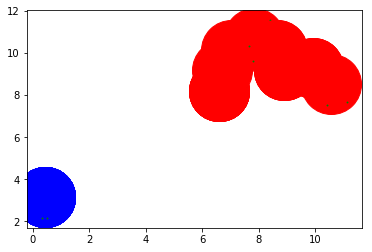

PREY :  0 :  [7.004962809790011, 3.9004962809790014]
(7.208129134815471, 4.879640521821814)
(7.247704301790514, 4.870587291174112)
PRED :  0 :  [10.873688256405156, 1.4864862080467627]
(11.430945069512735, 0.6561460101488253)
(10.061954113393016, 0.902459084474282)
PREY :  0 :  [6.014177959601452, 3.7650511605913146]
(6.217344284626912, 4.744195401434128)
(6.256919451601955, 4.735142170786425)
PRED :  0 :  [10.873688256405156, 1.4864862080467627]
(10.062429926956396, 2.0711740930760385)
(11.431620989836446, 2.316372383956381)
PREY :  0 :  [5.0233931094128925, 3.629606040203628]
(5.226559434438353, 4.608750281046441)
(5.266134601413396, 4.599697050398738)
PRED :  0 :  [10.873688256405156, 1.4864862080467627]
(10.853000978035197, 0.48670021268893426)
(9.873759225320763, 1.4745726529675376)
PREY :  0 :  [4.032608259224333, 3.494160919815941]
(4.235774584249794, 4.473305160658755)
(4.275349751224836, 4.464251930011051)
PRED :  0 :  [10.873688256405156, 1.4864862080467627]
(9.89399486736026

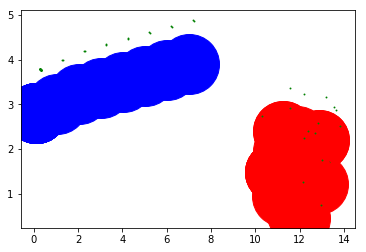

PREY :  0 :  [14.787891515007066, 12.02275387409619]
(14.299034032738383, 12.89511753796002)
(14.732869672104936, 11.024268723078084)
PRED :  0 :  [10.775919004703134, 18.630832543659963]
(10.717397998640084, 17.63254636632935)
(10.260298170154703, 17.774015670005166)
PREY :  0 :  [13.819188892133342, 12.270978023681936]
(13.330331409864659, 13.143341687545766)
(13.764167049231212, 11.272492872663829)
PRED :  0 :  [11.523670671618378, 19.294811040770732]
(11.465149665555328, 18.29652486344012)
(11.008049837069947, 18.437994167115935)
PREY :  0 :  [13.819188892133342, 12.270978023681936]
(14.181549942463466, 13.203015828281968)
(13.013623494302268, 11.67847115467765)
PRED :  0 :  [12.271422338533622, 19.9587895378815]
(12.212901332470572, 18.960503360550888)
(11.755801503985191, 19.101972664226704)
PREY :  0 :  [14.053604620761265, 11.298841579466496]
(14.415965671091389, 12.230879384066528)
(13.24803922293019, 10.70633471046221)
PRED :  0 :  [13.050775106783137, 20.58537493718619]
(12.

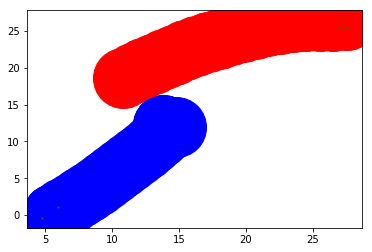

PREY :  0 :  [10.485504244572473, 0.1425070742874559]
(9.508891585642697, -0.0724992382201341)
(10.414219774843625, -0.8549489519991553)
PRED :  0 :  [9.99990765698457, 15.013589610135178]
(10.954907647856515, 14.716983781745743)
(9.14035068286314, 14.502549681911157)
PREY :  0 :  [10.485504244572473, 0.1425070742874559]
(9.508891585642697, -0.0724992382201341)
(10.414219774843625, -0.8549489519991553)
PRED :  0 :  [10.99981531396914, 15.027179220270355]
(11.954815304841086, 14.73057339188092)
(10.14025833984771, 14.516139292046335)
PREY :  0 :  [10.485504244572473, 0.1425070742874559]
(9.508891585642697, -0.0724992382201341)
(10.414219774843625, -0.8549489519991553)
PRED :  0 :  [11.99972297095371, 15.040768830405533]
(12.954722961825656, 14.744163002016098)
(11.14016599683228, 14.529728902181512)
PREY :  0 :  [10.485504244572473, 0.1425070742874559]
(9.508891585642697, -0.0724992382201341)
(10.414219774843625, -0.8549489519991553)
PRED :  0 :  [12.99963062793828, 15.05435844054071]
(

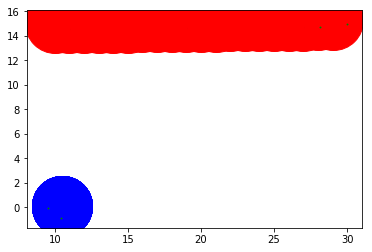

PREY :  0 :  [17.683772233983163, 0.05131670194948623]
(18.37404777628225, -0.6722298934427526)
(18.682460030706977, 0.00010454836330874018)
PRED :  0 :  [5.99999578948799, 15.00290189701614]
(6.550979671393761, 14.16838601227814)
(5.010642474203652, 15.148435458560858)
PREY :  0 :  [17.683772233983163, 0.05131670194948623]
(18.37404777628225, -0.6722298934427526)
(18.682460030706977, 0.00010454836330874018)
PRED :  0 :  [6.99999157897598, 15.005803794032278]
(7.550975460881751, 14.171287909294279)
(6.010638263691642, 15.151337355576997)
PREY :  0 :  [17.683772233983163, 0.05131670194948623]
(18.37404777628225, -0.6722298934427526)
(18.682460030706977, 0.00010454836330874018)
PRED :  0 :  [7.9999873684639695, 15.008705691048418]
(8.550971250369741, 14.174189806310418)
(7.010634053179632, 15.154239252593136)
PREY :  0 :  [17.683772233983163, 0.05131670194948623]
(18.37404777628225, -0.6722298934427526)
(18.682460030706977, 0.00010454836330874018)
PRED :  0 :  [8.99998315795196, 15.01160

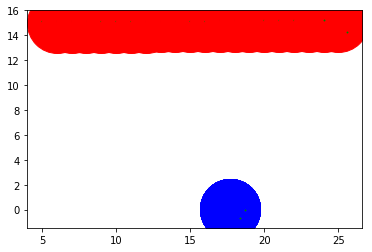

PREY :  0 :  [11, 20]
(11.019609331122638, 19.00019228141961)
(11.999930722529788, 20.011770732392577)
PRED :  0 :  [4.481918749772156, 17.87621590867665]
(5.301966909046139, 17.30392138968197)
(4.340773700229563, 18.866204835377154)
PREY :  0 :  [11.972452484581785, 20.23310119096803]
(11.992061815704423, 19.23329347238764)
(12.972383207111573, 20.244871923360606)
PRED :  0 :  [4.991169077452211, 18.736834351285076]
(5.811217236726194, 18.164539832290398)
(4.850024027909618, 19.72682327798558)
PREY :  0 :  [12.921158157966369, 20.549261823064917]
(12.940767489089007, 19.54945410448453)
(13.921088880496157, 20.561032555457494)
PRED :  0 :  [5.523472886400217, 19.58338774887996]
(6.3435210456742, 19.011093229885283)
(5.382327836857624, 20.573376675580466)
PREY :  0 :  [12.921158157966369, 20.549261823064917]
(13.525115714739814, 21.346278303205857)
(12.128900897051057, 21.159449034113273)
PRED :  0 :  [6.055776695348223, 20.429941146474846]
(6.8758248546222065, 19.857646627480168)
(5.91

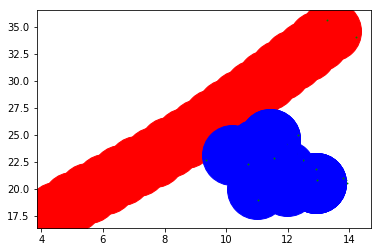

PREY :  0 :  [3, 3]
(2.393782897832979, 3.7952992047275163)
(2.0479731754018324, 2.6939854166129815)
PRED :  0 :  [12.7936451975116, 15.608380884369959]
(13.218293360378587, 14.70302242620342)
(13.122425282209047, 16.552787394251343)
PREY :  0 :  [2.8574645449267595, 3.989789696878617]
(2.2512474427597384, 4.785088901606133)
(1.9054377203285922, 3.6837751134915986)
PRED :  0 :  [13.337636225515352, 16.44747191724507]
(13.762284388382339, 15.542113459078532)
(13.6664163102128, 17.391878427126457)
PREY :  0 :  [2.2276099285747306, 3.2130766467371643]
(1.6213928264077095, 4.00837585146468)
(1.2755831039765633, 2.907062063350146)
PRED :  0 :  [12.908690781702482, 15.544141520196362]
(13.33333894456947, 14.638783062029823)
(13.23747086639993, 16.488548030077748)
PREY :  0 :  [1.5887338361257113, 2.443766996143158]
(0.9825167339586902, 3.239066200870674)
(0.6367070115275439, 2.1377524127561394)
PRED :  0 :  [12.908690781702482, 15.544141520196362]
(13.888483877198109, 15.744155244773198)
(13

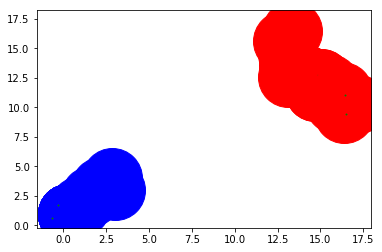

PREY :  0 :  [14.2, 12.4]
(13.469558701817654, 11.717024517343638)
(13.458282960389356, 11.729287070982508)
PRED :  0 :  [15.003957679807245, 11.911119763810891]
(15.982310394322283, 11.70417540896869)
(14.254453981550133, 11.24911960799602)
PREY :  0 :  [13.41679286998119, 11.778239120330252]
(12.686351571798845, 11.09526363767389)
(12.675075830370547, 11.10752619131276)
PRED :  0 :  [15.003957679807245, 11.911119763810891]
(15.79389285019681, 11.297929396484717)
(14.040679703159295, 11.64261363780064)
PREY :  0 :  [12.633585739962381, 11.156478240660503]
(11.903144441780036, 10.473502758004141)
(11.891868700351738, 10.48576531164301)
PRED :  0 :  [15.003957679807245, 11.911119763810891]
(15.59350386779817, 11.103385096840746)
(14.003992662037444, 11.919484166756774)
PREY :  0 :  [11.850378609943572, 10.534717360990754]
(11.119937311761227, 9.851741878334392)
(11.108661570332929, 9.864004431973262)
PRED :  0 :  [15.003957679807245, 11.911119763810891]
(14.291166831953332, 12.612496415

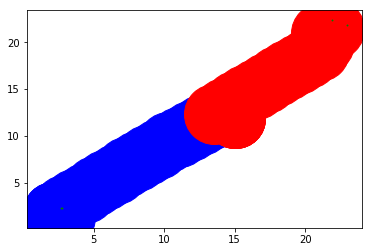

PREY :  0 :  [12.292893218813452, 18.292893218813454]
(11.581239880815454, 17.590362417697726)
(12.900642992148693, 17.498764631611756)
PRED :  0 :  [8, 8]
(8.450274981986889, 7.107110062439548)
(7.602069819302797, 7.082584297447285)
PREY :  0 :  [11.585786437626904, 17.585786437626908]
(10.874133099628907, 16.88325563651118)
(12.193536210962145, 16.79165785042521)
PRED :  0 :  [8, 8]
(7.774904438291259, 8.974336691343925)
(8.604622441867464, 8.79651221132524)
PREY :  0 :  [10.878679656440356, 16.87867965644036]
(10.167026318442359, 16.176148855324634)
(11.486429429775598, 16.084551069238664)
PRED :  0 :  [8.923037650214832, 8.384709625933484]
(8.69794208850609, 9.359046317277409)
(9.527660092082296, 9.181221837258724)
PREY :  0 :  [10.14993193777848, 16.193897382615237]
(9.438278599780482, 15.49136658149951)
(10.75768171111372, 15.399768795413541)
PRED :  0 :  [9.863308129328667, 8.04428132789256]
(9.638212567619926, 9.018618019236484)
(10.467930571196131, 8.840793539217799)
PREY :  0

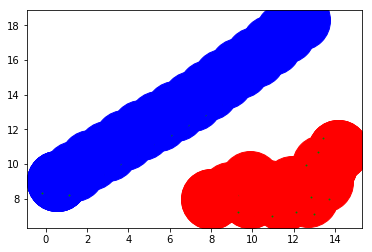

PREY :  0 :  [18.79398951895016, 19.02145021501325]
(17.838020758678752, 18.7279817680123)
(19.454692186808543, 18.27080250490896)
PRED :  0 :  [4.702840804004682, 19.711347175594344]
(5.6436002469467095, 19.372272448557066)
(4.705780976142848, 18.711351497909785)
PREY :  0 :  [18.561917761177025, 18.048751546748463]
(17.605949000905618, 17.755283099747512)
(19.22262042903541, 17.298103836644174)
PRED :  0 :  [5.419788567356227, 20.408474068365823]
(6.360548010298255, 20.069399341328545)
(5.422728739494394, 19.408478390681264)
PREY :  0 :  [18.305248780243492, 17.08225217570545]
(17.349280019972085, 16.788783728704498)
(18.965951448101876, 16.33160446560116)
PRED :  0 :  [6.150896561925366, 21.090735821857173]
(7.091656004867394, 20.751661094819895)
(6.153836734063533, 20.090740144172614)
PREY :  0 :  [18.02527260976793, 16.122245225748397]
(17.069303849496524, 15.828776778747448)
(18.685975277626316, 15.371597515644108)
PRED :  0 :  [6.8962535555225735, 21.757401369261366]
(7.83701299

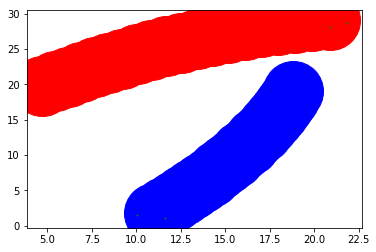

PREY :  0 :  [8, 9]
(7.498209586341589, 8.13501076263313)
(8.859955689546457, 8.489631297965207)
PRED :  0 :  [4.66436383882992, 15.74740931868366]
(4.269624096894388, 14.828616340838995)
(5.2719368787558984, 14.953145507878267)
PREY :  0 :  [8.059554128837425, 8.001774922305387]
(7.557763715179013, 7.136785684938516)
(8.919509818383881, 7.491406220270594)
PRED :  0 :  [5.374009782057669, 16.45196778698874]
(4.979270040122137, 15.533174809144073)
(5.981582821983648, 15.657703976183345)
PREY :  0 :  [8.059554128837425, 8.001774922305387]
(9.050315746460466, 8.13738988108566)
(8.20501640887003, 8.991138720454337)
PRED :  0 :  [6.0836557252854195, 17.156526255293816]
(5.6889159833498875, 16.23773327744915)
(6.691228765211398, 16.362262444488422)
PREY :  0 :  [8.059554128837425, 8.001774922305387]
(8.289201095797546, 8.975048917933554)
(9.035064033356443, 8.221730431864241)
PRED :  0 :  [6.79330166851317, 17.861084723598893]
(6.398561926577638, 16.942291745754225)
(7.400874708439148, 17.06

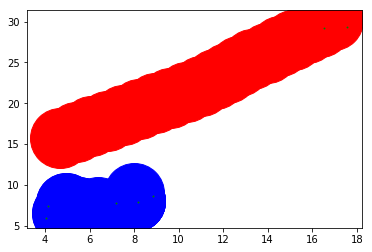

PREY :  0 :  [14.06165688318289, 9.654294641172644]
(14.26482320820835, 10.633438882015458)
(14.304398375183393, 10.624385651367755)
PRED :  0 :  [19.93578203820489, 7.352579036491252]
(20.49303885131247, 6.5222388385933145)
(19.12404789519275, 6.768551912918771)
PREY :  0 :  [13.123433164458667, 9.308265374168693]
(13.326599489484128, 10.287409615011507)
(13.36617465645917, 10.278356384363803)
PRED :  0 :  [19.790366020969074, 8.34194963537282]
(20.347622834076653, 7.511609437474883)
(18.978631877956932, 7.75792251180034)
PREY :  0 :  [12.20195046614863, 8.919845965905855]
(12.405116791174091, 9.89899020674867)
(12.444691958149134, 9.889936976100966)
PRED :  0 :  [19.790366020969074, 8.34194963537282]
(18.790984938397777, 8.30677220228538)
(19.72263064077968, 9.339652957142674)
PREY :  0 :  [11.280467767838594, 8.531426557643018]
(11.483634092864055, 9.510570798485832)
(11.523209259839097, 9.501517567838128)
PRED :  0 :  [19.790366020969074, 8.34194963537282]
(19.942689694124677, 7.35

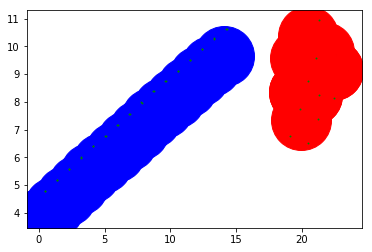

PREY :  0 :  [1.247423305293122, 7.341495392131482]
(0.7585658230244384, 8.21385905599531)
(1.1924014623909922, 6.343010241113374)
PRED :  0 :  [7.062377754544946, 7.347655756212698]
(7.003856748481897, 6.349369578882085)
(6.546756919996516, 6.4908388825579015)
PREY :  0 :  [0.5544510274875505, 6.620531161262185]
(0.06559354521886684, 7.4928948251260135)
(0.4994291845854207, 5.622046010244077)
PRED :  0 :  [7.062377754544946, 7.347655756212698]
(7.805907976007615, 6.678953423502788)
(7.4101149295589375, 6.410063703604909)
PREY :  0 :  [0.5544510274875505, 6.620531161262185]
(0.06559354521886684, 7.4928948251260135)
(0.4994291845854207, 5.622046010244077)
PRED :  0 :  [6.066853450836268, 7.253149879541715]
(6.810383672298936, 6.584447546831805)
(6.414590625850259, 6.315557826933925)
PREY :  0 :  [0.5544510274875505, 6.620531161262185]
(0.06559354521886684, 7.4928948251260135)
(0.4994291845854207, 5.622046010244077)
PRED :  0 :  [6.978488705318052, 6.842149681505348]
(7.722018926780721, 

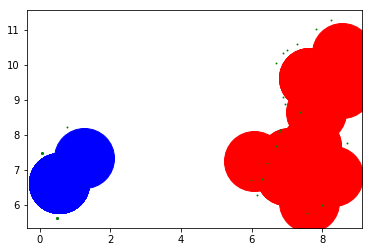

PREY :  0 :  [3.5527864045000417, 1.1055728090000843]
(2.576173745570265, 0.8905664964924942)
(3.481501934771193, 0.10811678271347303)
PRED :  0 :  [7.954836840120284, 14.297130625734056]
(8.90983683099223, 14.000524797344621)
(7.095279865998854, 13.786090697510035)
PREY :  0 :  [3.066583741416946, 0.2317267296411929]
(2.0899710824871693, 0.016720417133602894)
(2.9952992716880975, -0.7657292966454183)
PRED :  0 :  [8.951993966407395, 14.372480911034321]
(9.90699395727934, 14.075875082644886)
(8.092436992285965, 13.8614409828103)
PREY :  0 :  [3.066583741416946, 0.2317267296411929]
(2.0899710824871693, 0.016720417133602894)
(2.9952992716880975, -0.7657292966454183)
PRED :  0 :  [9.949151092694505, 14.447831196334587]
(10.90415108356645, 14.151225367945152)
(9.089594118573075, 13.936791268110566)
PREY :  0 :  [3.066583741416946, 0.2317267296411929]
(2.0899710824871693, 0.016720417133602894)
(2.9952992716880975, -0.7657292966454183)
PRED :  0 :  [10.946308218981615, 14.523181481634852]
(1

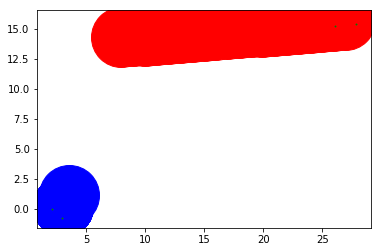

PREY :  0 :  [15.22640347079349, 10.025966392565092]
(15.916679013092578, 9.302419797172853)
(16.225091267517303, 9.974754238978914)
PRED :  0 :  [16.835200527760552, 13.549945523146153]
(17.386184409666324, 12.715429638408153)
(15.845847212476215, 13.695479084690872)
PREY :  0 :  [15.255512008126034, 11.0255426493131]
(15.945787550425122, 10.301996053920861)
(16.254199804849847, 10.974330495726923)
PRED :  0 :  [17.645686227874744, 14.135703945971132]
(18.196670109780516, 13.301188061233132)
(16.656332912590408, 14.28123750751585)
PREY :  0 :  [14.991686500231992, 11.990113072550539]
(15.68196204253108, 11.2665664771583)
(15.990374296955807, 11.938900918964361)
PRED :  0 :  [18.42663726335531, 14.76029619710929]
(18.977621145261082, 13.92578031237129)
(17.437283948070974, 14.905829758654008)
PREY :  0 :  [14.211210130135528, 11.364927791436973]
(14.901485672434616, 10.641381196044733)
(15.209897926859343, 11.313715637850795)
PRED :  0 :  [19.20761437101205, 15.384855847836196]
(19.758

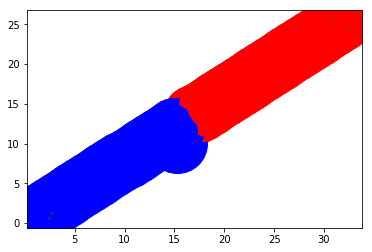

PREY :  0 :  [11.092040615499549, 6.580941822538253]
(10.186002851038195, 6.157744977831358)
(11.508121569369417, 5.671614246894173)
PRED :  0 :  [13.660723364866968, 6.750629492571982]
(14.480771524140952, 6.178334973577303)
(13.519578315324374, 7.740618419272488)
PREY :  0 :  [10.195530190848096, 6.137919183736045]
(9.289492426386742, 5.71472233902915)
(10.611611144717964, 5.228591608091965)
PRED :  0 :  [14.517451623709187, 7.2663975513941415]
(15.337499782983171, 6.694103032399462)
(14.376306574166593, 8.256386478094647)
PREY :  0 :  [9.301292103598346, 5.690327580472637]
(8.395254339136992, 5.2671307357657415)
(9.717373057468214, 4.781000004828557)
PRED :  0 :  [15.370480169881109, 7.788261805214824]
(16.190528329155093, 7.2159672862201445)
(15.229335120338515, 8.77825073191533)
PREY :  0 :  [8.409269240077991, 5.238337302969962]
(7.503231475616637, 4.815140458263066)
(8.825350193947859, 4.329009727325881)
PRED :  0 :  [16.219269400539396, 8.316993156581955]
(17.03931755981338, 7.

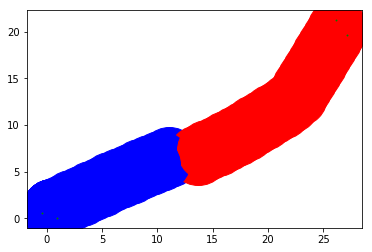

PREY :  0 :  [0.003454241755120324, 7.91695452014626]
(-0.9269705965002846, 7.550471750623048)
(0.03838169729864132, 6.917564669862971)
PRED :  0 :  [12.0004363093684, 1.999999904817063]
(12.425084472235387, 1.0946414466505239)
(12.329216394065847, 2.9444064146984488)
PREY :  0 :  [0.003454241755120324, 7.91695452014626]
(-0.9269705965002846, 7.550471750623048)
(0.03838169729864132, 6.917564669862971)
PRED :  0 :  [12.0008726187368, 2.999999809634126]
(12.425520781603787, 2.094641351467587)
(12.329652703434247, 3.9444063195155117)
PREY :  0 :  [0.003454241755120324, 7.91695452014626]
(-0.9269705965002846, 7.550471750623048)
(0.03838169729864132, 6.917564669862971)
PRED :  0 :  [12.0013089281052, 3.9999997144511887]
(12.425957090972187, 3.0946412562846497)
(12.330089012802647, 4.944406224332575)
PREY :  0 :  [0.003454241755120324, 7.91695452014626]
(-0.9269705965002846, 7.550471750623048)
(0.03838169729864132, 6.917564669862971)
PRED :  0 :  [12.0017452374736, 4.999999619268252]
(12.426

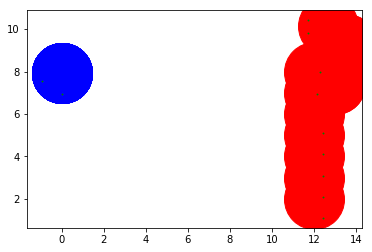

PREY :  0 :  [17.324275371482653, 3.262845859799259]
(16.593834073300307, 2.579870377142897)
(16.58255833187201, 2.592132930781766)
PRED :  0 :  [11.982722425527259, 12.185085478538493]
(12.961075140042297, 11.978141123696291)
(11.233218727270147, 11.523085322723622)
PREY :  0 :  [16.623113950082267, 2.549843292384674]
(15.892672651899922, 1.866867809728312)
(15.881396910471624, 1.8791303633671812)
PRED :  0 :  [12.971161574935756, 12.336703577446922]
(13.949514289450795, 12.12975922260472)
(12.221657876678645, 11.674703421632051)
PREY :  0 :  [15.89850795251118, 1.8606799240285135]
(15.168066654328834, 1.1777044413721516)
(15.156790912900536, 1.1899669950110208)
PRED :  0 :  [13.964382554764802, 12.452945072737675]
(14.94273526927984, 12.246000717895473)
(13.21487885650769, 11.790944916922804)
PREY :  0 :  [15.152165408402825, 1.1951179007325121]
(14.42172411022048, 0.5121424180761502)
(14.410448368792181, 0.5244049717150193)
PRED :  0 :  [14.961286408335846, 12.531575262456384]
(15.9

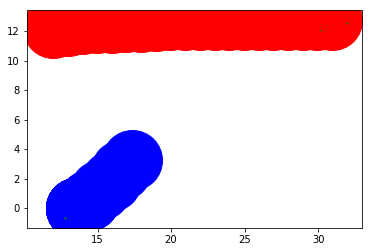

PREY :  0 :  [14, 10]
(14.449267452553007, 10.893397311433457)
(13.169988930220356, 10.55774691755603)
PRED :  0 :  [13.813733471206735, 18.581238193719095]
(14.204578188390268, 17.66078156407828)
(13.356587342307726, 17.69184659446)
PREY :  0 :  [14, 10]
(13.053642302242002, 9.676879112569024)
(14.20190426935774, 9.020594738621893)
PRED :  0 :  [14.62746694241347, 19.16247638743819]
(15.018311659597003, 18.242019757797376)
(14.170320813514461, 18.273084788179094)
PREY :  0 :  [14.00436291353409, 9.000009517552545]
(13.058005215776092, 8.676888630121569)
(14.20626718289183, 8.020604256174439)
PRED :  0 :  [15.468721787673376, 19.70311516270938]
(15.85956650485691, 18.782658533068567)
(15.011575658774367, 18.813723563450285)
PREY :  0 :  [13.386844936952258, 8.213452749990102]
(12.44048723919426, 7.890331862559127)
(13.588749206309998, 7.234047488611996)
PRED :  0 :  [16.321078633973126, 20.226075779358418]
(16.71192335115666, 19.305619149717604)
(15.863932505074118, 19.336684180099322)

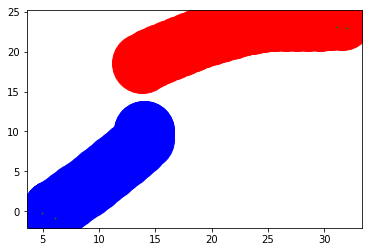

PREY :  0 :  [12.105572809000083, 14.552786404500042]
(11.149604048728676, 14.259317957499093)
(12.766275476858468, 13.802138694395753)
PRED :  0 :  [10.63950607927331, 5.768786039527565]
(11.580265522215338, 5.429711312490286)
(10.642446251411476, 4.768790361843007)
PREY :  0 :  [11.226478855356532, 14.076137875007554]
(10.270510095085125, 13.782669428006605)
(11.887181523214917, 13.325490164903265)
PRED :  0 :  [11.263034362006337, 6.550586832973058]
(12.203793804948365, 6.211512105935779)
(11.265974534144503, 5.5505911552885)
PREY :  0 :  [10.362048749821625, 13.573384861446314]
(9.406079989550218, 13.279916414445365)
(11.02275141768001, 12.822737151342025)
PRED :  0 :  [11.869833975228271, 7.345441680975956]
(12.8105934181703, 7.006366953938677)
(11.872774147366437, 6.345446003291398)
PREY :  0 :  [9.511701831478817, 13.047162362435783]
(8.55573307120741, 12.753693915434834)
(10.172404499337201, 12.296514652331494)
PRED :  0 :  [11.869833975228271, 7.345441680975956]
(11.8861542771

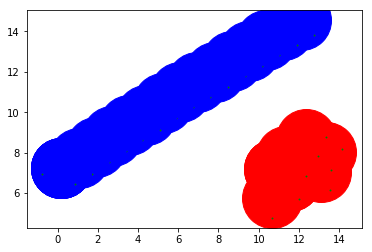

In [103]:
# So we are going to have a predator population that will one on one with a prey population at random
# The eye_placement for 1 and 2 will be random initally, but will undergo both breeding and mutation
init_pop = 100
prey_population = [Evolve.random_eye_pair() for item in range(init_pop)]
pred_population = [Evolve.random_eye_pair() for item in range(init_pop)]
# print(prey_population)
while(init_pop > 10):
    # Select 50% of the population
    results = [(eye_pair_pair[0], eye_pair_pair[1], simulation_control(Grid, Animal, eye_pair_pair[0], eye_pair_pair[1]).start_sim())  for eye_pair_pair in zip(prey_population, pred_population)]    
    prey_population = [result[0] for result in sorted(results, key=lambda result: result[2][0])[:int(init_pop*.5)]]
    pred_population = [result[1] for result in sorted(results, key=lambda result: result[2][1])[:int(init_pop*.5)]]

    #  Then select 10% randomly
    raw_prey = [result[0] for result in results]
    raw_pred = [result[1] for result in results]
    random.shuffle(raw_prey)
    random.shuffle(raw_pred)
    prey_population += raw_prey[:10]
    pred_population += raw_pred[:10]
    if(len(prey_population) % 2 != 0):
        prey_population.pop()
    if(len(pred_population) % 2 != 0):
        pred_population.pop()
    half_index = int(len(prey_population)/2)
    prey_pairs = zip(prey_population[:half_index], prey_population[half_index:])
    pred_pairs = zip(pred_population[:half_index], pred_population[half_index:])

    init_pop = init_pop * .6
    if(init_pop <= 10):
        break
    # Eyes mix
    child_eye_preys = [Evolve.breed_eye(eye_pair[0], eye_pair[1]) for eye_pair in prey_pairs]
    child_eye_preds = [Evolve.breed_eye(eye_pair[0], eye_pair[1]) for eye_pair in pred_pairs]
    # Run them through potential mutation
    prey_population = [Evolve.mutate(eye_pair) for eye_pair in child_eye_preys + child_eye_preys[:9]]
    pred_population = [Evolve.mutate(eye_pair) for eye_pair in child_eye_preds + child_eye_preds[:9]]


In [104]:
eye_lengths = [(eye_pair[0].eye_arclength, eye_pair[1].eye_arclength) for eye_pair in pred_population]

In [105]:
results[0]

((<__main__.Eye at 0x107699438>, <__main__.Eye at 0x107699470>),
 (<__main__.Eye at 0x107d80ac8>, <__main__.Eye at 0x107d80b38>),
 (11.168904168660202, -11.168904168660202))

Prey Results
Score:  11.168904168660202


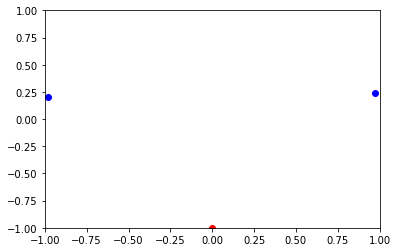

Pred Results
Score:  -11.168904168660202


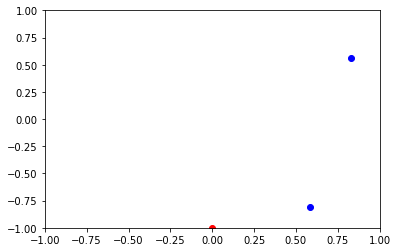

Prey Results
Score:  34.24251931709009


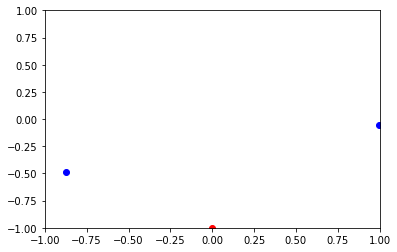

Pred Results
Score:  -34.24251931709009


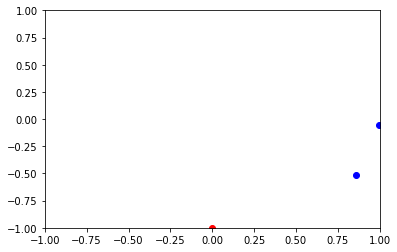

Prey Results
Score:  23.908438627623955


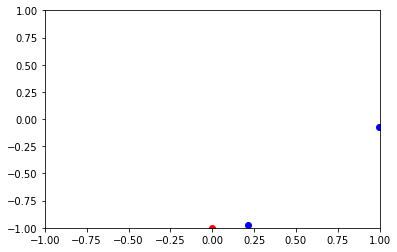

Pred Results
Score:  -23.908438627623955


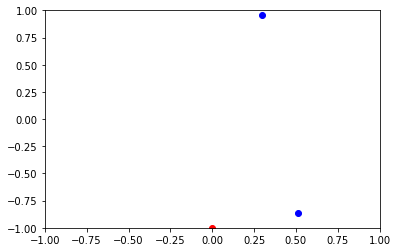

Prey Results
Score:  16.695138180170183


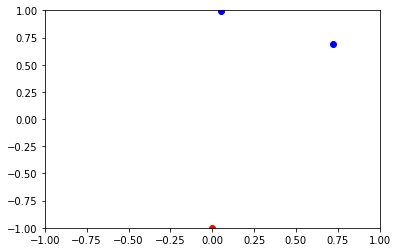

Pred Results
Score:  -16.695138180170183


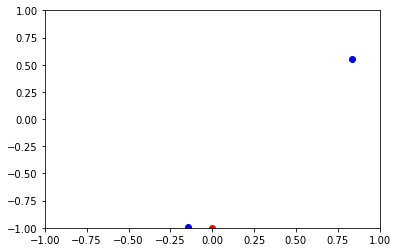

Prey Results
Score:  11.909443370461627


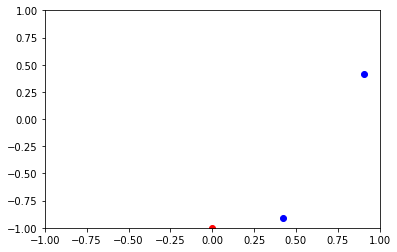

Pred Results
Score:  -11.909443370461627


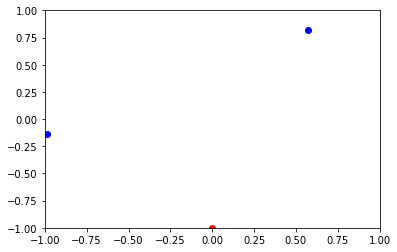

Prey Results
Score:  19.22796043798846


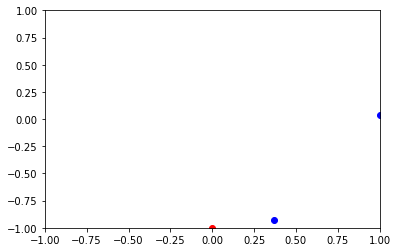

Pred Results
Score:  -19.22796043798846


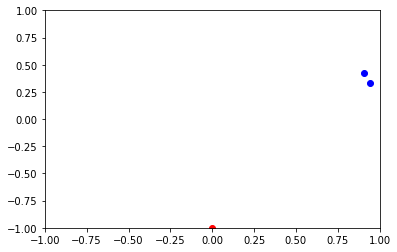

Prey Results
Score:  27.665329154099386


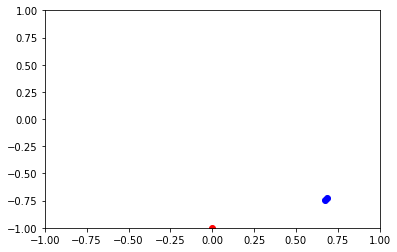

Pred Results
Score:  -27.665329154099386


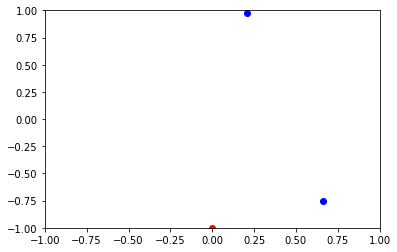

Prey Results
Score:  13.729890229483866


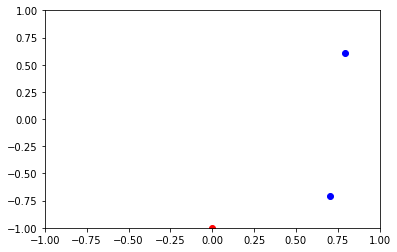

Pred Results
Score:  -13.729890229483866


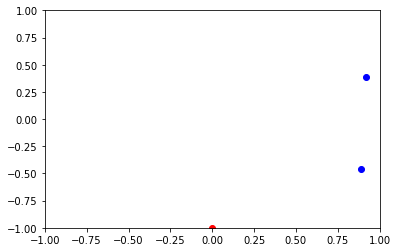

Prey Results
Score:  28.991368432909994


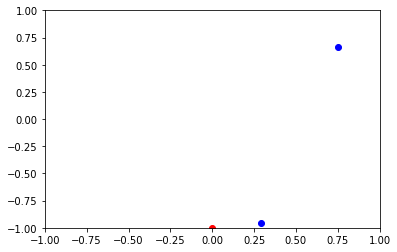

Pred Results
Score:  -28.991368432909994


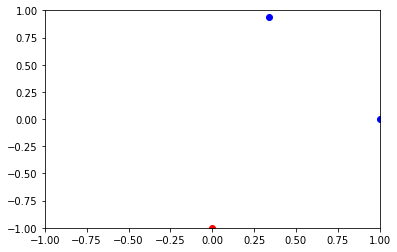

Prey Results
Score:  26.525131131205416


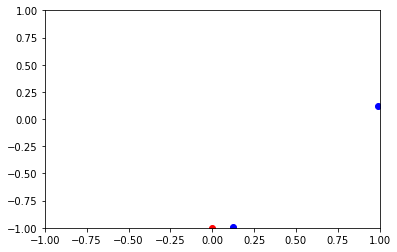

Pred Results
Score:  -26.525131131205416


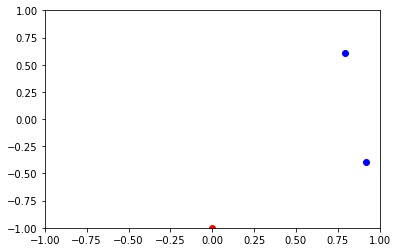

Prey Results
Score:  21.292203845265135


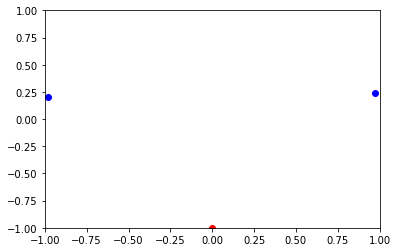

Pred Results
Score:  -21.292203845265135


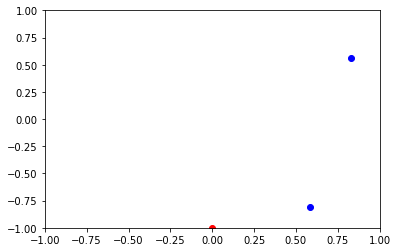

Prey Results
Score:  8.823373665264361


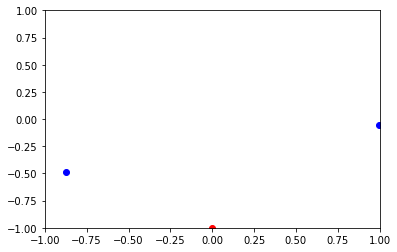

Pred Results
Score:  -8.823373665264361


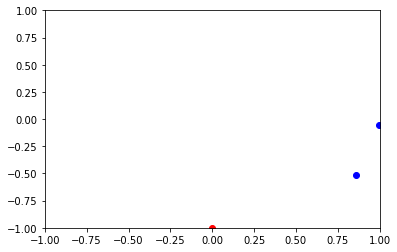

Prey Results
Score:  28.42938219967944


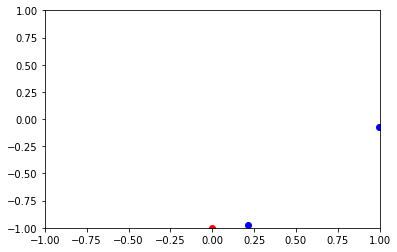

Pred Results
Score:  -28.42938219967944


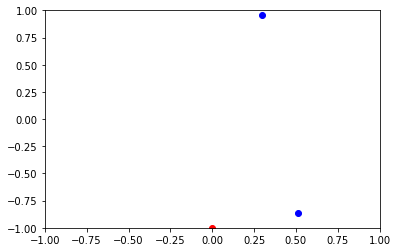

Prey Results
Score:  38.412746721167736


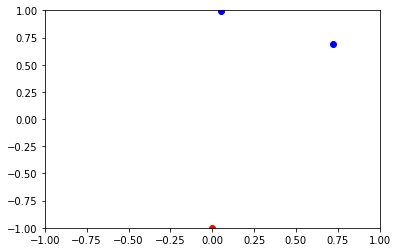

Pred Results
Score:  -38.412746721167736


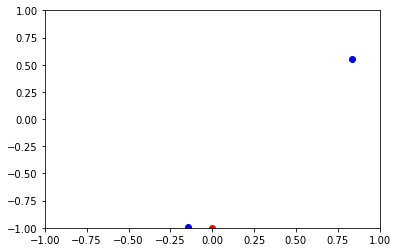

Prey Results
Score:  32.18305589016721


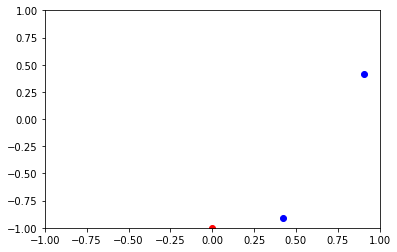

Pred Results
Score:  -32.18305589016721


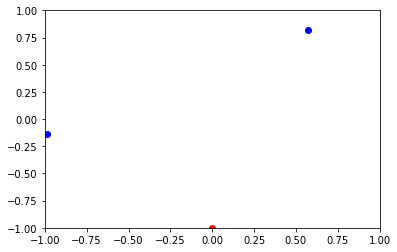

Prey Results
Score:  12.859320706203917


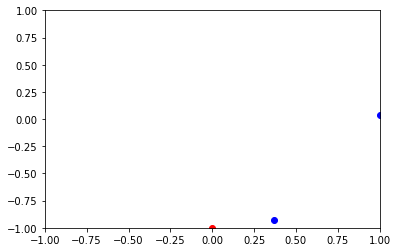

Pred Results
Score:  -12.859320706203917


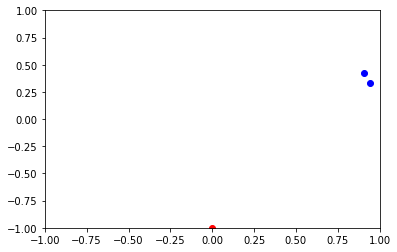

Prey Results
Score:  21.566368081063388


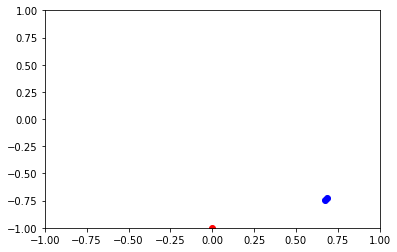

Pred Results
Score:  -21.566368081063388


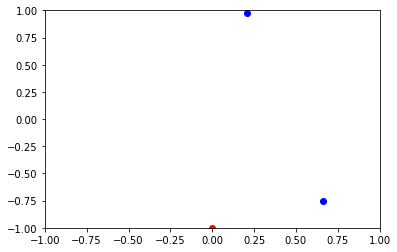

Prey Results
Score:  34.98543247323231


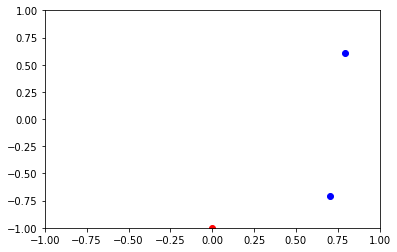

Pred Results
Score:  -34.98543247323231


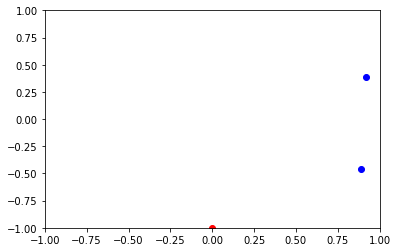

Prey Results
Score:  11.760988742071136


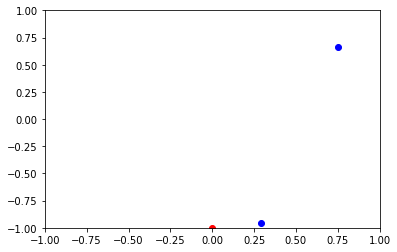

Pred Results
Score:  -11.760988742071136


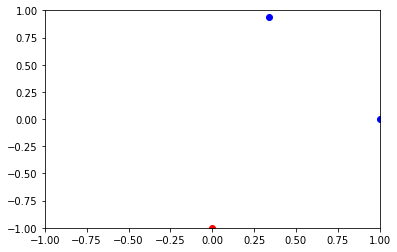

In [106]:
for result in results:
    # Output Prey Results
    print("Prey Results")
    print("Score: ", result[2][0])
    plt.plot(cos((3*pi)/2), sin((3*pi)/2), 'ro', c="red")    
    plt.plot(cos(result[0][0].eye_arclength), sin(result[0][0].eye_arclength), 'ro', c="blue") 
    plt.plot(cos(result[0][1].eye_arclength), sin(result[0][1].eye_arclength), 'ro', c="blue")
    # print(sqrt((cos(result[0][0].eye_arclength) - cos(result[0][1].eye_arclength))**2 +(sin(result[0][0].eye_arclength) - sin(result[0][1].eye_arclength))**2))
    plt.ylim(-1, 1)
    plt.xlim(-1, 1)
    plt.show()
    
    # Output Pred Results
    print("Pred Results")
    print("Score: ", result[2][1])
    plt.plot(cos((3*pi)/2), sin((3*pi)/2), 'ro', c="red")    
    plt.plot(cos(result[1][0].eye_arclength), sin(result[1][0].eye_arclength), 'ro', c="blue")    
    plt.plot(cos(result[1][1].eye_arclength), sin(result[1][1].eye_arclength), 'ro', c="blue")    
    plt.ylim(-1, 1)
    plt.xlim(-1, 1)
    plt.show()


In [107]:
avg_prey_length = sum([abs(result[0][0].eye_arclength - result[0][1].eye_arclength) for result in results])/(len(result))%((3*pi)/2)
avg_prey_length

4.322902781206455

In [108]:
avg_pred_length = sum([abs(result[1][0].eye_arclength - result[1][1].eye_arclength) for result in results])/(len(result))%((3*pi)/2)
avg_pred_length

0.4037317126611448